# Testing LQR, H_inf, GPC, BPC Controllers with  Lifter
The entire reason we were interested in neural nets with this property is to ensure that minimizing state norm of the lifted state corresponds to minimizing norm of the inputs!. Lifters with this property technically form an LDS with quadratic costs, lending themselves to provable control via LQR (optimal control, $H_{\infty}$ (robust control), and perhaps even GPC (best of both worlds?)!

In [1]:
# imports
import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)  # set level to INFO for wordy
import matplotlib.pyplot as plt
import tqdm

import numpy as np
import jax.numpy as jnp

from extravaganza.dynamical_systems import LDS, Gym

from extravaganza.observables import TimeDelayedObservation, FullObservation, Trajectory
from extravaganza.sysid import Lifter, LiftedController
from extravaganza.controllers import LQR, HINF, BPC, GPC, RBPC, EvanBPC, ConstantController
from extravaganza.rescalers import ADAM, D_ADAM, DoWG, FIXED_RESCALE
from extravaganza.stats import Stats
from extravaganza.utils import ylim, render, append, opnorm, dare_gain, least_squares
from extravaganza.experiments import Experiment

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = None
CONTROLLER_SEED = None
SYSID_SEED = None

# --------------------------------------------------------------------------------------
# --------------------------    SYSTEM HYPERPARAMETERS    ------------------------------
# --------------------------------------------------------------------------------------

reset_condition = lambda t: t % 1000 == 0  # how often to reset the system

ds = 3
du = 1
initial_control = jnp.zeros(du)
make_system = lambda : Gym('Pendulum-v1', 
                           repeat=1,
                           use_reward_costs=False, send_done=False, max_episode_len=600, seed=SYSTEM_SEED,
                          render=False)

# observable = TimeDelayedObservation(hh=2, control_dim=du, state_dim=ds, time_embedding_dim=8,
#                                     use_states=True, use_costs=True, use_controls=True, use_time=False)
observable = FullObservation(ds)
ds = observable.obs_dim
ds

INFO: Created a temporary directory at /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpyqn2j9yx
INFO: Writing /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpyqn2j9yx/_remote_module_non_scriptable.py
INFO: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


3

In [2]:
T0 = 20000

sysid_args = {
    'obs_dim': ds,
    'control_dim': du,

    'max_traj_len': int(1e6),
    'exploration_scale': 0.4,

    'depth': 6,
    'sigma': 0,
    'determinstic_encoder': True,
    'num_epochs': 200,
    'batch_size': 256,
    'lifter_lr': 0.001,                                                           
    'sysid_lr': 0.001,

    'seed': SYSID_SEED,
}

sysids = {
    'Linear': Lifter(method='identity', state_dim=ds, **sysid_args),
#     'Koopman': Lifter(method='fourier', state_dim=121, **sysid_args),
#     'Lifted': Lifter(method='nn', state_dim=12, **sysid_args),
}

for k, sysid in sysids.items():  # interact in order to perform sysid
    # make system and get initial control
    system = make_system()
    control = initial_control
    print(k)
    traj = Trajectory()
    for t in tqdm.trange(T0):
        if t == 0 or reset_condition(t):
            logging.info('(EXPERIMENT): reset!')
            system.reset(None)
            sysid.end_trajectory()
            traj = Trajectory()
            pass

        cost, state = system.interact(control)  # state will be `None` for unobservable systems
        traj.add_state(cost, state)
        obs = observable(traj)
        control = sysid.explore(cost, obs) + initial_control
        traj.add_control(control)

        if (isinstance(state, jnp.ndarray) and jnp.any(jnp.isnan(state))) or (cost > 1e20):
            logging.error('(EXPERIMENT): state {} or cost {} diverged'.format(state, cost))
            assert False

    sysid.end_exploration(wordy=True)

Linear


  0%|                                                                                                                      | 0/20000 [00:00<?, ?it/s]INFO: (EXPERIMENT): reset!


3.6460086065607356


  1%|▊                                                                                                          | 152/20000 [00:00<01:03, 311.15it/s]

4.130493207374821
4.8891838514352965
5.924704418658218
7.158660341606042
8.567989190241883
10.076511369973014
11.711575651733801
11.015669812505166
9.554359585886436
8.191659831212405
6.941190513421679
5.837077221588567
4.871707473907032
4.1548038893634835
3.6555554046541388
3.403707727004536
3.398837397990136
3.623523207045611
4.093864913698331
4.812995082933048
5.768048986409212
6.964068559260937
8.34565499667608
9.921453797939558
11.511356112424641
11.18168542219937
9.784546393169967
8.410901493159349
7.075812549353577
5.890140504220023
4.933483436498591
4.182343958530197
3.6556799537276574
3.3761181192889596
3.3375480124076953
3.516684578953806
3.96502628003214
4.683933027464173
5.659463321287609
6.800723875677454
8.149898929987103
9.697757903507977
11.218274830080214
11.390610697985176
9.940069846639949
8.547547368152687
7.23072795359551
6.088686419697575
5.172616489157463
4.439594718741228
3.909930785688863
3.5939837176675726
3.505747483182603
3.648172223529015
4.0081251343771385

  1%|█▍                                                                                                         | 274/20000 [00:00<00:44, 444.77it/s]

9.550704373419284
8.258726981960445
7.063008862812472
5.975238273100354
5.10161212275491
4.415685021059431
3.9458391070835206
3.6979460341068773
3.6760914303535808
3.9082259863040747
4.39250337508966
5.142072707972426
6.0862382143814155
7.243648926355036
8.628568296408138
10.13205546548545
11.614338038162623
10.782242314775067
9.386419794742347
8.10653598830686
6.858811315752115
5.795964643979664
4.933952134779247
4.270761084293964
3.8230933224000183
3.5859468062272417
3.569218700276154
3.7675394129242368
4.193501115043569
4.888510970984589
5.804530921315836
6.906823727963735
8.249309901538487
9.683761242486435
11.233288108283887
11.21813743517887
9.84002127668291
8.447150647342005
7.190576238741238
6.0617550225859365
5.084900803827855
4.323149644577734
3.776048103970885
3.457897957619483
3.385375318093954
3.543906925673015
3.9676739526769453
4.648024181867191
5.5968624329661
6.788461625040151
8.139089044873032
9.59126764486175
11.090859072110561
11.395631335352755
9.993629070135489
8.

  2%|██                                                                                                         | 396/20000 [00:01<00:37, 522.00it/s]

8.881143647714367
10.310219352866648
11.747472599989214
10.51529867749341
9.167822332425567
7.922839557269986
6.771545237491068
5.737355182285279
4.885571602710934
4.24812147679018
3.8371696930417385
3.665397033040572
3.7206404142233382
4.025769784181854
4.596173478582877
5.40710035785944
6.460769214036924
7.651502549433667
9.05965979763007
10.539694128946598
11.73306898976773
10.388357754915432
9.043610215726313
7.706584676849252
6.534443287965184
5.507777623026328
4.649531370770461
4.014501113810924
3.6364126978905973
3.496070288836769
3.589326784365881
3.9205852929781257
4.525403537191165
5.374574993413541
6.40094159662849
7.711639773558597
9.093470127802357
10.632207585196033
11.772993534654324
10.37398393142396
8.979145624360195
7.677376556799777
6.505038005835763
5.48370255471948
4.701503920346136
4.126577709486016
3.8030601224011265
3.7316909243682703
3.912917794700121
4.353356442081134
5.015177210155889
5.920784544989237
7.03385570815235
8.288168314611903
9.679847860237738
11.1

  3%|██▊                                                                                                        | 520/20000 [00:01<00:34, 569.60it/s]

5.756078392283802
6.888970483664304
8.19096984664589
9.644712612673379
11.091032436803312
11.19258455939837
9.847040832802668
8.482443737596986
7.254983895296959
6.130741976202103
5.2068707138698525
4.520139357279737
4.032632364918165
3.773999638254742
3.773728000911544
4.037412736661514
4.548098190167645
5.308069611371343
6.335106473367484
7.5062990119493005
8.897083353389553
10.42406633246901
11.881404355492327
10.515311151903825
9.098048812377806
7.803568044362896
6.576241285804832
5.565267306059928
4.729349435949695
4.12440060271731
3.7715516927994615
3.672303013131649
3.8041143089219394
4.151246006784961
4.727970554762329
5.549462026363836
6.620928084908661
7.868101402319331
9.313042004258046
10.810566039517653
11.503395387075239
10.135695132956698
8.779806062766966
7.479902426306216
6.3092460761579385
5.324086893728241
4.586767988594147
4.049784271515593
3.7330760387393425
3.6521670084763365
3.787641197456607
4.167483970186142
4.800746979538486
5.644781156191362
6.704243228157816

  3%|███▍                                                                                                       | 646/20000 [00:01<00:32, 597.15it/s]

6.75508726495284
7.931338662187864
9.28512435349972
10.685853151349875
11.295584814493145
9.995835085639214
8.729409949482601
7.483212573964943
6.42320769817818
5.489887448379482
4.758816113035488
4.248239493500387
3.9680061408847123
3.933524364256391
4.114406567642931
4.530092919559417
5.162291754781933
5.989105426293918
7.026645598570264
8.29644638363016
9.607332780084471
10.984869892786174
10.917163854666091
9.645146669087831
8.430354667275202
7.275940748359522
6.230803630554334
5.314404767593828
4.625068001377263
4.132063817010261
3.8441729443019326
3.769439194734411
3.9165488061295264
4.316518199283115
4.984352551647339
5.834896078022217
6.875439524139802
8.087689117436554
9.473651142649038
10.91734576958936
11.16153689140649
9.852336348400627
8.533347237024651
7.329455516086545
6.276723009717921
5.364860102006247
4.695102342061558
4.220995818525616
3.950246789444066
3.8963370209288684
4.070067805642054
4.489835074082761
5.137064854125583
6.030467215986169
7.086829980950375
8.2981

  4%|███▊                                                                                                       | 711/20000 [00:01<00:31, 610.89it/s]

15.454804189095832
13.215211596427617
10.981812908651136
8.766431904747515
6.720607176494218
5.0068197601391145
3.644516190638478
2.5876776190767714
1.8161355006586972
1.2842154836079374
0.8877307486215216
0.6020232274658284
0.4330285457447246
0.3293594189727035
0.26975140149306476
0.26562274706854777
0.3093678469178749
0.39550694119885177
0.5425367994763803
0.7976281601812844
1.1645521244095618
1.6993923466885463
2.43702089770361
3.4352645678593263
4.715724584065379
6.365911133029135
8.370421105070363
10.71967729427763
13.239820607283129
14.920801703932398
12.695836364025332
10.419266970601166
8.328858030439392
6.34934619981434
4.781789518440405
3.4943055355121033
2.5250543436009196
1.7798891330594642
1.2492761767257945
0.8684119567401027
0.6107236944478487
0.425232303112297
0.32297033132147135
0.27475812441952674
0.2738728664526844
0.3242040392036253
0.4262641744004473
0.6157505996243401
0.8719637943871931
1.2662234033781714
1.8336213842455038
2.632016593687473
3.7199960535354197
5.1

  4%|████▏                                                                                                      | 774/20000 [00:01<00:35, 546.16it/s]

1.080419375089059
1.5923430863888144
2.2806676879773478
3.2039006612495147
4.453115819201253
6.038016074531901
8.131814358760403
10.566281358362176
13.110579276051432
15.353810809620178
13.144555050101282
10.846674079327295
8.600842945154819
6.65450435732148
4.95043854969199
3.622074794807213
2.6185932184880816
1.845130334270857
1.2790983043669257
0.9028055001654366
0.6169343864923178
0.4306767847596703
0.3198310241247274
0.2727510036860218
0.27620681542133085
0.3343834173936703
0.43941303949696364
0.6286965046693013
0.926647870124954
1.3516507269014313
1.9567412962489983
2.76974488784918
3.8845213909782843
5.349259239065054
7.254277813855174
9.420697452951936
11.926407147661507
14.566706305576213
13.94604167733487
11.749013678403664
9.488072879481685
7.403800527357907
5.607564249897427
4.173234105925644
3.030615518488071
2.143769551315586
1.4871722449374887
1.0514805062354071
0.7366129102117669
0.5108725989503228
0.36481948763361205
0.284727892283538
0.2571071212677669
0.2736760135293

  4%|████▋                                                                                                      | 885/20000 [00:02<00:40, 477.68it/s]

9.43984488983481
7.38613643347062
5.610958767827833
4.128674874291756
2.943116903421833
2.079183330345819
1.4355496451645195
0.9971124252299205
0.6917286542633576
0.4767631461420493
0.3338888797719747
0.22093475559027845
0.14907641884806858
0.10475380218122154
0.08402101877405244
0.07646302447606752
0.08295568445423226
0.10399881148104564
0.14903346547641974
0.209831176712294
0.3179639544019679
0.45430076735397196
0.6636648122036846
0.9430031823929369
1.389645548259756
1.9627341434636265
2.8529032534202603
4.043649474171275
5.5666041251280145
7.461020400692382
9.753990719058699
12.350922707786253
15.053857041390643
14.01352941413652
11.718223199539445
9.378802328162443
7.2392476175801
5.421198507624013
3.9638373372445357
2.822791515778613
1.9777463277937444
1.3872236041588621
0.9425314177821349
0.6387360104359686
0.44501686569276444
0.3356308788876706
0.2900927610919881
0.29332032560110344
0.3458495947807311
0.47168677529416525
0.6469554680473735
0.9394913386787267
1.3688480659682738
1

  5%|█████▍                                                                                                    | 1015/20000 [00:02<00:34, 555.68it/s]

9.984044759723567
7.903107361481148
6.011821611163123
4.446313197737618
3.183103716696337
2.2596273039362362
1.5788820101586736
1.108813812336399
0.7527801733925927
0.5404209805893515
0.38781757465044964
0.30326817925475813
0.27159440709567484
0.2834975773815317
0.3389528922841496
0.4508570066835219
0.6396975279614153
0.9128133599145315
1.3513213307454008
1.9877572831163035
2.7901163583670723
3.875953822216252
5.364907743467574
7.206857101785227
9.473246211280845
11.992996394374586
14.614112779127595
13.998060228762576
11.736999334898634
9.464714190563633
7.359707818817901
5.595180540876845
4.143202413206586
2.9973462603084275
2.133751115064939
1.4810260818457208
1.0271924592289507
0.7134525270999476
0.49896750239552146
0.3605994528730264
0.27353794533900133
0.23237920974025708
0.23459552344965023
0.2816484992826659
0.3857231916713104
0.5648115173291046
0.8408864161822991
1.2190689279342735
1.8003620070430828
2.5895450636589032
3.6216210221082523
5.050281257207098
6.093349313466072
6.1

  6%|██████▍                                                                                                   | 1211/20000 [00:02<00:30, 614.67it/s]

6.480228063480263
6.240606727953548
6.156359984125107
6.220187943970611
6.434145724362454
6.822778067247805
7.341919091905675
8.017234458382577
8.740703418276189
9.556523361211072
10.340000405036387
9.872589707966933
9.111344532023304
8.354877531979673
7.681615360000302
7.121536463707834
6.665796524589053
6.335847844633946
6.148406318305433
6.113363718001246
6.222715248640225
6.4930415673894455
6.901269065433377
7.43375225653727
8.114755466635557
8.904026035989228
9.737440305644492
10.50760254947159
9.703762338260844
8.920725554870137
8.147059122528441
7.463583281850243
6.888333208706376
6.460726381865335
6.152892572059276
5.9938556869162
5.993590833369615
6.162350210147668
6.509427165698083
7.010251758492904
7.617275344782774
8.309759448467554
9.13958056016063
9.962331722153271
10.297991095576435
9.487822198731374
8.731017013855512
8.007399586169191
7.345435582444283
6.794050097442165
6.371520115501495
6.117801079647904
6.027280385154677
6.088932446484463
6.3129198301878375
6.72167738

  6%|██████▊                                                                                                   | 1274/20000 [00:02<00:30, 614.21it/s]

7.826025654964747
7.198552856294151
6.683972487816595
6.321873194053865
6.0920578521727045
6.0145076757160645
6.114220359182419
6.397277094064364
6.804098195402185
7.355563927847472
8.031936025212417
8.763490503704867
9.582070510825384
10.4505899361564
9.851436108530203
9.04467980842901
8.265719513481878
7.581144037604849
6.968398214563786
6.494514249240462
6.1740507398493865
6.019597673165336
6.022205591982942
6.186086962173453
6.528280192738466
7.012450222206468
7.666198728642485
8.41778349764582
9.285760870268154
10.202303310201591
10.187142151028917
9.347231006251628
8.517585096789213
7.744011474577979
7.035620466633395
6.481702285127552
6.046950833393739
5.784880600813636
5.689127323863239
5.748822471611252
5.987904179150036
6.406776633947915
6.984332138009917
7.719737625561498
8.598858486749146
9.484544736466665
10.472868397031766
10.075980233945325
9.180420448597578
8.31872852871968
7.504587880206378
6.811179309181261
6.221159371831517
5.807792548583734
5.579468617583508
5.54045

  7%|███████▍                                                                                                  | 1399/20000 [00:02<00:37, 499.79it/s]

5.5602330095433405
5.653702697579298
5.927255973944172
6.400844169102141
6.990334333285718
7.778054781543688
8.70187704684795
9.702129525747386
10.74150625481621
9.944299159080037
9.003928011545577
8.148739643337558
7.359362314048576
6.648388698623018
6.07579428411978
5.668692715928978
5.432471319166893
5.377730024359668
5.517747818596559
5.842252260889838
6.324598853338836
6.977259829751416
7.758703820499074
8.645665693886462
9.580516322103017
10.58297129911844
10.049067892108747
9.111054504465988
8.246310291797363
7.43079234110283
6.722785214897982
6.158417191123954
5.730244764136229
5.46199521836693
5.373962188622412
5.481690103593132
5.790510022535347
6.29365855941524
6.994090751756454
7.779261596712383
8.658790952866008
9.666902393325751
10.681448426600634
9.996323239198773
9.073196311712877
8.201410695154118
7.378800474575025
6.660408735734478
6.060111424828575
5.596685117811161
5.328811209901028
5.242671670129089
5.354194858951589
5.654601818788592
6.170577905560153
6.8675570325

  8%|████████                                                                                                  | 1512/20000 [00:03<00:35, 524.92it/s]

7.0864864738057864
7.936156738208689
8.919085067112979
9.900381153110862
10.754520015831895
9.809648275010664
8.876808702156472
8.015065271409645
7.225000395669218
6.520583726956653
5.985266729131178
5.594560701473762
5.363634800690846
5.314790266018664
5.47014663629875
5.798682483908692
6.287698805771187
6.9798520469936705
7.760714297423897
8.717723497892399
9.717155103007423
10.715180664493124
10.003168018469347
9.028839198359696
8.124345294550585
7.321136280203154
6.605237274802585
6.02321173149552
5.621683317015824
5.384484835741672
5.331193134216918
5.480441065748074
5.796471759169789
6.292669573417813
6.937184160907613
7.766691934551636
8.67637100817961
9.648240088338412
10.612564984812485
10.022572026789026
9.110957060853616
8.201441534226257
7.406716488586431
6.708071693288735
6.147510694195843
5.736753288424223
5.511179544814604
5.4729617195563005
5.604547203418783
5.906991769748448
6.379639585775385
7.04769911432968
7.879835598603881
8.807196254120209
9.827324233847525
10.815

  8%|████████▋                                                                                                 | 1639/20000 [00:03<00:31, 575.94it/s]

5.4382260158056575
5.920914699273807
6.587820029499403
7.3853390010886475
8.349178952922466
9.427509504376212
10.579343911469914
10.419559776293704
9.35135488152648
8.341124416887993
7.412198036375253
6.5777558208360976
5.892726567065347
5.388237739180255
5.083810403615516
4.983220363222981
5.082703191172204
5.370472615926776
5.85048980005562
6.501814833986897
7.291256780100872
8.204545532630073
9.263015114029718
10.342073651904343
10.535467232281007
9.529931775760867
8.52767109091385
7.607638713493452
6.79499402246447
6.092528083391608
5.5665638798036525
5.216452035398408
5.061649183710017
5.087881876277226
5.298157768379667
5.684828629974163
6.285161755948174
7.062864135709839
8.009946109354496
9.032910611757325
10.141311682135916
10.767565414160435
9.76256189046128
8.737061066988849
7.774007507009088
6.914788275149499
6.161223762422338
5.57242369832543
5.163738676926791
4.968342285108749
4.972124618789823
5.179195524308486
5.590386038042233
6.190867462670218
7.0027437536551815
7.995

  9%|█████████▍                                                                                                | 1792/20000 [00:03<00:27, 668.30it/s]

0.7458822345514818
0.5382806445087226
0.40687749469883594
0.35591705955630104
0.36582860130615924
0.44578489335512506
0.593844589423702
0.8280703537095079
1.2122739106958362
1.7106904817719624
2.468234443923416
3.516667517877272
4.910573156901227
6.680255441723512
8.812375538339348
11.190820156806149
13.677161779585028
14.497380422048105
12.268497074181596
9.994633757815087
7.866288531258784
6.044946091092266
4.472001617428054
3.257826290270009
2.3547839914612325
1.679942506609001
1.1675737366313115
0.8401967000445225
0.6045701923081651
0.4783551506061272
0.4436845191384401
0.48384236544643644
0.6152321200956976
0.8517205004464486
1.2224464748415413
1.7624745858374866
2.483051641350727
3.535011007674763
4.928044004046024
6.722029185743509
8.87881568972009
11.248192594306694
13.814699285482584
14.450074930349388
12.282975409912092
10.002460765718661
7.915085622299012
6.01782289061723
4.436876611246044
3.2473024641603843
2.272159122954014
1.579295508957017
1.0821807699504462
0.7599269333

 10%|██████████▎                                                                                               | 1954/20000 [00:03<00:24, 735.92it/s]

9.5546407747863
12.017853425093927
14.519409601245776
13.746609566589996
11.509732525723303
9.375008822639053
7.279845277036861
5.492322740399777
4.047160853210903
2.930021759276224
2.069821362525005
1.44530054843363
1.00740200229493
0.7214367418276254
0.521437644040185
0.408625167579045
0.3701889409133401
0.38372920190438153
0.4529901755755418
0.6003523223073955
0.8236249746544232
1.1925744317815372
1.7271095053911778
2.4450192913421294
3.435145711829046
4.773553194633882
6.512090426421333
8.540530879330708
10.85900788816
13.449538915123435
14.618556039048508
12.443930694164374
10.205698210996708
8.098368464510372
6.261807457678605
4.634208579082406
3.3915328116985624
2.4205120247374907
1.7171566577282875
1.2169005978613314
0.8582325965366238
0.610395139288768
0.45173497982062294
0.37940364067384713
0.3705101323609057
0.42353554184707753
0.5497024733302002
0.762357063664787
1.1095674833252134
1.5641275308767946
2.2087140840036454
3.137257812464492
4.4006687305605965
6.023669439616446


INFO: (EXPERIMENT): reset!
 11%|███████████▏                                                                                              | 2115/20000 [00:03<00:23, 771.44it/s]

0.4606064746812081
0.3350870832481633
0.25351916128258833
0.1924067734914061
0.17358244593410888
0.173817854006019
0.2106132947410643
0.2445955758297842
0.30773905361213705
0.4131173928271338
0.6017651043968955
0.8580990140274537
1.2012797169230964
1.7148085666784936
2.4933149753001147
3.571677872016153
4.9660248134070795
6.830864189119984
9.04883402954156
11.541997432441555
14.29575732595206
15.137604486511918
12.77685803177301
10.427793798453877
8.22988709903475
6.293601912464146
4.696992296867961
3.3582598214401513
2.423372919904273
1.6832337388052339
4.341900830124819
5.050450569263608
5.957521878403719
7.047867859069635
8.381582342298548
9.878517553405823
11.38315631365549
10.949156158217216
9.583267074468154
8.245627207206075
7.0409093179394
5.979626901858234
5.1231263168819225
4.472137556611505
4.032688087665077
3.840130558086522
3.8804568870904887
4.159427238837816
4.676154722795344
5.450668451053394
6.476651141431011
7.723220479581505
9.154105916525282
10.615626595568392
11.57

 11%|████████████                                                                                              | 2280/20000 [00:04<00:22, 796.99it/s]

9.369670735354248
8.044541164226962
6.819559731582382
5.749198676590845
4.856356255017454
4.20150965551295
3.785881158752113
3.608144311956836
3.6644275582949377
3.970037434668201
4.484802702868139
5.225399261264192
6.204817789707391
7.351417002648873
8.749199381112026
10.274809803379412
11.756179700713346
10.679895913489986
9.309758220458116
7.9473643770317945
6.741723595231543
5.6946560980259395
4.82672537759459
4.150282470158714
3.7138828440048557
3.530269314472072
3.5705807327850274
3.8600801884631566
4.404698118823525
5.217359582004798
6.254888160034222
7.477830125915375
8.92019260536656
10.440272425166858
12.01482092467495
10.649490240844989
9.248079677025089
7.85492148494634
6.606023182623266
5.516041183170097
4.622085701961401
3.953988100091068
3.5205312393609574
3.32071744510597
3.3772521875824313
3.6819924304354585
4.205929158820597
4.974416881742945
6.019148983161813
7.317042858586143
8.829231892718235
10.364043127582613
12.044917552614152
10.89562533974206
9.434910117037385

 12%|████████████▉                                                                                             | 2443/20000 [00:04<00:21, 803.92it/s]

8.336061933858673
6.859780776199477
5.6091994968528756
4.568692036965109
3.7254430518755726
3.144692330674394
2.818846448214828
2.747889143816515
2.902513994318747
3.29570276974801
3.9659616300339224
4.883141611198704
6.099481021749762
7.482162802101902
9.057622847874176
10.746786818445093
12.51722830964718
11.034309888692064
9.41906300052733
7.89696826287045
6.542567442379573
5.320123235406214
4.339020409987848
3.6204276772137973
3.1365978011205597
2.8969965335891916
2.880379364054426
3.087141696929406
3.5295933879102237
4.204355715224688
5.168802865042016
6.412739295154301
7.879166949292653
9.464392999395045
11.14584501460231
12.097924882884035
10.572578276226727
9.014043787799983
7.552754671529897
6.216105380113055
5.090940012804191
4.190497076681737
3.5069381943164046
3.0726549925284643
2.86691424573549
2.920110070650327
3.2087939107350407
3.749675508410918
4.523382585192536
5.56231931253688
6.866622828816707
8.382203700381092
10.07665670935321
11.770372281462551
11.567538657767386

 13%|█████████████▊                                                                                            | 2605/20000 [00:04<00:21, 800.08it/s]

10.070774266599097
11.829317261563938
11.632956206798918
10.024014223876657
8.482831556219958
7.019135820940596
5.7624231452141945
4.7284534288410445
3.888335244980459
3.290717488371462
2.9541174732069195
2.8531141363616643
3.009920174911622
3.4361727583929693
4.096246159318804
5.003479796586385
6.196565914725943
7.581068101158257
9.236274003767994
10.89047180495129
12.35746570708145
10.811201762549194
9.236262332569822
7.758270960548634
6.441780270597723
5.246275547983084
4.314627910180411
3.604852840715836
3.1338051620037404
2.899021312988069
2.907740634836371
3.159724788091029
3.6293212543429547
4.337878326035986
5.34627800963313
6.548560578852772
7.942801769240964
9.561846534373126
11.181979110535758
11.900168474023507
10.410035008617365
8.926368224580074
7.505206283824942
6.19120615899601
5.074457108831689
4.163490276129329
3.4992113629325616
3.088559248996012
2.9032209862403433
2.9774264775472203
3.2747400584648005
3.796557159083035
4.5896473230706984
5.684280904694242
6.94998920

 14%|██████████████▋                                                                                           | 2769/20000 [00:04<00:21, 807.81it/s]

9.412727350562415
9.013976927342862
8.641045025404436
8.326670516816336
8.077237531855488
7.905328649700994
7.828055331643359
7.844194790958322
7.9293329108348445
8.088317023585532
8.31937909811096
8.604833718799213
8.94391483975784
9.302785954638262
9.72119439414321
9.94245343800168
9.545342714871994
9.147311362054603
8.772875444159359
8.45306157421876
8.18248182811017
7.971559280071887
7.826427447580272
7.755719793028809
7.766072944398795
7.8680672208862585
8.050346995238105
8.31601936207841
8.637608634940309
9.02963655928761
9.433836258622934
9.83626548172141
9.830032383135576
9.41338516526122
8.998610060716691
8.608181807346456
8.272909731853476
8.003127337226772
7.811209934024307
7.712787091413137
7.689830130726327
7.768519856445222
7.930767437835749
8.150557167576347
8.44204701619635
8.793238759388158
9.221721276493378
9.647025869962642
10.032899331991416
9.597024124957585
9.171699684146825
8.76407746560813
8.416422692524238
8.140168890931506
7.9336462343884655
7.809299443643725


 15%|███████████████▌                                                                                          | 2933/20000 [00:04<00:21, 811.11it/s]

8.437161787752474
7.9901878242559174
7.605201026868658
7.3226653614682515
7.1405295417447405
7.081774680336226
7.132615791009582
7.3022204405861775
7.603253957660458
7.992088671180683
8.435791142549812
8.95765499853642
9.543102720667447
10.099368528338097
9.719058549404748
9.18709410067004
8.692054867354228
8.22699066416754
7.825953276106157
7.502342040432547
7.28052984636488
7.167818028399193
7.16577931502957
7.27207433203912
7.46673372500957
7.742536045507345
8.104764692150129
8.569779057566143
9.050836904598055
9.589941523451172
10.160013804667164
9.643684269647283
9.134114574579376
8.640227568049058
8.200113162654185
7.837647689742324
7.553249945646716
7.358454198896256
7.275366385921089
7.303410936819029
7.430409813665489
7.638739106514686
7.938670783732073
8.328352583216146
8.759420190901212
9.254255837317492
9.776770690178445
9.98057876711801
9.46463700579043
8.977923661977014
8.52326151866638
8.12466109225219
7.808476959300698
7.588576640187062
7.478944101927219
7.4807142697657

INFO: (EXPERIMENT): reset!
 15%|████████████████▍                                                                                         | 3098/20000 [00:05<00:20, 811.60it/s]

7.902270887101995
7.688067446439442
7.558250435595511
7.538098134945164
7.602405228963982
7.748395564280642
8.007015599363148
8.354471923659618
8.768030054344814
9.245219322366246
9.760558818824398
9.981297807392417
9.493546005361713
9.039011299931566
8.617447610994356
8.2417276745575
7.921381082048896
7.676484688571879
7.513361512894564
7.461382711854147
7.5259799626945
7.679638817801238
7.941780814435035
8.279762801481185
8.666321064394095
9.141525639646785
9.671160096737873
10.078293380336904
9.569704099363685
9.067404890472064
8.599310233219109
8.198340379270325
7.877848685657634
7.63165750822518
7.471091466654228
7.418863354856151
7.476604923688971
7.644207974923489
7.882586199895469
8.231613981664173
8.618776494814439
9.044214598734563
9.535638926369565
10.008124591874163
9.716917808893983
5.234524003788579
5.399330659028841
5.755621550506566
6.310073819486924
7.0627870982543985
7.96873212415378
9.018329313470531
10.09024369818963
10.764025747267079
9.737739276831968
8.7581154701

 16%|████████████████▊                                                                                         | 3180/20000 [00:05<00:22, 763.09it/s]

9.844365689986768
8.782532957813606
7.830841728731144
6.936450130990215
6.175681232538977
5.589632659359637
5.1707937789457805
4.95862328951576
4.9651955645272325
5.19547483498542
5.621885300267968
6.258882829969304
7.051421058906476
8.019522343448466
9.139740012183898
10.345378342936334
10.788320787710342
9.698339911900097
8.615973697899705
7.583261372372453
6.693564071033416
5.952953044918308
5.374557090268718
4.999769287484748
4.820042577930517
4.859157834430049
5.1058500084524585
5.585066912083347
6.238343465931395
7.067508488735712
8.090609116629002
9.250885747067718
10.396783388169348
10.751196741216114
9.630583897059841
8.557259746013733
7.574406165197274
6.696331031049619
5.963272213049327
5.399967260952531
5.041395343691784
4.861246806148447
4.864706549392598
5.058763310784707
5.484539431752841
6.103977723256685
6.8761842919701
7.809078046619129
8.90390283857269
10.03846025414669
11.011003627385639
9.912956459333515
8.883965531504169
7.8792201330219545
6.9768114904800544
6.175

 17%|█████████████████▋                                                                                        | 3336/20000 [00:05<00:24, 673.16it/s]

7.705648804736848
6.808596118820839
6.046000538786416
5.420363689484544
4.991502722949896
4.745092896503351
4.710680108299686
4.891738742590315
5.309524655079658
5.940339994141825
6.71459878746901
7.699722215512248
8.769233477019094
9.896871073351855
11.104742791833866
10.118516807752764
9.044199748633043
8.00365163909783
7.007182106487477
6.154169231080237
5.486762676439584
5.003227796395459
4.708219672965541
4.614666800922599
4.748373459011379
5.083935595819982
5.617966197345192
6.365565025108941
7.276385935460349
8.33901566964787
9.459595457824094
10.680183820521256
10.570675525804068
9.459983779806777
8.378876830653553
7.334098382751705
6.435056284965162
5.714753133929577
5.172736364686729
4.816989024236026
4.664514216741578
4.713354266802531
4.959943578807815
5.421996711348129
6.12373423883057
6.985682589590402
7.972160539321436
9.076513363185972
10.245830262577897
10.908580539628838
9.833925943942228
8.729654811364759
7.696796304964488
6.760897309047692
5.975847429235364
5.376658

 17%|██████████████████▌                                                                                       | 3494/20000 [00:05<00:22, 724.89it/s]

6.622869203845591
5.881593766653191
5.32630622490416
4.964212585545681
4.814716438302904
4.866033349167342
5.1109869829478445
5.541790340526637
6.1743790311767555
6.9638174273809454
7.949604135460282
9.0064010704738
10.179309255149656
10.87109208851121
9.822891780283522
8.75416546184652
7.771353649638291
6.868310157706674
6.130510748278198
5.560453234010664
5.159942909419909
4.9773028919531495
5.017319705780579
5.268180783161938
5.698212782031765
6.288986277344884
7.10318513042157
8.072505298722922
9.099878596846116
10.214267257151738
10.724651716322574
9.672779556768097
8.664432372727083
7.75087598317819
6.916509033532293
6.179138968527292
5.602697407786572
5.231900365990938
5.065525073797545
5.0916238016803845
5.3053526633209245
5.722288021549618
6.361038966618425
7.147801506872588
8.122848932121684
9.209938935225233
10.386955147540926
10.642354036575222
9.566807225062854
8.540904855019471
7.620648714022559
6.77900000726973
6.057993218972479
5.5156405372814685
5.171434060870242
5.029

 18%|██████████████████▉                                                                                       | 3573/20000 [00:05<00:22, 741.35it/s]

4.614195501603078
4.552028194039301
4.695818608768713
5.029242774124102
5.566286689128924
6.327277208505398
7.291070526116528
8.403261723669152
9.624068133200723
10.843291578945719
10.52648380736469
9.394300574623434
8.279164789567949
7.244500623936853
6.328632642695288
5.578918250809352
5.038338065361728
4.706646924456042
4.605034003618783
4.742261046801929
5.1121523387827565
5.691911984237608
6.490873011145828
7.491144515440334
8.58012939104358
9.813409240447891
11.008907135908709
10.30159229702204
9.19041967821318
8.137141452001748
7.1310027170437085
6.276270262514123
5.587866947975959
5.088191964652948
4.768090941195183
4.643455124348485
4.7305038256102065
5.031483021610299
5.565398732302407
6.256498139588279
7.144250704231178
8.197008805103502
9.379195928683567
10.603367746921526
10.670318946445747
9.553649869786346
8.451725335836182
7.427510755307873
6.5290181991108565
5.813759150736274
5.265936499979949
4.91196628487322
4.777076985880241
4.8627893717135375
5.179174605958737
5.70

 19%|███████████████████▋                                                                                      | 3715/20000 [00:06<00:28, 568.07it/s]

4.144548767221044
3.155186042977789
2.396799514518085
1.8564933461404736
1.5190116894199277
1.3574274579328605
1.372936688763449
1.5867486088075693
1.985506865678417
2.614303885897749
3.4985499170002696
4.639374777126454
6.083748512731859
7.80047065701458
9.868497159598428
12.137713584983635
13.741392214673489
11.865618274728172
9.891014427790674
8.003743193591072
6.307872685165876
4.8228970803619635
3.610932534809058
2.706466033720426
2.0777196930839863
1.6550409761619505
1.420762591944325
1.372733961000158
1.4907178670073562
1.8078396356509088
2.301725927076228
3.0504367713656904
4.069690363771315
5.367914115209805
7.077642898810154
9.039822046083373
11.182896676544624
13.444453134114974
12.695008060934038
10.702303478957129
8.740351117752857
6.976422765602388
5.44575307484522
4.088618847858703
3.0513414190365666
2.3046319772835204
1.7845465712659134
1.4751815235075187
1.3537630477500957
1.4057434152275912
1.6423416904835122
2.0859985557291467
2.774475800190436
3.728896451809993
4.92

 19%|████████████████████▍                                                                                     | 3848/20000 [00:06<00:26, 607.00it/s]

1.7120708797957342
1.7332821788768573
1.9454891078406944
2.367174043374759
3.0427970095165677
4.020029894574895
5.330435570358622
6.932434498079601
8.842861596524108
10.922261416276365
13.091330472984646
12.535281079413858
10.628362662891073
8.750563006969992
6.98125730182519
5.488413136124677
4.2195413575957215
3.2048013890377263
2.4573643379828582
1.973845155269737
1.6830332886558157
1.5986776194333359
1.709322421032832
2.0006055413573507
2.54079479754148
3.327260070072731
4.424886362226994
5.8258347339175085
7.590583524733029
9.556887478161025
11.65556649509026
13.755441668240769
11.88820263516302
9.946264021088268
8.116389655921944
6.442411874748359
5.060429700028749
3.9210930777170745
2.998514866706523
2.3286316217852403
1.9096317635249433
1.708016558404438
1.7041352786570105
1.8963746606787537
2.3275376682806055
2.956791421791786
3.918467208449897
5.206814063392812
6.7664320264695785
8.569384796003419
10.521729257100583
12.663140757760265
12.737472497558178
10.859847299923786
8.9

 20%|█████████████████████▏                                                                                    | 3998/20000 [00:06<00:23, 675.37it/s]INFO: (EXPERIMENT): reset!


11.747528131540458
9.953508092283391
8.278057522215226
6.688825505655041
5.297010557261183
4.155856887995748
3.2365748942037498
2.5840905087166575
2.1901922596670373
2.0084793848682043
2.0459746954380993
2.31859991457643
2.7961850820349867
3.5596420748384445
4.578931863729759
5.885209859409429
7.499095475525815
9.405836661716625
11.401804170437481
13.290505005524233
11.583625636352759
9.773924914457007
8.055315379891544
6.425320464765628
5.053885951489155
3.9561522738442876
3.0775144128658725
2.4802652243606773
2.1357524969194004
1.9928572185134614
2.0666149702973033
2.3732648112791495
2.939780066427397
3.7930482515812627
4.909963789172531
6.3449416454535825
8.03865928167943
9.962315124472866
11.939326097349499
12.862429462853834
11.043866270550666
9.300303412670564
7.609161258923109
6.102107154658029
4.759253628765288
3.6661569426519747
2.887407196155459
2.339392255903846
2.0164200822179628
1.8985123459516333
2.0051747320577307
2.3290542797424236
2.914952269207794
3.77890718975778
4.8

 21%|██████████████████████                                                                                    | 4158/20000 [00:06<00:21, 736.18it/s]

9.59855991075429
8.93078506959464
8.317240224618269
7.783825656090995
7.337044892394728
7.0059560910436325
6.790587661219863
6.706008643781045
6.754390785041289
6.94046769100747
7.23587283282869
7.637193664059284
8.146227803298189
8.76807917842603
9.426553406793806
10.12220814644848
9.86373056669638
9.205352618145207
8.557381087291157
7.965225753386621
7.448978623093353
7.045813474626369
6.75371608302221
6.602288343584547
6.601360352005084
6.731899643800832
7.007666294887258
7.424894656577322
7.928540167413535
8.512500193739674
9.184049745434095
9.848229013231412
10.11588902397853
9.470622342708884
8.848654019950528
8.29054505102622
7.774567660449135
7.352669249228734
7.045762260794072
6.860212442410566
6.801465713258063
6.8943797784768766
7.106544681205984
7.463057858671791
7.898145413767958
8.395419286954235
8.968526537652593
9.57156677860511
10.178745994993028
9.69775794836787
9.124986176492621
8.58250612972384
8.098457280216145
7.684486193869885
7.345578801894625
7.097374270080026


 22%|██████████████████████▉                                                                                   | 4326/20000 [00:06<00:19, 784.86it/s]

7.533075797163315
7.006956845915289
6.596270108928367
6.320187631423375
6.204546707078412
6.247531172489198
6.440004805185913
6.758780830177342
7.2361646845014675
7.808275575782687
8.530643179737131
9.280180671716176
10.069594789930216
10.089103734812033
9.356035448835451
8.617365685512254
7.945800355224151
7.369359937124672
6.915473215830048
6.5698870373485985
6.365778789575586
6.292051714633089
6.369381261107695
6.610663208937652
7.0073994930961145
7.5087445620286655
8.145092654394718
8.880502445267217
9.678693148159164
10.479150560589057
9.719893593962865
8.952766686899219
8.24010090488951
7.588072037647022
7.05392833726583
6.646111566207997
6.38061861378924
6.267278939642985
6.294684641044306
6.453395025011709
6.776656898349847
7.233723057417189
7.79479732640681
8.466846538020087
9.211836035943913
9.956557164913193
10.144381587488374
9.422972239473944
8.750562032634866
8.115231519007638
7.556089051036929
7.111040235864584
6.783913667695378
6.590088304458352
6.5169965347888095
6.592

 22%|███████████████████████▊                                                                                  | 4492/20000 [00:07<00:19, 805.66it/s]

6.898154386499755
6.661764250671332
6.551363443054502
6.5951626158712
6.788207548184689
7.1366026156932225
7.599281400938004
8.167597103748358
8.80952869812936
9.519116227303817
10.219554135367167
9.8033333233625
9.1296326987937
8.511331484167512
7.951894529069273
7.451775984608048
7.0696366904631756
6.816599081278611
6.707006105874608
6.727145498771421
6.873297639392488
7.156916241263321
7.563211014532454
8.050570423627505
8.598320312105558
9.214346012082478
9.870905742020932
10.052321276965273
9.423966944370301
8.824538681997753
8.271368781847945
7.802534852145305
7.405494839215818
7.115881220580469
6.954502413895896
6.912774492789712
6.994172629627531
7.185258371889958
7.471124912854533
7.844585770851614
8.287340352867501
8.824322465600916
9.43607955860938
10.022132202613115
9.83241764822697
9.254629622830215
8.709280872019514
8.231760526892437
7.838629520784531
7.53468660114325
7.3251957329166775
7.2232835220702505
7.2319739267021825
7.354430489602272
7.571536691145141
7.8827841335

 23%|████████████████████████▋                                                                                 | 4659/20000 [00:07<00:18, 818.72it/s]

6.903495975856245
6.762996071748258
6.762475867679453
6.887319139129431
7.122095704042808
7.45307333212353
7.898479880309436
8.411444763994638
8.989870456263366
9.579414576336154
10.235652616490723
9.680356951917071
9.05750874182595
8.490506529100912
7.958479085190225
7.521383964024812
7.17624581176233
6.942626110440871
6.8279639777266095
6.839469861960604
6.991634660413045
7.250930110432506
7.613294978448744
8.087036354077014
8.60979519285911
9.20790306745256
9.845304661509012
10.0435132086561
9.448418503442332
8.87805175019094
8.355175575200343
7.900879462236441
7.518605189288815
7.23277030001822
7.060770694485479
7.000142298338519
7.057218986790889
7.246913911786976
7.5520370130920025
7.983154418444343
8.522174792127158
9.104929039429612
9.726662824929987
10.1476944510369
9.557094775752063
8.992301633742409
8.450708204484615
7.970383103413406
7.564585833920889
7.255608281401242
7.076254352671641
7.024075786957242
7.081625938477516
7.259219986104615
7.545202249712256
7.95343473581096

 24%|█████████████████████████▌                                                                                | 4830/20000 [00:07<00:18, 833.39it/s]

2.223385844814908
3.144897314916875
4.3901666772000905
5.98146784446808
7.9953566130287985
10.45823514723636
13.091236621025383
15.766278414456998
13.55050741511841
11.216887489970782
8.874764370039339
6.7750504862139
5.0592872866694965
3.6557409356206336
2.6365066284568517
1.8741564227186474
1.3209587835363208
0.92853718724337
0.6345442956261551
0.4222594659020743
0.2899902220381193
0.1917055796943842
0.1285310576963994
0.09105559460388121
0.06222398568032697
0.04433195202157414
0.03674065606121913
0.038585389364520765
0.04742793409614956
0.06004667878662042
0.09245301396751984
0.12971792994024192
0.1887775888446246
0.27383253310254074
0.3913985010694446
0.5768047100791819
0.8362913816818094
1.2217196407284292
1.7910975301849477
2.5879324920025284
3.7075821927793187
5.104877115160912
6.861604018987441
9.103750026066542
11.620883891429026
14.370765078595674
14.827438536661157
12.432759866766924
10.136520560600275
7.887537303755403
5.935819358501453
4.38724375164602
3.15034812036356
2.1

 25%|██████████████████████████▍                                                                               | 4999/20000 [00:07<00:17, 836.21it/s]INFO: (EXPERIMENT): reset!


0.050374477641595666
0.03356624194951543
0.024366609764526002
0.022173575605552567
0.023160053803041293
0.025820228944855673
0.03455829818197318
0.05466332333421784
0.0835075674880418
0.12761869889050245
0.1848091623824658
0.2756240515337268
0.40241637940417263
0.5798450920097423
0.8244793597319188
1.2156432931119583
1.7651730191431851
2.4894579290463525
3.4974351718967456
4.897088155385632
6.751747976313368
8.989644823663184
11.446387032070199
14.09560144763318
14.852978152340803
12.58343627763825
10.217097928591125
8.093704548198753
6.179036006973183
4.563899757064268
3.3082485550196226
2.317898944317335
1.6052049204654621
1.1263207568083318
0.7696617067159025
0.51477871236512
0.3587587444522796
0.24486173928267477
0.17400401674026966
0.14251100412593098
0.13708537580673766
0.15956491577279372
0.21324113040211615
0.29995485885599604
0.4491796615315252
0.6552632151153959
0.9329397740830757
1.336530199135956
1.9290134155185115
2.7821546214907418
3.9675355977743494
5.509143457966479
7.3

 26%|███████████████████████████▍                                                                              | 5168/20000 [00:07<00:17, 836.53it/s]

8.260413328463825
8.878924964106103
9.559392036300602
10.269576006686753
9.737734238915488
9.075672871714255
8.458580263817657
7.884386991740991
7.376670033956179
6.984447689239529
6.709749720361794
6.565245774141715
6.546927737585806
6.673909207083003
6.926923911634621
7.294800453323864
7.8172898645050335
8.434282494051109
9.141949847020442
9.847590456563745
10.181410872099065
9.496510070229538
8.822441928110516
8.177230434093305
7.618861890308887
7.145760193137905
6.807707895941121
6.614633610233369
6.5599768283226885
6.646941383262552
6.87573181413792
7.219943151839665
7.6915169369806105
8.265456669252991
8.88497752537242
9.606373259690395
10.366948068219296
9.698172591665047
9.018656373653448
8.37120249927653
7.80484796380461
7.314036581680922
6.924943029840826
6.650195467908111
6.503782224749017
6.488927400224947
6.627613879338671
6.8873975098812945
7.293699426715115
7.8149850737886535
8.418640945946732
9.123532061152218
9.895484127985133
10.184835085109222
9.469683969188333
8.766

 27%|████████████████████████████▎                                                                             | 5339/20000 [00:08<00:17, 833.84it/s]

8.718157531350158
8.061743460577622
7.455997436622319
6.96227366861649
6.582913556844346
6.332032873995194
6.237178228480047
6.279452487294208
6.48068249524888
6.843460542374272
7.363361307860174
7.9739991007958455
8.654844833665772
9.412974391179523
10.168696152817125
9.969093644671375
9.22980269705331
8.509053696170037
7.844175102018767
7.251712304210065
6.760363760168639
6.419523821525846
6.228138311728249
6.184975210922748
6.311633482043762
6.572431883245576
7.00768039285615
7.564138957586922
8.227537438320274
8.990493297309513
9.75065990659059
10.390346330836474
9.65894282947898
8.924564695219692
8.209712286336122
7.581416300369488
7.033754623786171
6.593958417432281
6.304580729059438
6.162244789290253
6.163797045747798
6.3313039518069765
6.651363265259251
7.1362148037293895
7.760810879704936
8.490512921885971
9.330396908821973
10.167090017837614
10.09504182056719
9.299589812385443
8.551029211958872
7.882837284409311
7.279096654373747
6.779020329707782
6.387309913646336
6.12829930

 28%|█████████████████████████████▏                                                                            | 5508/20000 [00:08<00:17, 836.51it/s]

7.551377113290579
6.916419819902172
6.4209109114263025
6.056940519543668
5.860234440399708
5.836571859367306
5.976738992715391
6.2864647353748495
6.737626887136139
7.304382186770454
7.99997736261505
8.80085961036641
9.693594857882777
10.591644983017574
9.789557053951745
8.965604834700713
8.213825584197275
7.530828664201204
6.931296220563423
6.447474133431344
6.1242313026101165
5.941602140097278
5.901978332164847
6.021659331640821
6.329745356902933
6.812675426798984
7.418259399181922
8.129854726176433
8.94738076395052
9.847677925608656
10.502617042536263
9.669280632821852
8.826885726083725
8.047297563977788
7.363748470455539
6.760860467778606
6.303683286368164
5.985484941041818
5.852527092657823
5.900914367606739
6.097735378541984
6.484620241574193
7.039492837667957
7.703894198911536
8.527914907956989
9.381519298935979
10.325965502079635
10.113398037583016
9.262327035214645
8.42366453028913
7.6253630254898095
6.95943095366925
6.39531544123056
5.981924850484598
5.7276183862532015
5.65168

 28%|██████████████████████████████                                                                            | 5678/20000 [00:08<00:17, 841.34it/s]

6.663848330426868
6.079525045690254
5.672595481649301
5.453882001511607
5.406170833179605
5.5427900885940575
5.857869184960363
6.333761837537532
7.003320765719231
7.777795142887976
8.645963387555872
9.589707996824382
10.605090113818823
10.01821003802525
9.104169381597108
8.224632358292387
7.432791978495567
6.7605927800190795
6.236315158974344
5.8766703414240755
5.6685628885739
5.649564263031651
5.834379900268866
6.215396542934974
6.7698369924501325
7.4587445065561955
8.252493832853185
9.1138513806101
10.087550761597617
10.41503331775757
9.515761084767433
8.643932896498479
7.8503218543949576
7.113284351691215
6.502583693087958
6.059757548007669
5.761672604821394
5.63643236542929
5.685621187108888
5.893581910709287
6.287634024127648
6.821571500946135
7.514517253519722
8.315384432010092
9.21685833520396
10.173071235853081
10.316272268964582
9.450783628775122
8.571056502187735
7.780420487267207
7.090408849026085
6.48947246744558
6.038990188288517
5.755399469462281
5.636060664546227
5.67373

 29%|██████████████████████████████▉                                                                           | 5848/20000 [00:08<00:17, 824.84it/s]

11.160469251423843
9.678484821366714
8.254181601209348
6.959478560082294
5.800222601734054
4.831032383664956
4.115474997553974
3.631307966997646
3.3689931791627603
3.336180062727238
3.5520814433704246
3.9821560440355825
4.642136440849049
5.597577141612783
6.72443346724163
8.075291316082081
9.62119591913588
11.257467389674844
11.523623320727916
10.04719701028264
8.598422809307522
7.262050231755188
6.069091677789425
5.0614486825834835
4.257752331486335
3.7068458340624617
3.3738297636725805
3.2908955859111217
3.4741695298523925
3.8766282657197295
4.5216060288141815
5.430024846030216
6.582620186670487
7.933207244277588
9.489033370364723
11.148378793700635
11.696939064146159
10.26067133538927
8.817812245705227
7.442390378118239
6.180778894172386
5.064153616678647
4.207917338848347
3.5951607802619265
3.2265193414761826
3.0841057696884784
3.182634990732551
3.5452578225262243
4.1482726682851325
4.998169528463427
6.103584985227423
7.379423606318255
8.843598753213882
10.386577901701457
12.064720

 30%|███████████████████████████████▉                                                                          | 6017/20000 [00:09<00:16, 827.83it/s]

11.51594676546265
11.491293564242392
9.970614765723644
8.537916865147077
7.121717680995266
5.886820272296342
4.86798138764089
4.080118685362464
3.505232524286663
3.191933396347885
3.1278038913122654
3.2962462124106024
3.6846182222609287
4.348165695288321
5.288845028159182
6.458056782923
7.9103611363298345
9.469752349890973
11.101492180993796
11.845408731922566
10.402039641747615
8.957652812077958
7.531141756651868
6.207057424602278
5.1338750970183415
4.259673583143609
3.6171716462191
3.2362431991336975
3.1093463013122324
3.2347331244629687
3.6248237981559726
4.26497190979228
5.149887901287736
6.248803207223318
7.6189437734695336
9.125363117820621
10.682304592715832
12.085109263218419
10.60939203762939
9.14327817999083
7.7765295130288905
6.510182416749103
5.445877308515771
4.571017909136486
3.9438777922855537
3.567215890879402
3.444480663048231
3.545484251599399
3.8591504211572327
4.400695962468889
5.156229926699604
6.2095483082256635
7.433270187374143
8.830928417971881
10.3717535565843

 31%|████████████████████████████████▎                                                                         | 6102/20000 [00:09<00:16, 832.28it/s]

4.454781370397553
4.9963020487022956
5.74515385242014
6.673485283173454
7.849497061301577
9.128352409376527
10.495482096752676
11.309976115741506
10.054323414200576
8.802725865307934
7.6059877163046625
6.550953272496576
5.610188778582961
4.890457164147762
4.361380433426804
4.044299562082427
3.950025255689417
4.082512214532594
4.473199459298213
5.106245693453618
5.917118659825428
6.979051531520076
8.147697778162462
9.464000879248085
10.858910317637333
11.00447508323216
9.774407983479614
8.533588159786087
7.330531823786174
6.2816167951106365
5.419811589561283
4.777316049808475
4.348208830219905
4.148481844314507
4.155872056581989
4.391781341406784
4.871334066912949
5.594547993305264
6.526913658280961
7.669372095134582
8.910138849364563
10.234709878678496
11.474543886106494
10.216331530235243
8.991787936336573
7.82681024002377
6.771829094017539
5.865508841946417
5.117205120245268
4.560763868979899
4.237258242819843
4.138318883933483
4.257621413811254
4.598695724398285
5.20101708709708
6.0

 31%|████████████████████████████████                                                                        | 6174/20000 [59:13<50:23:08, 13.12s/it]

5.286378052744391
4.609834784547731
4.136431710636321
3.8723916226444035
3.8180327610215827
3.988106288260599
4.4087703845742965
5.026712351647065
5.901519942712417
6.984181354931939
8.189214540174822
9.542963557081771
10.908711683596266
11.013752190251035
9.722530429274775
8.497451652823662
7.339671918910659
6.3235529201494725
5.4308082365780646
4.774942146222328
4.305443074276413
4.055329393696871
4.03465488344174
4.258478588686145
4.7081001221452095
5.400557320573739
6.313762369863122
7.423577805652945
8.643185810466917
10.04871361134874
11.476458621387428
10.533621743404387


 31%|████████████████████████████████▍                                                                       | 6233/20000 [59:14<34:43:17,  9.08s/it]

9.22258378297638
8.005665292381673
6.881663974525788
5.8822288404382785
5.077018982720352
4.465437810912773
4.081572164573323
3.9260033713852724
3.9979399817311223
4.324717967646672
4.915791804514816
5.757599020323051
6.787613697423604
8.027867468818846
9.367790001050162
10.757329137090915
11.241368234530091
9.924543213067318
8.662068488623845
7.426306728655897
6.3294899182340085
5.438474625669551
4.730221712950902
4.257814121894116
4.026583434308003
4.018308359107857
4.231896674079332
4.705938046925395
5.437367920829365
6.397987519273153
7.519780710560559
8.755227759470676
10.115686265478695
11.55914288265833
10.426427526586872
9.128902750329962
7.919136184439504
6.842374830017093
5.889687117600284
5.090328275738335
4.501425240260518
4.146220353870655
4.031810323148051
4.1445051592020725


 32%|█████████████████████████████████                                                                       | 6352/20000 [59:14<16:30:03,  4.35s/it]

4.466462852434779
5.027153593077754
5.83751100112732
6.80293500276332
7.990875136527961
9.273100209763522
10.644150553915301
11.186927504753134
9.899791924850797
8.6641975376755
7.481837751810241
6.420437095693211
5.531421634927392
4.861465404403953
4.416030558388094
4.18541372626035
4.178913738570176
4.387542167948638
4.818657543191081
5.474637474765132
6.310798475277357
7.395409464395749
8.563890396877127
9.914840864377135
11.23428584864289
10.516925433069991
9.262861143669994
8.059783047948264
6.9960497819984315
6.049811040988425
5.302366446302608
4.726607712721085
4.367434772797198
4.232313818399835
4.324146414774537
4.657244965255417
5.24146694295951
6.0426715483938604
7.0338958929191
8.178521416183008
9.389890678380203
10.67416614524978
10.916790971026808
9.7284220593273
8.544403393258472
7.386668782901529
6.385057912138654
5.528046477512385
4.888749585378697
4.457914952440207
4.250846099076798
4.253792031816417
4.498349206131401
4.949188315319185
5.64175865258594
6.5079307490435

 32%|██████████████████████████████████                                                                       | 6488/20000 [59:15<7:18:59,  1.95s/it]

4.4534533955833755
4.761210941630397
5.3120837553670075
6.04304987864316
6.955705330365442
8.027794824799917
9.26334637399305
10.532787325433452
10.951097540849242
9.74037178592999
8.606726266435823
7.538850953856269
6.560111248341178
5.727381131579392
5.080008344155118
4.615333008791509
4.367903761041635
4.348921584026698
4.54438023191976
4.9699127400006216
5.598225338597969
6.4408003911163405
7.4381359149164386
8.585214563343106
9.833385242694954
11.129168334571347
10.438390110026882
9.268053788337056
8.086593727768582
7.0290159898146385
6.072806635159305
5.320730891035259
4.781942702793145
4.4308446629726035
4.291898698486653
4.392962926866142
4.707520503886377
5.250053405986932
6.038180834636387
6.982522668768274
8.073969894164838
9.284547179663884
10.523537091260602
10.931785507300726
9.747212370536204
8.591938540736829
7.533344526153138
6.56173508266898
5.781711593232927
5.16257741007035
4.757276597968508
4.584204118612097
4.641778991083948
4.89922650265852
5.354819386122751
6.04

 33%|██████████████████████████████████▊                                                                      | 6635/20000 [59:15<3:19:17,  1.12it/s]

4.3059904438638625
4.701245840121011
5.304594643463139
6.128464943170547
7.128784930671879
8.344684126605676
9.585511404125304
10.964019873270468
10.805756020072499
9.547638314467463
8.336680630482084
7.20656662291376
6.197298259506715
5.353516870988921
4.7308762923532885
4.319661772545464
4.119240345323819
4.132022337081821
4.348942219479747
4.781996965011155
5.437838438080712
6.347102479695446
7.421613153288314
8.674078440899848
9.975143298003701
11.31010587813662
10.4783552056193
9.214439760765941
8.060211186372959
6.945355861448212
6.012870102327383
5.2130088251412925
4.638324692272642
4.279062855637598
4.124751888971279
4.199683126020521
4.516838086781041
5.043904521987519
5.794117393740658
6.711291680781466
7.845038273302725
9.151766458626577
10.494744555453286
11.259357467686845
9.977902647884571
8.746384357503212
7.578693478174552
6.536042367080176
5.676985931274027
5.018098955240845
4.541095375686838
4.258107701038302
4.186010556276232
4.348853114976897
4.757203877569568
5.366

 34%|███████████████████████████████████▋                                                                     | 6799/20000 [59:15<1:27:48,  2.51it/s]

8.067288858905163
9.439325073415807
10.932919959285778
11.325036603062472
9.966712586942686
8.66201174478565
7.375660258407242
6.237677461590835
5.253250858379056
4.508574543719533
3.9754283642750026
3.6908011085309127
3.6356053557257155
3.8337249212118825
4.263683626271588
4.9248493242478215
5.788383084375619
6.843739139230843
8.105773264882151
9.527918024134124
10.966865330516976
11.2490373097281
9.887535785699674
8.542201793833465
7.322229300948498
6.211127423135622
5.2816217429956165
4.5345149703142855
4.018461377939184
3.7304631781973403
3.680855308683667
3.880161953547557
4.306728588709172
4.975281030010956
5.887974791334779
6.959032989652821
8.190380842067958
9.617922400919293
11.089426834110418
11.086150044706391
9.741427916432826
8.473200374528824
7.267803402524828
6.171500082172338
5.274680836361062
4.561696617878903
4.071488776212215
3.800287059670882
3.7620596701423836
3.980481364840077
4.463807167683649
5.148121111022652
6.087280802594705
7.234341928694727
8.51772897305384

 35%|█████████████████████████████████████▏                                                                     | 6957/20000 [59:15<41:47,  5.20it/s]

7.286651456904115
6.313195562226161
5.508749047832822
4.879704344088919
4.440432595982431
4.238087523864846
4.25275221176983
4.4825913667196495
4.9343143985742035
5.589725231468856
6.433454153420149
7.434645174405977
8.627425729912835
9.891065636684493
11.230558078512473
10.40447957320776
9.207480237848046
8.067021264911114
6.990822418942207
6.073491746778108
5.320313896474005
4.779372848480767
4.429374001116267
4.282842883261967
4.348809518449071
4.634337146272925
5.1366905454805885
5.850076677130369
6.7544255339912525
7.889280200993204
9.178020619921517
10.54846690046316
11.16344098404718
9.92006498645353
8.6812508833842
7.521355993761114
6.532584471072056
5.666656979942042
4.9712233672922945
4.505630092599803
4.24826144391791
4.219498476008434
4.4164577787730455
4.840361333676755
5.522512311879614
6.398378795559347
7.465185627244523
8.643706590389053
9.87996855378151
11.203331088060168
10.443982116146094
9.264648358960244
8.098086459158003
7.016010393295437
6.045330288896002
5.25461

INFO: (EXPERIMENT): reset!
 36%|██████████████████████████████████████                                                                     | 7111/20000 [59:15<20:21, 10.56it/s]

10.318813502426115
11.022266514399968
9.889235885687617
8.760912884443139
7.686746631902702
6.732477276495137
5.907981610941443
5.275016587154118
4.808248973228023
4.567189616884557
4.5306821922457745
4.690475454705007
5.061628337085644
5.619700112717334
6.426725627481938
7.432303037898288
8.547951009627377
9.760290800829921
10.976519303105585
10.387021186572747
9.264838178250836
8.164027631655335
1.1920971150407955
1.349132713175146
1.6613903167852313
2.190914597384926
2.923158823942964
3.918250610241472
5.249734023149722
6.837135181518624
8.731097304077798
10.80705715034892
13.04013697003402
12.984952416909891
11.033983090414246
9.064305209540999
7.2475526730937645
5.683926002595603
4.3568644759454624
3.262489333454147
2.4452976532164086
1.905186133317335
1.5658083264684648
1.404928141031633
1.4281218417325223
1.656555862102556
2.107962190726768
2.768495813754362
3.6863760710726243
4.947234090097481
6.471806121000919
8.351898141121273
10.442031112440441
12.684854927227413
13.29860613

 36%|██████████████████████████████████████▉                                                                    | 7270/20000 [59:16<09:53, 21.44it/s]

3.2761588611499577
2.4062555136284174
1.7570751420160433
1.294966375637364
0.9967143082697533
0.8302002572653183
0.7847556967088712
0.8634802288453646
1.0852905494339566
1.4269305920736373
1.9397104486975025
2.7362148541111537
3.7358804074812952
5.061472997427359
6.783181767061251
8.854545085021892
11.099492061514411
13.4297277469341
13.596556431697628
11.574567762172615
9.443914220993998
7.511234938186044
5.767735085670665
4.3673939786915295
3.2370309770846006
2.3251801342998077
1.6945411906523078
1.2668388054621018
0.9726441290952849
0.828790881808047
0.7995890822753382
0.8846396133866179
1.1124666507441874
1.4851141263615317
2.074619684303093
2.8453033204043607
3.966812647437314
5.446883196851649
7.241643130288958
9.373136094526217
11.707819009594482
14.20114717316028
13.231904486514418
11.083939060373474
8.997238610793488
7.113630000970829
5.410584198196579
4.038061357110223
2.961390853932068
2.1130259367961117
1.5284916348501612
1.1378405829809268
0.8841911887520837
0.754263741939

 37%|███████████████████████████████████████▊                                                                   | 7436/20000 [59:16<04:47, 43.70it/s]

4.169000271042227
5.7689135965375495
7.6691747273027655
9.91842055064708
12.406350134086916
15.010142534251736
13.395106662274339
11.125519570060739
8.912972284843477
6.93397109640946
5.242919624977754
3.814354146913047
2.7217667029860935
1.9297241838854973
1.373885959864515
0.9761267540162919
0.6859431738772755
0.5022374671283515
0.41295147443714353
0.3948268716349615
0.4341494959493165
0.5413393833719056
0.7427618954317623
1.0482563809205216
1.494321039940496
2.127355095396433
2.9790823924770167
4.206381361551417
5.689470223062472
7.608152776280827
9.768555326580191
12.201092435964165
14.714668767359605
13.312707334426614
11.077956126509003
8.886073562054754
6.87513493363158
5.238689596713902
3.8389864529992566
2.7829378756534027
1.9896524106629898
1.4409310436265117
1.0579397237579897
0.7889521592377605
0.6524917611979791
0.6172241836987947
0.6849678477181911
0.8739136671654834
1.2108304901468743
1.7317891323348307
2.401279742202547
3.361508695533081
4.644592437785491
6.239901211391

 38%|████████████████████████████████████████▋                                                                  | 7600/20000 [59:16<02:25, 85.17it/s]

1.0833616016618408
0.8030998654969664
0.6518734117025374
0.6130876299327257
0.6852454073557525
0.8683456080572398
1.1525209194178445
1.6288130284200633
2.3007213143000853
3.2041684516693807
4.432634074681323
5.951407859397682
7.816782308415009
10.081480019797164
12.563273763401321
14.880240884389787
12.768131797031765
10.59102987102815
8.471517303030488
6.631119464479184
5.033598422636738
3.6553433829286406
2.6524027602328943
1.8648409377039172
1.3235328945467928
0.9630992898132277
0.7417767525182573
0.6497649966852865
0.6527861712858007
0.7666790617659561
1.0090687239745777
1.4133642196904703
1.982738114678432
2.7658329802416177
3.8357762068153765
5.26289993158216
7.085963430625361
9.238406985325947
11.67431286443607
14.23954810127018
13.639785051267815
11.521665509048853
9.338680908384049
7.304798247835516
5.513420179578043
4.087972285747037
2.965046391920902
2.142089520443875
1.5204148978689376
1.0784363319428976
0.7964721415884256
0.6233991449379633
0.5403555061695787
0.55037845603

 39%|█████████████████████████████████████████▏                                                                | 7762/20000 [59:16<01:18, 155.65it/s]

11.271747968938962
9.690696019566166
8.228498610232805
6.8602291021308925
5.630094736088926
4.6020148621721315
3.8151603237775418
3.279766455810831
2.9808873411890104
2.899981171718408
3.039095483260104
3.3950584093317104
4.017644197004211
4.862690730808168
5.998216336087177
7.417519412414185
8.982184764594786
10.620239882506416
12.397718706484829
11.036901510768644
9.468674686959366
7.9772549104076464
6.571802225879788
5.361847560765915
4.400367755043499
3.6617245105998335
3.167855834622975
2.9060825459043405
2.8853520183537307
3.095288395229773
3.5309187214516045
4.2063643027888755
5.189910831471622
6.428535243845909
7.912600856265726
9.50280030435033
11.292179877817489
12.110602993769954
10.495821709395477
8.933452787261762
7.480748258303743
6.153100510657623
5.0346100301376335
4.133506023730666
3.474306431121137
3.0553297299661053
2.861647992514442
2.9117376232403593
3.18330446482762
3.6860663709288928
4.470441462763171
5.505986055132235
6.82009556133076
8.372095145256958
10.054151

 40%|█████████████████████████████████████████▉                                                                | 7918/20000 [59:17<00:47, 255.11it/s]

3.398537647521357
2.8909968456356183
2.623746905928107
2.6099231851035687
2.8464374626373345
3.353135134738126
4.078884014521469
5.125039337181676
6.3908871749498815
7.946079079121409
9.706880350282722
11.5366207617599
12.341266850020679
10.666468300809447
9.059694587370904
7.489302645110092
6.072231233811271
4.8688289826756375
3.9086885386270525
3.1752964038585163
2.6738395434249695
2.4319746006833385
2.441057798735547
2.6957273974562725
3.206532697210754
3.9358542817208275
4.972980959861184
6.252734267856818
7.8488967200957855
9.66768038418652
11.580197745762803
12.607901608935299
10.930099884283687
9.225541045569116
7.550464621442757
6.099987952481593
4.862255898356034
3.8616169823174062
3.110356168594444
2.5906190451105218
2.293111758898002
2.2202244323190956
2.3654347707461114
2.747081167524881
3.3560450137005375
4.231951038139437
5.415788443913476
6.8659842056255
8.567508351153174
10.371165060012663
12.37890243288748
12.016836729326338
10.335205424500804
8.649867187152632
7.04039

 40%|██████████████████████████████████████████▊                                                               | 8074/20000 [59:17<00:30, 387.20it/s]

7.942536596219815
9.629530160002469
11.390710151221924
12.281521515647546
10.647063504375751
9.035593407048145
7.496851014491403
6.100342131802085
4.918828291512687
4.014577186553311
3.3301070328576103
2.9116652949949313
2.7197458179301046
2.7612584587437854
3.033078205642647
3.5376718349989686
4.291041719666305
5.305580491253044
6.57602192674031
8.026536780782067
9.633282894353238
11.404383443676693
11.991288919728708
10.39788731031158
8.849585374475373
7.388873116837294
6.107633410976268
4.996670984365489
4.083520199717265
3.4448814884073955
3.038211102512838
2.874230181646112
2.931966358583012
3.2452717531814472
3.825360980966549
4.647219880389008
5.755249577323781
7.10412377303615
8.601737884473186
10.307096230288243
11.97562081670776
11.305556353985684
9.774280282858877
8.259631736023584
6.86456170661279
5.683478993434983
4.664446688902359
3.900478998897961
3.394670470591201
3.141484307543266
3.131461063475905
3.373813909755063
3.881444385291515
4.636628634402092
5.650696769139381

 41%|███████████████████████████████████████████▋                                                              | 8243/20000 [59:17<00:21, 540.71it/s]

10.842334145974384
13.31154491151765
14.415927126977863
12.319731705320828
10.073002498284064
7.948857775452074
6.119794782130361
4.537400342413662
3.296349434478566
2.4052505329084912
1.744525024872587
1.2475370561687797
0.9432253317881987
0.753554434264041
0.6776432614215154
0.718823324991314
0.8695988449230274
1.1409399904067015
1.5857745875357296
2.2145394517219814
3.078432870372694
4.253526615545729
5.765741447059918
7.639484151260353
9.8370495203857
12.195758745167405
14.698399695947614
12.928636839855244
10.753262363443447
8.613458859752086
6.736994007536941
5.124466345822384
3.797605513268559
2.7327318768776028
1.9747069550794607
1.4357544389241412
1.0696037424118061
0.8361381541475567
0.7356252145366454
0.7473603575657827
0.8859257285923604
1.1334955998245504
1.5499199094961171
2.1888769875109575
3.020404094412703
4.124200662649878
5.5725135942612045
7.462064379133517
9.605127600582
12.057560146763741
14.606669203973434
13.057666762949907
10.901681618244789
8.871990971459674
6

 42%|████████████████████████████████████████████▌                                                             | 8412/20000 [59:17<00:17, 662.77it/s]

13.765337277321146
11.625219824146576
9.481326371446835
7.558916719237482
5.83383033581922
4.372759429276835
3.2257365262565205
2.3158606874714907
1.6734483401980698
1.2591750003223354
1.0004436647614283
0.865568533824035
0.8685777679057489
1.0134634554385245
1.321542043040631
1.7714961102319875
2.4342787643749944
3.3434810003710482
4.545204482871123
6.117930473006345
8.076416460918358
10.201573545204246
12.523069650403706
14.336108259321941
12.247882502802918
10.196577029940295
8.195567579618023
6.349870066131212
4.843109556722652
3.5819614142685396
2.6338048474062816
1.9221872665220872
1.4035010161219872
1.0575379037000858
0.85474854348613
0.7684358883174841
0.7885466001972773
0.9129697689372733
1.1669020378667994
1.5776952353012859
2.2027850285938313
3.078639315235984
4.232179306714011
5.768762304171469
7.703490762098317
9.856683216087026
12.283583105412823
14.817726564899568
12.916338414134977
10.689626822191919
8.568734425151002
6.719226252988392
5.118963242124664
3.77329247880006

 43%|█████████████████████████████████████████████▍                                                            | 8580/20000 [59:17<00:15, 739.46it/s]

11.45510362072821
13.884229210306536
13.740548039746592
11.572500775843423
9.443055626116825
7.4200198924984075
5.670494017074839
4.202278438148005
3.0526371589790475
2.229009848127731
1.5903571860699741
1.1704788618956754
0.8866083261825694
0.7270831331175088
0.6846315751964753
0.7585098854835053
0.9465765392610607
1.2605576198066273
1.762518748750972
2.4943568664270117
3.4646005789587946
4.715012825467056
6.373751116765584
8.446541887722924
10.812348905275236
13.368626713669165
14.31828661179045
12.224173097065886
10.106006402419007
8.046648587359323
6.156930523231859
4.5572275328191605
3.3372909195277547
2.3713578244646727
1.6642091447939094
1.161817191790084
0.831668890469372
0.6438727412752971
0.5392760036310907
0.5321563364761532
0.6030882701481062
0.7705344355207728
1.074478152068913
1.4888634327441252
2.1241208611453715
3.0282012040879867
4.223313598224399
5.7425481764887305
7.681611208902018
9.896113539351882
12.31911553122884
14.87902814506581
13.171254066363895
10.9200255448

 44%|██████████████████████████████████████████████▎                                                           | 8747/20000 [59:18<00:14, 784.41it/s]

5.752834470208564
7.663490362028915
9.907142570265568
12.232296886183121
14.659078463687388
12.738867829073662
10.61952853758305
4.9586278673889925
5.548691852622346
6.323945779637347
7.3104491182608005
8.474940392189547
9.700321696259403
10.971052019710948
10.533094205773574
9.325871611892723
8.223619568184949
7.147407885146185
6.2461573842234035
5.49908290706262
4.914532841939968
4.5377436719127004
4.3583323923901105
4.373189861804469
4.6056990920563425
5.089030729977372
5.765201277823968
6.626402877872556
7.696296572315987
8.933373897496518
10.168653885742065
11.298380093042676
10.093824026962125
8.961671054865382
7.827708700709286
6.836422007174496
5.952204057315816
5.275807979005572
4.769981164988764
4.45388335214353
4.357923815177751
4.481058917737975
4.824363176277643
5.370003674286233
6.152001479599454
7.161913441766279
8.298404284733857
9.528096794385055
10.817623002746041
10.733333481361347
9.52022303931904
8.366749822799562
7.27523041859518
6.330161198827279
5.56634043333179

 45%|███████████████████████████████████████████████▎                                                          | 8916/20000 [59:18<00:13, 812.37it/s]

10.043166265264153
8.895408781313108
7.794231887763113
6.783600791162195
5.943870200643891
5.273920690498562
4.790283348173377
4.535561470735411
4.5105617375422495
4.70222070881022
5.103707068411508
5.703084268186059
6.550701985508567
7.507623850806363
8.65612358420949
9.822258741163301
11.097134367270206
10.31064538734356
9.1924448537111
8.06311192361232
7.041049295971794
6.14212591459505
5.428584747382871
4.9251981955801565
4.60968100522669
4.501848963812605
4.603385125331146
4.939372911437296
5.46791615247554
6.217416899796808
7.147213452224264
8.213313316911831
9.430167651374722
10.726911841549759
10.732991808561588
9.57184628029936
8.390367614372058
7.335899709552018
6.401772263682711
5.605834604759002
4.999825930991223
4.609083140259077
4.439355678814306
4.484341316083578
4.733484162015374
5.18663813844927
5.876344902822529
6.7850368847364795
7.884461600191775
9.138195750352702
10.420625829052938
11.120887843242878
9.919673237611482
8.72206849149921
7.609452520253422
6.6087857791

 45%|████████████████████████████████████████████████▏                                                         | 9084/20000 [59:18<00:13, 817.27it/s]

7.899544766982217
9.151882331120811
10.465305369085764
11.088579753639129
9.871895626619358
8.692536418334162
7.593273866461823
6.647332282397434
5.815112219973912
5.162297207180524
4.699813016729344
4.45867390112276
4.4177616142110745
4.576508658014186
4.944173730270654
5.528078405926886
6.289941916966933
7.2122865091849295
8.339851462305523
9.49686441377085
10.698417632427033
10.626734546811173
9.511368823848011
8.418551748886836
7.369476179311556
6.429201756126735
5.627752229678441
5.00501745529232
4.576647742415867
4.352033677559618
4.346305675062435
4.572444975326903
5.018903097506387
5.647644388457595
6.5229121032998645
7.6063611244856535
8.85050605936433
10.199383287961632
11.447675226530032
10.236699114539443
9.025509843195687
7.823653454141299
6.73294678603366
5.806034119004613
5.042966895946302
4.514766646706915
4.214338030146884
4.13922290141425
4.302804231560529
4.6934174792583025
5.302129999602563
6.092109778146147
7.147691168590972
8.301128846371489
9.619669795818032
11.0

 46%|█████████████████████████████████████████████████                                                         | 9250/20000 [59:18<00:13, 819.79it/s]

8.236508870250862
8.488947129078975
8.773125790886084
9.139800003944915
9.503970584137393
9.920557318802372
9.743351703334646
9.357927250699744
8.995159829664795
8.662052019401704
8.36066267654607
8.114915341911583
7.938311370643442
7.82615952479367
7.805445036679665
7.874606085375654
8.025193641870148
8.258570423505843
8.552823552889393
8.906466511745753
9.331739337066233
9.75615461316338
9.919479671363712
9.484219650068917
9.06139879303877
8.662551041949543
8.30142644823633
8.0125788759623
7.815298310980467
7.715549526332223
7.723978475748412
7.841967488378174
8.042272283651807
8.315311739409651
8.681637379622352
9.090040864723916
9.518145941017428
9.9581449143716
9.733535116937084
9.320643218194851
8.939033015702284
8.582000306007922
8.279654719167434
8.02826883876474
7.851136715141026
7.76366552208995
7.772497944709624
7.877221607297714
8.043069650690587
8.29453996638487
8.595834458805838
8.934213699486667
9.351753262706099
9.795695673578399
9.886578486266457
9.459420261820993
9.05

 47%|█████████████████████████████████████████████████▉                                                        | 9417/20000 [59:19<00:12, 827.08it/s]

9.592039233833534
9.236770555233603
8.916858801987306
8.646246937056299
8.415588970005107
8.225333719060485
8.102341903413546
8.053647575783273
8.090172601252034
8.207653182348531
8.413679596559229
8.700163741687476
9.046164464096035
9.397541623352533
9.759878359030791
9.881154727655975
9.51373671057081
9.16890640484835
8.856952381948021
8.579396182468955
8.350686727912205
8.183773830489343
8.091286703352969
8.059807357609827
8.090175324998256
8.196499716714605
8.354668332258075
8.59980211879683
8.870917790102567
9.17529064730752
9.542238233158288
9.921878795516529
9.724341020402159
9.354688024189445
8.992777808432999
8.658335349202913
8.370320331419776
8.136190135968466
7.977555965033389
7.881107144731869
7.847506583818268
7.894381274163697
8.043817898108362
8.26521084741608
8.528225419459263
8.838046263198466
9.20548350339559
9.607799036083838
10.025095036293353
9.645542818629805
9.24732735142053
8.878790276406614
8.554951644229744
8.28374297217804
8.077401519239212
7.937834614409874

 48%|██████████████████████████████████████████████████▊                                                       | 9586/20000 [59:19<00:12, 834.31it/s]

8.255474335610694
8.566910652016304
8.927843260596688
9.318514115395727
9.708580898995036
9.950511652097338
9.549735322078972
9.159764673056094
8.806630425915415
8.493659067089744
8.236527207510678
8.030194037589022
7.896273813688961
7.837190992381228
7.84075755583318
7.922017254105019
8.104914388788075
8.37290080685834
8.684842169774626
9.079044907083903
9.480976778592435
9.909620060555996
9.767506182818584
9.353334267597262
8.950630294601185
8.582031342733536
8.261593560795806
8.022640080386067
7.8626365652363805
7.772105540799313
7.763843362158281
7.832441788776464
7.9762032025148315
8.180866412311108
8.463009174676372
8.807114646838967
9.164747629189277
9.558764752715637
9.958133868407527
9.70795545169964
9.337965368019672
9.00653082162919
8.722396541675097
8.491213201867874
8.327483264947892
8.215226206963576
8.155842444877695
8.16270718736309
8.22980592816354
8.354645129716403
8.53491149471762
8.75954585264982
9.022123214660501
9.336189019514658
9.644725843418236
9.97551056216343

 49%|███████████████████████████████████████████████████▋                                                      | 9754/20000 [59:19<00:12, 831.97it/s]

9.962718088062417
9.700466650404655
9.326893517613497
8.96654274944163
8.649117429148252
8.384737691437183
8.183348916093202
8.05606005158694
8.020511477181747
8.050265337521743
8.168037852639463
8.357464684176126
8.608502080906034
8.93576565203214
9.284710854831964
9.637589192204134
9.999677135530204
9.625867633033819
9.254260557481134
8.921735788772418
8.635896766067606
8.393887179904391
8.20195047765368
8.076854090867116
8.021801621098613
8.049363541311209
8.16349506071693
8.346131081382882
8.614382403165019
8.941854822096447
9.315444888972342
9.743210596478548
9.923687531638121
9.52271661222842
9.14530795664099
8.806573817673103
8.517877970606742
8.272489910865227
8.083930327194823
7.964316962951188
7.923931997895796
7.97879395225936
8.092700363623814
8.291426033909147
8.578873881403666
8.902790814806673
9.265223502833488
9.683600554891713
9.97695794771289
9.56250961928181
9.160246613950244
8.787159067191766
8.45907358266914
8.190681196400318
7.989651226204931
7.857956380031661
7.8

 50%|████████████████████████████████████████████████████▌                                                     | 9923/20000 [59:19<00:12, 837.56it/s]

7.656818694147749
7.616614516435892
7.65621396857339
7.768655429758395
7.963272019289349
8.241280875121452
8.593341553811344
9.013695567001383
9.444460035620297
9.90868870904559
9.793410374649516
9.33179247216408
8.885981388383426
8.486643846435351
8.155193938125832
7.888426050847457
7.6906013370267505
7.567788423739161
7.528492976538783
7.589509660441832
7.767928604318518
8.018970621216482
8.350122487552722
8.770604766111662
9.199167259168552
9.674533149951857
10.037729744937957
9.581619391233977
9.143463279190565
8.719442134732162
8.329371293369958
8.010565149215433
7.768725864600391
7.615060011085362
7.544826801845068
7.567577342408938
7.689989560813961
7.901190291644662
8.212348225633912
8.586909368779414
9.034574335426532
9.523833558992033
10.036380747926364
9.708695106464853
9.241980503720642
8.810865754554085
8.436506283470704
8.110368279667604
7.8572895244891185
7.687392301606009
7.600627131971821
7.603325796773503
7.695151324714047
7.861054066001694
8.134099566320947
8.4493812

INFO: (EXPERIMENT): reset!
 50%|████████████████████████████████████████████████████▉                                                    | 10092/20000 [59:19<00:11, 830.73it/s]

9.04544755328118
9.504522535612525
9.965712993903821
9.745864530936457
9.29257802643764
8.867839446966315
8.490268196513638
8.155872525045346
7.8826026841512125
7.692420005369792
7.589087003458438
7.580188018357171
7.650769624963494
7.826382358424906
8.093204099524433
8.456242500593367
8.845500665561032
9.325474875355354
9.78826840865861
9.924292442375487
9.458692636686516
9.004464188232488
8.592891910008928
8.236452291548721
7.9567767167869885
7.763005649202
7.646166627070986
7.616466435657023
7.693289333480806
7.869267533569664
8.147282892150633
8.493277811016975
8.886695318460989
9.297060527434274
9.7479810058449
9.944040754085131
9.504333499087897
9.086480055536327
8.691007929627085
8.344597233429967
8.074480533268924
7.886272700424515
7.782482120014635
7.755158892649139
7.824358461368094
7.97710504119374
8.21946968092666
8.547182281423426
8.930927769340384
9.32929272399622
1.0986901484129725
1.2876573077904543
1.6300294443202588
2.209638774850333
3.012776018375098
4.12387824468751

 51%|█████████████████████████████████████████████████████▊                                                   | 10261/20000 [59:20<00:11, 834.29it/s]

2.480350195862252
3.404285795721899
4.7246290123120165
6.317433924748206
8.225467369013336
10.481280777796407
12.858548558873759
14.184620645134624
12.107643871701498
9.991377155955798
8.020759705925594
6.209042405691525
4.692569137378541
3.449515827301326
2.5443000488218104
1.8542544100349914
1.3787453804363294
1.0490243719746801
0.8871527770899948
0.8397411070989886
0.9091212207690379
1.1096401939848435
1.443275799598291
1.961741354494825
2.747846200602504
3.768634410577539
5.135630339855561
6.791784025209404
8.782433822313601
10.972821382657367
13.352577314715383
13.49084980536727
11.41886035734533
9.388305115964977
7.4629928162213215
5.761190117161481
4.374947264237926
3.2108033466175585
2.339390166890007
1.7538014138185702
1.3529386240352834
1.0971698700112316
1.0107342745905896
1.071042473855603
1.2805817102773873
1.6597408547614592
2.238628707056938
3.092056676367753
4.256748785260703
5.673182135160095
7.533741298644623
9.682427491466024
12.050436828634725
14.413930602126698
12.

 52%|██████████████████████████████████████████████████████▊                                                  | 10431/20000 [59:20<00:11, 837.73it/s]

3.454769560454247
4.804519836718123
6.567262288119878
8.5846934833462
10.97112785388456
13.447731262777234
14.442350915775116
12.208761192429144
10.020906947590653
7.9818104323296435
6.115387322162951
4.5269844685699585
3.2856709461324503
2.372939490694313
1.706571291897086
1.211011088444144
0.8615706140283009
0.658586830735533
0.5474101613591672
0.5273572820007243
0.6015873330296134
0.7849344485493944
1.1036899016004682
1.5519211930168466
2.163607172713688
3.0927225227380006
4.3529203602631465
5.950886679770724
7.953225277983643
10.252027050498874
12.826918772441083
15.126748920422052
12.892313337419182
10.66277486757847
8.520202503599286
6.606921407336836
4.988866868493483
3.6739271898303745
2.6738566401651043
1.8893915890203572
1.3405156518363186
0.9408504959067671
0.6718137073400513
0.5191768776652399
0.4631604242662434
0.4973080682295312
0.6271932601929567
0.8354079186811078
1.1875942644589954
1.7098933937036236
2.431580749844784
3.4356379686341882
4.787056392648287
6.453795695475

 53%|███████████████████████████████████████████████████████▋                                                 | 10601/20000 [59:20<00:11, 840.42it/s]

0.5848853474182469
0.6611360651649093
0.8422726481343957
1.1706846942461424
1.6524483635588694
2.2969466718940565
3.2205912843904176
4.495599954402133
6.055935496027905
8.089362033833481
10.456939578116
12.93742197664833
14.764240572987184
12.629215387441583
10.48079221088176
8.339754581204126
6.407763469069527
4.8044331475057565
3.5498250619350302
2.524188335054737
1.788312069174958
1.2903555307630143
0.9270092329357468
0.7228443551124656
0.61301095463784
0.6043152524748205
0.6793977402488863
0.861788844989816
1.1897535139690318
1.6577351622408059
2.3149177476534533
3.2593042587145704
4.4806014018345195
6.117963994179286
8.085381814154266
10.315824998850282
12.691484404370591
14.666901512142795
12.618965158337438
10.490436021649863
8.452595257495796
6.566844239003535
4.966795129113075
3.6585235468491195
2.5930883608789603
1.8243856510118577
1.2815087260105655
0.922692419907834
0.6926547636861201
0.5689410216627951
0.5343826343525082
0.5726534500441435
0.705644225830396
0.9677706983619

 54%|████████████████████████████████████████████████████████▌                                                | 10771/20000 [59:20<00:11, 837.90it/s]

10.20029882613892
8.280884300169442
6.593651047481421
5.0826629226108935
3.8818328303140337
2.9265874865718673
2.2208499163727766
1.7502295685632134
1.507796883714437
1.4466588132238598
1.5768655780405711
1.9121713180103144
2.490816909876435
3.311645929356041
4.405375304654768
5.777727091816269
7.539100446567886
9.46998025103278
11.591119652959696
13.699222924897276
12.05405650158466
10.122870876041839
8.22863953947026
6.572788718134779
5.082725272332231
3.869582179612422
2.951609525904337
2.306933739863952
1.9213583656570563
1.7440942371776034
1.755669354850169
1.9657393781871693
2.3830057635835202
3.0146708820914
3.8864135109297933
5.0526697849902344
6.491957166107772
8.276723936407711
10.190450700343922
12.24998602813148
12.82991297456474
11.031954305899854
9.243046428796356
7.451859351922598
5.926241783303544
4.590699634987891
3.5183286604948307
2.7301090139211737
2.1677764352716635
1.8082762957336187
1.6369537146738966
1.6662548398708226
1.9051201387967978
2.3649284047990533
3.067

 55%|█████████████████████████████████████████████████████████▍                                               | 10941/20000 [59:20<00:10, 840.73it/s]

6.515746579614847
5.085902504775731
3.851773175149015
2.925176252669553
2.2761022356015075
1.8599712059814522
1.6420388275927977
1.6063095695132623
1.7550583777624102
2.109984841972255
2.705816221054016
3.5570324728495564
4.719510437837021
6.117992805843665
7.7913920918596205
9.669802368059754
11.810204148642606
13.400784533150022
11.621545751809117
9.761978196804193
7.912670326570355
6.266260255723887
4.887173638331296
3.7723132837461493
2.908293162891829
2.288361215566289
1.9147878127020306
1.7621553742835907
1.804055427518219
2.049331467677747
2.5058638633669035
3.1817970514661282
4.160983335434343
5.405630810250392
6.990759544320667
8.765951844895971
10.798683391086888
12.80214488023123
12.32634166839498
10.503228052276631
8.697249642120733
7.053138614745899
5.54482668088176
4.284622402656401
3.2687170373594427
2.5445075221626268
2.080094903532205
1.818717649920416
1.7510537719580845
1.8934682377226726
2.2383517149942933
2.790758569739006
3.612045780575136
4.670737538365126
6.03358

INFO: (EXPERIMENT): reset!
 56%|██████████████████████████████████████████████████████████▎                                              | 11112/20000 [59:21<00:10, 835.62it/s]

4.382153697499149
5.670619885704786
7.284698202871732
9.039019437806928
11.06507784201176
13.001381698983119
11.838185044000625
10.067059955798323
8.295324246883046
6.728731796728971
5.333602904649728
4.119617058821683
3.2214971425632086
2.564769984655527
2.143546639894238
1.922949279002296
1.9165451033102414
2.105426426048872
2.525343559264826
3.180086666348893
4.123839657652956
5.3312688750889325
6.832906036362351
8.593366973408047
10.516579465466043
6.043624303146297
6.369048564662284
6.820344367442466
7.396220734832333
8.106104387625289
8.904859386327393
9.719065934626633
10.536183004072205
9.72954589964977
8.937182745799197
8.205827778854115
7.557682090136586
7.031361159943321
6.6115345253902
6.3204538131869334
6.178449023874549
6.168731476672456
6.3308047571525226
6.670557615813982
7.122809078830874
7.694406269368869
8.374564623947213
9.0896524378006
9.892392855498565
10.277406541092569
9.515844797002591
8.737916193312008
8.024825987551798
7.405278129713283
6.898103627036159
6.52

 56%|███████████████████████████████████████████████████████████▏                                             | 11282/20000 [59:21<00:10, 839.61it/s]

8.371414907206377
7.7621729392632
7.259377409286152
6.8503303328649405
6.588481274122188
6.472489774724261
6.50561315189136
6.677771567596938
7.009824768925318
7.436509627202446
7.980090679610955
8.652060585023277
9.357449969933038
10.08665640218569
9.976673979646245
9.261279957208723
8.590093265987525
7.986390933439511
7.450039366675652
7.026031228110186
6.714855170206647
6.525738533437197
6.469070004218426
6.535951865665059
6.7327963816081144
7.07728087180322
7.5121576601198345
8.042239414008714
8.701283041139709
9.422995113498564
10.188166839963765
9.904324647714953
9.176995277501106
8.506553176310769
7.878619803488254
7.316735523508397
6.845878785899464
6.516586463093667
6.337950032696712
6.3062843209440755
6.441794487711012
6.723157168527564
7.1557388134810935
7.7084364847439755
8.361119782906487
9.056523471325415
9.784301314652845
10.284615612215527
9.581084183128183
8.886553255381296
8.207881412591291
7.61785428580197
7.111817877120808
6.730843074366954
6.483238294005833
6.39148

 57%|████████████████████████████████████████████████████████████                                             | 11451/20000 [59:21<00:10, 837.38it/s]

5.9971161714302825
6.059347481499822
6.26631445124565
6.6236971795388
7.146747726575455
7.809012171379438
8.563015977660053
9.412303991733642
10.297024520577912
10.048018604557024
9.20540902116502
8.414354173370663
7.701646113652169
7.107368295656933
6.640895219875757
6.301533023598518
6.090993196495052
6.04085006742172
6.149746871752844
6.416172990081719
6.816582461264671
7.3513001643307
8.035961258432167
8.771030927182807
9.587910907986503
10.427212187727724
9.829471660235692
9.051845478379642
8.333528153278166
7.652840887677536
7.080599695840432
6.626533368736775
6.320647635270143
6.155692536561636
6.151881826724351
6.319963230797898
6.633609737847179
7.078031275964809
7.693370139907671
8.35817526061785
9.16281093665512
9.940691437077982
10.25071254720408
9.464136758861974
8.728425005926056
8.02771825846978
7.416766037007642
6.899751060067416
6.494484794000188
6.2368066401821185
6.117227353144441
6.163006819129381
6.377043816679759
6.769142645505816
7.298477956106945
7.9083741574173

 58%|█████████████████████████████████████████████████████████████                                            | 11620/20000 [59:21<00:10, 836.10it/s]

6.729186600601452
7.165951070498615
7.708079407181016
8.384719587320275
9.13268718303334
9.91338038456684
10.223954178611171
9.479077543722292
8.764896090924145
8.124156769107055
7.544177886327818
7.063812582825472
6.7163140433444966
6.506189048938451
6.435211257841706
6.530321489612366
6.760956175863443
7.106328323056665
7.593334479504852
8.219021013346497
8.932742549182427
9.680164263706189
10.404105586336215
9.681307446667143
8.969941795841128
8.267306112520378
7.652653986851455
7.151480285778467
6.746973198233389
6.465873159756274
6.305768189508595
6.280269891125662
6.393069238616059
6.65316413037776
7.034440710616906
7.549929069627757
8.191971770688639
8.916779720856772
9.664037339324574
10.4149206846445
9.706753346847927
9.002043254345296
8.322508873080574
7.711747912706619
7.16846014028239
6.735701564339303
6.442935672950757
6.2943076633986195
6.304476004971225
6.471575545303585
6.774668942763151
7.210287717441275
7.752493199457492
8.375132562184378
9.096262022354699
9.825429912

 59%|█████████████████████████████████████████████████████████████▉                                           | 11790/20000 [59:21<00:09, 841.69it/s]

3.7756069629464264
2.7181649120311935
1.897899631371962
1.3115414775823466
0.8913539853058922
0.6072561130324985
0.4333196471007398
0.31462964766907964
0.2422204516668618
0.2025371240907706
0.20061344897449304
0.23000642434321925
0.30499945745623336
0.43408818537319716
0.617008003823463
0.8873210809308376
1.3175196655029198
1.9444674376314652
2.7696090039420653
3.9116674721700293
5.426765232032835
7.35569350389053
9.622168607982736
12.24576685781542
14.910808182613984
14.132339950950064
11.88767316220094
9.530226103826955
7.441242695714414
5.615690171791448
4.123875357499514
2.9274707376626115
2.0792347204128934
1.4621747076012128
1.0364277070374612
0.7015979432540519
0.49145605972024814
0.3449570837010484
0.2387918123487509
0.1731102994494691
0.11603913182205226
0.08276625048433886
0.0600017562128361
0.045864247649211626
0.0367930236009272
0.026263801295704072
0.018822125128098666
0.014443408775626755
0.015744722850649227
0.021465437533633835
0.027181210462409757
0.03836503039628134
0

 60%|██████████████████████████████████████████████████████████████▊                                          | 11960/20000 [59:22<00:09, 841.67it/s]

0.49335996297779733
0.6727520776188612
0.9736613142068166
1.37963645041487
1.9441230546790622
2.8004553039399074
3.9226574491218344
5.37423521289602
7.334488244529439
9.674803688115299
12.22317566885331
15.067796379642482
14.593805413001633
12.264310958098235
9.939958704548554
7.7702025187118124
5.8185224238616
4.250453989092444
3.0995679517454846
2.2428630808740366
1.613760371081321
1.1412767821091223
0.8223031970080741
0.6388861536956085
0.5126109428998689
0.4489905078317861
0.4513682349288729
0.518868523717174
0.6297778196752916
0.8635766795198152
1.1920058654948718
1.6833432189319866
2.3357601107813992
3.2947387603941025
4.660485243294739
6.381076497304548
8.519988741912039
11.038605185413326
13.726575114671142
15.938497924804688
13.616941748216073
11.139510093774243
8.861072037286455
6.835780221550727
5.09499520890904
3.741911965947679
2.658339792908464
1.8691138873481579
1.3504342156116764
1.012045622847745
0.777960604376517
0.6460600180152198
0.5988591217926625
0.603634566556144

INFO: (EXPERIMENT): reset!
 61%|███████████████████████████████████████████████████████████████▋                                         | 12131/20000 [59:22<00:09, 836.65it/s]

0.03164241108397414
0.024575776973330576
0.014371291363758677
0.009695158799328163
0.006252504812272625
0.005111684803516349
0.004919465338726437
3.734013939387347
4.48906860348921
5.445015908856709
6.625832368276411
7.99932918642744
9.54874665640475
11.254736725665884
11.799776170915743
10.287323459702042
8.780820212049003
7.401630780514916
6.139135360789902
5.037415490880472
4.169605276811632
3.5298856301887453
3.121173450977062
2.9394312849975965
2.990696596777842
3.3033073070372723
3.8541828842749966
4.683582810212306
5.811761320959908
7.130896027358199
8.60443333812591
10.280142060118033
12.012721424695338
11.311093212261426
9.723816325033136
8.250135240290751
6.898316895769881
5.661487471887364
4.625455474692222
3.845923774532872
3.28171438363143
2.9707975041706063
2.9041879821822447
3.0738123431132762
3.501924227606287
4.19010878317115
5.153296686594155
6.314847213501343
7.712579687203492
9.316087089556845
11.011961650287049
12.155650677701692
10.607796596931825
9.06888571685906

 62%|████████████████████████████████████████████████████████████████▌                                        | 12301/20000 [59:22<00:09, 838.53it/s]

3.2210271712189353
3.078139239514269
3.173396874226257
3.516730599933362
4.083868448561818
4.885619643933387
5.9830397257947485
7.275998294049083
8.729833428067286
10.337205661926419
11.950674501506024
11.017575881644825
9.518881085821727
8.075397902173814
6.792221945406169
5.638539292545124
4.6785987914109
3.956590989639608
3.484840453915332
3.243061453653596
3.2430848306538453
3.4794408365337692
3.940345158303559
4.650729557901855
5.647474804007521
6.8453901435501
8.244546275609173
9.814163689308794
11.488176363277512
11.454519034607165
9.946038440697976
8.495431198344727
7.115333815463805
5.930029420770785
4.920042146122848
4.139578628868918
3.5811630570446042
3.269234928701225
3.2104772465356097
3.410498328229005
3.8279619520374255
4.499030563974884
5.440640106792216
6.603769998658413
8.000474473316558
9.486380602182999
11.139401614845179
11.708516189961324
10.199982907565664
8.732538984005464
7.397283396239459
6.187406790177283
5.128753412158426
4.336328716191952
3.75389823155038


 62%|█████████████████████████████████████████████████████████████████▍                                       | 12470/20000 [59:22<00:08, 836.80it/s]

4.813568850602593
5.794001999403514
6.9840414936573385
8.33908180453036
9.840989523877965
11.42543463094662
11.241378824627555
9.836954417976449
8.445734253986393
7.12351209318731
5.9814597027291025
4.989663611029414
4.21492474216762
3.6684289185003323
3.3767724782927204
3.3052502500060754
3.486323246440078
3.931466134671838
4.599747211229447
5.5283027402192655
6.7265166448407
8.138618584862002
9.688914397277609
11.376873702183365
11.572308209465064
10.07537649308515
8.640256202955811
7.232597801892917
5.998671215234571
4.924520485476046
4.0959686250284
3.531136765384646
3.206717882618324
3.1180630026884564
3.2560055391515337
3.644742903374528
4.30932395985476
5.249898829743325
6.368126041197774
7.739994411129738
9.22503939179669
10.916780634921542
12.038929302332713
10.567086696669344
9.039006419666316
7.618047440384567
6.345838890082655
5.2321308064871115
4.362149309555667
3.7001209842456775
3.2571731993112407
3.0458032432920734
3.0756048885212013
3.3588551286881185
3.916630229623309

 63%|██████████████████████████████████████████████████████████████████▎                                      | 12638/20000 [59:22<00:08, 835.88it/s]

10.01575484448224
8.51540951645004
7.164572743328449
5.959845746470142
4.927395847653685
4.154561136611392
3.594490034216791
3.2958615018476114
3.2462541608417683
3.426917832032865
3.864204470352526
4.520426207877994
5.405663970767728
6.516482766510313
7.810665655628014
9.239262450073715
10.862635501748082
11.754092295761893
10.325138856718354
8.933939054900838
7.5990652459624695
6.404410169651106
5.358148819348168
4.495497767497204
3.8512822832178712
3.4370720237214427
3.2761243018255812
3.3560737373600262
3.678958192273741
4.230421251390739
5.075522619249847
6.133025940733296
7.423344949109383
8.849408987249285
10.423432155487012
11.994625328633992
10.801715125581632
9.345951340954434
7.986920977007776
6.690604908892624
5.584899407069406
4.647910374227308
3.9228910875300484
3.466596484792541
3.2459436435603894
3.26826964947192
3.5378071909108484
4.0393187036477585
4.76869988159279
5.746633693561671
6.997109742355315
8.42065950224096
9.947719908684144
11.5193014749648
11.2198562908988

 64%|███████████████████████████████████████████████████████████████████▏                                     | 12806/20000 [59:23<00:08, 830.31it/s]

9.330653174301938
9.072112418030272
8.837721151799514
8.629933027117156
8.456176973537396
8.319155614705675
8.239325278629714
8.220559888604518
8.27294321460474
8.384726280899384
8.571348664970083
8.8277324078951
9.116910681455062
9.411162670310413
9.70561200089311
9.909679511714785
9.59380988935633
9.293131005232913
9.02673712430215
8.80679870773804
8.632165065497754
8.493484136433603
8.417111380628256
8.398681510826664
8.427174755791656
8.503758515616465
8.630291658493212
8.804941487731236
9.048839349715855
9.332463789562457
9.659621889940428
9.959177047381287
9.630605740505315
9.312381201095493
9.005602141277292
8.734992789691438
8.505011516021684
8.322510566742181
8.204155789393623
8.149886281221104
8.16314058029167
8.253937189225065
8.418384030728477
8.666306563936905
8.94730536841847
9.279136811817494
9.621254000590943
9.998255197050732
9.644001880063257
9.277908662039762
8.943117215822612
8.642786814082962
8.37530102895928
8.15089699776181
7.99570191424476
7.91360885305713
7.911

 65%|████████████████████████████████████████████████████████████████████                                     | 12975/20000 [59:23<00:08, 831.46it/s]INFO: (EXPERIMENT): reset!


8.239124375200214
8.051417117770496
7.932978301620659
7.898978542573161
7.930809360995615
8.051608319507235
8.255759591583331
8.553203614626687
8.869356263798636
9.226150632018586
9.619961281072852
10.032195024927127
9.62992585332678
9.231906423291372
8.857496746225765
8.525158295991611
8.261190528480542
8.062788099260446
7.948145611192999
7.912753444807546
7.9582613668405155
8.090342236580438
8.301727152965045
8.568158617917385
8.92028242342676
9.29617024787059
9.72150746022494
9.944119082894446
9.516474161271278
9.105554073673398
8.736725359817912
8.411487178451525
8.143075266130907
7.934513014755154
7.804044116705819
7.7467642891895885
7.784220354623701
7.919962431838223
8.116603488461976
8.391674867961331
8.705340931581828
9.085658195335151
9.509045822943735
9.91228497457877
9.7558880752846
9.338677937307603
8.943015875437965
8.576994141023556
8.264406408937253
8.022147053443277
7.8520900907633635
7.75411459405832
7.738004821223078
7.79949732604992
7.94590081644325
8.14950849484154

 66%|█████████████████████████████████████████████████████████████████████                                    | 13145/20000 [59:23<00:08, 829.86it/s]

10.099661717829099
12.17259350336135
12.873555775698355
11.094929109566147
9.271922562538771
7.57832977907276
5.976540387912246
4.64138572764225
3.5630609449473014
2.7892916855879832
2.2379442989029954
1.9143592326861953
1.8195594802632564
1.9412908978676318
2.2574078548983607
2.801893843874774
3.6441188817564636
4.738771003524704
6.19359829044879
7.967581788986559
9.98154808090194
12.138052481844193
13.252554432305464
11.422900063065958
9.527591878749286
7.730114470632747
6.121530612088122
4.7452529230977465
3.6069969985128925
2.737402322139502
2.109982698885233
1.6815914040147972
1.45528117799924
1.4048500946323887
1.5527506080702338
1.8855364209383878
2.4363419927469807
3.2800091939775995
4.3483865585160455
5.785849201692713
7.564288229426893
9.550194815840428
11.664451337469018
13.784677004581681
12.060354565819603
10.144166912734022
8.299117116272123
6.586476018162012
5.073564816721136
3.8722347973636944
2.965324431978894
2.2782364683516847
1.8463737481872173
1.6014905113129374
1.

 67%|█████████████████████████████████████████████████████████████████████▉                                   | 13313/20000 [59:23<00:08, 831.90it/s]

8.456705129490365
10.619695244623495
13.008840417269335
13.710879557429713
11.624671130989578
9.554000175642818
7.63385353426022
5.886119191157286
4.4415106601405565
3.294740100178393
2.4621672562535424
1.8688038383179673
1.4685262794846055
1.231452753322424
1.1663157827357262
1.2735760217785583
1.5653923971309625
2.031114081298824
2.7384857034304844
3.6820914908599267
5.003345398686383
6.647843475978879
8.527984152721023
10.717858450756466
13.087268383700668
13.451397697230846
11.380968877017246
9.33889458556232
7.462738053624912
5.803256573606996
4.422947552907226
3.2761189663406243
2.430840273680411
1.8153479535433008
1.421476321492277
1.2041679665541327
1.156291660873579
1.2672706388997326
1.5691388069643892
2.041320588884355
2.7716619836083054
3.8070875307927055
5.122111366527884
6.754545024000345
8.680549124214872
10.892702771943823
13.180174347002344
13.224080545703169
11.220406235151337
9.253297749652324
7.4092332268370225
5.712506824383331
4.297045174825167
3.187665227451868
2

 67%|██████████████████████████████████████████████████████████████████████▊                                  | 13480/20000 [59:23<00:07, 825.94it/s]

1.1971305189647765
1.15931973879661
1.2876346873232478
1.573520022448362
2.0529549385698886
2.7437435388895266
3.7327509581521157
4.984534483881816
6.651782713141097
8.568786535240724
10.668907884155578
12.935519630705336
13.40432360600471
11.459067191441136
9.45355776749202
7.5121780907941
5.808339628259295
4.433013380063699
3.2776845923970144
2.4483600528621765
1.8292773534547053
1.4095667694016414
1.1572828014883783
1.076107447201872
1.1380241602670318
1.3695209252326905
1.8017319741474296
2.447967259307967
3.3768263838981114
4.563888778849309
6.055063575484041
7.963982316931014
10.12832144612912
12.422659048852644
14.121751798863466
12.16625945312635
10.050276318503984
8.128066171848536
6.379296896044275
4.832296869231891
3.577963407138947
2.6356588565432504
1.9203936177438892
1.4545111512025186
1.1505692111029986
0.9979274945529292
0.987051427495323
1.1190006915028845
1.4195460619921518
1.9260576079129863
2.6734385954807807
3.633926276712737
4.951196781749696
6.658726329501315
8.6

 68%|███████████████████████████████████████████████████████████████████████▋                                 | 13647/20000 [59:24<00:07, 829.06it/s]

1.3210966628338965
1.7638212891966987
2.433714165787484
3.4095504528661196
4.664870153001379
6.240631828908613
8.167693990431507
10.380587313151045
12.756833393468902
14.203451297035736
12.186491451499842
10.092899441742725
8.056352728294678
6.272004241907075
4.676396097959605
3.419923143893135
2.45906388128642
1.796164115974193
1.3221456228284807
1.0410146452892732
0.9123285780428322
0.9176621891879151
1.0596082363293253
1.3598455204615902
1.8037637948586052
2.4783293013041714
3.430945190108611
4.734949419277678
6.3914576669287495
8.408424941527324
10.578256912671009
12.876283635196524
13.99435343602056
11.937261621221502
9.884498413901838
7.844855574468625
6.086395658196329
4.574873602141475
3.3705918775071044
2.4673725274217078
1.8208316776973845
1.3826213172002908
1.1108706498557823
0.9999445586881027
1.022992011854535
1.191882437895862
1.5182907644765749
2.028426299576546
2.7659935757983534
3.74070517229668
5.123712662129492
6.8171808712832895
8.754495934450484
10.944540922188116


 69%|████████████████████████████████████████████████████████████████████████▌                                | 13815/20000 [59:24<00:07, 831.93it/s]

6.50275066641149
6.352210418060507
6.326624204936722
6.42916437377172
6.6822825377327035
7.046833854874423
7.523728555461366
8.124509614740624
8.800351240685268
9.539251158549542
10.294888490229482
9.807381783614346
9.096238048144466
8.42675992010623
7.806839764191887
7.263229981115389
6.846415169726749
6.54521291297468
6.3919647363196965
6.390433844104747
6.517287027593427
6.772652305953221
7.173883944722526
7.716628213691388
8.353410703251171
9.028052139834676
9.771957054049887
10.29602755693582
9.584437865528804
8.88295823219874
8.202382400700577
7.601732841411609
7.091522738943787
6.693795401309513
6.44030383169668
6.33397177792186
6.375111914362236
6.569605818282634
6.88005555769521
7.334522335324436
7.883879590356633
8.521654744376294
9.275649446965327
10.061546859366677
10.062174681272973
9.32672610883767
8.648371507282997
8.008233584544774
7.4197020354956305
6.9464284682007715
6.585334418571689
6.368490417604233
6.306237811886734
6.393736231711188
6.624305263538066
7.0113765562

 70%|█████████████████████████████████████████████████████████████████████████▍                               | 13983/20000 [59:24<00:07, 835.26it/s]INFO: (EXPERIMENT): reset!


6.896005549728104
7.39772728211347
8.015003793018913
8.681672943735071
9.423510922013117
10.207951933151344
9.935356919193874
9.194310648574197
8.477059849120655
7.828024231549739
7.24736332585249
6.754877146975195
6.384681543423136
6.161768277112339
6.076894738603076
6.160078645484011
6.42491663579445
6.83555734881867
7.403361447366256
8.065591079666978
8.85415945952409
9.674605756845319
10.565119868410425
9.754462748459906
8.95060195211829
8.210129194566804
7.536240714586256
6.979235886869084
6.564542128577978
6.272533020414167
6.126879403021094
6.153682786364499
6.336565337415317
6.680518243946905
7.194365439476911
7.817925735363316
8.556842193281733
9.31711532781324
10.182634586721093
10.062022941278025
9.295850942563652
8.550252541078914
7.84250496336586
7.194244166527689
6.663694786061628
6.25436632930078
5.995995300010913
5.902162367735293
5.988137528881342
6.236117095242674
6.662529325383753
7.218896900707252
7.918191633360243
8.680203316431113
9.546141856628134
10.466097518314

 71%|██████████████████████████████████████████████████████████████████████████▎                              | 14152/20000 [59:24<00:07, 829.21it/s]

6.401129991962506
6.702814457134368
7.176512273767322
7.746904637082254
8.457623666589006
9.211786325731373
10.047266589336738
10.152612546658935
9.38194943074746
8.652631821554001
7.994046025428929
7.418961841685819
6.938005898419489
6.569861690762105
6.330700221145193
6.2501772461234975
6.308754672334236
6.526051148398398
6.862672732356954
7.344564062779172
7.930931506445178
8.61849483244228
9.398680026104836
10.19926101498018
9.972183022664291
9.213414511485922
8.51224213139372
7.875546485806128
7.317608547512068
6.874627565169147
6.551197108688502
6.354150163697577
6.29939249039211
6.406181875841712
6.662629533522576
7.045710810250467
7.559315744168293
8.166228580015945
8.845175190569813
9.5700940897546
10.333738679573822
9.778776491290733
9.053720439366776
8.369692231375444
7.764475792230973
7.260414625058024
6.874318586997338
6.60583628627008
6.482795068947735
6.492195935891802
6.630828854633059
6.899723253818417
7.316377911910946
7.859816715977127
8.507634825030715
9.24346756151

 72%|███████████████████████████████████████████████████████████████████████████▏                             | 14320/20000 [59:24<00:06, 834.63it/s]

9.564397462975558
10.453934884286923
9.901271835146167
9.094479928481002
8.287205666934147
7.578034184988388
6.952203897189298
6.459421214542909
6.1125851262419015
5.928219163877461
5.9119134831708955
6.069202503503508
6.3730429968862214
6.85912425743485
7.464970809729044
8.213124463033546
9.015005636913662
9.853192328692927
10.425968097925676
9.635701836860477
8.83243880952125
8.095362878587418
7.416716618834249
6.838294699928726
6.3928619097361885
6.08090857681124
5.942951292949511
5.977939988343823
6.196734726937951
6.599053154686205
7.134632350283551
7.803297727986923
8.554526226946933
9.39222948852148
10.223976496791238
10.053519977564116
9.261734428915867
8.519072312727536
7.82263137183711
7.210177434890717
6.723660484261069
6.386795901054265
6.17780731695275
6.1037345505176654
6.181117444653325
6.426505763870592
6.811810501315655
7.370293488444647
8.072677583868796
8.883165559939608
9.741589252015933
10.534844417279805
9.744797652900166
8.928004634561352
8.188264369604099
7.5114

 72%|████████████████████████████████████████████████████████████████████████████                             | 14489/20000 [59:25<00:06, 839.44it/s]

8.271224396551043
7.575508148026307
6.991877540113935
6.508187950138849
6.155287853639152
5.968539088587271
5.945726514568267
6.088563970457701
6.388086084739715
6.874141009408413
7.507547078922313
8.286448978893992
9.125556936117079
10.032617063187905
10.340369253302521
9.498503173148725
8.682950139595869
7.932102880935782
7.2457892303509706
6.693123401560866
6.2832179283923555
6.021275701816009
5.926881701253658
5.983341799906743
6.215645905008893
6.630801726970821
7.204520061801249
7.8587293594509
8.608324496914065
9.423596981902756
10.278064695523932
10.008541847542853
9.227187138923568
8.450025456530971
7.737703804349531
7.127327264227739
6.624562965755382
6.27752947241005
6.072389988935811
6.0323948794751665
6.166881948989033
6.450020249118461
6.872504196058403
7.447189475079449
8.161617058323827
8.971138958015905
9.851906297277225
10.455636384369518
9.633142626029672
8.832519286126223
8.055695599908455
7.394865057214361
6.815954022122606
6.352182656234904
6.0413064873269775
5.88

 73%|████████████████████████████████████████████████████████████████████████████▉                            | 14656/20000 [59:25<00:06, 818.76it/s]

6.036596039710735
5.601281401050587
5.343453172541047
5.267406910993012
5.379440219842701
5.6792123977898665
6.137749952426931
6.749029226144456
7.488980713288607
8.388587836925131
9.400426724550561
10.403185528280488
10.300638075495959
9.32889753961336
8.400781231243405
7.5600335071540545
6.820929620582524
6.2168117883608165
5.774062671158395
5.504756819987723
5.409884314205595
5.494862574745028
5.771969220566691
6.206581641082835
6.797868704598956
7.51337642225792
8.402064503137103
9.316361115996392
10.282421758532655
10.29708684712387
9.365471388769583
8.483614351590608
7.657435786405818
6.959301726700147
6.38239993889181
5.9535262044923964
5.668466577999769
5.548862282838877
5.601005649020028
5.854982909449589
6.2597090814433844
6.86637246032924
7.578580127844367
8.46593350739891
9.37776911182578
10.329593075940243
10.211094797560145
9.302190855075969
8.451704524878005
7.651898228336359
6.969876734726364
6.390156487360459
5.944488610889039
5.665874147265276
5.549294189142319
5.5967

 74%|█████████████████████████████████████████████████████████████████████████████▊                           | 14823/20000 [59:25<00:06, 823.57it/s]

10.425195097296092
8.206139019659737
6.246173333655884
4.662695367286597
3.43215689353392
2.4559477601889967
1.6999009418853404
1.1669154858300543
0.8184202739031449
0.587009589165632
0.44007172012356965
0.3553580003514619
0.33690780173692414
0.38065929097117257
0.49812122133446335
0.6977618097677706
1.0076091686592932
1.4686813767812281
2.0715147111917758
2.92804155930628
4.06486162610563
5.5369959760684875
7.455044299514066
9.637089132455095
12.033908151559467
14.485551267545839
13.533746350565004
11.292995192481705
9.116972287159683
7.123119120182514
5.383723612350968
3.9471552398885255
2.875388128052896
2.062447406661613
1.4672108711322154
1.0550770126885483
0.7920404929920778
0.6310508463324996
0.5750857399020062
0.601888079508095
0.7190927607844969
0.9426041209799451
1.3282310082746562
1.8970008710823607
2.68230898383556
3.7125665943652226
5.041479586454647
6.833657633675557
8.876405579683365
11.209169327085897
13.594929365885129
13.86863533203234
11.790766733908095
9.67354786769

 75%|██████████████████████████████████████████████████████████████████████████████▋                          | 14992/20000 [59:25<00:06, 832.58it/s]INFO: (EXPERIMENT): reset!


2.720377151645357
3.8043151429940054
5.292756606795956
7.157485722907973
9.319946552499482
11.790973544070676
14.261946425267617
13.820694264258783
11.639403942507125
9.44204705799914
7.349217551395327
5.600922009922579
4.108136393097107
2.9691439674680624
2.103017873968588
1.477079871851879
1.0366786320333232
0.74696098102727
0.586831701896131
0.5178301445346174
0.5328148826255446
0.6271645004690072
0.8123539998815786
1.1141519812596372
1.6049548090341887
2.2438463664857635
3.1753099777983156
4.4332785171596925
6.097702502644665
8.125372513313868
10.47670394043089
13.053319112394298
14.945268196821509
12.765527927360745
10.551253131247018
8.416625981694802
6.464590425006486
4.8888882906700015
3.5956024577245445
2.5750519954881614
1.8136735305752212
1.2514656616092963
0.8875824017811795
0.6420945133140904
0.48740124449988154
0.4078882087375164
0.4036309014525312
0.4715368826314389
0.6107899562503519
0.854224673077988
1.2365908706224729
1.7401923773939472
2.456625516742685
3.45884222233

 76%|███████████████████████████████████████████████████████████████████████████████▌                         | 15161/20000 [59:25<00:05, 832.32it/s]

0.49157633289395475
0.6537709246236219
0.92573906566559
1.3114548671773263
1.8947668205162755
2.653699139578748
3.6712802397672935
5.042193340633844
6.772004562109965
8.939230679653065
11.293649088012536
13.881278483368101
14.205612601967028
11.990844979450253
9.740877611671408
7.718130793525143
5.835922343080256
4.321611020919249
3.108457908101542
2.2177446196219535
1.5878575523845542
1.1352039701146297
0.8115555668076823
0.6317249366829912
0.5410986083912236
0.5512516975164861
0.6604926675024728
0.8591062290430628
1.1936654981686403
1.7159413928111462
2.398718234519856
3.365174249522676
4.682218630523517
6.282293496578882
8.224626365852805
10.444001280398176
12.928304459854395
14.640790699042647
12.526592091168368
10.364020754388548
8.32497230230083
6.456105933899403
4.8559379311951485
3.5121522252506114
2.5283851728801494
1.786691082624111
1.2700745826595323
0.8854573586096706
0.6504836097867056
0.5020950074107887
0.41895377487824736
0.4121038234239709
0.4667044952780802
0.605110542

 77%|████████████████████████████████████████████████████████████████████████████████▍                        | 15330/20000 [59:26<00:05, 837.31it/s]

15.042278347067715
12.906810141834377
10.748452884041763
8.617805559188492
6.708113962028074
5.08444643514324
3.7659394432850832
2.6984014621481265
1.9327147496184125
1.3592848690456094
0.9621213719075059
0.6955332081529505
0.5299830104320055
0.45349893794110907
0.4414970091543269
0.503899666031208
0.6402958520892842
0.8645623310600058
1.234875246151256
1.759562273681604
2.4875297672639136
3.5259979400554813
4.917864281720631
6.677119841662739
8.833259674988312
11.311523155962641
13.842045875233545
14.430911666284373
12.242695635116343
9.994516483042753
7.853480936153574
6.041134472523481
4.4595685342559594
3.2324813735694082
2.320975878931131
1.6555046201192454
1.1259914184527644
0.7842422677236542
0.5496614263567622
0.39017998079180105
0.29044904182937936
0.24601923420274127
0.2397895118138868
0.27181420533915823
0.3408791626464168
0.45935972182827667
0.6611664525930848
0.9570087083876629
1.3907722979103312
1.9610604832651517
2.8248949453693286
3.9112178554991264
5.4245727195517475
7

 77%|█████████████████████████████████████████████████████████████████████████████████▎                       | 15499/20000 [59:26<00:05, 838.76it/s]

2.5886027893822985
3.6622126451339003
5.121007462265789
6.9960856923866235
9.287309930122229
11.740238615146154
14.470228541480743
14.368663689875484
12.07077627650599
9.84022747414938
7.711580662523921
5.83951924858593
4.339216665495064
3.146118706368748
2.259899906515807
1.5797497714093196
1.101271972838822
0.7637431435185192
0.5227206243152424
0.3423081440009369
0.22506162395257123
0.15318884085830894
0.11285775791157074
0.09495802016105001
0.09672615011030183
0.11716477746504239
0.15328716683416702
0.22691313801201185
0.3392395741639632
0.5188661082927467
0.7606737957853298
1.1159685454736121
1.59810837304081
2.3418033664478575
3.359347619867549
4.685658628655824
6.410281267966662
8.52345832891524
10.948039537830574
13.612901107813764
15.312707932511785
13.01724327060547
10.714743835903938
8.521975479479103
6.46668705978991
4.808816167405984
3.458215462461544
2.491312836762882
1.7541037439443756
1.2284048571442554
0.8591732397675514
0.6066438759416087
0.402759757705303
0.2790399580

 78%|██████████████████████████████████████████████████████████████████████████████████▎                      | 15667/20000 [59:26<00:05, 826.48it/s]

0.6121748857623062
0.846473675718903
1.2405299880266285
1.775531072737158
2.4914096018314016
3.4987323557084893
4.816511125327088
6.630037610652016
8.904554403381553
11.481073952719818
14.269582471290143
15.286403335435262
12.987220011548198
10.554733300979956
8.241766773446422
6.221380896690448
4.633918900699632
3.3862005425620736
2.3995859941735547
1.716814146107231
1.2310252427776107
0.8891576624927439
0.6635560100285375
0.5121640214394803
0.4298967566393003
0.37923505331864366
0.3602270228471355
0.3927080111812359
0.4838110033861597
0.6529598660388786
0.904946972114908
1.247963219646914
1.8159431031800126
2.5720133667405207
3.658519690458911
5.028385800277556
6.934368293039734
9.116874007761453
11.618673992370738
14.264051607737565
15.08569338160487
12.760847315389789
10.451620105725148
8.274730772784189
6.283933545495165
4.619005481724367
3.3200908759427876
2.322094200619381
1.6262282636922465
1.1151239478391517
0.7687432352173573
0.5377883507154948
0.3913892895391328
0.2946582724

 79%|███████████████████████████████████████████████████████████████████████████████████▏                     | 15836/20000 [59:26<00:04, 833.44it/s]

9.82879188470975
8.674874365691926
7.632285609877817
6.649712203498945
5.837041270047143
5.1950680915539635
4.723185066005522
4.482695777440174
4.452017959379683
4.625551963616784
4.991508593173661
5.551601057293789
6.2986221580533535
7.231128543937762
8.269361045357073
9.470733210218919
10.756245602852738
10.661624059646334
9.520863544065287
8.350609914781307
7.304108368640323
6.345010804696722
5.576440596849716
4.98756642708163
4.612802735275006
4.434753729687442
4.466866248984316
4.703852216076838
5.137502254079722
5.812257033137053
6.723047244982633
7.739072236813859
8.890858007647381
10.111400177177762
11.255685398956308
10.092507006342226
8.931227592249348
7.818777296654389
6.855817006826532
5.977934721876613
5.310162682367723
4.826980422511111
4.540929272128279
4.479380089434143
4.627223682053582
5.018982663867996
5.620207749555904
6.44672457178263
7.430884041654059
8.565220872497434
9.748141389933972
10.937686614904147
10.410065098938054
9.271442221127524
8.16272673031583
7.167

 80%|████████████████████████████████████████████████████████████████████████████████████                     | 16004/20000 [59:26<00:04, 829.46it/s]

7.970560885272812
9.140056291007028
10.341752941545343
11.006952510505016
9.880732635128885
8.756363458099264
7.674408025523098
6.668030634389675
5.834521887478701
5.1621815592461875
4.714225917444493
4.4842287467736295
4.456667118566493
4.649758569830425
5.083834152069267
5.76018640809491
6.583961829712303
7.617964002448849
8.743944552868976
9.91888865559568
11.116334037528764
10.248353507680946
9.121807536294455
8.025081687128932
6.995996140031002
6.136602693489072
5.426623642208233
4.8928243177193735
4.556953973042715
4.430789367605442
4.503912150548752
4.784269516727125
5.255569618763781
5.912128821588027
6.735236500931046
7.780297578161077
8.975278026049006
10.245073922628587
11.14103778872123
9.991854074026293
8.86466178059814
7.7457222038679046
6.773299340743051
5.932514294107756
5.275128144466089
4.82496499075935
4.6010253233918785
4.597176285367317
4.795024387476719
5.2363863627089255
5.8678231727426695
6.743749151718026
7.797545244511275
9.006758713118467
10.255568809991018
1

 81%|████████████████████████████████████████████████████████████████████████████████████▉                    | 16173/20000 [59:27<00:04, 835.52it/s]

4.169404042598723
3.3544945613685058
2.7973813323189476
2.4835765016645897
2.4199987392115
2.606642450591431
3.0468207300661234
3.7602917643394904
4.729615915194154
5.951013784236016
7.501466522796909
9.28213214035261
11.087503082981153
12.91339693143675
11.245072659122547
9.529008004526622
7.9072502785988945
6.4339828980359925
5.1746434335364935
4.113621903100698
3.3378861192184615
2.8000593636929594
2.4998232309620225
2.4394198131594806
2.594096880251506
3.0066915724592547
3.68288788459015
4.630781778640653
5.859967962928954
7.316206975340924
8.963893307556669
10.808646905784576
12.718423378250032
11.453105067188153
9.792887744530162
8.165972580108791
6.632375853799113
5.321508961384103
4.206665761350502
3.393217228260943
2.8040169036162297
2.4473991002601054
2.3129892420023035
2.4039755256672195
2.727211577311755
3.2905182219026883
4.161366077665866
5.256051083594281
6.660721336649681
8.237385539417142
10.054135947479608
12.022633408262687
12.23242707393913
10.55234207125759
8.90755

 82%|█████████████████████████████████████████████████████████████████████████████████████▊                   | 16341/20000 [59:27<00:04, 835.00it/s]

7.496744131019023
6.060150019876891
4.8302143881634265
3.785043059909731
3.027298477933215
2.5138446312376588
2.2361724062581803
2.1843216936866967
2.374025623158333
2.7811141094749474
3.416028623989496
4.346781991893982
5.579893951253695
7.100366507264539
8.880522235835906
10.87100898174142
12.864961524614865
11.868222314682521
10.100384959261305
8.327933191605643
6.760910153490499
5.391018003263525
4.251059842005725
3.3206131550234432
2.6544028800745436
2.2323560646672163
2.0477090846442425
2.0817035761040046
2.3530500048844503
2.867126794105894
3.5984134751709065
4.634486784531328
5.991029291500695
7.646043247807961
9.511705808078204
11.420207313416563
13.179577093973876
11.40804429150487
9.627103587777333
7.95264397515623
6.396336731098041
5.011876227756511
3.9253397369659297
3.106381748367221
2.5056318274530214
2.1513089308244404
2.0061102609376475
2.0599309537507797
2.313177407867478
2.805470975552636
3.553686410947216
4.620711886385886
5.989612026583927
7.67978646105621
9.487123

 83%|██████████████████████████████████████████████████████████████████████████████████████▋                  | 16508/20000 [59:27<00:04, 820.40it/s]

2.7237108471628644
3.2606630999614494
4.1072953183697845
5.182430831773496
6.6127911292947825
8.19345095002302
9.977940978888933
11.909546690422053
12.314709896996282
10.571639166738896
8.937692916039031
7.36752055643592
5.932746640836649
4.7291000792734454
3.712963592609327
2.9884450428599165
2.502335304227836
2.2364977761032097
2.200897741749871
2.3911157069419815
2.802353380956107
3.4527306874081263
4.336075097373902
5.501047218692316
7.00514826473775
8.65431073515922
10.493742469563244
12.439486844284692
11.862646567148568
10.124824693109622
8.444815366299371
6.902182927563354
5.585643670243735
4.4882014336328435
3.5862017519620224
2.961836381149715
2.558106598350514
2.384449588518927
2.4567818475308805
2.765504526520034
3.318879670985922
4.1424215223379175
5.268795369628975
6.649829015632918
8.297219690245493
10.084633953434809
12.017571193075218
12.213157745321064
10.551960467397294
8.864880805853522
7.236062321075792
5.791571234189268
4.590644677171076
3.6584016695471804
2.94258

 83%|███████████████████████████████████████████████████████████████████████████████████████▌                 | 16674/20000 [59:27<00:04, 816.80it/s]

10.20785256177769
12.009186958053055
11.948149459510114
10.289017422283928
8.668422152248263
7.138061690741802
5.78581597029463
4.622149884573105
3.665420882763607
2.980005515171888
2.538760100924641
2.3477441158489345
2.3724036559792623
2.616567395415417
3.121383640254885
3.8521762776145807
4.889825586390094
6.175975630289036
7.714289958806171
9.397404777705583
11.325152147669087
12.713174699436422
11.009307050645498
9.3937818980967
7.825334770960239
6.379295316888966
5.095778362600527
4.046607581381091
3.2343172147828283
2.6726468394758798
2.3319630795304875
2.2405781896879517
2.3890305793951003
2.7857925459301343
3.4569028316147126
4.35568628958174
5.5249529068949474
7.051899670614352
8.756389289148865
10.644278727111327
12.545404277771377
11.829142878345943
10.128162311565484
8.428511012584954
6.868551669688259
5.480995350046214
4.331206277263481
3.453666238912825
2.8579387562153955
4.849534680988828
5.288426931503558
5.929330443552443
6.750510291611226
7.729301482231273
8.85245335

 84%|████████████████████████████████████████████████████████████████████████████████████████▍                | 16839/20000 [59:27<00:03, 820.22it/s]

5.804733277023628
5.37310028609823
5.142213099775702
5.095381459914031
5.234971706785268
5.546348388213579
6.086913007351564
6.8058985510757335
7.645336077088723
8.65540267965489
9.741451456847386
10.794389454856741
10.107562259893035
9.110742705496614
8.147395371011589
7.236604114256716
6.448769973461117
5.779158413719193
5.290830434726837
4.971029616476244
4.8475012564070585
4.945585709154539
5.268368323201736
5.814029824923649
6.517699369093686
7.426301497720942
8.507850482365535
9.646911169547911
10.826126271263325
10.321476232064015
9.241967472757187
8.218309689444505
7.271437712226367
6.429481497857211
5.767410354797226
5.259563009675185
4.958833684213918
4.836713759055419
4.904036428986495
5.186890856802398
5.644457000953606
6.2942982197343795
7.094004393205978
8.07307020499868
9.204203968180996
10.374927875426897
10.72503111619153
9.640372351791717
8.578663463427892
7.6159288096198505
6.713089789981183
5.967144526263496
5.40067155765073
5.007327816630783
4.8038931436636085
4.81

 85%|█████████████████████████████████████████████████████████████████████████████████████████▎               | 17005/20000 [59:28<00:03, 812.88it/s]

9.911687221184645
8.901644394475829
7.9284622033317245
7.039838056812096
6.269910058085685
5.659031252888804
5.237757661343091
4.989800780627423
4.935338187059684
5.09658912703398
5.462088009767854
6.048026472014568
6.8149055104449925
7.752205625894954
8.75709784152516
9.921019109581271
11.072971581750608
10.0209025180543
8.968907009880155
7.973860349300191
7.066701972791657
6.270492651057793
5.626484468071261
5.153622371548273
4.869164006712532
4.788613609664206
4.896923460831573
5.1967671276948195
5.692020307379439
6.41014310338465
7.260791913617709
8.28477790196348
9.421553455835744
10.542582366689118
10.522587628927818
9.457884975339226
8.45548485176098
7.4829160255354505
6.635279705879748
5.901391372698072
5.352915677402057
4.987896343062449
4.819312635634606
4.8707662959910305
5.136076822712221
5.582278715041554
6.204262981243405
7.001083331935751
7.952014969201992
8.991673329324863
10.070379543408132
10.889820696891638
9.835629468047552
8.805149132599633
7.810703926607038
6.8988

 86%|██████████████████████████████████████████████████████████████████████████████████████████▏              | 17170/20000 [59:28<00:03, 816.18it/s]

6.329279399658134
6.564971680476459
6.9271221412092014
7.418044507138758
8.017123713662956
8.749042829038808
9.562331626946985
10.407636635136532
9.824896841945725
9.068342361603664
8.331988792352428
7.669713068007519
7.107854413969022
6.637988070810605
6.305047741032755
6.113847369862947
6.089729166193983
6.23070086107384
6.515959045948103
6.951459352002884
7.491506663345104
8.160738665756668
8.905181706905955
9.725651265154761
10.472212502553248
9.707951518197893
8.932795662726699
8.18661648420653
7.520364266763499
6.963444160548422
6.5232053164008
6.211442538226027
6.062333206747818
6.0585008310058726
6.199103931367095
6.476926818941321
6.895146133388529
7.473581695120453
8.146321833981437
8.897216694204468
9.75743050142321
10.480069070059495
9.698059830060226
8.930405262828936
8.184781097058385
7.499724520705627
6.91793092072931
6.469693064087677
6.164925519085543
6.021041859704614
6.055603476713886
6.269196785437188
6.628024538763556
7.129629661598392
7.7567306251229535
8.48119515

 87%|███████████████████████████████████████████████████████████████████████████████████████████              | 17335/20000 [59:28<00:03, 799.14it/s]

6.670325753421599
6.394535434033111
6.249827806477333
6.243312512771014
6.396207008101181
6.707282173119838
7.133608280283283
7.683202315555787
8.358007954400774
9.091974080611545
9.904577879503227
10.253947099651219
9.507157588858268
8.788536065956942
8.104877537474044
7.507231060694016
7.006495882558033
6.631224590471517
6.392011383374054
6.311904022153326
6.3716447487187775
6.570276151823084
6.924642539447911
7.3825684642990606
7.936726725422671
8.573414573927545
9.250171666732422
9.999040103812428
10.055486913452848
9.370490163087203
8.702749670806549
8.06690339128029
7.502558547326862
7.057153330795815
6.726019847272534
6.51882994916437
6.462209551328376
6.550102220100229
6.800865912373434
7.1596909197637615
7.651416219830891
8.251022204894129
8.89856673791593
9.640006166903277
10.410060650389118
9.679482065423059
8.987395540122685
8.33208156769411
7.765788699716955
7.262190509340508
6.885890808843795
6.619857188749853
6.4968801345379825
6.503536154671929
6.663454914676073
6.96431

 88%|███████████████████████████████████████████████████████████████████████████████████████████▉             | 17502/20000 [59:28<00:03, 814.40it/s]

10.073984320325787
10.028884274129775
9.307257120438067
8.620924853743054
7.971784306242013
7.408917060700174
6.950414931784202
6.606629002575875
6.392402320267037
6.32295771485001
6.425039019766977
6.669364114472444
7.084393746578941
7.6305081677215085
8.23858812962319
8.986333941577891
9.7817935984298
10.360320216599808
9.609884402219
8.8881460632254
8.197766920859209
7.589704526697757
7.100810042804007
6.740988607835677
6.506263475928614
6.400800833965198
6.427828570474327
6.599109556679663
6.903239369475443
7.3206541649810575
7.836141336736548
8.448000036794282
9.145423280583259
9.869845299447485
10.172199752740221
9.480765193026178
8.79727904893826
8.144518430562153
7.57502589149235
7.103535542547485
6.73548909146888
6.504112980342121
6.420734301474848
6.493299935721817
6.6936600371852375
7.041100217101873
7.502836116141003
8.064964978033153
8.734523176593939
9.410729903480956
10.164705653003244
9.900208671600558
9.205498301805187
8.538501802582346
7.905018837836918
7.345225447063

 88%|████████████████████████████████████████████████████████████████████████████████████████████▊            | 17670/20000 [59:28<00:02, 825.66it/s]

7.787145900777491
7.381495330081458
7.100423249370431
6.94755478984136
6.919512401789855
7.027237991857484
7.235273675786988
7.58061651055487
8.006230394755654
8.519335895393262
9.106949729544118
9.71625621990885
10.156953070295463
9.536733600276262
8.946617057362852
8.395680290988038
7.899679875662526
7.5025163423483505
7.193454090089313
6.990191148773546
6.903110215884807
6.953846418194894
7.128730972619184
7.440287818919561
7.850766067803358
8.382047516200691
8.941331815142712
9.540571586792204
10.159500385267883
9.729184770221423
9.122917503647104
8.564429592118985
8.053888495535853
7.632245675430346
7.293684823696426
7.060709105709083
6.9357312792910735
6.9266835484831395
7.037144746767041
7.2573977575530595
7.614238707199007
8.074360583622912
8.626299687432335
9.21260176691883
9.828316149257331
10.047110122041524
9.459194361052608
8.867075333657363
8.325381488308269
7.863383908655356
7.474688477547261
7.191373558318231
7.03270477209526
6.986636032071071
7.053868086168615
7.239829

 89%|█████████████████████████████████████████████████████████████████████████████████████████████▋           | 17839/20000 [59:29<00:02, 833.77it/s]

0.5635002984426265
0.40870507543323953
0.30786939982552075
0.2567143420408017
0.2509757360460425
0.2954483111544167
0.38190782204360973
0.5302169889954712
0.7537674388412597
1.0926383006646803
1.613160340521631
2.33299629953836
3.334292310294791
4.635603425115027
6.3546031181131415
8.486856938325309
10.944876366271842
13.58318007687958
15.022923061784264
12.728827689789819
10.43931309113259
8.247153902426385
6.3630792823816815
4.783990540965737
3.4995382950621434
2.4950099209210976
1.7647496989175124
1.2329149917481117
0.834020383815647
0.5823991744299747
0.3992499980542462
0.29682418560853174
0.22902688035242572
0.21104784820073838
0.2380618297245949
0.3108885546453056
0.4311847277491907
0.6120778742941425
0.9111934155240307
1.340595838543436
1.9054627794969066
2.768859084855672
3.902345240196178
5.391909690228294
7.333271542873467
9.622963039893898
12.086372601593121
14.735543288928262
14.00671753735626
11.776075949154711
9.542111862686603
7.466061888088939
5.618355309483377
4.150291

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▌          | 18007/20000 [59:29<00:02, 828.66it/s]

8.51711215059006
11.020670609387913
13.698612807960878
15.233675911715205
12.972392255673277
10.668036930573386
8.496835525485587
6.559518183846217
4.91531352384809
3.5194376236055405
2.537034017057158
1.8190091616952715
1.2433165262275225
0.8802774417508772
0.6179975922659651
0.43357038388745084
0.2943277886034835
0.22347100502861963
0.1820201572821034
0.16644086942830116
0.16317083862848136
0.17333172205831604
0.2012263976037062
0.2688065806210389
0.3622937535527001
0.4907970926897761
0.6888740319309421
1.0123396877190545
1.439873741485485
2.0910789958881253
2.9403811552824664
4.154856391651469
5.756066598743564
7.801431308738779
10.254826492499001
12.919089582477888
15.727825117938574
13.995363725779407
11.674615881917362
9.398521779571844
7.259448273708791
5.449372993707607
3.9459904926102354
2.8498278735759417
2.0411791789529676
1.411982416484625
1.0109994138772493
0.7316719486557816
0.5603033770105186
0.43831591741773085
0.36082139697078336
0.3364499955268471
0.36575626929042215


 91%|███████████████████████████████████████████████████████████████████████████████████████████████▍         | 18177/20000 [59:29<00:02, 836.45it/s]

0.9181432120220109
0.6188864323706427
0.41528672260816535
0.27524542832980503
0.19905723118450994
0.14155793379035267
0.11326405892535299
0.100624586202915
0.10372825013574535
0.13025234145567346
0.1837022238707707
0.27391834344937394
0.39790267603541596
0.5915573307593732
0.851407376700172
1.257682262505682
1.8357035399472807
2.6556580834148917
3.7678704559515612
5.239959848175294
7.032228543366363
9.301721553143944
11.884310265241789
14.632663874547712
14.59204759807401
12.318142129724244
10.048851229643425
7.896162373968401
6.008147525304798
4.4570469810920486
3.2583462012040627
2.299362140267681
1.5930861427405945
1.1130966118016659
0.7695255658270583
0.5797598198751303
0.4222911593176889
0.3438938089291824
0.3074078245774445
0.32223608947393956
0.34354687758250296
0.40734402796309865
0.5258641203940955
0.7581742377014052
1.1018932221220497
1.5754512952117294
2.2646643417031616
3.2592565929346393
4.587606566428827
6.33771896376768
8.48974965954551
11.11492221160961
13.9465287878484

 92%|████████████████████████████████████████████████████████████████████████████████████████████████▎        | 18345/20000 [59:29<00:01, 832.17it/s]

1.1725634017551783
0.7884936055183062
0.534621489688675
0.3592707957446294
0.2564650507958106
0.1754265615445604
0.11378035100978288
0.07916554939591301
0.05850383921212235
0.037620634879829494
0.029478117845841114
0.027027505874602654
0.025834838426306208
0.030153159892822502
0.03984349940772205
0.05318337414437657
0.08162665032796354
0.1105801572706696
0.16237024702109581
0.23619117046183077
0.32981008082279006
0.4970140009071713
0.7006209728411307
1.0273624804829127
1.523998553190745
2.2010506387225406
3.0926177775087353
4.359048081738001
5.944052631551335
8.057790201446574
10.535207787024797
13.169041178398766
15.885558248177404
13.616150195760952
11.334156891109979
9.099050134511367
7.025830386602684
5.1853289963605675
3.75350256471429
2.655020812046496
1.8655764137773987
1.3248605748847297
0.9004102139018016
0.6236023726824045
0.4318753257576248
0.3013416710994662
0.20310960149304835
0.1524216615592664
0.11203854516510461
0.09803590000626664
0.08772030632095529
0.096472520081376


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▏       | 18514/20000 [59:29<00:01, 832.90it/s]

0.9832907031132209
0.732820452682995
0.5621909845100163
0.47506222412084753
0.4454421875780611
0.47477261958306943
0.5434121424616536
0.7096924081302859
0.9475955836391222
1.3052355674959073
1.8005994883179086
2.5732268948248986
3.59736626107408
5.041137327337514
6.841649049007197
9.11583370593371
11.635304975657732
14.406714546487002
15.296466391079072
13.004424785845913
10.55163251740089
8.277123725173078
6.338091652997923
4.685691491856437
3.3763165455271746
2.448309585455354
1.7065554784884682
1.2247905342744674
0.8698687884431422
0.6540270587470388
0.49578595743451503
0.42194358714370994
0.41445974815442244
0.45669425557258025
0.5496305762427256
0.7209961011817597
0.9705827598955011
1.3574589339629313
1.963010739204316
2.8106295739054077
3.9762264252878823
5.559084206436841
7.579309476467097
9.978632871166703
12.707765809656145
15.516788864135743
14.601253890991211
12.215347632555883
9.864460411106485
7.661850700058517
5.715179419918991
4.210804856191771
3.013855970004806
2.130587

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████       | 18682/20000 [59:30<00:01, 828.74it/s]

0.517864432604489
0.6464739869927371
0.8602511910901797
1.1871360762608276
1.619692980362038
2.2850457908793036
3.1732513177005104
4.505690972906541
6.2614950354146455
8.328584983868588
10.745360813339722
13.518984960695912
16.063048881319354
13.774600915582619
11.389300582244346
9.036514624708161
6.886733552666647
5.118227773175841
3.7543683043877767
2.6396667897934094
1.9007014465674956
1.3563872834616235
0.9588996696930338
0.7144696384439158
0.5561339168075904
0.44319028434870805
0.4092779700316953
0.43038219181181037
0.48644855779016893
0.6020403909141351
0.7794086847581866
1.0496255059973918
1.5155174790661987
2.172752387180259
3.0319066554410714
4.295340576969101
5.880725800554865
7.899581896993277
10.337080740970146
13.137216272453976
15.986784242099475
5.754909045324124
5.848207609047508
6.135796671800735
6.597154627002125
7.2069241007386395
7.970894875377468
8.835357721783799
9.707693156040682
10.666434979142286
9.825902263799458
8.945569459034237
8.141440397850607
7.402667679

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▉      | 18850/20000 [59:30<00:01, 830.78it/s]

7.395689205529749
6.715852137793467
6.1698552780289955
5.7688703147739275
5.526148276333885
5.480681266530512
5.619377181506381
5.940794715511407
6.411036438508303
7.07650549110806
7.878199575083505
8.805869288879899
9.822297532636645
10.820214776300508
9.856999600521982
8.920482834107338
8.013754480821495
7.207196856103025
6.5250335510586925
5.962692065836508
5.552436137848781
5.342617136848736
5.333240247300701
5.513431135816774
5.865162027075714
6.387369872519434
7.052443063544706
7.834622535558106
8.716094130463631
9.66289563864857
10.664557170730427
9.955365089934645
9.047875167429448
8.175131131490707
7.380948326562816
6.713823586663024
6.198351636870962
5.837450896207889
5.668530240644632
5.674112397200075
5.8376962482439385
6.195342880175081
6.72585371309532
7.3751685431326734
8.161189439164588
8.996936269395297
9.909741755991087
10.52255986147748
9.643448512122632
8.779721774117297
7.977873863346355
7.246029505484534
6.632697133685047
6.141905791930782
5.813887256270309
5.6625

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▊     | 19018/20000 [59:30<00:01, 825.17it/s]

8.443134770547664
7.587974726458702
6.840783555311736
6.198743898333136
5.723264057620787
5.417916195276353
5.2964815598415385
5.364470549144497
5.616222831712273
6.030752130387283
6.6320905632318965
7.400280604254709
8.263701620689295
9.247832384506188
10.220528497070427
10.424075256508791
9.473224996063214
8.559931497603207
7.74938592230103
7.011852500652418
6.378080199978799
5.890770702323666
5.569179577629383
5.411816400080101
5.425251195056269
5.618134940647087
5.996523722657697
6.542247111853817
7.247612023611742
8.053002073570548
8.936208169617748
9.850640391366687
10.64521285407684
9.75138465824059
8.86134981479882
8.041212581098899
7.328010593026198
6.711646947014129
6.241075525840557
5.94214761828176
5.818888918330623
5.8574657823221665
6.069616626486237
6.45435166726495
7.014432548866752
7.69192932067765
8.504204702444218
9.35220887996113
10.274548117881045
10.142700838176665
9.283765037785003
8.470171700957332
7.70506102831771
7.017377811105895
6.471801643846499
6.056397183

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 19187/20000 [59:30<00:00, 831.65it/s]

11.650767305278919
9.524763641327832
7.506219956338464
5.712021279707551
4.232956126141493
3.0681485743260115
2.155098339754892
1.5261226270828274
1.0796234589633116
0.7835690821376374
0.5857185554064163
0.47759823011182656
0.4491399941519507
0.49979885262062573
0.6251015472076915
0.8588655464118574
1.2239027787585655
1.7709890887119628
2.518732751507747
3.58253313863097
4.924805358016693
6.607960362176186
8.721269503665189
11.123230371251703
13.702872052623412
14.341228104907373
12.154418121804724
10.022925075718469
7.86713580009166
5.9875223698191125
4.470444700449685
3.229373754025437
2.3150915448067284
1.6322904904692734
1.1462867806801627
0.8255000388938939
0.6230787212991888
0.5205491362159607
0.5118590147932278
0.5864237258104424
0.7539672608471406
1.0144639366351966
1.4440900460209378
2.0729708230437667
2.940757162863298
4.1505840644322465
5.6684911913504035
7.558551463385902
9.761182283970834
12.299530483663057
14.933392773888137
13.420833062675321
11.19822071619185
8.97991127

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 19355/20000 [59:30<00:00, 834.00it/s]

0.36625181554143504
0.45746564728933414
0.616616172504797
0.8550665974435803
1.2148199797034578
1.7351582656266147
2.479473322212931
3.517608491928718
4.868268477643232
6.594648863632756
8.779073488620634
11.123411470695373
13.686818165402748
14.554440734340824
12.30588983445714
10.066486846328212
7.946509792775851
6.0346949612940985
4.467610415079639
3.282719511005985
2.3466621502962486
1.654846770190693
1.178072838022723
0.8428981956933286
0.6045200386199682
0.45602455433007805
0.372893201777066
0.3623794496987699
0.42608702147038147
0.5494782891037403
0.7765496093846892
1.114307834359694
1.6043936020489356
2.3363740470085816
3.2712372863197974
4.563071744400167
6.184091246008961
8.19996112628562
10.512156648739257
13.144062143621
15.100381604625092
12.94968948315227
10.663510452946163
8.491674643641113
6.537836722812154
4.88840931547295
3.5769268960350247
2.5542320623993877
1.7795298545499065
1.2302756593971993
0.8528161832693741
0.5944751020304523
0.4091086487826615
0.2957548294469

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 19523/20000 [59:31<00:00, 832.35it/s]

0.5441843005733574
0.3660499033152874
0.25734582760755453
0.19624454716115772
0.16037343073586818
0.15216077632562205
0.16881148037935398
0.2222105067290446
0.30515830886955975
0.42463385283704724
0.6381904610240383
0.9332443322196071
1.339029931721376
1.9284885740871687
2.7047643795322305
3.8690714802469532
5.331760080392291
7.256443555407737
9.533106107205663
11.987414736672896
14.674751619115705
14.148399343790608
11.837334848251908
9.63491023267934
7.558146266424979
5.677917091693962
4.169517112781705
3.039274145671607
2.1752597487233345
1.5218474298150113
1.0661306313241083
0.7117702396897144
0.4937145079442544
0.33360540047620046
0.22707191251360292
0.1636394155183339
0.12143358967454398
0.09897227570978098
0.08950042278996717
0.10138914645918115
0.13308800131045614
0.18584997669006817
0.2630655841424673
0.39883013431659153
0.5815310215373316
0.8249856001521266
1.173640292496657
1.7183968487985113
2.4389771117999377
3.459958759111123
4.88108286527895
6.6710947608162545
8.93001817

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 19691/20000 [59:31<00:00, 826.34it/s]

0.8154031150627873
0.5552504058646776
0.38118256862984623
0.26869185543946517
0.17706681831938945
0.11780904985636517
0.08415107484566642
0.06729717491195339
0.05740352164745822
0.05777311102252947
0.07357183490539718
0.0963302587667024
0.13752830938385366
0.19418947498889028
0.2832298505267786
0.4124101064928837
0.629540160210469
0.9048836490539771
1.295611083946119
1.893746428805116
2.706887297692225
3.767982367613877
5.185490002906681
7.106809902784539
9.426282306799203
11.98520795750892
14.633743606933445
14.463664379514945
12.120142941783548
9.790503978287688
3.553087762372636
3.7039740327971518
4.088350392917368
4.692445801030795
5.516275196881367
6.621130984766802
7.946296938171235
9.45425669838014
10.933561819381088
11.45676895405777
10.060489530130235
8.721238339481738
7.428185884582126
6.321907272465637
5.363579850677548
4.593194801245408
4.016049188899183
3.668986762642453
3.5530276405176986
3.662298879363772
4.005312638060481
4.606808141475097
5.451320151878969
6.4802589491

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 19857/20000 [59:31<00:00, 826.98it/s]

7.429671207889465
6.289749123918142
5.313301203967336
4.557482305715917
3.994645048269753
3.6736702297031774
3.5710067533348653
3.684254944588662
4.045890712169639
4.669964102463929
5.493657434308352
6.610581194968114
7.9594459132840765
9.469680672538766
10.98757624928985
11.488923080865424
10.063908857367005
8.695041843200874
7.398082893124462
6.267733941239044
5.2960327353546806
4.552055687062108
4.031557804876231
3.71695225451424
3.6186535005749
3.749396098160838
4.113420435504805
4.732372287138423
5.610636497446853
6.741817015327456
8.08086619154679
9.55684825516912
11.082375529224464
11.339234683191535
9.997896769107319
8.652462169900536
7.365283781730346
6.1996463558776895
5.204427553749701
4.39474232293747
3.8227930139196418
3.4842456528551566
3.374176619775091
3.5031993658958247
3.8845287152330967
4.54257790565398
5.390428829903891
6.507508551110755
7.869418614239862
9.338311099739826
10.940313289039318
11.7355492697101
10.31518697122092
8.848950064490873
7.482594043052837
6.23

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [59:31<00:00,  5.60it/s]
INFO: (LIFTER): ending sysid phase at step 20000


5.289230362430322
4.468405169761178
3.8610825630686363
3.4789747242612976
3.332980431123675
3.4090724086905326
3.7354458202621017
4.306806902750083
5.146192100471035
6.2316011415357995
7.55875333335735
9.00598526001304
10.647786679715864
12.128217217854422
10.62663452845211
9.145877549836792
7.759656658825975
6.51639550588718
5.436750874739664
4.5209897298882655
3.866198168444386
3.439867878223686
3.2546617394701585
3.289825245370095
3.554384790581486
4.088567243818266
4.842162536276737
5.8209928668556135
7.015486664357155
8.402088720809866
9.933287616158509
11.583458938531203
11.245456355694865
9.76972279478125
8.359575316727046
7.0364905342814605
5.868876802666369
4.865972919730671
4.0785090347057125
3.5029191781218345
3.1846275026232154
3.099552390156123
3.276001988684118
3.726417516762639
4.453301273664289
5.390031035574163
6.569510010539995
7.94774863400462
9.470741620120156
11.076208314342352
11.8314738514463
10.382367071978683
8.87971277443305
7.47151795853315
6.179176901374012


In [3]:
# --------------------------------------------------------------------------------------
# ------------------------    EXPERIMENT HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

num_trials = 1
T = 10000  # total timesteps
use_multiprocessing = False
render_every = None

# --------------------------------------------------------------------------------------
# ------------------------    LIFT/SYSID HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

controllers_to_test = {
#     'LQR': LQR,
#     'HINF': HINF,
#     'GPC': GPC,
# #     'BPC': BPC,
#     'RBPC': RBPC,
    'EvanBPC': EvanBPC,
}

h = 4  # controller memory length (# of w's to use on inference)
# m_update_rescaler = lambda : ADAM(0.0003, betas=(0.9, 0.999), use_bias_correction=True)
# m0_update_rescaler = lambda : ADAM(0.00, betas=(0.9, 0.999))
# k_update_rescaler = lambda : ADAM(0.001, betas=(0.9, 0.999), use_bias_correction=True)
m_update_rescaler = lambda : FIXED_RESCALE(alpha=0.0)
m0_update_rescaler = lambda : ADAM(0.00, betas=(0.9, 0.999))
k_update_rescaler = lambda : FIXED_RESCALE(alpha=0.01)
evan_bpc_args = {
    'h': h,  
    'method': 'FKM',
    'initial_scales': (0, 0, 0.05),  # M, M0, K   (uses M0's scale for REINFORCE)
    'rescalers': (m_update_rescaler, m0_update_rescaler, k_update_rescaler),
    'bounds': None,
    'initial_u': jnp.zeros(du),
    'decay_scales': False,
    'use_tanh': False,
    'use_stabilizing_K': False,
}

make_controllers = {'0': lambda sys: ConstantController(jnp.zeros(du), ds)}
for k, sysid in sysids.items(): 
#     if k in ['Linear']: continue
    make_controllers.update({k + ' ' + controller_k: lambda sys: LiftedController(v(A=sysid.A, B=sysid.B, seed=CONTROLLER_SEED) if controller_k != 'EvanBPC' else v(A=sysid.A, B=sysid.B, seed=CONTROLLER_SEED, **evan_bpc_args), lifter=sysid) for controller_k, v in controllers_to_test.items()})
    
experiment_args = {
    'make_system': make_system,
    'make_controllers': make_controllers,
    'num_trials': num_trials,
    'observable': observable,
    'T': T, 
    'reset_condition': reset_condition,
    'reset_seed': SYSTEM_SEED,
    'use_multiprocessing': use_multiprocessing,
    'render_every': render_every,
}   

dut_experiment = Experiment('lifting_research_dut')
dut_experiment(**experiment_args)

INFO: (EXPERIMENT) --------------------------------------------------
INFO: (EXPERIMENT) ----------------- TRIAL 0 -----------------------
INFO: (EXPERIMENT) --------------------------------------------------

INFO: (EXPERIMENT): testing 0
  1%|▌                                                                                     | 67/10000 [00:00<00:14, 668.06it/s, control=0, cost=8.51]

0.5758703304559166
0.7638345145058807
1.065567108711639
1.514997198873266
2.1578141111124807
3.0496306646608904
4.249541702840725
5.806316354892283
7.7363415545565655
9.998617434579593
12.481726171938341
15.021614193580172
13.153800481489839
10.946230175965411
8.795679964102987
6.829855027572398
5.143063739851845
3.774649601730039
2.7150954766213147
1.9254166633784053
1.3560786914685194
0.959561139156358
0.696596796978794
0.5382572647913353
0.46601038707690956
0.4711748885314905
0.554552017975061
0.7265716337593915
1.007983953533484
1.4308231947248715
2.038926102696337
2.886586447299578
4.033049356927222
5.530042753020121
7.400912611813169
9.615344217644088
12.073053496715511
14.615686027915217
13.506554067557682
11.301598641070541
9.132934806000982
7.129662660044437
5.39375841974479
3.9736034086132577
2.866388235266419
2.0364745356793947
1.4349925473037786
1.013532812867119
0.7312767762476042
0.5575937204271725
0.4723093872881009
0.4651900735139379
0.5355143793334012
0.692126507110538

  2%|█▋                                                                                   | 198/10000 [00:00<00:09, 1041.45it/s, control=0, cost=5.6]

10.86339872610779
13.386864536611597
14.551507228777178
12.370932268632169
10.168695976458025
8.070069229523597
6.195295957126495
4.619992454913904
3.3643918052315716
2.406089797787081
1.700468791791542
1.1976342009211804
0.8525497020446111
0.6295269128582973
0.503378945316058
0.45913832055036874
0.4915125493080347
0.6046774054521794
0.8126267817715543
1.1400120229625954
1.6230597830695443
2.309633840106494
3.2567196267883447
4.522755514692108
6.152169685853574
8.152060725372417
10.468055990236303
12.975934630777921
14.894439225063252
12.726722575491317
10.52010960710768
8.395922480588183
6.478501148056603
4.852185952727837
3.545700191259039
2.5421556242748977
1.7992020112888212
1.2669336234347668
0.8991074410829469
0.6583898518201977
0.5179005456869167
0.4610648199480014
0.4810577863682505
0.580520787545527
0.771818419723445
1.0778169730854246
1.532834435916635
2.182934612788904
3.083981647324487
4.294995857148114
5.864071841869736
7.806086044036784
10.07780250109945
12.56557426834515

  3%|██▌                                                                                 | 309/10000 [00:00<00:09, 1070.59it/s, control=0, cost=7.54]

4.137685526633868
2.991867765092343
2.1290263102303073
1.5010723245236988
1.0590166157010175
0.760851229860215
0.5745939103063975
0.4787533370262588
0.4618528937606828
0.5219609483129162
0.666672121760374
0.9136540504649148
1.2915836883705425
1.8409029226860185
2.61320958071388
3.6672400856231437
5.05867959283969
6.82165370031637
8.943803399574085
11.345449979363025
13.881594926603634
14.134610594923494
11.941490467209428
9.749003918661401
7.685422204487258
5.864637965299176
4.351423856610291
3.1562749464970694
2.250884959410996
1.58848882502312
1.1195501195384678
0.8006323121627602
0.5980623106338513
0.4886799175010911
0.4594338959111468
0.5068702977487479
0.6370253891793766
0.8658861498781562
1.2202888894354147
1.7387650324840762
2.471266349211169
3.4758705038412305
4.809779295468706
6.512180103689843
8.579921232899347
10.944878737177442
13.470970563899392
14.480959759654162
12.298017962051041
10.097088203913906
8.004092353500255
6.138301091493327
4.573506579898913
3.3282465350916937

  4%|███▌                                                                                | 430/10000 [00:00<00:08, 1124.81it/s, control=0, cost=10.6]

9.771484477736614
12.240109518796908
14.78216203057391
13.36238121877343
11.155995083252492
8.994327382962389
7.006068764060023
5.290131270544316
3.891179771031966
2.803596183750779
1.990310141746909
1.4021381056778637
0.9910144009922078
0.7167487984217814
0.5494071482658885
0.4694891177783561
0.4673980807272431
0.5430355133077015
0.7058923652633112
0.9756953843980924
1.3833675220278168
1.9716361426106288
2.7939500848036065
3.9094917041240707
5.371474773797763
7.2070364615155995
9.391953534955087
11.832666642399637
14.374795963489873
13.713992720377064
11.511959601765648
9.334221553895283
7.310090072892853
5.545746991309192
4.094962988042335
2.9591349403827056
2.1048450335564723
1.4837807999103974
1.0470905667059482
0.7530684899623395
0.5700798357380936
0.47697287883695483
0.4625918161545745
0.5253161619714902
0.6730612516403198
0.9238420209707797
1.3067147713177802
1.8625112652372082
2.643155092266193
3.707486150353452
5.11082115419797
6.886167442439932
9.01920820119924
11.42789621150

  6%|████▋                                                                               | 553/10000 [00:00<00:08, 1160.13it/s, control=0, cost=2.33]

13.14411640763283
14.75442425053609
12.581195445047435
10.37597297353225
8.261852383941005
6.3616335463832225
4.756125267333482
3.4705350472077274
2.485651370642904
1.758138705380611
1.238062999028648
0.8796609621107692
0.6462683082231834
0.5116989070447744
0.46003779228781816
0.48508839991848596
0.5901190342398795
0.7881587003859082
1.1028009825636231
1.569144461167184
2.2339958037616783
3.1536994172549897
4.3870843282504435
5.980816078385056
7.946669272387316
10.236889930283382
12.733431816124359
15.095576207297768
12.936375592512286
10.728717376117153
8.590990801205862
6.649407887250073
4.993284056406992
3.6565056435429373
2.625698013811558
1.860073609031042
1.309852388139575
0.9281393268721332
0.6766452082432807
0.5274860047905477
0.463130340016518
0.47584462858694754
0.5673669866813725
0.7491101396441309
1.042897539026241
1.4819252216794268
2.1111718239778896
2.9857584569199904
4.164878683448682
5.698510161501417
7.605806715416316
9.849947233044896
12.323762081388873
14.8652403477

  7%|█████▋                                                                              | 676/10000 [00:00<00:07, 1183.79it/s, control=0, cost=2.78]

1.6424638154486786
1.1571152137479657
0.8255312716406266
0.613046574179316
0.49550935860800716
0.4589317801325894
0.08716890430845439
0.05954013493303592
0.041786060747663
0.031265194439910805
0.026406767101299522
0.02648423834913785
0.03150981215113058
0.04223656980753043
0.0602688333325716
0.08829520944407854
0.13047401674348294
0.19301682193538774
0.2850315239547413
0.4196956554354202
0.6158206612602953
0.8998047333953765
1.3077985163352026
1.8875249785745893
2.6984804022104982
3.8081749275621406
5.28106676019388
7.157370058608739
9.42374308575527
11.988731237303819
14.686450933733092
14.474576712522344
12.155047711936732
9.84497255819597
7.6894686551104545
5.810678011563505
4.27064210212302
3.070420240125168
2.1708393062004294
1.5158536627249304
1.0488430898436492
0.7207838282689636
0.4927509295847031
0.3354462344881597
0.22756746342784026
0.15398409454542197
0.10413024950127045
0.07073368050014892
0.0488711951051152
0.03529746285792266
0.027988648708587173
0.02585232639911901
0.02

  8%|██████▋                                                                            | 800/10000 [00:00<00:07, 1201.22it/s, control=0, cost=0.116]

3.919787637810282
5.426351874643501
7.337722864243915
9.634581291723613
12.218336984753842
14.918331049743779
14.277863687642117
11.953967185789248
9.651421079911621
7.515628616440608
5.664493138131002
4.154391498363202
2.98195745056446
2.1057147860424323
1.4690524358993797
1.0157838076897918
0.697713946134769
0.4767908539534119
0.32447547225877005
0.22006669235588702
0.14888542973097998
0.10069419635876783
0.06845561657979146
0.04741378462113497
0.034443720500316834
0.027611064740496995
0.025894425142709197
0.029037306991765814
0.037511036669684826
0.052583972092294574
0.07650646550630177
0.11283528568278064
0.1669373033566476
0.24672820846786295
0.3637151462951408
0.5344111773563114
0.7821516462900946
1.1392201997595293
1.6488985271215824
2.366478397439119
3.35731905808143
4.688911689400266
6.413592122065188
8.541440349281766
11.011612521277222
13.6826440490486
15.313321668605568
13.021592142244323
10.691721154722496
8.462216777378126
6.469965657940724
4.801215737767871
3.47790893330

  9%|███████▊                                                                            | 924/10000 [00:00<00:07, 1212.01it/s, control=0, cost=15.6]

0.0788960662288801
0.054140723604758995
0.03845797371829116
0.0295119699516061
0.025966283014034877
0.02729067273887722
0.03368410520936449
0.04610423600959033
0.0664074053450002
0.09761757821037839
0.14435789483873265
0.2134946558979337
0.3150587573708563
0.46351559832360323
0.6794337246942761
0.9915208463822637
1.438775144610554
2.072047524713304
2.953491499830216
4.151264050219561
5.7260204678707165
7.707101359510853
10.062678668098693
12.680046823952944
15.380207099491964
13.88228581380181
11.552311576323724
9.268167780023056
7.1744469063422915
5.379822306957886
3.9294368978138663
2.811598576833808
1.9807439263742936
1.3794718139636246
0.952620269511641
0.6536926622439069
0.4463642286263294
0.30357557949492386
0.2057871572961986
0.1391874695183848
0.09416854910893768
0.06414273040605992
0.04467446729575011
0.03286995365517811
0.026967723265511355
0.02608528066405525
0.030091058432688222
0.039585531845857336
0.05598937723404598
0.08175019389467622
0.12069456223571287
0.1785677129794

 11%|████████▋                                                                         | 1052/10000 [00:00<00:07, 1230.77it/s, control=0, cost=0.125]

11.351924681737934
9.078647572656429
7.007213102810079
5.241357407520354
3.820691811386496
2.7296317325854944
1.9208227107214952
1.336625667823887
0.9224622493817151
0.6327002751720912
0.4318677971008711
0.29362519366493556
0.19899343583785056
0.13457783586237362
0.09107194103996932
0.06210322307501351
0.04338958764077496
0.03214821721741288
0.026701263382005187
0.02623424566429786
0.030677815154069622
0.04069797928699792
0.0577937580967646
0.08451522330435637
0.12482972143263851
0.18468025812119074
0.272795666912549
0.40182343281316124
0.5898477780600175
0.8623029726155664
1.2541331973088972
1.8116987476510586
2.5932547358212616
3.665794052066508
5.094980842970131
6.925145128896498
9.150492430684814
11.688946199254133
14.381448365926282
14.731532196690388
12.418990025442326
10.100725399857403
7.920765436001807
6.0063830228288
4.42705926270728
3.189909967713993
2.259057408818359
1.5793812821052597
1.093783141239328
0.00609426719474806
0.005067166498451514
0.00468946280304492
0.00490401

 12%|█████████▍                                                                      | 1179/10000 [00:01<00:07, 1241.58it/s, control=0, cost=0.00646]

0.08559208315955438
0.058484959579436696
0.04005621648757938
0.027547959999770912
0.01908108564318276
0.013380301814344
0.009585435290833643
0.007123215061614819
0.005621399242038994
0.004852831919105772
0.004701232612456696
0.005143669326424161
0.006247102628123802
0.008178495677128785
0.01122999384880865
0.01586293617448433
0.022777180216111505
0.03301593783699311
0.048121244398459245
0.07036202156901403
0.10306588393463159
0.15109756234278962
0.22154081325425212
0.3246537283339933
0.4751722884961055
0.6940147428342712
1.0103520684323484
1.4637846219518509
2.105892548737535
2.999592526430297
4.213588026826983
5.808407663517665
7.8120004281929365
10.189553022225391
12.824387017725009
15.534429440074383
13.821445150318688
11.482200602308717
9.195012733018325
7.105138129843931
5.319534497818518
3.880659993840618
2.7744960415975815
1.9540582575136796
1.3613571935344453
0.9411800542362982
0.6472409979938676
0.4435074431542546
0.3031974972064191
0.20699206978065945
0.14122798581378362
0.09

 13%|██████████▊                                                                        | 1304/10000 [00:01<00:07, 1233.57it/s, control=0, cost=2.13]

0.005252564670093585
0.004726032100447442
0.00479728393172687
0.0054771096117758105
0.0068683905750301704
0.009181621092907566
0.012766645794614817
0.018165318921049688
0.02619284118463705
0.03805966980437461
0.05555145173397911
0.08129213697919938
0.11912552292378678
0.17466329982784468
0.2560615981391493
0.37509995258056394
0.5486327302267697
0.8004448804147671
1.1634116477089491
1.6815605805600682
2.4110339572310355
3.417969313428421
4.770176832748348
6.519242597072685
8.672810565418695
11.165909139887754
13.852603433801256
15.242835451597808
12.938679059185326
10.601848664070737
8.373329620137362
6.3894238948720155
4.733615451394963
3.4247164464579556
2.4332781924046287
1.7059624974108603
1.184676411748319
0.8171891937015573
0.561112752443934
0.38410199641568854
0.26242309727404634
0.17909950466701618
0.12219212622885643
0.08339941244388491
0.056993399343057055
0.039043013112351234
0.026861127757379057
0.01861727201367991
0.013069567781764137
0.009380857970599265
0.0069938780902717

 14%|███████████▋                                                                      | 1430/10000 [00:01<00:06, 1238.89it/s, control=0, cost=0.134]

1.4873420912122186
1.0299444690929023
0.7090696326042747
0.4862337473681024
0.33256215237958175
0.2270976860005831
0.15495820407886784
0.10572790033097733
0.07218807900185631
0.04936908687532195
0.03386585981212456
0.023353879846389702
0.016251895832032036
0.011489268882130066
0.008346957614779528
0.006350087553218331
0.0051966921658973325
0.004712291357306442
0.004823595703278816
0.005547456330814016
0.006993416262207597
0.00938023821543519
0.013068886985331929
0.01861684478656258
0.026861791679334692
0.03904682573498839
0.05700515751638058
0.08343001429186395
0.1222658791161738
0.17926990044999372
0.26280661211442435
0.38495020383199974
0.5629632264375474
0.8211783673284629
1.1931693997376045
1.7237785178186642
2.469945782862851
3.4982779640413586
4.876170752362759
6.653188506739776
8.832855360007693
11.344572465583065
14.037592788400275
15.089354855837179
12.779355152775885
10.445128086516911
8.229333551595325
6.265849314286811
4.633714326612244
3.347741665133094
2.376097724855896
1

 16%|█████████████▎                                                                       | 1560/10000 [00:01<00:06, 1256.51it/s, control=0, cost=11]

0.09149098793739227
0.06249833468408248
0.04278297599479544
0.029396966591537767
0.020330486046811647
0.01421844648166939
0.010138868211626661
0.007475575345368047
0.005825969643754392
0.004940559852782323
0.004685390693665803
0.005021859357388881
0.006000890083934097
0.007770629177866173
0.010598791221588045
0.014912990695017303
0.02136504736122058
0.030928678390299426
0.045044777388335434
0.0658348225986348
0.0964118633968738
0.14132965560884403
0.20722430121191027
0.3037164119075456
0.4446487917437537
0.649719669638904
0.9464991371627548
1.3726224901052775
1.977534197754045
2.822389533082884
3.975605776944667
5.50060731314627
7.433185635847986
9.751487377820832
12.353230356785048
15.064492932751477
14.224977822946153
11.8911034258854
9.584058251191914
7.4503771604979425
5.60671233572541
4.1069810233726685
2.9454949207413166
2.0792584307187614
1.4509620219064403
1.0042822181021847
0.6911800830099821
0.47386427316835267
0.3240576145306534
0.22127318384271036
0.15097988064324142
0.1030

 17%|██████████████                                                                     | 1695/10000 [00:01<00:06, 1282.26it/s, control=0, cost=2.82]

11.418032251339264
9.717571122908543
8.070296973294171
6.555654875539608
5.23894139491245
4.159929337743193
3.3329468223568313
2.75480115107854
2.414971353098862
2.3042427472845604
2.420240352666275
2.769643340054978
3.3670883870658144
4.2305248622060905
5.372741597067238
6.789706363782988
8.448638187896814
10.281700080556424
12.19192333471949
12.057775616973322
10.357436946294024
8.68058644662799
7.107083089518733
5.709505558451587
4.537843154476127
3.615392805285319
2.9443888651503642
2.5159234343255092
2.319458534455504
2.3495996057517736
2.6095581942130153
3.1113122082931013
3.8723489828640596
4.908636546905479
6.223977895966163
7.797642183221706
9.575108887841111
11.468753958135585
12.691004587389761
11.00051089078354
9.30567831928895
7.6838170327548365
6.212535967194071
4.951475739222138
3.933767871937249
3.1685373348714676
2.649865401555877
2.366860894912078
2.311601472937454
2.4838542323989032
2.892479836527491
3.5535018201213973
4.484534069376474
5.69540304094553
7.17603436763

 18%|███████████████▏                                                                   | 1833/10000 [00:01<00:06, 1310.42it/s, control=0, cost=2.81]

3.4509354427438894
4.3454096501368955
5.519288105267838
6.965844826051034
8.64848310428206
10.495503981334423
12.407680479472129
11.866933823900785
10.165486479629203
8.496262882286919
6.939310884052338
5.565241906184474
4.421017384858947
3.5271446943989075
2.884077082468663
2.4822860133053894
2.311535415367608
2.3672906486427228
2.653805524810538
3.1839114625904146
3.975347474548562
5.043300179603307
6.389417762056928
7.9894939441388715
9.784987229581839
11.685215306413829
12.502424758933762
10.80803954150781
9.117383783425817
7.508836550788056
6.058767337966515
4.824027334857329
3.8347395074962662
3.097820649112896
2.6063063135975484
2.3492989409431746
2.31957064367797
2.5179050014812847
2.954133416676774
3.644809030672883
4.607202686396528
5.849528379118652
7.358689193124974
9.089561372602565
10.96242112313414
12.87411088405097
11.450934554061769
9.750225357442924
8.101151185034018
6.5832530595558865
5.262244047479021
4.178424724945723
3.346556874940512
2.763689075647973
2.419351534

 20%|████████████████▎                                                                  | 1967/10000 [00:01<00:06, 1317.78it/s, control=0, cost=11.9]

3.436326764255591
4.325470620762422
5.493928512426697
6.935446595493067
8.614085568677751
10.458806016282415
12.370745116390959
11.8996721748141
10.198351647310483
8.527745043117102
6.96789270480158
5.589751891884953
4.440806836834986
3.5420374429301376
2.8941923945333214
2.487840665199434
2.3126887323933487
2.3640514453840993
2.646004787332153
3.171236058158719
3.957448446169798
5.0199724919341175
6.3608363697396495
7.956439603440435
9.748925904830775
11.648123141804922
12.53479222616645
10.841019239207162
9.149575686769913
7.538676645992586
6.084920034974516
4.845641491078828
3.8514780849762302
3.1097147180173637
2.6135572946478534
2.3521028372671267
2.3179998244001934
2.5118563150172704
2.943340035375337
3.6289178258653068
4.585929352960699
5.822875021468514
7.327187374802543
9.054422955148857
10.925470985083757
12.837431619190307
11.483827792202646
9.782897658166712
8.132056206885522
6.6109258805159925
5.285636585799603
4.1970151884605915
3.3602605042472136
2.7726659906694295
2.423

 21%|█████████████████▋                                                                 | 2129/10000 [00:01<00:05, 1406.84it/s, control=0, cost=9.78]

12.345573686134685
10.64856291065937
8.962142234729617
9.234983895184634
9.617230311624757
10.01193362152713
9.647454309274282
9.273775100659295
8.924143845819323
8.612059870515171
8.34989059031592
8.14827906509691
8.01563210966392
7.9577232166208525
7.977414734608185
8.074480994063828
8.245547637171757
8.484143791141891
8.780902824981537
9.123924058625585
9.49931648229972
9.891900638998756
9.76336202487039
9.385157094187184
9.0267721657111
8.70193631605779
8.423420544175821
8.202451214840409
8.048159838663494
7.967154369693533
7.963200575883744
8.037022894118877
8.18620006026578
8.405186525448586
8.685462483248616
9.015847912147388
9.38298526063253
9.772007176162425
9.879798670649416
9.49836033530965
9.132491050973863
8.796079138488587
8.502253033047333
8.262770300492106
8.087443977785838
7.983687772013977
7.956156716474972
8.006511842064532
8.133288751291104
8.33188063746075
8.594643363847533
8.911160128253995
9.268671424913476
9.652688675244498
9.996372197559891
9.612996174139836
9.

 23%|██████████████████▉                                                                | 2275/10000 [00:01<00:05, 1421.47it/s, control=0, cost=8.07]

9.39685067585952
9.037629580082308
8.711532581359279
8.431376183126815
8.208441839800118
8.051933185886833
7.96854483873777
7.962134554397726
8.033523990125218
8.18039383773906
8.3972947507011
8.67579579830201
9.00479655892907
9.370996267203372
9.759563360346853
9.891922720002391
9.510222895404924
9.143648120612523
8.806100943365562
8.510745005137375
8.269385722825021
8.091910091640365
7.9858118786785335
7.955836975951442
8.00374239883879
8.128162567531405
8.324590351143001
8.585476656894176
8.900483137469493
9.25691520183051
9.640330668362607
10.008488703115342
9.624985246011876
9.252339114206285
8.904554880838715
8.595088700171516
8.3362180560879
8.138466539694608
8.010097087137014
7.956718678615505
7.981013184948496
8.082571673252664
8.257831118185644
8.500148073161526
8.799989350125324
9.145322838924244
9.522159325051286
9.915269815975263
9.7407456201649
9.363318421892304
9.006540417704036
8.684094767463426
8.408682221849155
8.191417438176542
8.041294517199288
7.964759912485474
7.9

 24%|████████████████████                                                               | 2418/10000 [00:01<00:05, 1415.94it/s, control=0, cost=7.97]

7.974648225724185
7.958734324571213
8.02068916233346
8.158574853275747
8.367321158051505
8.638849276329838
8.962358016369762
9.324787371428682
9.71145313581403
9.938869190683876
9.556287566331777
9.187113671617148
8.845297341741775
8.544125259181113
8.29560241999194
8.109875082686376
7.994751458319918
7.955328560432174
7.993737303855116
8.108996040369643
8.296981255976576
8.550499972230853
8.859536192522825
9.211659048973731
9.592595897430227
9.986977456266688
9.671500518597895
9.296773569588828
8.945217105647822
8.63038491739691
8.364734199074434
8.159029965086626
8.021834779131822
7.959097732757343
7.973869478680932
8.06612339096494
8.23268240459447
8.467269387953598
8.760689477341215
9.10118536486491
9.474975393569606
9.866937281543143
9.787550431956424
9.408564432822692
9.048520317429372
8.72117647530215
8.439390433168143
8.214498111900651
8.055779475885124
7.970010058437248
7.961144566897802
8.030101301276682
8.174657764037992
8.389463950425403
8.666180196198727
8.993781481415732


 26%|█████████████████████▏                                                             | 2560/10000 [00:02<00:05, 1400.15it/s, control=0, cost=7.96]

8.050787263906104
8.208551323221531
8.435271824657525
8.722092129126056
9.057544649365333
9.428061238366707
9.818642420855499
9.834427447129565
9.454094043651873
9.090987252175331
8.758939939942083
8.470948957944907
8.238568417854399
8.071355170389529
7.976410628158192
7.958045582200361
8.017558994724954
8.15311058090747
8.359731939726368
8.629432511927238
8.951490663580676
9.312912064515082
9.699048414240066
9.950993779093642
9.568219798266204
9.19840807612041
8.855520015110983
8.552875746789997
8.302526912194745
8.114687823663884
7.997244705290839
7.95538700354489
7.9913393569914835
8.104222392425411
8.290008583466738
8.541600036019965
8.849065701782889
9.200038000785243
9.580298539289357
9.974494527270167
9.683536688952723
9.308307319384427
8.955809969193984
8.639621131052367
8.372246224326389
8.164507418766243
8.025046698297439
7.959899839623294
7.972212959376198
8.062055785160192
8.226351795247453
8.458919570813668
8.750651372502967
9.089864836520269
9.46283120037051
9.85446039995

 27%|██████████████████████▎                                                           | 2718/10000 [00:02<00:05, 1451.04it/s, control=0, cost=0.471]

8.006153553687877
8.132627703316288
8.330942424847512
8.593465673524861
8.909789763294043
9.267163752176556
9.651104980686886
9.997924525462532
9.614531945730738
9.242383407381205
8.89547849316619
8.587243495346138
8.329922319803174
8.133978597054162
8.007608724351806
7.9563424332174355
7.982781408581926
8.086426573171376
8.263633126610513
0.42824986237999246
0.4902421993450403
0.6321886259220278
0.871666231161322
1.236936710166816
1.767876238347077
2.515693124624909
3.539470209622556
4.896778538226863
6.6259541087565825
8.72125184727704
11.110391017114148
13.653041004226544
14.407434559574746
12.211092352620676
10.002577411437073
7.909964235274151
6.051824800735721
4.499235989534009
3.2676333969051488
2.331176065170803
1.6434445326522167
1.1539479827384866
0.8176791702401772
0.5991493057238187
0.4732498494033198
0.42479460565906835
0.4478602155944632
0.5454927192837321
0.7299981690830464
1.023784169285591
1.4604379595089143
2.08527874729412
2.953897980836297
4.126313352049328
5.653886

 29%|███████████████████████▉                                                           | 2878/10000 [00:02<00:04, 1493.26it/s, control=0, cost=3.68]

0.5951955155061658
0.8123248338047588
1.148402510910819
1.6408368728915832
2.3386108105489485
3.2996952381348823
4.5831440707970845
6.233204137721623
8.255510501000595
10.592826448578876
13.117463293072456
14.85555447487068
12.674980108800902
10.459061280474998
8.3313658921139
6.416437249099635
4.796972373107588
3.4993536548632846
2.504650687474373
1.7691579189652713
1.2422205062519027
0.8772032969852731
0.636483505621095
0.4927983356432183
0.42894691793829376
0.4371112091546545
0.5184590956287284
0.6833074923184143
0.9518635776526083
1.3552988165932276
1.9365038471402158
2.749217793891427
3.853334928377285
5.303539157032196
7.129397366284342
9.309791633481133
11.753857672626532
14.307918246635404
13.851963883034138
11.641754681205953
9.450213976336478
7.407819082056472
5.623488702985583
4.15365221758193
3.0012855304728476
2.133357182836568
1.5011099699917394
1.0548088935965154
0.7516656711945998
0.5588472400190486
0.4538529451137038
0.4239237005966531
0.4654402288598022
0.583768477768

 29%|███████████████████████▉                                                           | 2878/10000 [00:02<00:04, 1493.26it/s, control=0, cost=0.43]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 51%|██████████████████████████████████████████▍                                        | 5110/10000 [00:03<00:02, 1838.63it/s, control=0, cost=9.63]

6.60596881612201
5.603648738510765
4.797192504548093
4.207435740936512
3.8447255425667355
3.71364516115881
3.8169723840249725
4.157495612228468
4.737091060472636
5.553091158256308
6.5926991809394675
7.827225214640771
3.375169381726616
3.6634798797973644
4.1975146080053545
4.980573042531978
6.008165424452324
7.260467736497782
8.696229723515193
10.251904541373392
11.848715592790745
10.922166983227749
9.48256094847784
8.087420717318674
6.798805837569949
5.671618441372226
4.7455965303968295
4.043651463302025
3.575540398735535
3.3438597796109666
3.349583235778855
3.595399187339717
4.08605984500173
4.825524855801268
5.8112024737213
7.026483180758083
8.434125345900815
9.974213386707651
11.569777750778508
11.17432334681564
9.733164838485413
8.325727549130557
7.014158808199886
5.855350308630255
4.891999786004186
4.149817383667687
3.640453828802856
3.3673185485384214
3.3313516728133434
3.5348257741449207
3.9822483280212566
4.678059855137059
5.6213320149709265
6.798454319006902
8.176127127446131


 53%|███████████████████████████████████████████▉                                       | 5296/10000 [00:03<00:02, 1669.90it/s, control=0, cost=4.59]

8.224628735837541
6.922548208382636
5.776949586073533
4.829285329565716
4.104071541910889
3.6121337232310906
3.3565167234110933
3.338161450021709
3.559513071545712
4.025192187640664
4.739457435376613
5.7007070393481225
6.894086902794021
8.284644189788219
9.814639887686008
11.408334471008947
11.3195966429814
9.878337422967888
8.464681972670315
7.140660159828622
5.964188787671452
4.9796353858324665
4.214373330972473
3.6812321593257153
3.3841717241157667
3.3241660520374294
3.503260432663669
3.925786706274154
4.59638813571342
5.514990374258565
6.66961264622392
8.029184615089894
9.539849911496276
11.12830786106142
11.570499964484862
10.130395901450902
8.707494840223172
7.363331447207111
6.157355884336743
5.136745617718185
4.331813816684649
3.757574873418912
3.4190900833981748
3.3174941720981797
3.4544686506521898
3.833996832329696
4.460950175950808
5.336557533761294
6.451480700075626
7.778410241480401
9.267468873319103
10.848150959357099
11.820281167611052
10.382957483340784
8.9527263844534

 55%|█████████████████████████████████████████████▍                                     | 5467/10000 [00:03<00:02, 1637.77it/s, control=0, cost=7.49]

3.931959011943833
3.5107044517196884
3.326058426160885
3.379156877168771
3.6731724778154784
4.213027369902251
5.001917791010987
6.035082983285571
7.292252174759147
8.73163516603754
10.28921191348345
11.886000604252422
10.888345769142324
9.449082113802433
8.055736423654002
6.770327821041752
5.647472275144628
4.726505295576141
4.029973856923084
3.567394564816277
3.341269276849802
3.3525838764594376
3.6040837876564242
4.100547698050503
4.845857547852598
5.837181389457328
7.057490247069291
8.46900968828652
10.011326148636817
11.607203646261064
11.140577050183515
9.699525439101217
8.29362370291185
6.9850276279878525
5.830380660435276
4.871988121665078
4.135178269328668
3.6313367892577175
3.3637539803678975
3.3333683196524126
3.542506447179177
3.995712691339668
4.6973746058394905
5.646353402116262
6.828649337786288
8.210439130376562
9.735093117553333
11.327535870939391
11.392126914574533
9.951029943736126
8.534508384816581
7.204484463829521
6.019351601950712
5.024300165531855
4.2475443926771

 55%|█████████████████████████████████████████████▍                                     | 5467/10000 [00:03<00:02, 1637.77it/s, control=0, cost=4.44]

6.271502085061735
5.230489749827717
4.402852564575573
3.8049470385318855
3.4425564683029566
3.3169704489444536
3.4296854179571628
3.784461098680828
4.386237177423347
5.2368944955278725
6.328514361573616
7.635890161843923
9.111473161882008
10.686512753011721
11.963888656875156
10.528881758872012
9.095280470979924
7.723122216858632
6.473603982554556
5.398035942728734
4.531465053941298
3.892699948159135
3.4889251187262063
3.321818070960944
3.39260526818954
3.7046375432407004
4.26286731700467
5.070142880487316
6.1208153464340285
7.393188233004276
8.8437584739577
10.407048331017018
12.003470764308531
10.781603361858378
9.343633118976891
7.956175631193128
6.6810807445086535
5.5720298609493515
4.667090753306207
3.9876696538038288
3.542549698147036
3.3339525456330565
3.3629158827846424
3.632365788356401
4.147153570591003
4.910894990919866
5.91996887111091
7.15600544656993
8.579536032292618
10.128599149965249
11.725166317221374
11.03403924310553
9.593527703641394
8.192696485596025
6.89368954427

 56%|██████████████████████████████████████████████▊                                    | 5634/10000 [00:03<00:03, 1431.55it/s, control=0, cost=8.65]

3.8295374259398742
3.4551969708977652
3.317621033013444
3.4182209439579894
8.76222110457577
8.6552147275572
8.596043999529485
8.587303587675661
8.629599323113224
8.721495033624029
8.859532938971704
9.038353933395117
9.250916698591286
9.488804237497888
9.74260300037446
9.870802171876905
9.617599008238338
9.374566580076158
9.150874799839636
8.955134084929115
8.795033061284052
8.676990618044858
8.605866827623425
8.584719586740084
8.61465127707158
8.694719656159236
8.821951211537268
8.991435466294604
9.196516230278679
9.429077737248589
9.679908375055271
9.932898402794482
9.67863683235113
9.432272334718393
9.203052455670969
8.999761153046492
8.83034088026954
8.701553209122954
8.618658218544002
8.585172330981095
8.602681756671064
8.6707447010548
8.786880431523286
8.946633993066214
9.14374866143749
9.370436338764762
9.617711881009326
9.875821396502994
9.740141356657134
9.49099371223561
9.25676957210863
9.046400551120811
8.868065002466246
8.728841743505615
8.634386099161704
8.58865383893291
8.

 58%|███████████████████████████████████████████████▉                                   | 5783/10000 [00:04<00:03, 1315.19it/s, control=0, cost=9.01]

8.595151720376169
8.587769718208342
8.631411669617945
8.724588115861796
8.86378842053855
9.043603427303129
9.256955926890386
9.495391878264698
9.74947855234089
9.864015315497012
9.610961930481155
9.36832817538283
9.145269983449543
8.950383508066764
8.791323829470606
8.67447446786598
8.60464828568234
8.584855095352355
8.616139988862486
8.697510122138636
8.825937373146589
8.996462736620812
9.202385726720312
9.435555530688033
9.686737723354813
9.926113344776994
9.671939786043712
9.425913194423998
9.197273685333087
8.994783824235634
8.826363834610081
8.698735081401107
8.617117768931976
8.584975716423736
8.603843233277084
8.673226954570609
8.790588020114592
8.951424588000734
9.149433047627696
9.376787460394622
9.624479997131942
9.882741858867718
9.733401186320785
9.484529854926544
9.250828942881528
9.041208059999212
8.863826954286044
8.725729904794765
8.632524522483214
8.588126736773066
8.59454707705689
8.651794976691432
8.757823363400828
8.90859345417849
9.098223672048874
9.31922872825142


 59%|█████████████████████████████████████████████████▎                                 | 5942/10000 [00:04<00:02, 1381.84it/s, control=0, cost=8.63]

9.448546908847954
9.700415050629433
9.91254222295504
9.65856577408392
9.413233771409637
9.185771321131739
8.984902468679156
8.818494762157687
8.693197141409565
8.614139035144337
8.584689129573665
8.606275804741413
8.678293000481506
8.798097239618807
8.961083756211115
9.16086142283266
9.389533962068601
9.638038302879615
9.896581059203358
9.719932170189066
9.471637627344194
9.238996330646286
9.030893484134328
8.85543679150129
8.719598916822573
8.628907706030645
8.587178915295652
8.59632245761864
8.656233396156518
8.764759938814677
8.917761000240258
9.109262442423011
9.331700244640789
9.576258322123525
9.833284464618515
9.781676261389686
9.53096979912622
9.293679644834095
9.078824159476312
8.894729883602384
8.748682970376738
8.646585441457585
8.59268975264509
8.58938475658259
8.63706215014889
8.734066118104032
8.876728045237883
9.059500046861519
9.27517831529372
9.515219951470641
9.770128074034531
9.843663942080548
9.591097111666933
9.34969389998304
9.128579147477764
8.936284239676397
8.7

 61%|██████████████████████████████████████████████████▋                                | 6101/10000 [00:04<00:02, 1435.83it/s, control=0, cost=8.19]

8.598240633001698
8.6608093155555
8.771823066480875
8.927038966874933
9.120387170771261
9.34423334508182
9.589705234152015
9.847112273177974
9.76815598351414
9.517927328952398
9.281609164798125
9.068186873618016
8.885945175050328
8.742099599704034
8.64247607514524
8.591228118150145
8.59064247151184
8.641002585165927
8.740545403348788
8.885495594201547
9.07021324278881
9.287413024888691
9.214409112395346
9.542559249289242
9.885469739553118
9.747286901485046
9.416678808274469
9.1043253689834
8.82216969169657
8.58126785256377
8.391284078896021
8.260028404989747
8.193096001529057
8.193578990481571
8.261903011759749
8.39573988339442
8.590058190851982
8.837274814424902
9.127548005509203
9.449222549885793
9.789383991737203
9.840833330886431
9.507333127027328
9.188677715604662
8.89696488438159
8.64354884747246
8.438529327697882
8.290276861633908
8.205029261768523
8.186601435457826
8.236170144335023
8.352175741995547
8.530326306749856
8.76372710202411
9.043126197546611
9.357319237802054
9.69368

 63%|███████████████████████████████████████████████████▉                               | 6257/10000 [00:04<00:02, 1424.93it/s, control=0, cost=8.18]

8.240664683156691
8.360086085247435
8.541353052604919
8.777436418903722
9.05896929510232
9.374661649824688
9.711827197145999
9.916755111947401
9.58161495686232
9.25854440694386
8.959734632317145
8.696756690609755
8.480033804485092
8.318365875404476
8.218499629217646
8.18481913046893
8.2191059256136
8.3204196982513
8.485082302158034
8.706763382239112
8.97671517359511
9.28412973160056
9.616651376771314
9.96097962133195
9.674154638669103
9.34648924210252
9.039732523085064
8.765682261797616
8.535132942797146
8.357378232379512
8.23977441572604
8.187390702398199
8.202746991840286
8.28567175763967
8.43323644925414
8.639838754935505
8.897367171595397
9.195546397093336
9.522391638664663
9.864799504297531
9.767363916044827
9.436054454826161
9.122267985526202
8.837984018182699
8.594328664253993
8.4010585503002
8.266111903828257
8.195220912874067
8.191635585905171
8.25593908591639
8.38597562778899
8.576865766076436
8.821175956801653
9.109187501151842
9.429338083429531
9.768771547593184
9.860974123

 63%|███████████████████████████████████████████████████▉                               | 6257/10000 [00:04<00:02, 1424.93it/s, control=0, cost=9.06]

8.22280381419189
8.327583133456237
8.495440078331288
8.719912549395582
8.992129684676582
9.301192905533958
9.634676323831288
9.979252682529136
9.656509408719309
9.32964267888208
9.024327144565277
8.752317523310024
8.524340475861692
8.34960046203793
8.235340451813522
8.186496627834032
8.205453434037041
8.291891384488112
8.442742380074153
8.652259351384409
8.912211050280044
9.212218631397468
9.540219863178441
9.88307488039542
9.749611186321978
9.418920507221744
9.106399374134483
8.823994259187272
8.582772227725451
8.392405154382926
8.260721764821575
8.193329217516808
8.19334134409471
8.261198888652533
8.394597285443623
8.58851991703199
8.835401078679357
9.125416257992642
9.446916537825144
9.786996076916017
9.84316634110283
9.5096079206779
9.190805759832443
8.898866185526055
8.645148738611239
8.439763673563494
8.291092600763779
8.205393196254585
8.186495871706073
8.23559517525876
8.351151395140334
8.528893565922205
8.761940287766498
9.041056821181906
9.355051767194086
9.691307175006957
9.

 64%|█████████████████████████████████████████████████████▏                             | 6403/10000 [00:04<00:02, 1263.59it/s, control=0, cost=8.23]

8.78094497971862
8.547516373278825
8.366378295171092
8.245011656746101
8.188631094440037
8.199915288144837
8.27885479031239
8.42268730656486
8.625962942743639
8.880716590763274
9.176786977681287
9.502278504414813
9.844136591038529
9.787459929068342
9.455493199359717
9.140315388257761
8.853944097916656
8.607569094754671
8.411044276883969
8.272425805954622
8.197587310189554
8.189933929031453
8.250212741953478
8.376428255046253
8.563866247250393
8.805235472878838
9.090942970073215
9.409521978559699
9.7481801342773
9.8811214810915
9.54667349857255
9.225596717491731
8.930044647579123
8.671488571602655
8.460203245643484
8.304788613554496
8.211756682991112
8.185224029689758
8.226690242357387
8.334923686725801
8.505956865897318
8.733194926102533
9.007648942443815
9.318323452367713
9.652734200540193
9.974863190563207
9.638890462525502
9.312857476028535
9.009014566053054
8.739075289935204
8.513698967842226
8.341993788341428
8.231088163271682
8.185791959228673
8.20834888071979
8.298293317986964
8

 66%|██████████████████████████████████████████████████████▍                            | 6559/10000 [00:04<00:02, 1338.35it/s, control=0, cost=4.56]

8.342439167854996
8.516631293215374
8.74661001506529
9.023268637333246
9.335521901861744
9.670819956999571
9.957055064056364
9.621296920608097
9.296133867095888
8.993797131156795
8.725958897604244
8.503207007852213
8.33455481312254
8.227019742240145
8.185279673331328
8.211433264039872
8.304873499460456
8.462242897747416
8.677522542817593
8.942234680936128
9.245794523803342
9.576000672064891
9.919634032358323
9.714158715552026
9.384807073971901
9.074915551169406
8.796362664283052
8.560087751377523
8.375591935523435
8.250480996392197
8.190114772365918
8.197326169143615
8.27226957083378
8.412350312741065
8.612270940453982
8.864213179116588
9.158133435053344
9.4822251722282
9.823482213745683
9.807571074555478
9.474990895440397
9.158466081846706
8.870047347354218
8.620988418768897
8.421236772814328
8.278967707985029
8.200194925637012
8.18847687561527
8.244723281662504
8.367103016699021
8.551060278915031
8.789452196758026
9.072815079551823
9.389779550318025
9.727611947870583
9.90127260190684

 67%|███████████████████████████████████████████████████████▊                           | 6717/10000 [00:04<00:02, 1401.03it/s, control=0, cost=6.33]

6.179885064182622
8.15941288802244
10.442848735125972
12.907469681235511
14.660264932680002
12.525398445160159
10.357047392574259
8.273209048939407
6.393440176214085
4.798648966374822
3.5166803772556023
2.5318958498064834
1.8043417368470727
1.286907947162058
0.9362673991329075
0.7181910995755519
0.6093731510411832
0.5976692295174759
0.6819695136468372
0.8723132430141405
1.1903654008711784
1.6699240743409063
2.3565409105860056
3.304559569459366
4.5690987708678446
6.190585579531421
8.172149159364926
10.457082063664553
12.922305942118692
14.64787694768004
12.51253560841908
10.344312131041898
8.261354350556212
6.383088962721217
4.7901217558912546
3.5099952906392904
2.5268689340478887
1.8006996800788557
1.28437566502717
0.9346119952659265
0.7172412485442919
0.6090240221321664
0.5978818747365635
0.6827702812958908
0.8737955376565552
1.1926939023924206
1.673335441974956
2.3613364382880717
3.3110751545612005
4.577636145097154
6.201298972129825
8.184895797018749
10.471321500843624
12.9371422516

 69%|█████████████████████████████████████████████████████████                          | 6876/10000 [00:04<00:02, 1452.90it/s, control=0, cost=2.48]

3.4767282503456958
2.5018685392900863
1.7826008194902498
1.271801984362901
0.9264035627273998
0.7125485069685297
0.6073289823628856
0.5989949422709593
0.686829254044369
0.88127471814189
1.2044213192247297
1.690501175175592
2.3854516828583883
3.3438198301024387
4.620514909509803
6.255057976378543
8.248794423125583
10.542614008896841
13.011331060134603
14.573464678292135
12.435336803188058
10.267969922292195
8.190381929468662
6.321193584574781
4.739191129716346
3.4701066153651485
2.4968956515973844
1.7790030677584583
1.2693045255996878
0.9247757160049233
0.7116213880382848
0.6070001357001055
0.5992277163345038
0.6876521843742239
0.8827840075732653
1.2067838417480985
1.6939561518543598
2.3903025727632667
3.3504021619896833
4.6291289161556275
6.265847900236826
8.261606310450953
10.556891332352485
13.026170603167067
14.561049589932942
12.42246537757294
10.255255863187267
8.178580366239567
6.310914158989272
4.730741475452874
3.4634952182916323
2.4919315181920183
1.775412763746226
1.266813021

 69%|█████████████████████████████████████████████████████████                          | 6876/10000 [00:04<00:02, 1452.90it/s, control=0, cost=8.32]

1.7646849697507605
1.2593728454205633
0.9183100759942832
0.7079504552040309
0.6057182173556285
0.6001918744395187
0.6909812359600949
0.8888660764554516
1.2162912557070968
1.7078499087085448
2.409798417910133
3.376845321995484
4.663710899764032
6.309136714708075
8.312959878938296
10.61406344777572
13.085528871309727
14.511348038139682
12.370970672342901
10.204437259777684
8.131443505441803
6.269896822320243
4.697055692945673
3.4371542953076872
2.4721651784931056
1.7611235926875053
1.2569042276202027
0.9167051792501809
0.7070422782563582
0.6054062813185738
0.6004413298541675
0.6918227101293472
0.8903979052106535
1.2186823747100575
1.7113418927703834
2.4146957086676593
3.3834842013299067
4.6723883668514645
6.319991173007656
8.32582549277904
10.628371169876141
13.100368124247348
14.498913291398118
12.358093996255072
10.191739670042104
8.119678122364917
6.259668206973425
4.688661864998812
3.4305945287083888
2.4672461818465536
1.7575697625577562
1.2544414671831476
0.9151046405026136
7.659564

 70%|██████████████████████████████████████████████████████████▎                        | 7025/10000 [00:05<00:02, 1224.90it/s, control=0, cost=8.89]

8.701253432952308
9.135656693470542
9.603639551572547
10.086047983053282
9.63747871559026
9.182717110368062
8.756248394464729
8.374635055451478
8.053117967786207
7.8048397699677565
7.640215115631111
7.566454453511942
7.587251437772825
7.7025809274808354
7.908606745663116
8.197684203517
8.55853235496926
8.976622945055523
9.434830901890225
9.91434980939156
9.80251364289792
9.341813487288254
8.90335967164358
8.503990594258314
8.15950943475409
7.883884259159691
7.688560412397607
7.5819291092544745
7.568962428265892
7.650970924728826
7.825476436000715
8.086176720148448
8.423050310243026
8.82266182297522
9.268715419457294
9.742883945193677
9.968198346326266
9.50371676245041
9.055409159370134
8.640281385379609
8.274603598798445
7.973077539907678
7.748115853187416
7.609244603844289
7.562679775445634
7.611055035650841
7.753245684703807
7.984303630074706
8.295504475595829
8.674573123247184
9.106152156864686
9.57252317628295
10.05458574277784
9.66765769684767
9.211646029139333
8.782821337528054
8

 72%|███████████████████████████████████████████████████████████▋                       | 7187/10000 [00:05<00:02, 1324.20it/s, control=0, cost=7.98]

9.343062604261855
9.819940942922244
9.893626269164088
9.430579844360308
8.986438354288124
8.578150313957066
8.221783281581361
7.931722731066936
7.719954145734679
7.59549959632273
7.5640197913583105
7.627553442415926
7.784370385804142
8.028910859617898
8.351863152021975
8.740422089854635
9.178795545400057
9.648976245753516
10.05934442422148
9.593698637057152
9.14088550104732
8.71796505376924
8.341412647949916
8.026301716272888
7.785541383995422
7.629257895219138
7.564344760539936
7.594145762503089
7.718283005725489
7.932553677269574
8.228959803317924
8.595894242710733
9.018547897933336
9.479596911857152
9.960126179401982
9.758432771585655
9.299103335937822
8.863637102614144
8.468808638271016
8.130279124004664
7.861805530089407
7.67456643792462
7.576642251554876
7.572664739814657
7.663591170600943
7.8465828546451934
8.114977434790038
8.458413090366095
8.863154714075007
9.312678929353666
9.788512218324831
9.92401776190527
9.460334620684945
9.014441790190586
8.603317841969835
8.24310965735

 73%|████████████████████████████████████████████████████████████▉                      | 7345/10000 [00:05<00:01, 1391.64it/s, control=0, cost=8.14]

7.612628227329257
7.562713197584363
7.607707090532701
7.746621645160523
7.974645668117967
8.283185836258896
8.660087768533232
9.090091003338308
9.555548122162287
10.037385971877486
9.68416730565698
9.227503144561616
8.79742072268838
8.41057435745484
8.082370806990752
7.8261982157097805
7.652769313850868
7.569632725800254
7.580847271079076
7.686770380854757
7.883947610631038
8.165116930603837
8.519345971784174
8.932411839694977
9.387414620287108
9.86566559178209
9.849465717838497
9.38747399013313
8.946007108934486
8.541964813876861
8.191288557989537
7.908165811077476
7.70432358939844
7.588478222628513
7.565959615412525
7.638455572854027
7.803871135692464
8.056287390495084
8.386048130975093
8.780036964685168
9.222218427415607
9.694423549803128
10.015194837367302
9.550032474952594
9.09932030141681
8.680098262474734
8.308744358952481
8.00015369672525
7.767001149780629
7.619122402662155
7.563084443476976
7.601889617504405
7.734795120718086
7.957238823032123
8.26086952163911
8.63375613938862

 75%|██████████████████████████████████████████████████████████████▎                    | 7505/10000 [00:05<00:01, 1446.40it/s, control=0, cost=7.69]

7.67973434247398
7.578531406250253
7.571171831237525
7.658749761601793
7.838557422768828
8.104069239874752
8.445052701107171
8.847883776713592
9.29612136551498
9.771349727314396
9.940628155339779
9.4766268474997
9.029808651696511
8.617161578106233
8.254881443972478
7.957558953203581
7.737447215717202
7.603887204015679
7.562892173405566
7.616875041140531
7.764488462375142
8.000557331895925
8.316139605243793
8.69876456881782
9.13290728099171
9.600744691343811
10.08312570807715
9.640282225166999
9.18540135586955
8.758710236453295
8.376777822434816
8.054855843042024
7.806100762949612
7.640943000859992
7.566618636443595
7.5868390897514555
7.7016047518747275
7.907100694969815
8.195705269575233
8.556160841312318
8.973953737768312
9.431974969790303
9.911421771983818
9.805335010404816
9.344552490803927
8.90591227819199
8.506257660465407
8.16139972235775
7.885320635651057
7.68948168942784
7.582296029843407
7.5687541745531846
7.650191527002363
7.824152942697015
8.084358227990839
8.420807754467484

 77%|███████████████████████████████████████████████████████████████▌                   | 7655/10000 [00:05<00:01, 1238.91it/s, control=0, cost=7.21]

7.424415755790221
7.2555538502319
7.1943485013571475
7.2442038928798
7.40422597033518
7.669109328388235
8.02910136526723
8.470153474747862
8.974363939180934
9.520824884921081
10.08681066345887
9.721488612350237
9.186161830765519
8.679897391946747
8.222375295594306
7.83191026467888
7.52447557336823
7.312909810309783
7.206368889158478
7.209988259317222
7.3246749588665345
7.546965993788149
7.868950277773198
8.27832477296011
8.758710060015261
9.290321839202084
9.851020146845999
9.947470040585644
9.405968559814232
8.88521105205948
8.405133567548779
7.984743072674531
7.64109369512517
7.388406267974293
7.237415623368012
7.194957516630814
7.2637127305807905
7.442048109089319
7.723900533062876
8.098770691137885
8.551910477457392
9.064841385812565
9.616250794915471
10.173594510608405
9.629346645890132
9.097543781989094
8.598197001620294
8.150829213378733
7.7734235835732814
7.48146915392581
7.287208958277375
7.19913687167117
7.221681537816044
7.3550167693569115
7.5949271735909925
7.93274498082320

 78%|████████████████████████████████████████████████████████████████▊                  | 7816/10000 [00:05<00:01, 1331.32it/s, control=0, cost=8.32]

7.205837783218446
7.312233665718965
7.526648681423252
7.8415065431112225
8.244829032981722
8.7205233498413
9.249027974086632
9.8083402137213
9.988488874992084
9.44623721406373
8.923221419201786
8.439402945807968
8.013898896318784
7.663942051557354
7.4039913295762325
7.245060280573529
7.194291388107627
7.254681349925244
7.424928187368437
7.699303345963159
8.067636229620353
8.515489525429588
9.024634286503494
9.573933355277864
10.140565509715293
9.670108094207535
9.136673421477953
8.634194545844084
8.182264030356533
7.799020001924106
7.500165380792897
7.298211507438561
7.201944096903617
7.216107128306889
7.34119912774013
7.573335945157902
7.904188514375074
8.321047266947131
8.80717655662031
9.342515355443998
9.904774224673146
9.895860375004828
9.355463864825856
8.837710209048204
8.362491554011628
7.948674038890749
7.613077813662995
7.369617633870877
7.228671794331668
7.196693841566333
7.275962673995309
7.464427094812294
7.7556050898857745
8.138579376602197
8.598224522676015
9.11574555748

 80%|██████████████████████████████████████████████████████████████████▏                | 7978/10000 [00:05<00:01, 1405.69it/s, control=0, cost=4.52]

7.913309568215572
7.5858906371260275
7.3517484007228155
7.220907517434176
7.199430362459374
7.2891935575037765
7.4877296393293165
7.788134580956381
8.179077675961265
8.645058940334776
9.166977905375349
9.723118878774303
10.070507953995554
9.527090796766975
8.999898043720856
8.508927781896377
8.073490618190455
7.711164931205445
7.436876886430186
7.262191436628666
7.194850374697328
7.238491573327782
7.392465974379842
7.65171413290166
8.006731624245822
8.443698658578711
8.944913619485328
9.489603626566215
10.055113598255781
9.75180830406888
9.215451517077101
8.707040783334946
8.246296859782348
7.851643743270678
7.539208101754742
7.3220153474130765
7.2094412136210195
7.206848933358038
7.315389253766297
7.531843090833389
7.848549048909698
8.253443446048328
8.730362501473406
9.259681550025652
9.819363985474434
9.97789042400766
9.435821782209041
8.913378632108051
8.430517155560098
8.006324666397182
7.657989982487733
7.399909933141094
7.243027267961219
7.194403211528202
7.256955256736616
7.429

 81%|████████████████████████████████████████████████████████████████████▎               | 8138/10000 [00:05<00:01, 1456.62it/s, control=0, cost=3.9]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|                                                                                    | 9/10000 [00:01<14:46, 11.27it/s, control=-.359, cost=3.48]

3.5932486319567842
4.375169237481737
5.430536956405382
6.719976776181374
8.23367258070814
9.92917659884697
11.673265147641018
11.846134159248413
10.286008033348685
8.741236976777714
7.295574959981968
5.977910141795656
4.835615284189794
3.8903345580632105
3.151253142591082
2.6424766287310377
2.354768006006839
2.27933349002644
2.4271444196059746
2.8175876834557188
3.484141953207677
4.449680042184104


  0%|▎                                                                                  | 37/10000 [00:01<03:15, 50.83it/s, control=0.599, cost=2.28]

5.755546072018211
7.372499871105015
9.312818537078988
11.498208294834422
13.574479080075344
11.868935797220933
10.139882840125779
8.407067069971527
6.780880796665224
5.358750538887966
4.111798761435784
3.082755646154516
2.2667585408146866
1.6467276060084486
1.1865850350465053
0.8529343767655875
0.6189228094832074
0.4615545382574201
0.3632964307036165
0.31903990708740804
0.3257337838212522
0.38807364372046893
0.5165222965071962
0.7318478269286303
1.0671167056420146
1.5583896175026895
2.2805386468078326
3.315871764725307


  1%|▌                                                                                   | 65/10000 [00:01<01:58, 84.08it/s, control=1.02, cost=14.7]

4.697137709338222
6.518182477686787
8.855016530076705
11.647364543034293
14.728659767206773
15.216018104553223
13.000675106048584
10.802219187416108
8.526313389631675
6.510524120304604
4.903477868472896
3.6521323886300707
2.7702985387696573
2.14563866937533
1.7848108068211332
1.6095246150976892
1.6635172551695179
1.9235399445388794
2.4245662978487417
3.2459193302893485
4.4779849225018555
6.246759985242739
8.601392344789042
11.250311279296875
13.172185802459717
15.414060020446778
14.699256324768067
12.501078153207368


  1%|▊                                                                                 | 93/10000 [00:01<01:32, 107.64it/s, control=0.571, cost=2.11]

10.337190971224572
8.281141326037165
6.492869078265381
4.941699310328204
3.7451212793305104
2.8691530528782323
2.3504210651591166
2.085302535399387
2.1150609235578486
2.4218130788987993
3.0533521415642326
4.116422593139054
5.693607001734563
7.820742723511126
10.402833843231202
12.163400077819825
14.243966960906983
15.901665115356446
13.595683002471924
11.3075996119562
9.207952019682331
7.23941535514316
5.550184265601478
4.172115489002886
3.180019783302214
2.520414895979434
2.1115561254006026
1.95283784838839


  1%|▉                                                                                 | 121/10000 [00:01<01:21, 121.50it/s, control=2.44, cost=16.2]

2.0576042434844566
2.4040490215095134
3.0744856268983316
4.16883076969882
5.748235155805219
8.063510514952236
10.602502727508545
12.40250244140625
14.522503280639649
15.600209617614746
13.333661460876465
11.297939733021487
9.282646155357362
7.436985431892959
5.908673275314505
4.765109890776353
4.01049274911793
3.6158361127113494
3.6904836300333272
4.242777269667591
5.394587638228609
7.280003089849038
8.729929351806641
10.111058139801026
11.812187099456787
13.833314800262452
16.174443626403807
13.999806785583496


  1%|█▏                                                                               | 149/10000 [00:02<01:16, 128.93it/s, control=0.995, cost=3.94]

11.954386138916016
9.91136464978481
8.002080926063378
6.370560868827397
5.105767222110081
4.244182895597101
3.7976126565773485
3.785466958358393
4.260343455524072
5.322276071081092
7.114798741801701
8.51565899848938
9.83928360939026
11.482907676696778
13.446532154083252
15.730157279968262
14.401287460327149
12.298364543914795
10.252945872960845
8.311381889175756
6.623860241655189
5.212319215578555
4.220501024777718
3.5560721689217645
3.25435591057269
3.34398228739301
3.93724996196363
4.994453814142981


  2%|█▍                                                                                | 177/10000 [00:02<01:13, 132.89it/s, control=2.93, cost=8.58]

6.747909768174418
8.891513013839722
10.31427493095398
12.057037734985352
14.119799041748047
16.03936424255371
13.715578937530518
11.688099350607082
9.645530479248215
7.766279175049954
6.082540002775772
4.828368941518511
3.9650348551105936
3.5207497340216154
3.448470087470037
3.8299646426239633
4.797177710303209
6.422391824293323
8.347930812835694
9.624477052688599
11.22102394104004
13.137569332122803
15.374116325378418
14.73767032623291
12.587667846679688
10.542679560796024
8.577195570285426
6.845621721156931


  2%|█▋                                                                                | 205/10000 [00:02<01:12, 134.97it/s, control=4.73, cost=10.5]

5.455599085182712
4.457867383873326
3.8680168806331725
3.6986907764399803
3.987796831654146
4.81701804566876
6.315749365880061
8.103977704048157
9.30826964378357
10.832561874389649
12.67685308456421
14.841145896911621
15.267414474487305
13.045157337188721
11.00463798372514
9.006721176639099
7.210629368532046
5.736985097926686
4.648306763756068
3.965387739228845
3.6987921039109097
3.8786821425151174
4.575841610759745
5.909607064986722
7.883163237571717
9.017444515228272
10.471725845336914
12.246007823944092


  2%|█▉                                                                                 | 233/10000 [00:02<01:11, 136.07it/s, control=4.19, cost=3.8]

14.340288543701172
15.796268844604493
13.504002952575684
11.471715603506254
9.447185762359936
7.592126662023498
6.0393996888126145
4.864200507431178
4.094265640400499
3.740076123090694
3.8261022589882487
4.4141177582924005
5.614330727430593
7.576061055490664
8.773289823532105
10.16572871208191
11.878167533874512
13.91060676574707
16.263046646118163
13.922056102752686
11.887946033477784
9.845795569264943
7.943262979319207
6.323047198360678
5.072138837425519
4.225700125584353
3.795401464153679
3.8016627059287433


  3%|██▏                                                                               | 261/10000 [00:02<01:11, 136.57it/s, control=5.92, cost=12.6]

4.2989171037669625
5.389330198106563
7.217807158420692
8.567707443237305
9.905558252334595
11.563409233093262
13.541260623931885
15.83911075592041
14.301000499725342
12.212302589416504
10.167169388085405
8.23327505632026
6.559380841255029
5.242104106434363
4.32339367582208
3.81606652676428
3.736181031265824
4.129750950311632
5.088893095885601
6.751517454167356
8.330682182312012
9.602274084091187
11.19386568069458
13.105458164215088
15.33704891204834
14.773473167419434
12.618517303466797
10.57369256596578


  3%|██▎                                                                               | 289/10000 [00:03<01:10, 136.79it/s, control=5.71, cost=7.87]

8.60581900828629
6.8697031836505635
5.473876821670274
4.469841028443829
3.873477454594854
3.6972206844374345
3.9783846200301927
4.797856038349074
6.284330008663369
8.087318086624146
9.286492490768433
10.805666828155518
12.644841575622559
14.80401554107666
15.305551910400391
13.078179264068604
11.03813689386525
9.038117340269515
7.23759630144125
5.758109048104984
4.663060453202002
3.973688780563771
3.700488795651131
3.8731482926210674
4.561737968942021
5.884901581170562
7.869224095344544
8.998916292190552


  3%|██▌                                                                               | 317/10000 [00:03<01:10, 136.50it/s, control=4.24, cost=5.08]

10.448608779907227
12.218301677703858
14.307993316650391
15.831468963623047
13.534613990783692
11.502986900197357
9.476874447078444
7.618073264717373
6.060223965083629
4.8793950321844255
4.103840333054563
3.7440992797274704
3.8243300195681513
4.40576952267586
5.598059256126385
7.550244015317822
8.75822319984436
10.146743679046631
11.8552640914917
13.883785152435303
16.232304954528807
13.948945903778077
11.910919094085694
9.868450188188058
7.963563565260507
6.339421190237409
5.083694040269257
4.231997569091982


  3%|██▊                                                                                | 345/10000 [00:03<01:10, 136.54it/s, control=5.2, cost=15.3]

3.796042171418799
3.795892339079819
4.285338578476535
5.365807524036995
7.181733121107391
8.549495601654053
9.882388257980347
11.535281085968018
13.508173370361328
15.801066780090332
14.335880661010743
12.242224597930909
10.196969306603046
8.260378892139125
6.581719048532341
5.258490910941328
4.333312426711222
3.8191664813450417
3.731776865712368
4.116449944257534
5.064420863940905
6.712927685573596
8.310863757133484
9.576735639572144
11.162607574462891
13.068479919433594
15.2943510055542
14.81490364074707


  4%|███                                                                               | 373/10000 [00:03<01:10, 137.26it/s, control=5.56, cost=4.55]

12.65422763824463
10.609618903044613
8.639019239767459
6.897679765458543
5.495165652809397
4.48386608316307
3.8800101099413045
3.6958032148733992
3.9678857595081354
4.776232203169002
6.248733843021023
8.068376445770264
9.261701726913453
10.77502670288086
12.608351135253907
14.761677169799805
15.349244499206543
13.11602201461792
11.076552105718292
9.074158740811981
7.268598746912267
5.782444786185102
4.680125133556794
3.9833980943112923
3.702691193271699
3.86716063397771
4.5460748180049455
5.857288331766745


  4%|███▎                                                                              | 401/10000 [00:04<01:10, 136.88it/s, control=5.79, cost=7.99]

7.853548789024353
8.978054428100586
10.422560596466065
12.187065505981446
14.27157154083252
15.871334457397461
13.569291019439698
11.538427103951472
9.510550055361477
7.647535339464958
6.083908230301154
4.8967212526189545
4.114824440624579
3.7488338907747676
3.822562928326443
4.396650319696369
5.5801024823104175
7.521648299761091
8.74145212173462
10.12559642791748
11.829740905761719
13.853885555267334
16.19802894592285
13.97903528213501
11.936632061004639
9.89382884728932
7.986331871502102
6.357816931786601


  4%|███▌                                                                              | 429/10000 [00:04<01:09, 136.93it/s, control=6.61, cost=11.1]

5.096718291775324
4.23916327041843
3.7969148541215194
3.7896478458651472
4.270443747437662
5.339903486928984
7.1419307912329035
8.529382371902466
9.856774473190308
11.504166984558106
13.471558475494385
15.758951568603516
14.374665641784668
12.275509262084961
10.230147523411143
8.290595001484327
6.606667847660015
5.276853078458067
4.344515964761376
3.822837432824258
3.7271818946342137
4.102080601978765
5.0377993483382175
6.670825436895234
8.28919496536255
9.548778676986695
11.128363037109375
13.027947330474854


  5%|███▋                                                                              | 457/10000 [00:04<01:09, 136.97it/s, control=4.48, cost=3.71]

15.247530364990235
14.860567474365235
12.693602466583252
10.64926420691429
8.67570505548431
6.928650290765313
5.518801262678244
4.499532979862215
3.8874711929974186
3.694586353697014
3.9567925083702224
4.753072062047432
6.210432953379518
8.047909879684449
9.234877252578736
10.741844081878662
12.568812274932862
14.715779685974121
15.396855735778809
13.157274627685547
11.118456541797151
9.113520544004224
7.302510729525238
5.809126371980915
4.698915170974965
3.9942159805040323
3.705400050492699
3.861057143834478


  5%|████                                                                                | 485/10000 [00:04<01:09, 136.73it/s, control=5.23, cost=12]

4.529597609402209
5.8280231703902245
7.836817526817322
8.955756092071534
10.394694471359253
12.153633499145508
14.232571506500244
15.914214515686036
13.606605434417725
11.576579144999437
9.54683506567244
7.679321076181828
6.109501746305091
4.915496625526089
4.1268053204727035
3.754136205557393
3.820943795293374
4.387233834659151
5.56133683494229
7.491640677778037
8.723752880096436
10.103261613845826
11.80277099609375
13.822278881072998
16.161788368225096
14.010973834991455
11.963933849334717
9.92079842309613


  5%|████▏                                                                             | 513/10000 [00:04<01:09, 136.85it/s, control=6.67, cost=8.27]

8.010558139366935
6.377426768735518
5.11065096579589
4.2469062637770545
3.7980194511430683
3.7832633606325548
4.254974544564994
5.31288466250046
7.100327006512453
8.508335256576538
9.829943799972535
11.471552753448487
13.43316068649292
15.714769744873047
14.415549659729004
12.310609722137452
10.265166572678233
8.322533479055005
6.633091935506513
5.296367265280515
4.356522372984751
3.8269579014894592
3.722676282903217
4.08740538264558
5.010400281903663
6.627352904255168
8.266766571998597
9.519803667068482


  5%|████▍                                                                             | 541/10000 [00:05<01:09, 136.78it/s, control=4.71, cost=4.72]

11.092841529846192
12.985877895355225
15.19891586303711
14.90823974609375
12.734728240966797
10.690708593549994
8.714108664477772
6.961134041910191
5.543666469649543
4.516118647303665
3.895549033934026
3.69369668775189
3.9457366769202054
4.729632072855771
6.171470025950135
8.026991987228394
9.207420492172242
10.707849884033203
12.528277778625489
14.668707275390625
15.445954704284668
13.199835205078125
11.161717695240464
9.154207062118099
7.3376232585970005
5.836817986525512
4.718501970544458
4.005628926518716


  6%|████▋                                                                             | 569/10000 [00:05<01:08, 136.90it/s, control=6.02, cost=16.1]

3.70852446828294
3.8552155760571853
4.513239179592711
5.798728724951275
7.8199374914169315
8.933226490020752
10.36651577949524
12.119804763793946
14.193093204498291
15.957829856872559
13.644571208953858
11.615415553406729
9.583805917952327
7.711749277622608
6.135657088780227
4.934738389113614
4.139163967804052
3.7597485972700273
3.819590791449082
4.37806644501236
5.54282626076747
7.46190735480252
8.706106567382813
10.080976390838623
11.775845909118653
13.790714645385743
16.125584983825682
14.043003940582276


  6%|████▊                                                                            | 597/10000 [00:05<01:08, 137.00it/s, control=-.861, cost=8.91]

11.99132480621338
9.947879226727878
8.034916106896071
6.397181279138841
5.124735385313762
4.254810482170091
3.799309235496276
3.777107308582913
4.239806726418101
5.286273177590579
7.059260005028046
8.487534666061402
9.803398752212525
11.439263248443604
13.395126724243164
15.670991325378418
14.456259155273438
12.345574760437012
7.267347308077635
7.520061794342837
7.898750936087607
8.402395529642769
9.00706572135738
9.70079381689689
10.241674229248753
9.584634197166542
8.908278685641767
8.233142355791466


  6%|█████                                                                            | 625/10000 [00:05<01:08, 137.00it/s, control=-1.63, cost=2.86]

7.586927415725137
6.986868720928266
6.469690051673867
6.065435830899789
5.799129932143503
5.702133360265139
5.804975044958065
6.137662255222393
6.724443981523388
7.588935349159874
8.731227065144646
10.098580819117666
11.203549938027663
10.16551940255215
9.061803193908418
7.929747964110357
6.814292367333314
5.760903856746973
4.807551064010346
3.961326617187575
3.2531063950743886
2.6883621821857004
2.2908079866843765
2.0724789984254826
2.0629287526663576
2.3040786969138627
2.858642497799225
3.814688569877603


  7%|█████▎                                                                           | 653/10000 [00:05<01:08, 137.12it/s, control=-3.69, cost=8.41]

5.244285969488606
7.146934794721256
9.497990576356665
12.204895175375919
14.964913464670667
13.190820903875647
11.2917386364212
9.369917844247562
7.562251390930124
5.990584367214274
4.7295716502231695
3.8062102085177916
3.2203107262099593
2.96998861255363
3.0733570985267082
3.5842717197065443
4.60112785353931
6.263314610399539
8.453909063339234
9.760426425933838
11.386944198608399
13.333460712432862
15.599978828430176
14.52272071838379
12.402689361572266
10.357187715838359
8.40667385598581
6.702958849307857


  7%|█████▌                                                                           | 681/10000 [00:06<01:08, 136.75it/s, control=-2.63, cost=10.4]

5.348279894258326
4.38893163134926
3.8389564434801517
3.712473736880952
4.051175490263654
4.941720221009041
6.517708043620224
8.209925675392151
9.446193838119507
11.002460861206055
12.878729248046875
15.074997329711914
15.030965232849121
12.840685749053955
10.797647110303297
8.81345273173065
7.045453637165429
5.608551696118957
4.559874988065735
3.8815437243801174
3.562699123138941
3.687737156120443
4.366797398997824
5.660485617072846
7.7305019435531
8.99719204902649
10.446456813812256
12.215721035003662


  7%|█████▋                                                                           | 709/10000 [00:06<01:07, 136.72it/s, control=-.394, cost=2.64]

14.304985904693604
15.834755325317383
13.537471199035645
11.492622155196864
9.365522519821049
7.4865462362198745
5.881896559516554
4.6366904738934185
3.7884942777021937
3.2324531064150737
3.103517609428673
3.354054387962629
4.053167562790714
5.322707365913653
7.303400719633124
9.172731065750122
10.664852523803711
12.47697343826294
14.609095001220703
15.508526229858399
13.254098796844483
10.93678171041038
8.694530331741795
6.596821658982686
4.926132376249825
3.596013571558524
2.643699758446837
1.9691234084330291


  7%|█████▉                                                                           | 737/10000 [00:06<01:07, 136.49it/s, control=-1.07, cost=2.54]

1.5198372600204095
1.249621681423156
1.1422444076202964
1.15597481464647
1.3365839879087618
1.7049857881327228
2.3164955072585145
3.2307643378146396
4.545709305495256
6.407048814691939
8.882783420958823
11.692098045349121
13.692463302612305
16.01282730102539
14.143581295013428
12.040875470957781
9.831341085003169
7.784096922865501
5.953273017131233
4.5339573604884205
3.4664260804929885
2.726532730332201
2.272168719630281
2.0762643804941945
2.168310907284558
2.5441546111860815
3.321782564639966


  8%|██████▏                                                                          | 765/10000 [00:06<01:08, 135.44it/s, control=-1.23, cost=16.1]

4.534784329306808
6.421357425280099
9.02873207617895
10.898167991638184
12.754879379272461
14.931590461730957
15.175201797485352
12.965365314483643
10.818601969711835
8.62038718915801
6.72696739074454
5.052413738219206
3.7407485377189915
2.8403975642803747
2.23395630322957
1.8610985232845452
1.7220587045003641
1.7954929722874113
2.122122883367979
2.7283944491128067
3.718642015840146
5.157354231402882
7.20177733053024
9.875022283747626
12.005671882629395
14.059776210784912
16.106685066223143
13.774239921569825


  8%|██████▍                                                                          | 793/10000 [00:06<01:07, 136.34it/s, control=0.674, cost=2.87]

11.557762076023232
9.384315304639337
7.323760859380946
5.535960378144614
4.134901177296797
3.044629745094517
2.268569602161392
1.740857344552046
1.4540254061067175
1.3628484360501774
1.4407252669209414
1.7095702928201946
2.1973975009688957
3.018063747812357
4.228084841256191
5.917772179152598
8.22383595025758
11.056807760199286
13.119890594482422
15.353709602355957
14.757361793518067
12.33535427202844
9.923082980536856
7.6342685772442795
5.6522627982522184
4.088114668545677
2.870874447157826
1.962565361383895


  8%|██████▋                                                                          | 821/10000 [00:07<01:07, 136.12it/s, control=-1.01, cost=4.99]

1.315236860934243
0.879340999437369
0.5836168895589836
0.3893239191746275
0.27138017262294944
0.20428297703262074
0.17944513937863535
0.19089726553645045
0.237757741788403
0.3264495246480479
0.4686836837154317
0.6832914863481165
0.9976657004089304
1.4457565518149806
2.0845773704131774
2.9475564700133194
4.111391265224507
5.630038740250006
7.498737233929569
9.653188332257765
12.03979732766893
14.372878268733622
13.414519771754408
11.101467054005845
8.811265022275984
6.692496977994688
4.994886512178004
3.7222020530107387


  8%|██████▊                                                                         | 849/10000 [00:07<01:07, 136.41it/s, control=0.0395, cost=5.12]

2.8088507354934564
2.1902503992375286
1.8398907684026198
1.727055638901926
1.840502429121162
2.1832249337437717
2.7776202988386616
3.6441985443100067
4.797571537792464
6.257810070734218
7.996666968138015
9.869538469575128
11.780601550679444
13.025296055293074
11.165010495247975
9.309064568452436
7.58276163788978
6.06218174557298
4.82190223196722
3.8738824731926855
3.235639741088471
2.882481512097969
2.8021615012652226
2.983803251362275
3.4277139088779465
4.140637463947092
5.118263095872868
6.356243067027441


  9%|███████                                                                          | 877/10000 [00:07<01:06, 136.64it/s, control=0.316, cost=5.39]

7.82167949638424
9.420882139710761
11.11176607945381
12.166927402112401
10.600452030939868
9.048645240691348
7.550663857575477
6.22913350123863
5.14318226581238
4.298647753497704
3.70329739127733
3.3577583164041105
3.259709190057394
3.4114856285754347
3.8123426297658525
4.466935997445768
5.36344880014658
6.482965273635841
7.790130620022188
9.23071189434304
10.777210530788238
11.794381785942187
10.350043247846429
8.949119564543276
7.6110800272800585
6.417165547588434
5.388357920979274
4.571550610599866


  9%|███████▏                                                                        | 905/10000 [00:07<01:06, 136.65it/s, control=0.0427, cost=9.39]

4.002503554449419
3.6761858606790843
3.596403371292512
3.7712788126755186
4.205852867224985
4.908343605384067
5.8655931972009565
7.0617120801439395
8.457389374265858
9.977335333595784
11.539848018918406
11.036789342039265
9.623418274015421
8.245939262438696
6.9697198497388175
5.847804599991429
4.9351595578631535
4.261518653957616
3.838145145880867
3.66881154400079
3.7547263465106027
4.099719645966212
4.706936474822648
5.5686126974891526
6.668036689720571
7.958666881067762
9.388372189138318
10.88767401076766


  9%|███████▌                                                                         | 933/10000 [00:07<01:06, 136.77it/s, control=-.192, cost=4.44]

11.452172560243435
10.07157728033062
8.696630518369806
7.410845073292512
6.267960602723383
5.3303600326944665
4.614583853947535
4.135074289944534
3.8985678283881966
3.907665391686707
4.163167761928069
4.660842616525093
5.403065382444424
6.35634126673258
7.511270348116119
8.786897788659696
10.146103844419121
11.522587992029571
10.422760993401084
9.139312781299628
7.921650218675586
6.821933282401005
5.893587756342555
5.18133608679023
4.699254293411656
4.45080535902162
4.43930852777935
4.663271050019398


 10%|███████▊                                                                         | 961/10000 [00:08<01:06, 136.76it/s, control=-.722, cost=7.68]

5.112968974547636
5.782192406355989
6.653576546905475
7.694715794652643
8.83694142426594
10.040781749480288
11.250876436910062
10.104012074141025
8.96267478265347
7.89703771898167
6.963501694758088
6.194592701328498
5.625695456471982
5.266767789409711
5.130319734852414
5.213178886330985
5.506706215801001
5.990355512810437
6.649745227119276
7.45742926522758
8.374650372366977
9.340955031952968
10.328074973099865
10.345811200292724
9.387267717633955
8.486673093938066
7.681855643511341
7.022645056709559


 10%|███████▊                                                                       | 989/10000 [00:08<01:05, 136.60it/s, control=-.0387, cost=0.888]

6.529634935232304
6.219669554764186
6.089287707764427
6.137006002589409
6.356386943014696
6.73337802207832
7.246307034448824
7.867807256351648
8.563600790344958
9.29690118754379
10.022821967330765
10.075133405830735
9.35747512163312
8.690408421454107
8.109062164783433
7.627209895792566
7.269019369001658
7.04501149592444
6.9601557330690484
7.010423414114094
7.188820381567371
7.484347585754131
7.877924604877284
8.349552089639497
8.86675529289438
9.417608979556896
0.8882455720432872
1.1904654550882299


 10%|████████▏                                                                        | 1017/10000 [00:08<01:05, 136.23it/s, control=1.48, cost=10.4]

1.6458196720559726
2.2788902559034114
3.141790531705192
4.280204521001815
5.6906627445907585
7.380515283512887
9.350174681193517
11.341949688071168
13.337931495321413
12.566221887539086
10.453387991910859
8.484375915082728
6.760103814362447
5.272258047088149
4.087365111619471
3.237630295479903
2.701833940212333
2.450322050178967
2.461449125963484
2.721574417460103
3.224090643694814
3.9611002606230215
4.938279896912922
6.109339126124178
7.467614682811837
8.937774093472399
10.434273687722543
11.8459586675418


 10%|████████▎                                                                       | 1045/10000 [00:08<01:05, 136.04it/s, control=0.437, cost=7.09]

10.86581709154891
9.322190214953503
7.941098232053406
6.762539236699036
5.849670337596786
5.2117195596841395
4.855934493618012
4.764068969499943
4.917682684664138
5.292594851856565
5.863830992228271
6.596933959678518
7.4485849810781986
8.387238984950818
9.3453419991406
10.265854438909452
10.37625082120249
9.426685361865163
8.561438795246886
7.824920036882395
7.240424627631734
6.8204956873193225
6.568621259474094
6.483541166151515
6.554895150540901
6.763466392370537
7.0905209238384845
7.510385107879735


 11%|████████▍                                                                      | 1073/10000 [00:08<01:05, 135.94it/s, control=0.0058, cost=8.73]

7.99756877816476
8.518500441020025
9.051654718625924
9.57330564660881
10.068165624649
9.710012087485216
9.24205761769881
8.843630733641566
8.52918442558605
8.308724516182139
8.183029806065235
8.148412567144021
8.198708512730102
8.321788233240934
8.509627064344176
8.746278013988217
9.01631888195052
9.309135435747521
9.608750579368092
9.899047634363328
9.729198395526693
9.462597703102462
9.227503649719443
9.03244214140816
8.8835312971784
8.783781901819978
8.732590792247908
8.726736610018547


 11%|████████▌                                                                     | 1101/10000 [00:09<01:05, 135.98it/s, control=0.00604, cost=9.52]

8.76428368309036
8.84028721691205
8.951179814194322
9.086777173688057
9.242417950351298
9.406106096614593
9.573106705510856
9.736773462769465
9.887651908603377
9.75641239696006
9.633139054107131
9.53469485081852
9.464544948329591
9.42199011705343
9.406907414088542
9.417469099803219
9.452651278159056
9.506932619116526
9.576923899078626
9.660784665501993
9.751530344281306
9.845930876596118
9.818491046204901
9.729608348852906
9.64716014542839
9.575134699345028
9.515660446113367
9.469565550253769


 11%|████████▉                                                                      | 1129/10000 [00:09<01:05, 136.35it/s, control=0.0534, cost=9.74]

9.438625638665586
9.42352673877233
9.42230997828982
9.434053138139094
9.456882473889685
9.491052017298943
9.53286741808525
9.582175348888832
9.634493274661928
9.686138248903807
9.735523083967841
9.781670419969526
9.824891882014857
9.861931178245033
9.849484803589272
9.825164013224697
9.810402014633318
9.804870233505367
9.808407307317545
9.81873504284606
9.83554087674617
9.856886253604669
9.856985008265207
9.82794837776021
9.799223951785255
9.771075487480127
9.743991775251422
9.719103952135338


 12%|█████████▎                                                                      | 1157/10000 [00:09<01:04, 136.30it/s, control=0.121, cost=9.77]

9.696390321907547
9.678678123356928
9.666576700536755
9.65982813819674
9.655230258514514
9.653925696492356
9.656255605019002
9.660730942926145
9.667368360059136
9.67502625467439
9.68578725466684
9.69899268142258
9.714099649459783
9.727610796029435
9.738910634521986
9.75014095904175
9.758616645544475
9.768078619244749
9.774541363423829
9.779534278030267
9.78316423352694
9.784164524850478
9.783379230603822
9.78243728077503
9.778865594023921
9.773880755808388
9.769052494765752
9.762330867835555


 12%|█████████▌                                                                       | 1185/10000 [00:09<01:04, 136.79it/s, control=0.12, cost=9.78]

9.754649755570586
9.746600879037423
9.739137460990248
9.731738061346835
9.724410870551466
9.717403307837966
9.712499308562727
9.70731550745502
9.703532555609295
9.703744941310083
9.705899231187743
9.710403209806646
9.714584250590823
9.719443720592194
9.724883886531845
9.728956218353261
9.732827346749342
9.73757958337967
9.742632333065568
9.74872666505083
9.75600500274028
9.76238624539559
9.768749706597154
9.77305132626962
9.776154894007002
9.779909203862896
9.780670782827281
9.779140017442277


 12%|█████████▋                                                                      | 1213/10000 [00:09<01:04, 135.74it/s, control=0.138, cost=9.73]

9.776156034189514
9.77036032916605
9.765409670712272
9.760686823096092
9.755042416664761
9.749823774196443
9.745082030700306
9.741272497599297
9.737957775147203
9.734513080666892
9.733804245978801
9.73469720581027
9.736912979717378
9.73963256220567
9.740851035663159
9.74067595762329
9.7406663895555
9.740702630466984
9.738871220127093
9.735836932197152
9.733048788900033
9.731798806737439
9.732288608528846
9.731688868716825
9.73210447840222
9.732817218124232
9.73353438642523
9.73289722152754


 12%|█████████▉                                                                      | 1241/10000 [00:10<01:04, 136.01it/s, control=0.135, cost=9.75]

9.732527871968871
9.732803422033902
9.734014109331824
9.737651968975813
9.743428880729997
9.747200450371809
9.750928838383153
9.754968182998297
9.758974321895323
9.761946228307929
9.763629977621132
9.76549313387957
9.767473420681617
9.767659223988577
9.766188936060058
9.764211846324974
9.759862391659807
9.755347182447917
9.751953427304421
9.74896202228093
9.747923986515735
9.745966083429467
9.744988463016599
9.744210863529927
9.742953021375262
9.744142076558656
9.746277711272677
9.746684247218589


 13%|██████████▏                                                                     | 1269/10000 [00:10<01:03, 136.45it/s, control=0.112, cost=9.75]

9.748333849943345
9.750536165797229
9.753094703619428
9.75544830047709
9.755193773751046
9.756654058840018
9.757943904820715
9.760184648606229
9.762704676451108
9.764120259270126
9.76594023249592
9.766327061189996
9.766326904297147
9.765358932013191
9.762378301514959
9.759304195911072
9.756697927406208
9.7551190057717
9.753713719318835
9.752270926417827
9.750301533985613
9.748824444706827
9.749196196098515
9.749570990183845
9.750654469343083
9.752382470310149
9.75356149582834
9.753810946896731


 13%|██████████▍                                                                     | 1297/10000 [00:10<01:03, 136.61it/s, control=0.119, cost=9.74]

9.753440044173054
9.75247097916303
9.752488136585864
9.750949431217819
9.749681213493027
9.747339175804857
9.744544421290703
9.741482827778423
9.738072912075761
9.735908519982297
9.733027423593231
9.730125501927434
9.728045120379475
9.726581861089041
9.725684989734383
9.724438359501878
9.726008084162855
9.7265026715282
9.727207695183601
9.72724056359588
9.728263018925894
9.72861302614432
9.72845270870584
9.730019222069087
9.731782290570466
9.734779007569353
9.737983758967879
9.740555895573914


 13%|██████████▌                                                                     | 1325/10000 [00:10<01:03, 136.92it/s, control=0.137, cost=9.75]

9.742835623886883
9.745293128878226
9.74738571572395
9.75073337958356
9.754262330397705
9.755339882386835
9.755105074104854
9.754694158042472
9.754366031519098
9.754572912504214
9.755538940747831
9.75517477186146
9.75308107170217
9.750166087026729
9.747164438347644
9.744778733160974
9.741885218035403
9.739849509048723
9.73701541411546
9.735296401502842
9.735752320175848
9.737667026957471
9.740531737316882
9.742355921552708
9.7449476293775
9.74835439064723
9.752853078544844
9.75526076149412


 14%|██████████▉                                                                      | 1353/10000 [00:10<01:03, 136.93it/s, control=0.11, cost=9.75]

9.75755084836995
9.759175151234794
9.759609417531292
9.75863839369292
9.759136455242839
9.758769174230029
9.758809091350557
9.757978194338293
9.757429429811108
9.756802961877176
9.755368439803547
9.753108509425132
9.750529441861499
9.747900423071673
9.746255777778542
9.745201294460244
9.744777862133716
9.745590887876686
9.745741867721218
9.744631127329313
9.744483016370863
9.743958755107588
9.743421851697287
9.745249355559155
9.74666897579262
9.747990492392733
9.749463398664146
9.750271516691333


 14%|███████████                                                                     | 1381/10000 [00:11<01:02, 136.91it/s, control=0.126, cost=9.75]

9.75166041607969
9.753702614680575
9.754562185879305
9.754227752578627
9.75441077811294
9.752521370387331
9.750244697368947
9.746754788018126
9.743309754466605
9.739232956997142
9.736593667252093
9.735030762393148
9.736091820568442
9.737627536887876
9.738211985574056
9.738486367459402
9.738903224477056
9.738440733398678
9.738605527097103
9.740579776081882
9.743483591405882
9.74637603505359
9.747480706785929
9.74928138618242
9.75074511341521
9.751401392072667
9.752058472762727
9.751223326264288


 14%|███████████▏                                                                   | 1409/10000 [00:11<01:02, 136.82it/s, control=0.0767, cost=9.75]

9.748986626113878
9.745469445922145
9.741618136542126
9.737963075487436
9.734563293351561
9.733482583421095
9.732672409909963
9.733186039231743
9.735289328007829
9.735888855879404
9.736448610280448
9.735525056451626
9.736990269375863
9.738696226196017
9.740670384440724
9.74229320275884
9.744006312084279
9.745435905667373
9.745632212093234
9.745120318590102
9.745683996799325
9.747285607354224
9.74842299832169
9.748262431416883
9.747273495695778
9.746336885181758
9.746446622213364
9.747573242158676


 14%|███████████▍                                                                    | 1437/10000 [00:11<01:03, 135.77it/s, control=0.122, cost=9.76]

9.747284019991712
9.745966789589595
9.744704927563976
9.743012509514005
9.74182749555508
9.742095067810173
9.743542910062954
9.743838401293672
9.742827513117588
9.741848975494827
9.740037481330681
9.740167636413661
9.738629869408571
9.735735007165996
9.732847192590754
9.732083906917001
9.730229114242153
9.73061481901486
9.732379282619181
9.735976092674749
9.741034892565784
9.745841879870968
9.751586319740086
9.756036192409553
9.758490136258649
9.761751543401555
9.763337832288578


 15%|███████████▌                                                                   | 1465/10000 [00:11<01:03, 134.29it/s, control=0.0846, cost=9.75]

9.765396640429048
9.766493129075098
9.766785709515517
9.765069175553553
9.762486633856076
9.758008639684965
9.753590562479706
9.7480310256465
9.74292563985314
9.73888254041575
9.736706777039188
9.736238700812294
9.734383312428026
9.732163731510008
9.731104088537121
9.730025535204108
9.729745943946412
9.729404570175522
9.730551161774663
9.73069193072358
9.733155730198133
9.737311857292301
9.741699883913066
9.74458698192149
9.746415728430492
9.74955420724852
9.753215207503342


 15%|███████████▉                                                                    | 1493/10000 [00:12<01:03, 133.25it/s, control=0.135, cost=9.77]

9.756473950869989
9.759223117565805
9.760664223993793
9.761426571340996
9.760185871717267
9.759609561712733
9.758932581775216
9.755992260308231
9.752840701210625
9.749015593055182
9.743776953766707
9.739666075898187
9.737407148746009
9.734904052761102
9.733151723213068
9.734128030208733
9.735287140190017
9.735753283665794
9.738144038333713
9.74104983597646
9.745562357229732
9.751659161945007
9.758426760063074
9.763473115370848
9.765454586617142
9.768004385224652
9.76799869537771


 15%|████████████                                                                   | 1521/10000 [00:12<01:03, 134.48it/s, control=0.0823, cost=9.72]

9.768220952035895
9.767871028566203
9.76536918147146
9.762100709701643
9.758959383915478
9.756264474873271
9.752615332988192
9.749798297819948
9.74852155187537
9.748304414389146
9.747318313510123
9.746781643839268
9.74784680934331
9.747561537728986
9.74824953937016
9.750134286082734
9.749973322727012
9.750841915502738
9.751382173018513
9.751872309636711
9.750549208188641
9.748238338963397
9.744153074231102
9.7392388131634
9.733750839783728
9.727788326853146
9.723975650276726
9.721765725985305


 15%|████████████▍                                                                   | 1549/10000 [00:12<01:02, 135.36it/s, control=0.139, cost=9.73]

9.720765183317138
9.722070535322162
9.725003469653585
9.727813262907938
9.732335958841233
9.7374314303176
9.741465196614245
9.745506846572376
9.750789523752392
9.756598656841188
9.76066871847999
9.762924689599378
9.762147558334885
9.761254175895745
9.759557822145052
9.756237896876724
9.753360633944263
9.750947232407974
9.74767640868216
9.743719010316802
9.740006268474973
9.734895950750317
9.731180932919242
9.728986875477924
9.728149172984708
9.728113175802969
9.727698502583472
9.726066474527203


 16%|████████████▌                                                                   | 1577/10000 [00:12<01:02, 135.69it/s, control=0.133, cost=9.74]

9.724322587896028
9.721174937999292
9.719134775324463
9.717226907831185
9.716947634207916
9.717051517141662
9.716247270068674
9.715650923589257
9.716145767159468
9.718476132103609
9.719378365127296
9.721039744445894
9.721511118308442
9.724699872749662
9.726738460555586
9.72988762575964
9.732160175787236
9.733338839400105
9.735209235811775
9.736293097219523
9.737888083366855
9.74022470615508
9.74122437000203
9.741334928242127
9.741197605687193
9.742637852413232
9.742960084069853
9.741790273631347


 16%|█████████████                                                                    | 1605/10000 [00:12<01:01, 135.89it/s, control=0.41, cost=9.88]

9.740561129707297
9.7381328325452
9.737710177389113
9.73625781389523
9.735163965740853
9.733529926362825
9.733337439849743
9.732364671143054
9.730815504153217
9.731266233697378
9.731885349565204
9.734372742367245
9.736039165028403
9.739181123140169
8.738440430767728
8.629430761824922
8.57547341328887
8.576316053983152
8.627407055542793
8.721904485034159
8.852116031479326
9.010972903027119
9.188936570531897
9.375867625438724
9.565673195733481
9.74747609804965
9.884329324859237
9.724376517148182


 16%|█████████████▏                                                                   | 1633/10000 [00:13<01:01, 136.07it/s, control=0.191, cost=9.6]

9.589651028802828
9.481692660787104
9.40382602451067
9.355423445173813
9.336373596575264
9.346734159275137
9.384895344274465
9.445091985453
9.523841372790876
9.615826241256926
9.716801574771122
9.82216608318796
9.83442463957664
9.734755082497824
9.644114664188729
9.56326866474854
9.49522812488717
9.441359544513036
9.4049594409055
9.384425617165878
9.380745901370732
9.39167372762911
9.414870348369282
9.448830020922031
9.491328864092017
9.542775239291373
9.59897246423315
9.656283347345266


 17%|█████████████▎                                                                  | 1661/10000 [00:13<01:01, 136.46it/s, control=0.129, cost=9.65]

9.714060019773171
9.770662447641099
9.82338508813504
9.869505108680844
9.834768355006727
9.803229707842185
9.783312461497069
9.773858957616666
9.773850447213816
9.781406673453404
9.79647030784422
9.81651508947708
9.844233018590794
9.86669827624181
9.835198657611512
9.804254415008405
9.77337878504064
9.74224925435519
9.712310190758764
9.685361721592669
9.664543340237723
9.650166823211542
9.641999276123402
9.636673381840541
9.635725897945347
9.641047948001132
9.64923103418717
9.659633234295624


 17%|█████████████▎                                                                 | 1689/10000 [00:13<01:00, 136.30it/s, control=0.0839, cost=9.74]

9.673099081159071
9.689462567958664
9.706273995682338
9.723207823712874
9.738256467041568
9.752274920547848
9.766012192507544
9.777065988048758
9.786007431563588
9.793258436024756
9.79744250744866
9.798533735410526
9.79623192388884
9.792376514718267
9.787846595897603
9.78254151707967
9.777413524156765
9.771770700446558
9.76681261829928
9.762755961279415
9.758021495503428
9.754060564367338
9.751904428643904
9.749592547796166
9.747786042568872
9.744795476555174
9.740790691131153
9.737657093366627


 17%|█████████████▋                                                                  | 1717/10000 [00:13<01:02, 131.79it/s, control=0.111, cost=9.75]

9.73582989415736
9.733996985382156
9.733999252355794
9.735772495744873
9.738163123721186
9.740816663789792
9.74459390807928
9.748506990070766
9.752563170589701
9.75642301485552
9.759039313364692
9.760369218057955
9.7623703872196
9.763066794982016
9.76239251118625
9.762047889033484
9.760143192958392
9.7568897526872
9.753842322189382
9.749330525849512
9.747329930582138
9.74705798857453
9.745422256328943
9.745347981988811
9.745847958028142
9.74576855332184


 17%|█████████████▊                                                                 | 1745/10000 [00:13<01:01, 133.41it/s, control=0.0986, cost=9.76]

9.74616639103517
9.747856197625511
9.747217593683114
9.746850151834503
9.74576308545309
9.744964300395424
9.743860542903718
9.741479042571916
9.740862275803938
9.738414270479382
9.736889351739567
9.737995449943481
9.738124865008528
9.738562780702825
9.740417186429058
9.742990597878913
9.744507305030698
9.745192056893178
9.746273286532787
9.747981196042605
9.748827718313185
9.749587653975073
9.751846753161887
9.753434869625757
9.755201673433596
9.756198954309335
9.758347454809497
9.760028883659887


 18%|██████████████                                                                 | 1773/10000 [00:14<01:01, 134.39it/s, control=0.0637, cost=9.74]

9.760721702100165
9.76227912582808
9.76347210925577
9.764886044447826
9.766653389884405
9.76708145089673
9.767067909427773
9.766652284321154
9.763750166261355
9.758965254262636
9.756173400067157
9.751636746751172
9.74751873156326
9.74408402784629
9.741741067160902
9.738921709679786
9.735803106778347
9.732671326276595
9.73154006750695
9.731126960451853
9.733148951389706
9.735452367613037
9.736335610677644
9.738749743212379
9.74075540632794
9.742640327515899
9.744519043427289
9.748102892290953


 18%|██████████████▍                                                                 | 1801/10000 [00:14<01:01, 133.47it/s, control=0.134, cost=9.76]

9.752634064203662
9.75478366874518
9.75637505164355
9.759015531924357
9.761547940871713
9.765241230931323
9.766384539463075
9.767963096738725
9.768237192623817
9.765945123451603
9.764018039720352
9.762878786076346
9.759467677382043
9.757653717152357
9.754764560401336
9.752021860103511
9.75035378989125
9.74956099829301
9.750565609536118
9.751353901827613
9.753414678174464
9.756217408907725
9.758227690043046
9.758882012590183
9.759609763386646
9.761596902869174
9.761357364142762


 18%|██████████████▋                                                                 | 1829/10000 [00:14<01:03, 129.11it/s, control=0.127, cost=9.73]

9.762582400442625
9.76415506124924
9.76431563193857
9.764796494158416
9.765466196154726
9.764432095555645
9.764282249160074
9.764583680171688
9.765682502503912
9.764674277037336
9.763812823839299
9.763486970711499
9.76086560969239
9.758279979365366
9.75475823204354
9.751585772609197
9.749101276496852
9.746779246544147
9.746046608753957
9.744166200840553
9.740339133759216
9.735615848141899
9.732175504921083
9.729225495294715
9.728318092839457
9.726743391822595


 19%|██████████████▋                                                                | 1855/10000 [00:14<01:04, 126.81it/s, control=0.0536, cost=9.76]

9.72680282984385
9.72685814218546
9.728271624117108
9.729851427934063
9.734076584134765
9.738765355681865
9.743147573711585
9.748407046301061
9.753013487370996
9.757683223139946
9.762333143920538
9.764458588137927
9.766354433315387
9.767645640417843
9.769708204684976
9.770435881082712
9.769243743293485
9.769140254185487
9.769610631622074
9.771345344206445
9.771700036359467
9.771462497873994
9.768541539893967
9.763145928289955
9.757144708908184
9.752815234007437


 19%|██████████████▊                                                                | 1881/10000 [00:14<01:03, 127.34it/s, control=0.0619, cost=9.75]

9.747825490618899
9.74296039904795
9.739351216494919
9.73639145235657
9.734743973846953
9.732876551958043
9.731591008476906
9.731411966470672
9.732561512626576
9.73457178023112
9.738522245457329
9.744074842779018
9.747374396727004
9.750059871227437
9.75239646992217
9.754358424875974
9.756718620228678
9.757958088583448
9.760482615640859
9.761474675911053
9.760634191599978
9.758139340571534
9.756368027940843
9.755464433221096
9.753731948150387
9.753429504887498


 19%|███████████████▎                                                                | 1907/10000 [00:15<01:03, 126.54it/s, control=0.131, cost=9.75]

9.752298714590072
9.750875644786484
9.748443020407793
9.747290057179525
9.746996013433442
9.746992111219871
9.746736594021131
9.746741294888016
9.745504044465232
9.74409783305179
9.743260149753647
9.740586023167435
9.737409489994196
9.733599341948725
9.730465453451894
9.729454122471699
9.72946929960296
9.731298057363079
9.734241765847507
9.737763724679057
9.74087854801021
9.742511649451254
9.746223204769391
9.749071844092075
9.751159388674267
9.751551788647236


 19%|███████████████▍                                                                | 1933/10000 [00:15<01:03, 126.90it/s, control=0.103, cost=9.77]

9.753134427492657
9.753315960627699
9.751568126109506
9.7485891141119
9.746382924296272
9.744595934463588
9.74457645444375
9.744758639820313
9.74466134060254
9.746642308569074
9.746935935088336
9.747147605984932
9.745327546059757
9.742740843325665
9.742269737095553
9.74308463562641
9.745244983172917
9.746904345596516
9.748412556186338
9.751233602053217
9.754350127109817
9.757644315357842
9.760926798149253
9.764298637508322
9.766424068776395
9.767576633477614


 20%|███████████████▍                                                               | 1959/10000 [00:15<01:03, 126.87it/s, control=0.0634, cost=9.73]

9.768245201067138
9.768883168327315
9.770034235280422
9.771095474905904
9.77127460000925
9.768817435198175
9.766533467079595
9.764422206183935
9.761179296663371
9.757281658669058
9.753341379044446
9.748353817742059
9.743104618530529
9.737546253820389
9.73175917102394
9.726454047727469
9.720685907427137
9.716949367886754
9.715211120964234
9.714301956389603
9.715019756900086
9.717403509253236
9.721254268377306
9.723719218482403
9.725873961439007
9.730450068911084


 20%|███████████████▋                                                               | 1985/10000 [00:15<01:03, 126.71it/s, control=0.0848, cost=9.72]

9.73738516585077
9.745096015945613
9.752620652047092
9.760075331935697
9.768039680912656
9.77589923086
9.780979220486278
9.782281769863326
9.782992882642453
9.78308201662094
9.779770691778404
9.774695203796686
9.769909426085356
9.764554827231743
9.760314199770267
9.756252022490068
9.750631472311035
9.744710690482107
9.739920201896904
9.73486853550954
9.731034032511653
9.726344850514016
9.722250973232985
9.71848230337681
9.71506271499435
9.713442609453915


 20%|████████████████                                                                | 2011/10000 [00:15<01:04, 124.05it/s, control=0.823, cost=6.33]

9.71374712149664
9.716428485746048
9.722296525369165
9.728471820729805
9.734100544495767
9.738444764349062
9.74229813920989
9.745415204278311
9.74998989547764
9.755162913278737
3.712891860299648
4.372276624932079
5.213830271302504
6.210337076965539
7.320621630854072
8.469844246416647
9.60510362040552
10.672435623036677
10.735765845588782
9.525311071122838
8.445926968865257
7.536937334848176
6.828112114574061
6.33196106539163
6.049730889024614


 20%|████████████████▎                                                               | 2037/10000 [00:16<01:04, 124.22it/s, control=0.467, cost=9.88]

5.974763850483635
6.0868832060427716
6.361785264732822
6.769511391517478
7.288360090578498
7.886127017598655
8.516341357809234
9.159778203746123
9.79723529876801
10.170983777851603
9.5321131796008
8.961347598017268
8.482897376854352
8.110942742113025
7.854125180614819
7.7130220040422195
7.682275417099156
7.754606114365377
7.916604852841147
8.153594953088318
8.451296448132007
8.791817467288276
9.150655812231548
9.518730999739597
9.876247266155366
9.77532283707584


 21%|████████████████▎                                                              | 2063/10000 [00:16<01:04, 123.98it/s, control=0.0404, cost=9.32]

9.441041844838855
9.147377595136051
8.904558663847643
8.719571980595164
8.595935199641216
8.534101918790249
8.532501063459843
8.586662066642955
8.687360181936825
8.826028047714319
8.994801543050132
9.185437166059359
9.387949664608971
9.593852875588004
9.795966861307585
9.832124862313464
9.654585286465954
9.50288491285302
9.381795313773111
9.292064886698995
9.236479339014808
9.213675508786064
9.221614579398027
9.258337251476915
9.319175495757287
9.39925351526905


 21%|████████████████▋                                                               | 2089/10000 [00:16<01:04, 123.16it/s, control=-.102, cost=9.79]

9.494967742582386
9.599682771183053
9.708662881766074
9.817773064533988
9.838782353521317
9.738389857972106
9.6487368756381
9.57346118112688
9.5136053035431
9.4720281926054
9.448561401980637
9.4398121095268
9.4467843146019
9.469582027645375
9.503634876896555
9.548526328111297
9.600579114462647
9.656688876665381
9.71369018083015
9.771088215870423
9.824370319134083
9.871118657102047
9.827542601487439
9.789900322742003
9.760075133582918


 21%|████████████████▋                                                              | 2115/10000 [00:16<01:04, 122.41it/s, control=-.0545, cost=9.77]

9.737899368485287
9.726986580032388
9.724593758687433
9.732862037682922
9.748683304179357
9.77160056875392
9.798266505903424
9.829104039058947
9.862200967325586
9.846814700079797
9.815779313697954
9.785456114774494
9.757559145536648
9.735251954414936
9.718447424241432
9.705693588771783
9.698771527665937
9.697686352506327
9.699610698404417
9.70801942366728
9.720918576499614
9.735997219617792
9.753820785617675
9.772893603662219
9.793052457873488


 21%|████████████████▉                                                              | 2141/10000 [00:16<01:04, 122.29it/s, control=-.0512, cost=9.77]

9.81267325587201
9.831842467238191
9.84746969960576
9.859918938307896
9.869334810823934
9.862473075366522
9.857216897127557
9.856016604168435
9.858736840427232
9.862061240101518
9.868481054133769
9.862119622414061
9.852545583859161
9.842016699303917
9.831781850422447
9.819735510072384
9.806524571318906
9.795123030598782
9.786787369749534
9.779931105480843
9.774405060234635
9.770227056839783
9.768269593481346
9.767006592340582
9.767182382127086


 22%|█████████████████                                                              | 2154/10000 [00:17<01:04, 122.24it/s, control=-.0466, cost=9.81]

9.769053213318724
9.770510947030116
9.773312940744773
9.777238333916138
9.781873682347273
9.788620398231059
9.796308587144436
9.804980423859732
9.813140221721598
9.820453968309902
9.826292651215631
9.830791211779175
9.832999489363255
9.835601053376845
9.835001349896759
9.83465397674933
9.83182391518804
9.829382277071
9.825832829520298
9.822346654623999
9.819011560102926
9.814343825973122
9.809185494749048
9.80553828984196
9.802114987538943


 22%|█████████████████▍                                                              | 2180/10000 [00:17<01:03, 123.27it/s, control=-.0399, cost=9.8]

9.800003752046857
9.79995346289083
9.798775184355048
9.796507381470883
9.795158327208435
9.79528428784873
9.795572365602768
9.796172509868452
9.798128202670021
9.800788453938372
9.803406076916584
9.806210907145786
9.810627703400689
9.813939840117419
9.816477680069672
9.818291212196335
9.819911775974278
9.82051887192243
9.818901825749013
9.81880665702181
9.817366811187727
9.81506222930848
9.812463972258037
9.809196877195108
9.804468188471523
9.800288811758593


 22%|█████████████████▋                                                              | 2206/10000 [00:17<01:02, 124.32it/s, control=-.0325, cost=9.8]

9.795184131022294
9.788895155923587
9.785623798555777
9.783060091250926
9.781318889840634
9.782291428510156
9.783468708394128
9.786816537404935
9.790370477638726
9.795258008321102
9.798001433508746
9.800888939053538
9.803316420310306
9.803911576145236
9.803753877780776
9.803664215509428
9.80250876702417
9.800254303712153
9.798459472175741
9.798421860999875
9.799570477067137
9.800586799461081
9.801706638582129
9.80153372890891
9.802382250226003


 22%|█████████████████▋                                                             | 2232/10000 [00:17<01:02, 123.90it/s, control=-.0496, cost=9.81]

9.802724002855642
9.803725310944746
9.803069552615513
9.801158826807265
9.799168814222694
9.79816158219319
9.797954602925461
9.796793409957154
9.795102180168607
9.793282077915611
9.791357965760534
9.792188401840123
9.791210199851593
9.791392360792809
9.790924296690092
9.791306645505223
9.792632941336825
9.794497215214454
9.796918168782286
9.799857349441345
9.801062176842754
9.802128044366798
9.803441855226502
9.806131076576422
9.808862663403598


 23%|█████████████████▊                                                             | 2258/10000 [00:17<01:02, 122.98it/s, control=-.0465, cost=9.79]

9.810938470527443
9.8137305348604
9.81675987212716
9.819661128640163
9.820988561290905
9.822327530859267
9.823333820470792
9.824031373099254
9.823896426641529
9.822964599924969
9.823451283160816
9.82293061057815
9.820348884741584
9.816724853253614
9.810923793532364
9.806887870229417
9.80233593766453
9.797848256868464
9.792382340351228
9.788575549174501
9.785853287852712
9.78438595615373
9.78586707366178
9.786782165798948
9.78861387873465


 23%|██████████████████▎                                                             | 2284/10000 [00:18<01:02, 123.30it/s, control=-.0529, cost=9.8]

9.792011549490596
9.795523834608783
9.800702614507555
9.805105980370525
9.810849292606221
9.816106400189401
9.820003819994135
9.823346100004109
9.826184862707867
9.827354885996009
9.829123813612407
9.828969025160712
9.826385649676194
9.821997325941608
9.81585743482586
9.80776356616223
9.801158270381299
9.796267878412504
9.792329347501308
9.790662697496618
9.790947999124644
9.791793598043338
9.795315937704325
9.797889821020691
9.800671834695988


 23%|██████████████████▏                                                            | 2310/10000 [00:18<01:02, 122.97it/s, control=-.0192, cost=9.78]

9.802800051539649
9.805392434997326
9.80705256911508
9.809890346156223
9.812559726876588
9.81375650653498
9.81555983240839
9.81785259836763
9.82085667686271
9.824818322924276
9.82800951678152
9.83002889615792
9.829989434681973
9.829906470531013
9.827730250929855
9.824476567179223
9.818959922580786
9.812067991671537
9.804249355244487
9.795601166736228
9.789316951320261
9.785277624485202
9.783147628492113
9.782093225443386
9.783414718147535


 23%|██████████████████▍                                                            | 2336/10000 [00:18<01:02, 122.50it/s, control=-.0582, cost=9.79]

9.7861326968538
9.787149548323566
9.787776396346919
9.788820423546824
9.790100817183868
9.791377778698688
9.793426022861045
9.794828517331831
9.796651418619001
9.79858397664697
9.801158978990367
9.805275959224607
9.808711677851079
9.810462291062699
9.809840591589332
9.809103567969618
9.806755936155392
9.803662548591834
9.799283610713468
9.795486816441302
9.792778789546928
9.792649284505625
9.793659296508334
9.7932359609219
9.792941181763409


 24%|██████████████████▉                                                             | 2362/10000 [00:18<01:02, 121.78it/s, control=-.059, cost=9.81]

9.793287400224228
9.793822579227495
9.793725976764158
9.79275704041674
9.790633054700509
9.788030880305515
9.78595315694443
9.784486101158423
9.7829765702059
9.780852174481701
9.781927343545682
9.7847456665723
9.790140082637079
9.79544750693073
9.8012726371811
9.805359847340958
9.809038643052974
9.810823862082254
9.812750789585085
9.814054318214678
9.814903039933984
9.814542902230837
9.81253273935511
9.81181387612872
9.810490490370686


 24%|██████████████████▊                                                            | 2388/10000 [00:19<01:02, 121.90it/s, control=-.0705, cost=9.78]

9.808732326366911
9.80717239152929
9.806277138590694
9.806031288548109
9.806419527437964
9.807739120667435
9.80987535794357
9.812803398073724
9.816266819935619
9.818888059450764
9.820896455925118
9.822925943608757
9.822951317774683
9.82147629927938
9.818680180212707
9.814878923260897
9.809226375290551
9.8045211554723
9.800572042420669
9.797753762823302
9.793422867924187
9.789990015225952
9.7858556346593
9.783861353586817
9.78178275794128


 24%|███████████████████                                                            | 2414/10000 [00:19<01:02, 121.75it/s, control=-.0785, cost=9.79]

9.782678476640955
9.78542235320733
9.78939614423433
9.793012651010448
9.797267267051241
9.801770856597456
9.806543681468037
9.809426277245235
9.809855657288923
9.810222763160978
9.809123320345714
9.809241309264582
9.810022977049895
9.810576750710725
9.810570716884676
9.808539800164686
9.807094790707128
9.804186898533805
9.802349652856806
9.799439520098412
9.79690538419331
9.7960431900685
9.795380088074493
9.794901128327576
9.793536186341562


 24%|███████████████████▎                                                           | 2440/10000 [00:19<01:02, 121.50it/s, control=-.0702, cost=9.83]

9.790847554825977
9.790467403955901
9.789916349894764
9.788530409458149
9.787839420780955
9.789225626645996
9.789028206673837
9.787758569538989
9.78731080421221
9.787276269154464
9.787328722821892
9.789664094720376
9.791879897260683
9.793537094670954
9.797490714674094
9.802388732601962
9.806216001292933
9.811032009432328
9.814451777431879
9.817805306957043
9.821265005711126
9.824625066710567
9.825845351182675
9.827667751796143
9.827755936517164


 25%|███████████████████▍                                                           | 2466/10000 [00:19<01:02, 121.33it/s, control=-.0831, cost=9.81]

9.825257016463427
9.821227466808576
9.817662752458277
9.812106338006048
9.80485868944735
9.796544305998756
9.789934558869746
9.784615644949469
9.781442323778755
9.778121782849189
9.777907414031763
9.77898334625171
9.780677860507213
9.78313873441847
9.785199696090176
9.788561878993004
9.792750103408572
9.797751132204448
9.801960975400911
9.805378463014254
9.80826754811891
9.809961399992417
9.811511583448047
9.813673006897975
9.81401837318799


 25%|███████████████████▋                                                           | 2492/10000 [00:19<01:01, 121.53it/s, control=-.0471, cost=9.78]

9.81412698062634
9.815419941926727
9.814048776481634
9.81299418125693
9.811141655773952
9.80928106800325
9.80661926139721
9.805174078771673
9.803887148308549
9.802315374512471
9.801187854808823
9.80058611566252
9.798913954786611
9.79761581476645
9.795970821292874
9.796108266016452
9.795427794992628
9.795132726444526
9.79364240955498
9.790634850038984
9.7883288199655
9.786123470947771
9.784660613438948
9.783640967042118
9.783629417520237


 25%|███████████████████▊                                                           | 2505/10000 [00:20<01:01, 121.04it/s, control=-.0691, cost=9.77]

9.785444752791268
9.789071087196014
9.794062193188719
9.799701643050064
9.805603230830888
9.809833798778861
9.813348057911222
9.814828274520211
9.815884775094647
9.816310113987914
9.814604869355087
9.813325640035918
9.812646380517931
9.80951456843166
9.806471720957761
9.803299682770861
9.799399671366173
9.794150008112542
9.788337008632196
9.783982440375883
9.778813122681784
9.773893293912554
9.771944985042758
9.771631339233362
9.77174474112829


 25%|███████████████████▉                                                           | 2531/10000 [00:20<01:01, 121.21it/s, control=-.0779, cost=9.79]

9.774015914407174
9.779191490320757
9.783313072653113
9.788859183998827
9.79285354991126
9.79766436208849
9.802127214041489
9.806257503468451
9.8099139408655
9.8143019943992
9.816426167711036
9.816825079275105
9.815765572237321
9.815225897729967
9.812417483812345
9.80903270443511
9.80331534879478
9.799354218721415
9.795696536512729
9.791499997496503
9.788679566108796
9.787808226361829
9.787669201302831
9.789357228366331
9.790391107097623


 26%|████████████████████▏                                                          | 2557/10000 [00:20<01:01, 121.01it/s, control=-.0904, cost=9.78]

9.793294891688323
9.795819123832038
9.800068114701322
9.803212766949503
9.805423975677627
9.806618245626678
9.805945855214311
9.805739445665457
9.8059397148232
9.805475453940343
9.806685027599086
9.807317188874343
9.807122268948092
9.805219543567201
9.804766861238681
9.803317310811243
9.80119403164404
9.797907451182626
9.793791954383359
9.788256625845424
9.783341233982666
9.780129391141685
9.776907098360223
9.775797173090059
9.773972114843492


 26%|████████████████████▍                                                          | 2583/10000 [00:20<01:01, 120.98it/s, control=-.0648, cost=9.79]

9.773686490774287
9.775860833790096
9.779563552321035
9.78354450879833
9.787516506459962
9.78959338609905
9.791939629906702
9.794144832644282
9.798167445899614
9.802254536012144
9.805844136324213
9.80758694122813
9.808431403209806
9.80977336799321
9.808603724257585
9.805966827864903
9.802464635131786
9.798296582053798
9.795264988997609
9.792737788272715
9.791245813039993
9.790058620817828
9.78829226051766
9.787683861769652
9.787102092470848


 26%|█████████████████████▏                                                           | 2609/10000 [00:20<01:01, 121.06it/s, control=1.79, cost=2.92]

9.787760223538427
9.788370512569017
9.788841474179527
9.788470408865004
9.789267235042793
9.79085224685829
9.79323967721558
9.796167524952478
0.0849858495990251
0.07515471228576907
0.07523364666994894
0.08589765771201066
0.10596963155770177
0.13745727855680911
0.18325296920068157
0.24997393258128256
0.3391401911269952
0.46643652236618893
0.6409336583208699
0.8762969357812893
1.1998581129414618
1.6367733449765693
2.1886926662628188
2.9208658140961234
3.821698351601663


 26%|█████████████████████                                                           | 2635/10000 [00:21<01:00, 121.18it/s, control=-1.67, cost=10.1]

4.9206301596568895
6.2440747094198965
7.767786331090997
9.429858481606061
11.136229937558733
12.780339024554996
11.639994338903511
9.738441017566606
8.000091390684611
6.511143965205116
5.337546343023911
4.526987101498163
4.068473670214599
3.9290047404455466
4.0721834446914755
4.459024462222921
5.058432707013379
5.828917740807105
6.729778295495459
7.722681671042755
8.76542710972513
9.795979269427567
10.756232609403929
10.133480291361048
9.105976407935037


 27%|█████████████████████▎                                                          | 2661/10000 [00:21<01:00, 121.17it/s, control=-.239, cost=8.23]

8.216183979000585
7.493642387266801
6.962307540637484
6.629911451365823
6.4900070868431055
6.529654199322296
6.727513502350531
7.060116594118114
7.497020446111163
8.010114904930164
8.565196617716994
9.140130147338846
9.703762690846725
10.148284440214299
9.583738532898224
9.079560885296509
8.646653828619401
8.302513707996651
8.059186730979167
7.91715788643487
7.8718635585650185
7.917423914323509
8.04128710085634
8.233264688444303
8.479054173974234


 27%|█████████████████████▏                                                         | 2687/10000 [00:21<01:00, 121.21it/s, control=0.0938, cost=9.27]

8.760927865194589
9.060780601402032
9.367694632391576
9.66826181510551
9.949452658643171
9.684215622373333
9.44066100232942
9.24133524601477
9.089268899498599
8.987231005611035
8.936462252607155
8.935164299529823
8.979376998368295
9.065187053587353
9.185941542652449
9.33189146356454
9.49549452820931
9.670032562059058
9.845070591738262
9.78506705501755
9.625822663681934
9.483278012583492
9.36325768527233
9.268461409402747
9.201501819126921


 27%|█████████████████████▍                                                         | 2713/10000 [00:21<01:00, 120.47it/s, control=-.0228, cost=9.84]

9.161874421378148
9.148926245589731
9.16099696620699
9.196984768854538
9.253568198870633
9.325489680651183
9.41007823516307
9.501273979393831
9.596978469806835
9.691886201608158
9.781914765340503
9.862898998984205
9.816957953020836
9.755267751952116
9.708101121621448
9.677788613323536
9.66266721723625
9.66328597598219
9.679217800489157
9.707897510176695
9.746811282842367
9.79289578637294
9.845720266350176
9.844804034787387
9.790425931868604


 27%|█████████████████████▉                                                          | 2739/10000 [00:21<01:00, 120.52it/s, control=-.124, cost=9.84]

9.737189715520413
9.686691253936464
9.644070002267588
9.607157077407761
9.578625527501883
9.560362229723435
9.55060060612645
9.548200470956225
9.555160995570212
9.56811875304816
9.586826931395082
9.610280431634699
9.63794496600669
9.669103100698617
9.70078665658733
9.732418255576448
9.761712169508385
9.788044490764563
9.808601852945765
9.822765705144539
9.833353793835016
9.839502649896865
9.839862985140151
9.835977756174325
9.827559123774307


 28%|█████████████████████▊                                                         | 2764/10000 [00:22<01:00, 119.39it/s, control=-.0951, cost=9.74]

9.816661756899327
9.803203082278964
9.789560614519694
9.775014560119157
9.760458422511597
9.74403961181429
9.728941868421195
9.71582596417789
9.705663684700957
9.698720227001875
9.692087682979142
9.6885294354865
9.688764635755398
9.69018571532377
9.692008579807146
9.693765967080664
9.697924209196092
9.703547468626292
9.71071742016129
9.719342085839484
9.72730596230266
9.73600221024175
9.744771735464907
9.753762112502786


 28%|██████████████████████                                                         | 2789/10000 [00:22<01:00, 120.05it/s, control=-.0985, cost=9.71]

9.761404177590812
9.767763784401648
9.773056225414757
9.776856042774355
9.778542607565084
9.77788206520455
9.776283023899532
9.771995423961572
9.765397173369413
9.758685495894348
9.752547640330684
9.746003282943052
9.739280390405659
9.732214774170787
9.724893410917774
9.719971470673704
9.714530952563397
9.70919395146711
9.704032661507336
9.701777828365934
9.702118997134958
9.70338701029393
9.704846663443856
9.706937521708939
9.71050710245208


 28%|██████████████████████▌                                                         | 2814/10000 [00:22<01:01, 117.63it/s, control=-.109, cost=9.73]

9.71597390021717
9.721893055513272
9.72710647495337
9.733905350868707
9.741268381529713
9.749116086390746
9.756147704066462
9.76261815508141
9.765732416125289
9.768258928961705
9.769899274052582
9.77049005318161
9.769879721170415
9.767600632951586
9.763869313507447
9.76025109420658
9.756070911520887
9.752287269077122
9.747650327532057
9.743261058277403
9.739612840296479
9.737467683677634
9.734584782749149


 28%|██████████████████████▎                                                        | 2826/10000 [00:22<01:01, 117.57it/s, control=-.0648, cost=9.74]

9.731641142146772
9.729547217334439
9.726120672443786
9.722278549889161
9.720248597088593
9.717212665414875
9.714740344167238
9.712230494740194
9.710839343728939
9.708987912451772
9.709409899828643
9.711002093996523
9.713513167835263
9.715278028868497
9.71647314718582
9.718781209550652
9.723394203234415
9.727057956828629
9.73167216330114
9.736549950280464
9.739006608833488
9.740131739642493
9.739023516230404
9.736616388257985


 29%|██████████████████████▊                                                         | 2852/10000 [00:22<00:59, 119.30it/s, control=-.153, cost=9.73]

9.736132855874981
9.734946747037265
9.733224109177884
9.73249108588774
9.73034001391752
9.727296832212467
9.723944794899968
9.723080430978593
9.723119737413356
9.722907113151866
9.722487629800792
9.722200478224947
9.723203736882377
9.723485074606735
9.725771534008192
9.726745637092133
9.728086408684982
9.729430148210549
9.730160309149134
9.730532789857891
9.72931633145163
9.728934437321236
9.730948791997116
9.733353824391848
9.733686565718344


 29%|███████████████████████                                                         | 2878/10000 [00:23<00:59, 119.96it/s, control=-.134, cost=9.73]

9.734565570913057
9.73636482200762
9.736716398959384
9.73683740263792
9.738771448222382
9.740917157701837
9.744157082201438
9.748421184006348
9.752362949247498
9.755740447071613
9.758288386567198
9.760122899445856
9.760967035216321
9.760418246240144
9.759055139348714
9.756269811540223
9.75241662889114
9.747284374502616
9.742731323482658
9.73947462468247
9.737856667592027
9.734508641730004
9.731965014160547
9.730228649096183
9.727430786559218


 29%|███████████████████████▏                                                        | 2903/10000 [00:23<00:59, 120.20it/s, control=-.121, cost=9.75]

9.7237090887247
9.721684815523613
9.7198520826788
9.720047991361378
9.719655195437428
9.72142349486041
9.723182041688558
9.725801826340199
9.728757292099795
9.733082838797369
9.738183925184192
9.74246866547797
9.747446630489536
9.750401013082657
9.751730846765756
9.751655584158568
9.752302597477096
9.753771128612973
9.754327139594816
9.754076068551303
9.754157073098472
9.752311398839122
9.751910371672068
9.749834682780914
9.746569172925348


 29%|███████████████████████▏                                                       | 2929/10000 [00:23<00:58, 120.65it/s, control=-.0879, cost=9.74]

9.741410084670832
9.736629082212552
9.73140284209048
9.728239698875338
9.726648996387292
9.725437716228594
9.722808348251236
9.72239225372386
9.723784524807673
9.72677670313132
9.731680640225106
9.735944399962769
9.740118759487943
9.743050871706455
9.746224235204176
9.74831172530289
9.749168201246036
9.751640841729875
9.753645257395162
9.7548442381984
9.753040795903221
9.750568949108958
9.745844063834538
9.739066872186527
9.733023837276797


 30%|███████████████████████▋                                                        | 2955/10000 [00:23<00:58, 120.40it/s, control=-.136, cost=9.73]

9.728395388625845
9.725389157549127
9.723075633349143
9.722881353353838
9.721606027894161
9.721085825290007
9.720542257744547
9.721727862573008
9.722117580674713
9.723402762515555
9.724946564396147
9.725177821071853
9.72563574439052
9.725910264274336
9.726636474575225
9.72586026085442
9.725446876558959
9.726861143859198
9.729313335616263
9.730209231228882
9.730667330028846
9.733038933633468
9.73396007870421
9.73427401251659
9.733301183624938


 30%|███████████████████████▌                                                       | 2981/10000 [00:23<00:58, 120.40it/s, control=-.0941, cost=9.73]

9.730836460696633
9.728729035096388
9.728187858491507
9.729426051737924
9.730138346666926
9.731540790676595
9.734792074671601
9.73724987585499
9.738948937506683
9.740522062293062
9.742851096713595
9.74436327771725
9.745044233688741
9.745300360105293
9.743721663309099
9.74072808687377
9.738511340554561
9.736617904714139
9.734710616244689
9.732268742990202
9.731051051344629
9.73157624988209
9.730294012428958
9.731209663071471
9.732896864156722


 30%|████████████████████████                                                        | 3007/10000 [00:24<00:58, 119.20it/s, control=0.242, cost=8.03]

9.733763516186883
9.733550118383588
9.731408082058149
9.729996814522782
9.728580629361428
9.7283764303041
9.729302332523176
9.730735979107923
9.731396172647178
9.732733652546125
9.731896165014678
7.749455160288996
8.195225606712688
8.6866813388232
9.206173688833873
9.731279150664756
10.052024156095564
9.541244725071374
9.082422123428865
8.69178346825438
8.383118718113339
8.163383553200573
8.03295630480361
7.991308046926723


 30%|████████████████████████▏                                                       | 3031/10000 [00:24<00:58, 118.93it/s, control=0.202, cost=9.82]

8.03245727828632
8.144315245135086
8.317998194023767
8.540296138388568
8.794247091830602
9.071289994954194
9.35426631553292
9.633090676363807
9.898640535302826
9.730325553531749
9.497769998982273
9.305294818788122
9.157518089687256
9.05718507948804
9.003808910506741
8.99786790016421
9.035580374623374
9.110734872577373
9.217682169493195
9.348645714995516
9.49880725768708
9.660291112677283
9.821980239525159
9.81317192181232


 31%|████████████████████████▍                                                       | 3056/10000 [00:24<00:57, 119.83it/s, control=-.0612, cost=9.7]

9.667058148504571
9.536737749774263
9.426939830329474
9.339497999823255
9.27648689298583
9.238960749067093
9.225232606613528
9.23505599299248
9.267259863702154
9.318607446067151
9.385014272918518
9.460835861043675
9.54414599312432
9.629583792238865
9.714599294535422
9.79515410319482
9.867181557761846
9.818050176105162
9.76525443942622
9.724855378770133
9.697480446031605
9.684098270928358
9.683849341095865
9.695158217899785
9.716032095599589


 31%|████████████████████████▎                                                      | 3081/10000 [00:24<00:57, 119.77it/s, control=-.0963, cost=9.79]

9.745520378818275
9.78242208369333
9.824637834507902
9.870106456656448
9.826602655924502
9.782919834247163
9.7434446115097
9.707843558968124
9.678751497717197
9.655068522249596
9.637251419056462
9.627321836536892
9.62339127005129
9.625981674450438
9.634516771184519
9.64658202713307
9.66336723966247
9.682646793502753
9.702401480785827
9.72508772063728
9.74724149560594
9.767818518587696
9.785467567507107
9.801839461915444


 31%|████████████████████████▌                                                      | 3105/10000 [00:24<00:58, 118.59it/s, control=-.0879, cost=9.75]

9.817665481261002
9.831930770810866
9.841645144761324
9.848640293851647
9.853055993992697
9.85297203484464
9.847840622294562
9.839625949795481
9.829972167132293
9.817061465869585
9.803125769412555
9.789474676360268
9.777564852238628
9.766880852152712
9.757639104899972
9.750388127958542
9.744416378647333
9.741555820474746
9.741285394805113
9.74179198867768
9.743691317456953
9.747695099552114
9.754312229749964
9.761101239311133


 31%|████████████████████████▋                                                      | 3129/10000 [00:25<00:58, 118.28it/s, control=-.0729, cost=9.76]

9.766152019605359
9.771344113923936
9.776051353567219
9.781774498014153
9.78816669398897
9.794406630156233
9.798521347677694
9.803319517954744
9.807328463503532
9.810650669297877
9.812798456418305
9.81138432524374
9.809753265774866
9.807982782046155
9.804560273737039
9.799550055740625
9.794669602481493
9.789531047338341
9.783853159467021
9.777313244978236
9.771187953376694
9.766207195017934
9.762770271757807
9.759917940554097


 32%|████████████████████████▉                                                      | 3153/10000 [00:25<00:57, 118.39it/s, control=-.0655, cost=9.77]

9.757171719887657
9.756082783947225
9.755217365843126
9.756262945056378
9.758625006780774
9.761519413724795
9.765281828089798
9.768174186052262
9.771508132234512
9.775042905144998
9.779285675781642
9.783067099042402
9.784440095992746
9.785723464243052
9.785884884214454
9.785781871382005
9.7843068476968
9.78146808004901
9.77922001376561
9.777426189921691
9.776494907661254
9.773559843779205
9.772498315658426
9.772005328364148


 32%|█████████████████████████▍                                                      | 3177/10000 [00:25<00:58, 117.56it/s, control=-.105, cost=9.78]

9.769572618691262
9.767940380288954
9.76735816903788
9.766512650817189
9.76445537567432
9.763347921178855
9.761442099387084
9.76165585592347
9.761096322274494
9.760400315995595
9.75931669258729
9.759814516924425
9.761947504024858
9.764619491986965
9.768735996703889
9.773591248614492
9.77681949248983
9.778605891919655
9.778229856246119
9.778555024188233
9.778490070579153
9.776556993113692
9.775957470553816
9.773923356408032


 32%|█████████████████████████▎                                                     | 3201/10000 [00:25<00:57, 117.99it/s, control=-.0863, cost=9.78]

9.772311957339912
9.770707854503987
9.768588855314745
9.765754363771725
9.764449892011818
9.762020452408635
9.761773169224334
9.762677073564582
9.764707003231367
9.768828514192975
9.772158559584716
9.774403034237611
9.775383034505058
9.778207315777012
9.781390994137801
9.78511892748225
9.78607464756968
9.787332238811903
9.788523216964727
9.788511276361442
9.786209779715726
9.781682120437223
9.776360954399143
9.77047843214816


 32%|█████████████████████████▍                                                     | 3225/10000 [00:25<00:57, 117.93it/s, control=-.0479, cost=9.77]

9.764056560150857
9.759131309487449
9.75569306116401
9.753944641145603
9.751019702311174
9.750146677913795
9.750962939241301
9.750724850133086
9.751278236212105
9.752891345345425
9.75622547289954
9.757934734588154
9.760052503436464
9.763260854736172
9.764951796497838
9.767448118674444
9.76947538279989
9.770236613919108
9.772878121400067
9.774360055697304
9.77418044437496
9.773107751410556
9.772030112666046
9.77235709645796


 32%|█████████████████████████▋                                                     | 3249/10000 [00:26<00:57, 118.08it/s, control=-.0752, cost=9.77]

9.772550621541864
9.772242643839691
9.772092841921967
9.771655278731211
9.771359532482233
9.771134428308196
9.769626095444687
9.766647882714073
9.762356617405892
9.759641512357659
9.75805443392825
9.756069414746126
9.756277130119422
9.758386385007674
9.761077657010793
9.762723853408191
9.76356388112149
9.764264611881556
9.764535979095823
9.764046912854756
9.764334762995684
9.766971996672757
9.768079117150558
9.76946263633859


 33%|█████████████████████████▊                                                     | 3273/10000 [00:26<00:57, 117.87it/s, control=-.0773, cost=9.77]

9.771067392638708
9.772690607613697
9.775071205209345
9.777845614211857
9.78071193964219
9.783010179057655
9.784773198886999
9.78530627034881
9.783896574216369
9.781500034207161
9.779042698844293
9.777220295127455
9.776426002237153
9.775600177299216
9.77328659554121
9.771984874986932
9.769958892228612
9.767100139730573
9.764994375008364
9.76477722999316
9.763523760672063
9.764565625628046
9.767070495423264
9.769782917247008


 33%|██████████████████████████                                                     | 3297/10000 [00:26<00:56, 117.91it/s, control=-.0795, cost=9.77]

9.772382987323113
9.775887608365114
9.777043785528317
9.778873038432115
9.781779319432268
9.784901078264955
9.786981259230647
9.788056608087643
9.789936807615952
9.789152770853208
9.78669500027044
9.784217430211962
9.782108076543487
9.781059429440386
9.780688426012421
9.78029648310391
9.77924936137597
9.77939226411054
9.778647992168574
9.776966130401316
9.77485731558233
9.773422433939823
9.772601812340675
9.771682650322372


 33%|██████████████████████████▉                                                      | 3321/10000 [00:26<00:56, 118.08it/s, control=-.12, cost=9.76]

9.77165603703971
9.771980392502856
9.772749552629781
9.774822801148222
9.777575594681077
9.778832158127964
9.7795959747436
9.778259199960948
9.776070739617568
9.772039918739917
9.768281119011029
9.76513633619097
9.762449966385365
9.761189165075725
9.761608305441655
9.761333542495175
9.76017898336266
9.758966997259439
9.757362148648625
9.75584836780984
9.754338698668072
9.75341788067486
9.75448152331068
9.75581350653604


 33%|██████████████████████████▊                                                     | 3345/10000 [00:27<00:56, 118.31it/s, control=-.102, cost=9.75]

9.755786896394232
9.754494476560536
9.754368797621176
9.755733485598013
9.756692878201855
9.757873052236555
9.760416917015117
9.763704852838314
9.766927860722399
9.768061071333834
9.770219786283779
9.773512447294198
9.777020632375706
9.778229329446502
9.778526397097085
9.776374804110368
9.77468876158914
9.771674909519067
9.76695162758417
9.762696655208336
9.757584734040506
9.752961085532181
9.749136614103156
9.745037172631056


 34%|██████████████████████████▌                                                    | 3370/10000 [00:27<00:55, 118.64it/s, control=-.0925, cost=9.79]

9.742195729961542
9.741837627611286
9.744432646642526
9.74785285473822
9.753118154918376
9.758369108782421
9.761997457058087
9.765107547343375
9.767955516385648
9.771343507294656
9.776349773339827
9.78178657980083
9.7862688330314
9.789275897851637
9.791765836634367
9.793967433334467
9.794010164703433
9.79449391370736
9.795605010936072
9.79557514278358
9.79340274281648
9.792055067999502
9.791355631471363
9.789250152464412


 34%|██████████████████████████▊                                                    | 3394/10000 [00:27<00:55, 118.52it/s, control=-.0836, cost=9.74]

9.786958340537424
9.78503508839262
9.782413853959408
9.780118601166565
9.77823618662585
9.774743234113009
9.770852340219287
9.766460178289213
9.762277382610916
9.759203997670182
9.75722806077851
9.755421168594877
9.754327090632486
9.753181848029218
9.75101287145904
9.747507359295781
9.744986348707986
9.742388028409382
9.741101041732211
9.739453244175545
9.738422529800745
9.737340222293765
9.736560492530494
9.73684128290993


 34%|███████████████████████████▎                                                    | 3418/10000 [00:27<00:55, 118.67it/s, control=-.114, cost=9.77]

9.737681159582163
9.740565212761107
9.745069237944085
9.75042511167345
9.755533294018248
9.762535402105472
9.769929517238275
9.775331123778834
9.779516112094845
9.782449996361512
9.78522420346984
9.787447271129981
9.789722007118213
9.790197607824037
9.790622896259071
9.789990833883424
9.7894052189153
9.787304633540982
9.784260712545908
9.781354951004554
9.77649543933168
9.772250442922696
9.767762790626492
9.761770036492017


 34%|███████████████████████████▌                                                    | 3442/10000 [00:27<00:55, 117.84it/s, control=-.107, cost=9.76]

9.757010644108833
9.753477419012102
9.75109298973415
9.75059724661151
9.752929524792776
9.756417286843451
9.759217696499425
9.762051226870362
9.76430747848788
9.765361023702921
9.765294079382617
9.767371766142707
9.767230053422052
9.768221907303342
9.76815796285391
9.768204691138575
9.767361416290347
9.765332634542432
9.764545116542669
9.762433820418469
9.76099797206208
9.760327795941604
9.758269850409631
9.755353134216271


 35%|███████████████████████████▍                                                   | 3466/10000 [00:28<00:55, 118.01it/s, control=-.0964, cost=9.77]

9.75434882068127
9.754636849974567
9.756692434115728
9.758547494834412
9.760334427174515
9.763379018099032
9.766063448824337
9.767925010583356
9.770835947247068
9.771170735895904
9.771307964503842
9.769690339603086
9.768434226855558
9.765222679318764
9.76235373688405
9.760058063927621
9.759525584531563
9.760822105458109
9.764150464895362
9.766415154272279
9.768198419637999
9.768902335831564
9.76855004586303
9.76746203898703


 35%|███████████████████████████▌                                                   | 3490/10000 [00:28<00:54, 118.41it/s, control=-.0473, cost=9.77]

9.76629397136764
9.76488982883827
9.762405063401786
9.759446549651205
9.75696525745798
9.757022862008323
9.7568416933581
9.758366096292486
9.758783521493227
9.759409352172373
9.75897331728254
9.759166755936096
9.76006399603227
9.759167542460771
9.75901319994809
9.760297552877386
9.760933338734075
9.76276741441704
9.7642635423317
9.76626519660135
9.769033625760377
9.771470427558917
9.772946692945972
9.775828240789183


 35%|███████████████████████████▊                                                   | 3514/10000 [00:28<00:54, 118.03it/s, control=-.0976, cost=9.77]

9.780110900809241
9.78281776743388
9.78265955390098
9.783044967331053
9.781988333604456
9.778982868010818
9.775527780718917
9.77378390513009
9.772989914414923
9.771010605989652
9.769296788384588
9.767707543885086
9.766571412019466
9.76522726188478
9.762901144118711
9.760577962684321
9.759443637578336
9.760623450383184
9.76251490861305
9.76334929662422
9.764827103577145
9.765679151129557
9.766784010125846
9.76715865244595


 35%|████████████████████████████▎                                                   | 3538/10000 [00:28<00:54, 117.71it/s, control=-.105, cost=9.76]

9.767094616358799
9.766053356408312
9.765516575503371
9.765815826370737
9.768269957301262
9.770708444251536
9.773482565438288
9.775659651705253
9.776120407169397
9.776164056859093
9.776374862027298
9.777685966709052
9.777626994570706
9.776580027454404
9.774560346922929
9.77354726091054
9.771358645636576
9.768777996704827
9.766174583425435
9.764188022394544
9.76253028017827
9.762202370412176
9.761833331101817
9.760553133631772


 36%|████████████████████████████▏                                                  | 3562/10000 [00:28<00:54, 117.90it/s, control=-.0978, cost=9.76]

9.760972203568194
9.762131155669268
9.761386482526584
9.75883202389737
9.755960339487785
9.753493815045333
9.751654267083808
9.751989481467003
9.753860234640163
9.755627975457598
9.75958895940045
9.76531410104755
9.770351707091068
9.773972675637868
9.776811287365923
9.778575285909563
9.778643613451678
9.776601310724246
9.775141978149106
9.773861657115395
9.77048426303856
9.766464612559036
9.762005215891074
9.756993343623755


 36%|████████████████████████████▎                                                  | 3586/10000 [00:29<00:54, 117.66it/s, control=-.0794, cost=9.79]

9.753465912415493
9.751894585860096
9.750892714297947
9.7516428045798
9.751567846292138
9.7510407433522
9.75034477371967
9.750279430858807
9.752450030019645
9.756695995076129
9.761282517910201
9.764573767117719
9.768608507633102
9.773068723198397
9.776252688378891
9.779223903619744
9.782553547328176
9.786834298521663
9.788643422833477
9.791172824782123
9.792294846959956
9.79210761732312
9.790991152564432
9.789090043614234


 36%|████████████████████████████▉                                                   | 3610/10000 [00:29<00:54, 117.74it/s, control=-2.04, cost=8.42]

9.785727661371341
9.782219121723303
9.779133971357968
9.777120899454955
9.775032691403055
9.774075483106994
9.77433402272335
9.774678350950213
9.775494303192279
9.775423054911627
9.774880711357273
3.0177251582221643
3.5402395506122972
4.282426824541522
5.2106622167539225
6.24490787118944
7.338273674529598
8.486632561700395
9.640162068304198
10.742815675953858
10.804181053285811
9.541148785428982
8.418383272049283
7.488351661175926


 36%|█████████████████████████████                                                   | 3634/10000 [00:29<00:53, 118.16it/s, control=-.431, cost=8.36]

6.79818440977863
6.355426842149326
6.1427690365185335
6.140209206112286
6.319178347575997
6.645428994718101
7.083897578593337
7.59841953014036
8.15961018967056
8.738497109612604
9.321793510544866
9.862565442045685
9.98666028701149
9.445753351991767
8.975065685131064
8.591219411314468
8.298965605918971
8.102892936235413
8.001477971911562
7.988283211908064
8.053018124278687
8.181301812433981
8.363061309188263
8.582332560612121


 37%|████████████████████████████▉                                                  | 3658/10000 [00:29<00:54, 117.36it/s, control=-.0114, cost=9.49]

8.826984515908386
9.08194093972168
9.339070527429618
9.581438956334045
9.808171602404954
9.82371425980142
9.633751644982226
9.479567471589654
9.36555848406706
9.292828762263262
9.260696830327577
9.266648165721909
9.304044168335494
9.366507885641045
9.449671964960348
9.547506364725784
9.657923098117081
9.770891336958698
9.87988601109878
9.768781641905685
9.665367005079332
9.573424648639866
9.494850393603468
9.430396973865731


 37%|█████████████████████████████▊                                                   | 3682/10000 [00:29<00:53, 117.57it/s, control=-.106, cost=9.8]

9.383926122889001
9.355736166272163
9.34421234398659
9.346550740095637
9.361564735639982
9.387287700207645
9.421923934953297
9.461743379093244
9.506798584189296
9.556231757020775
9.607519621429573
9.654949669771025
9.699065121137295
9.73931538983258
9.773739112717019
9.803027185678566
9.82456648012284
9.837549707701818
9.841522431132944
9.8400414384338
9.834053673522464
9.821819127089789
9.804884496350494
9.78535585145673


 37%|██████████████████████████████                                                   | 3706/10000 [00:30<00:53, 117.72it/s, control=-.177, cost=9.7]

9.764714278044453
9.742175500892193
9.719047371748223
9.69844541073417
9.67942252550589
9.66390962566701
9.65221947601773
9.643296640430508
9.638705562312246
9.637142748254117
9.638915455656157
9.641921801922791
9.645902789089654
9.652594811207472
9.658553759212737
9.666277252943866
9.673707886086468
9.679483840702172
9.685495468659184
9.689275414503484
9.692664569602917
9.694296755971012
9.696860395391537
9.697615265364659


 37%|██████████████████████████████▏                                                  | 3730/10000 [00:30<00:53, 117.29it/s, control=-.139, cost=9.7]

9.699068340586352
9.698710572567677
9.698847790042683
9.699422222175981
9.699228325032484
9.698788843007753
9.700003234471678
9.700230652395193
9.700563545400431
9.69916546000608
9.698021327696196
9.695624579535256
9.694534563898108
9.691831531447892
9.69075321505863
9.690815929923588
9.691047723971417
9.691466512086711
9.692558562413625
9.693742290235692
9.694904766728339
9.696394347380627
9.696450236925957
9.696457862914022


 38%|██████████████████████████████                                                  | 3754/10000 [00:30<00:53, 116.86it/s, control=-.181, cost=9.68]

9.69794213378594
9.699462417181463
9.700585712835133
9.701291599054567
9.700479233850242
9.698539807979945
9.696558237919357
9.695082993766135
9.691839644274081
9.689085177891785
9.68707215590694
9.683351582698274
9.678451655798959
9.676052229608558
9.675232618046133
9.674036553934714
9.672441253567847
9.671205191140158
9.669619302439443
9.66985135962043
9.671690614575816
9.673703563996112
9.67513296310808
9.67538267971426


 38%|██████████████████████████████▌                                                  | 3778/10000 [00:30<00:53, 116.63it/s, control=-.103, cost=9.7]

9.674911729472601
9.674688389979345
9.673571928128144
9.672052861683127
9.671295755477654
9.672583381281225
9.675242071782765
9.67813017225068
9.681240535564882
9.686102337963478
9.692066517317869
9.69690941891809
9.701510351210606
9.704786947041832
9.707116975477128
9.709003310383196
9.70886423091583
9.708440966185785
9.707506128914476
9.707191568396041
9.705755455484688
9.70391622687988
9.701571413925809
9.700678684914196


 38%|██████████████████████████████▊                                                  | 3802/10000 [00:30<00:53, 116.45it/s, control=-.14, cost=9.68]

9.69943777736984
9.698089569754627
9.696414027034534
9.694170435150065
9.690470584560478
9.688859718290134
9.686644859778012
9.68290730288171
9.679971023819377
9.67934838099538
9.678777078433244
9.67901712610981
9.679647856550883
9.679623604409842
9.678670869582865
9.677971390068166
9.676762185351551
9.677742044287871
9.678416722767478
9.677205650126307
9.677871209153286
9.676801911815673
9.675189802057373
9.674302911968653


 38%|██████████████████████████████▉                                                  | 3826/10000 [00:31<00:53, 116.44it/s, control=-.153, cost=9.7]

9.673248485176746
9.67175428606083
9.670286502951214
9.66770102479305
9.66515353848036
9.6631577657204
9.661901191671287
9.662079844717969
9.662798460833011
9.666400892392964
9.670204810505336
9.675780771697971
9.680477137065985
9.68648228706312
9.691909754276987
9.696311045371875
9.701170429865776
9.70501234659215
9.706477512206089
9.706163506952528
9.703335464677027
9.701624059863745
9.700293454471673
9.698131627039938


 38%|███████████████████████████████▏                                                 | 3850/10000 [00:31<00:52, 116.57it/s, control=-.176, cost=9.7]

9.69559285659687
9.691232385146073
9.685598850740902
9.680903234050204
9.677157524322453
9.673711635902896
9.67043460064239
9.668122075991317
9.667294249670269
9.667554926105614
9.667913570001915
9.66829792036188
9.66917116947112
9.67213676362882
9.675622121338552
9.679380683861137
9.6827538983261
9.685337311662417
9.688132714687482
9.690152578168831
9.693480424866957
9.696660948465988
9.699642771213371
9.700732519417985


 39%|██████████████████████████████▉                                                 | 3874/10000 [00:31<00:52, 116.09it/s, control=-.127, cost=9.67]

9.702740999807876
9.704539778231606
9.705570366665764
9.707272647385345
9.706611127844285
9.706541066480913
9.706818660509603
9.705203847508924
9.70314748053639
9.70196961557164
9.698477994268167
9.694268441289815
9.690327434695384
9.687346993840283
9.68306536232099
9.679280736660642
9.676090242443864
9.673920700712616
9.673845296425847
9.673495419467839
9.673327475114114
9.672519405529309
9.672498703400198
9.67389689915163


 39%|███████████████████████████████▏                                                | 3898/10000 [00:31<00:52, 116.46it/s, control=-.113, cost=9.68]

9.675175447494087
9.674841994465083
9.675780250182846
9.675822259940317
9.677864552500102
9.680511061225577
9.681645784408865
9.683079932633841
9.684537220577594
9.684934781365756
9.68352333550971
9.681299559661797
9.679223697500175
9.676634100158703
9.675649678760923
9.673875259480539
9.672775559825318
9.673161662120854
9.673910720243216
9.674704249038987
9.675345847833063
9.676053563084107
9.677893309446876
9.681639779578395


 39%|███████████████████████████████▍                                                | 3922/10000 [00:31<00:51, 117.01it/s, control=-.115, cost=9.68]

9.686364252785296
9.690923231277193
9.69427030998174
9.697128159902597
9.700510342644021
9.704142817317805
9.7052940951917
9.705807004280114
9.70697543644045
9.706870090405172
9.706600263920103
9.705687431717367
9.705652238144967
9.705756198579111
9.705263386999825
9.704231408746319
9.702339058789434
9.700272196642755
9.697818301199904
9.6935688344547
9.690152728834018
9.685051266364084
9.679880118192436
9.676417236313226


 39%|███████████████████████████████▌                                                | 3946/10000 [00:32<00:51, 117.14it/s, control=-.159, cost=9.69]

9.6753779842123
9.67415202172279
9.673226288238586
9.675035995495676
9.677956773655287
9.680811728751928
9.684833947761252
9.689084576320642
9.691678374156831
9.695360762294998
9.6994640115391
9.704665305886007
9.708914363040288
9.711955111920682
9.712928813463318
9.711900847305909
9.709233963526994
9.706914711790402
9.705560656880822
9.702929033173579
9.698816656667274
9.695290007164424
9.692000097024962
9.687903605179091


 40%|███████████████████████████████▊                                                | 3970/10000 [00:32<00:51, 116.99it/s, control=-.168, cost=9.68]

9.685900960388059
9.682380192792364
9.680068728130909
9.677809264916668
9.678156980958548
9.679103823904219
9.681946476591117
9.686219861126073
9.688746425454566
9.69102058358951
9.694282993015056
9.695478984230544
9.694706579227866
9.692418747425654
9.689192105941125
9.684628156691799
9.679487883794835
9.67542816526938
9.672133193450371
9.671214954118987
9.67264099334367
9.67472715985148
9.67709548021948
9.67878159474934


 40%|████████████████████████████████▎                                                | 3994/10000 [00:32<00:51, 117.24it/s, control=-.14, cost=9.68]

9.681678826995809
9.686310861423015
9.692235773762677
9.69788605174779
9.703346489231127
9.709491440709606
9.713339020247645
9.716282265688761
9.71851194105382
9.720319300599481
9.71983742411129
9.719197693705462
9.717197731596412
9.714286024466794
9.708946263056902
9.704106562670697
9.700521276496907
9.69796565290973
9.696301438926138
9.693446019370095
9.690236249486018
9.68725738152829
9.684783563405682
9.682663776670319


 40%|████████████████████████████████▏                                               | 4018/10000 [00:32<00:51, 116.54it/s, control=-.907, cost=8.53]

9.682501818799217
9.68346882903122
4.93118435668106
5.620416974555615
6.423173481294867
7.3042619273842835
8.225133553942584
9.140308761922006
10.025104668111544
10.638338515882657
9.673748853876537
8.815967600795881
8.10343465601626
7.550362261309806
7.1574782851346885
6.924550570458393
6.844980137753258
6.905398505604839
7.085980914173295
7.359670045071477
7.704451854612342
8.102793816976396
8.52870539946929
8.964955489824606


 40%|███████████████████████████████▉                                               | 4042/10000 [00:32<00:51, 116.54it/s, control=-.0049, cost=9.06]

9.386612682358818
9.78421792542727
9.90626723810749
9.537279929628516
9.231070675196685
8.995529553036135
8.831811474198993
8.737835286453599
8.709678502765431
8.741283151736498
8.826015734556524
8.953681830851096
9.117079878195204
9.302676550266883
9.501800895934162
9.707287271165868
9.910837801642437
9.715023356169064
9.532021185792232
9.370693034385287
9.236201460744173
9.130622969173938
9.056266281635665
9.01372351993508


 41%|████████████████████████████████▌                                               | 4066/10000 [00:33<00:50, 117.03it/s, control=-.134, cost=9.75]

8.999876999655577
9.011565709357289
9.04643713527315
9.102348179576389
9.174585902384923
9.259292992849453
9.352352710132106
9.448950763414906
9.545412750365688
9.638003652878776
9.722658319071849
9.79504670575298
9.854256873156103
9.846270733512382
9.815949743388785
9.799557881398123
9.798443598711822
9.809378787290981
9.83182732695392
9.862889775595447
9.840716250486057
9.79742079742589
9.751308538833035
9.703447174657187


 41%|████████████████████████████████▋                                               | 4090/10000 [00:33<00:50, 117.07it/s, control=-.253, cost=9.69]

9.656722400544266
9.6143948369012
9.577350157610164
9.544983105588932
9.518026409557415
9.496034250675354
9.48065079531958
9.474112011319187
9.472229726449603
9.475272372584337
9.48272577829031
9.494142599947015
9.511205782198676
9.5324240976925
9.554520972844035
9.579090583537848
9.601977806160166
9.624709395969665
9.645150386904966
9.661865931722764
9.6733248766619
9.683036870945763
9.689832434089036
9.691555388350041


 41%|█████████████████████████████████▎                                               | 4114/10000 [00:33<00:50, 116.33it/s, control=-.211, cost=9.6]

9.689598226911267
9.685314184401866
9.679893455379775
9.673841266389724
9.665389190890194
9.654822528752174
9.644135588257631
9.633875210175697
9.6251818906404
9.617443063073345
9.611848616083524
9.605262324215747
9.600427901682426
9.597712474346418
9.596531399184943
9.594787911436082
9.59373969766011
9.593468742187518
9.593970561840765
9.59662212723234
9.599131471469477
9.600307965994249
9.601866385986748
9.60357780189366


 41%|█████████████████████████████████                                               | 4138/10000 [00:33<00:50, 115.84it/s, control=-.178, cost=9.63]

9.6048754149981
9.60629481675348
9.608471068704644
9.611733981614977
9.614030631914583
9.61687834223853
9.617951655570412
9.617962837351056
9.619765787636595
9.621378745206334
9.623922370599917
9.62646296762065
9.628080238195004
9.631402937235128
9.635731043356811
9.63771279756883
9.638394843098023
9.639027057720265
9.640774065950648
9.64068794974959
9.638444419030284
9.634233862594739
9.628939285630642
9.624318310343847


 42%|█████████████████████████████████▋                                               | 4162/10000 [00:33<00:50, 116.25it/s, control=-.22, cost=9.62]

9.62092539847519
9.617142316750831
9.611882536383234
9.60735727688508
9.603882898726098
9.600240222675986
9.5990900195042
9.597913276821611
9.599024149747807
9.600178199264377
9.599884122497842
9.598713396387053
9.59963696547082
9.601110809064577
9.603621348581472
9.60658797348136
9.608293722409186
9.610354066213292
9.611113200430966
9.612852374156255
9.615473244487609
9.616197187328202
9.6151553978402
9.613354249978277


 42%|█████████████████████████████████▍                                              | 4186/10000 [00:34<00:49, 116.58it/s, control=-.169, cost=9.61]

9.612983843612051
9.613148717556163
9.615339484430129
9.616579707581263
9.619462023114048
9.623736204427455
9.626396919821266
9.627139676645559
9.628081289277594
9.627166665307685
9.625991348816289
9.623050187029865
9.621763977302079
9.621516290066081
9.619137005418043
9.616488125155936
9.615752773120684
9.612923413499814
9.611703496091181
9.610680715082692
9.609303541028119
9.609215744145528
9.607945219490105
9.60853613181849


 42%|█████████████████████████████████▋                                              | 4210/10000 [00:34<00:49, 117.06it/s, control=-.203, cost=9.61]

9.610140615670579
9.611602143992362
9.61485238605097
9.61878761733045
9.620724814812503
9.62233718590972
9.623952717143242
9.625440037160354
9.624624939962532
9.62267984322857
9.62115908839109
9.619715950151754
9.616353410498313
9.613255929765634
9.609935796553524
9.606834874793664
9.605262446154914
9.603782072887983
9.60420722920722
9.603514218572586
9.605263069295804
9.608240735501766
9.611913372300036
9.615760936024147


 42%|█████████████████████████████████▊                                              | 4234/10000 [00:34<00:49, 116.83it/s, control=-.243, cost=9.64]

9.618829061383993
9.621202625596256
9.624204439079229
9.62563729762547
9.62682585005401
9.628728804625363
9.62951056558558
9.629292537400504
9.629821114088662
9.628458047278645
9.62611105116858
9.62419603910665
9.623969130266142
9.62313533597385
9.622933430016731
9.622721717974652
9.623572143664678
9.624574751616821
9.62725620331067
9.631078567458086
9.635398168413918
9.63686886553812
9.637797299875485
9.636055288639978


 43%|██████████████████████████████████                                              | 4258/10000 [00:34<00:49, 116.99it/s, control=-.207, cost=9.62]

9.632758981301441
9.629748212422518
9.626574491016736
9.624711749289625
9.622668794416338
9.621796440117791
9.619881636542205
9.61687175127115
9.614338855087833
9.610835493280973
9.609876612130115
9.608808750511836
9.60776537623209
9.607938798135033
9.609346536034787
9.61161479948553
9.61260230182583
9.613115587147472
9.613746101444221
9.613533067063694
9.614965661254734
9.618223677019502
9.623306259682877
9.627917488108512


 43%|██████████████████████████████████▋                                              | 4282/10000 [00:35<00:49, 115.49it/s, control=-.19, cost=9.62]

9.629840950493133
9.631490674937117
9.631088422227489
9.629236933515676
9.625508521254414
9.620566126678362
9.61431391610463
9.608420217046424
9.602906354838993
9.598660060395268
9.59401664722383
9.590291124763482
9.588955793450674
9.589112307600788
9.591068424711752
9.594944322841917
9.600281663514805
9.605070214779818
9.609621655071994
9.614368980491287
9.61942658680871
9.624074528409555
9.629034784133145


 43%|██████████████████████████████████▍                                             | 4306/10000 [00:35<00:49, 114.38it/s, control=-.209, cost=9.61]

9.6325546118651
9.6340622991554
9.635878163736567
9.63522859089745
9.632896372659046
9.629813543051103
9.627183463479263
9.623244259580572
9.617262158250085
9.612940967102954
9.609111764505444
9.60458509777466
9.602002333845546
9.599354419391966
9.598798112312139
9.600522263943036
9.60373518207076
9.606507691026723
9.60793040054322
9.60890391910845
9.609358049526712
9.608234768998779
9.607446361138821
9.606713852285528


 43%|██████████████████████████████████▋                                             | 4330/10000 [00:35<00:49, 115.63it/s, control=-.165, cost=9.61]

9.608057940278217
9.609450450396379
9.611827998528756
9.61329494235275
9.614822908810732
9.617246993176096
9.619791082374553
9.62225784022855
9.624933997112192
9.627599473177964
9.631273894674893
9.633695046075552
9.636337847896487
9.639467849643577
9.64078991321227
9.639436711236812
9.63827464195678
9.634356342666365
9.628433654351367
9.624030070058824
9.618179804181842
9.612062320014546
9.607273915612367
9.60460063004141


 44%|██████████████████████████████████▊                                             | 4354/10000 [00:35<00:48, 116.10it/s, control=-.245, cost=9.62]

9.603721457761974
9.604623687602345
9.607098252557973
9.610247414334951
9.613055817028176
9.614786425173232
9.617657612060201
9.619894482735294
9.622110695158822
9.622928370209324
9.623309286149087
9.623829169302807
9.625152496720492
9.624066623322804
9.623800350627262
9.624881049070808
9.625424692092738
9.62440218159521
9.622820593628507
9.622664476592016
9.622343170387456
9.6225968077396
9.623078587978652
9.62134104089886


 44%|███████████████████████████████████▍                                             | 4378/10000 [00:35<00:48, 116.39it/s, control=-.196, cost=9.6]

9.620758406832783
9.619382919145341
9.616870796607161
9.615092691220958
9.612666540786487
9.61090410056992
9.611564139022398
9.612798363540676
9.616208667658755
9.617964163393566
9.619289321090246
9.619029115071822
9.61733259653801
9.617252356046208
9.617087392648152
9.61592053324536
9.614974948941649
9.613299437971882
9.610264864347533
9.606928978331046
9.605097418108683
9.604505898723204
9.603079060638189
9.602469827852833


 44%|███████████████████████████████████▏                                            | 4402/10000 [00:36<00:48, 116.41it/s, control=-.195, cost=9.59]

9.601623329697068
9.601837206426907
9.603053674085007
9.604348977261024
9.60569857432437
9.607984241989037
9.611645281013777
9.615061516286922
9.617963988644142
9.622343824556944
9.626085565843605
9.62829241885717
9.628731932439226
9.629741770418674
9.629185995516293
9.628765289535563
9.625574267629283
9.621360227322493
9.617026789734961
9.61106679607378
9.606233929901338
9.60005277117293
9.593518942706448
9.588206929482821


 44%|███████████████████████████████████▍                                            | 4426/10000 [00:36<00:47, 116.55it/s, control=-.206, cost=9.62]

9.584988782710509
9.582786825410786
9.580116098605245
9.57974543001086
9.580001899612647
9.579857847993834
9.58193560319775
9.585558205143187
9.588797080696304
9.59244684817342
9.595040695054806
9.598869276634122
9.603201345849914
9.607334770835863
9.610424491975754
9.613322423682648
9.616540220361266
9.620435221760502
9.623233397146773
9.625052095136892
9.624570131545264
9.62459659649898
9.624115230089416
9.623206999970744


 44%|███████████████████████████████████▌                                            | 4450/10000 [00:36<00:47, 116.32it/s, control=-.206, cost=9.62]

9.622238180905258
9.62118454880905
9.620308719238647
9.618723626287101
9.618368277811902
9.618351936631719
9.619783617972832
9.620662540583371
9.622160380516716
9.624800268133455
9.62783817154278
9.630942808817869
9.630896569720074
9.631614268156875
9.629505029502921
9.628600964065503
9.627718779583777
9.627049910097963
9.626041517409343
9.623942196387107
9.621380015874127
9.61867710566765
9.615358390289305
9.611918357478654


 45%|███████████████████████████████████▊                                            | 4474/10000 [00:36<00:47, 116.06it/s, control=-.225, cost=9.63]

9.610020538537254
9.610048295111497
9.609042269470786
9.608779978507336
9.610201070703813
9.610287674601294
9.609748190708798
9.610813367451387
9.610496625062545
9.61119607159605
9.610798046595669
9.610982930650435
9.612046462755682
9.61341193575038
9.61365515282441
9.614213312690104
9.616491926156478
9.618766441114655
9.621302612699145
9.624546466653225
9.627875388750084
9.629407487107054
9.6285151134568
9.626158788440208


 45%|███████████████████████████████████▉                                            | 4498/10000 [00:36<00:47, 116.01it/s, control=-.203, cost=9.61]

9.625068930645543
9.625611611914321
9.625126130971717
9.623454144180307
9.62144508739765
9.618923133946033
9.616283992056873
9.614207919308372
9.612733235389001
9.610751431569247
9.607882508897774
9.6044482242586
9.603514601711066
9.60457632814061
9.603816632360584
9.605243891964784
9.606656243572301
9.608958019607972
9.611611046959275
9.61357232293912
9.61352634603933
9.612023804740062
9.609418328998727
9.607056692014474


 45%|████████████████████████████████████▏                                           | 4522/10000 [00:37<00:47, 116.19it/s, control=-.225, cost=9.61]

9.605108392885064
9.601619112730237
9.600136152214125
9.599672538828742
9.598527370908148
9.597939850738166
9.599534770149459
9.601022164380039
9.604360683438413
9.607289681161774
9.608698065789039
9.609442337717352
9.610245421406791
9.611975913030692
9.61232770683976
9.613273596262857
9.61463262043324
9.614952194107264
9.615417705536688
9.61543083210361
9.614900881793941
9.612981826992808
9.611032622068084
9.608260548338858


 45%|████████████████████████████████████▊                                            | 4546/10000 [00:37<00:46, 116.60it/s, control=-.197, cost=9.6]

9.604711328177391
9.601525371325804
9.597388986174831
9.593324706236322
9.591367845752549
9.590922558128723
9.590891839129169
9.592062469305521
9.593554908087098
9.59764976062326
9.600401238108805
9.603012517497984
9.604930903597484
9.605893150528152
9.605256500931478
9.604981501371537
9.605308643699964
9.604125525943589
9.603131371407589
9.601421542013753
9.60034586072606
9.600597447983633
9.601580673778555
9.603378787719414


 46%|████████████████████████████████████▌                                           | 4570/10000 [00:37<00:46, 116.65it/s, control=-.201, cost=9.62]

9.604870254491697
9.606578048002586
9.609434002144654
9.613497676403881
9.616951982414674
9.620676139448975
9.624357008058467
9.6269573254037
9.627540950531612
9.627500535771322
9.627849705781507
9.626400277068347
9.624651276067153
9.622724575561616
9.621677578933076
9.61907426850082
9.617610283759428
9.617968694754307
9.619081829117418
9.619824027961824
9.620758966434995
9.622841559000298
9.624452428626356
9.625839329532496


 46%|████████████████████████████████████▊                                           | 4594/10000 [00:37<00:46, 116.69it/s, control=-.199, cost=9.61]

9.62568476225553
9.62510239679884
9.623928551280132
9.620670919858942
9.616437541041549
9.6124698166403
9.609116770250683
9.606109479771458
9.60359751964058
9.601273436701996
9.601285934767205
9.602209024499203
9.602195739910679
9.600851992731938
9.599625246993693
9.599440609555772
9.600655181202706
9.602458520985909
9.603475698964576
9.604659585485333
9.605657663243136
9.605064758440593
9.605382070592032
9.606278301560023


 46%|████████████████████████████████████▍                                          | 4618/10000 [00:37<00:45, 117.05it/s, control=-.0841, cost=9.28]

9.607383090843927
9.609432764716905
9.61042602818453
9.610762714853701
7.456043029063338
7.612779455072048
7.838247305327924
8.117594021174753
8.431600884605814
8.761171698558206
9.095492905776434
9.420201078614832
9.724066358451841
9.917251834412742
9.645300137819138
9.421605464216555
9.251335416591651
9.134425944110681
9.072256544333067
9.061438649043158
9.09492313832849
9.169693508059071
9.275883415875793
9.409783688327948


 46%|█████████████████████████████████████▏                                          | 4642/10000 [00:38<00:45, 116.76it/s, control=-.325, cost=9.74]

9.562265802795224
9.726238846680952
9.891409513694786
9.739770795087228
9.585323065031423
9.447659637525621
9.330609457775504
9.235996974947035
9.164890695365171
9.120029948629737
9.099107865327472
9.098829289156374
9.118910640498964
9.157200867871246
9.210807761903062
9.275037198081701
9.346003890080897
9.42180192188485
9.496162430767573
9.568915076337658
9.635817272409877
9.694101168827169
9.744918408904212
9.785284964521052


 47%|█████████████████████████████████████▎                                          | 4666/10000 [00:38<00:45, 116.65it/s, control=-.216, cost=9.53]

9.81516322919864
9.832878887163526
9.840920144559375
9.837730821543843
9.824642640490872
9.802793739791671
9.774046829768993
9.740515382002886
9.703881675942865
9.666251266765045
9.631215235751446
9.598198457028099
9.568837121384389
9.54531264010202
9.525627205937944
9.510524617348292
9.499169078836768
9.493718699067262
9.493158636757325
9.49658765797806
9.503715932953831
9.5134988146913
9.525215228446788
9.539751065886561


 47%|█████████████████████████████████████▌                                          | 4690/10000 [00:38<00:45, 116.59it/s, control=-.245, cost=9.56]

9.557204128914421
9.574442754538612
9.590274755325867
9.605695074433642
9.618998406012599
9.631004270861546
9.642297973145295
9.650962474949218
9.656308759833797
9.657894924322601
9.656778667833947
9.654359233771167
9.650728584422879
9.643334516235837
9.633561896602938
9.621454315976305
9.609722943460953
9.59924430974937
9.588545088620203
9.578547467513987
9.5703122093017
9.562783172955154
9.557679382898609
9.552864464528032


 47%|██████████████████████████████████████▏                                          | 4714/10000 [00:38<00:45, 116.49it/s, control=-.237, cost=9.6]

9.548975499782133
9.54787378136237
9.548594064512281
9.550723994548243
9.555839997522936
9.56111382619663
9.568528950349078
9.57661092135899
9.585187266111605
9.594633329062496
9.603832756788012
9.612407155942321
9.619713341101084
9.626897125622412
9.632858180291567
9.636695109304956
9.638155324670413
9.63643856515238
9.632416466698526
9.627292355299938
9.620562211570647
9.611557186381035
9.603243046427849
9.59385743879658


 47%|█████████████████████████████████████▉                                          | 4738/10000 [00:38<00:45, 116.40it/s, control=-.232, cost=9.59]

9.584409377336412
9.577250900344879
9.573036327122587
9.569036032300376
9.565748025680415
9.56455187128085
9.564237697069233
9.564289095828455
9.566485654673242
9.5698032555672
9.57322965403456
9.57589416726826
9.57792906021212
9.579734394233334
9.581900724755629
9.584847908317922
9.587422613669807
9.588049353297485
9.588943360713788
9.590334043281638
9.591258945301615
9.59065570648215
9.589187014655666
9.587380953566827


 48%|██████████████████████████████████████                                          | 4762/10000 [00:39<00:45, 116.38it/s, control=-.181, cost=9.59]

9.587841257243191
9.587925918641433
9.588488908306356
9.58891696972886
9.588011643911827
9.585986612586083
9.583750227359179
9.582640968796923
9.581930686700263
9.581360202091416
9.582786770312605
9.586207127736431
9.588123371955353
9.590732984118732
9.591771309245674
9.592793598328253
9.592465511681851
9.593151581330055
9.594184080454873
9.594375648736216
9.592954837523537
9.589576297576103
9.585726012346262
9.58399793444983


 48%|██████████████████████████████████████▎                                         | 4786/10000 [00:39<00:44, 116.29it/s, control=-.258, cost=9.61]

9.581856758524491
9.579390201004042
9.576441326508506
9.573472643903097
9.57357694070057
9.575825224192734
9.5773779387684
9.578760233151746
9.578834539968103
9.580727486077507
9.583506987455147
9.586168051456504
9.587277758570863
9.590312977351502
9.594542964149406
9.600496751704565
9.604969989774965
9.608653889690968
9.61213611599518
9.615293400219544
9.616092407325946
9.614147316169351
9.612245505475762
9.607962765212159


 48%|██████████████████████████████████████▍                                         | 4810/10000 [00:39<00:44, 116.43it/s, control=-.242, cost=9.58]

9.601698990730558
9.597497067443692
9.5947742803926
9.591647824618413
9.588960536154671
9.587525587012399
9.587162154422424
9.585309761230148
9.583186090753282
9.58160659971376
9.579800201908338
9.577223097496107
9.576134000786292
9.574202629296694
9.573538283263936
9.573846917201868
9.57479284077258
9.575535397340055
9.576513334439932
9.576815701335004
9.578606125116776
9.581816888270758
9.583569904148177
9.584759284361866


 48%|██████████████████████████████████████▋                                         | 4834/10000 [00:39<00:44, 116.61it/s, control=-.244, cost=9.59]

9.585048763356946
9.586394287714027
9.58669099542555
9.585793382209655
9.586066323777299
9.586848897143355
9.587744593833179
9.590742857712632
9.592373780349869
9.592659083350897
9.592349152945756
9.591904845303155
9.591702504395622
9.592861620131941
9.593587471893384
9.595003310067312
9.595149062606497
9.594339100441621
9.593557994186796
9.593721417419562
9.593688965944166
9.594405709777112
9.593058574202379
9.590678417002268


 49%|██████████████████████████████████████▊                                         | 4858/10000 [00:39<00:44, 116.38it/s, control=-.242, cost=9.59]

9.588492603232682
9.587319848151232
9.585248667268779
9.582794755150344
9.579824135238471
9.578292411780707
9.576480486130786
9.574347485346362
9.574124385569448
9.575676563746585
9.576125356976513
9.5762167064303
9.577882793868902
9.580485722967003
9.584309510385731
9.589034394667515
9.593299805914084
9.596584169363961
9.598653511804372
9.598854108926766
9.597693892442619
9.596458122812502
9.59481521067181
9.592165657517686


 49%|███████████████████████████████████████                                         | 4882/10000 [00:40<00:43, 116.34it/s, control=-.229, cost=9.61]

9.589430979521147
9.587179691047732
9.585302206685014
9.582827294976841
9.58000159639799
9.576111445624877
9.57343464158062
9.572393579812811
9.57107820376154
9.57231777697116
9.573207730724935
9.5749438208524
9.578360279857046
9.582591569178076
9.586028073389631
9.588538091995334
9.59125237215257
9.595900989481155
9.598390440871011
9.60150006781619
9.604589866470258
9.6072327095136
9.60986285080842
9.611515999225132


 49%|███████████████████████████████████████▏                                        | 4906/10000 [00:40<00:43, 116.51it/s, control=-.244, cost=9.57]

9.610684157633905
9.610833191095272
9.610131777258433
9.609981559928736
9.607889931575526
9.604865091653496
9.602040012054848
9.599393505691188
9.596398181766356
9.592601580838656
9.588115756242093
9.582643392332534
9.578564720718484
9.57596525384417
9.572395327011016
9.569153306721121
9.566005569043496
9.56340636490115
9.562856981661403
9.56353139681302
9.564874627476458
9.568184792103992
9.572903902915264
9.577308913370173


 49%|████████████████████████████████████████▍                                         | 4930/10000 [00:40<00:43, 116.59it/s, control=-.2, cost=9.58]

9.581554165682547
9.586090551142084
9.590919957499583
9.595151537817205
9.599213644846897
9.602594873867675
9.604910738745344
9.604640079301475
9.603269634925717
9.600487221510603
9.598886278593671
9.596350717387718
9.594718831262
9.594247093921288
9.592857473201743
9.591821833823765
9.589348522446148
9.587828169277035
9.586705568463499
9.585555505061073
9.583828229275463
9.581696483549072
9.579625790729823
9.579034213196389


 50%|████████████████████████████████████████▏                                        | 4954/10000 [00:40<00:43, 116.48it/s, control=-.218, cost=9.6]

9.578273424352664
9.578225138067964
9.578300481842883
9.577844836892451
9.577550977929164
9.57707905201155
9.576623179331316
9.57665252771772
9.575325900340623
9.574776961572876
9.574191451690423
9.57453453934926
9.57517380482426
9.575885346166178
9.576453546541854
9.577611410906972
9.581080522299413
9.585997903925234
9.59159291841254
9.59592786496582
9.60061162668229
9.602621546134527
9.60483584446737
9.606770606382424


 50%|███████████████████████████████████████▊                                        | 4978/10000 [00:41<00:43, 116.24it/s, control=-.192, cost=9.59]

9.608519878275189
9.610882836918393
9.611241478018876
9.609986040091917
9.607549194741154
9.605352650927099
9.60137215541248
9.599000061550345
9.595457806793426
9.592212199129296
9.588374268678777
9.584259551524156
9.582325019152215
9.580998342893517
9.580138976291796
9.579537766770418
9.579671878505696
9.579516436078242
9.580708072840315
9.581795020906947
9.583742272388166
9.585318300391894
9.586793307493124
9.589888028656265


 50%|█████████████████████████████████████████                                         | 5002/10000 [00:41<00:43, 115.81it/s, control=1.8, cost=2.49]

9.592948180244523
9.597380993604508
9.601492402546516
9.605362283572708
9.6085319580084
9.611712495279725
9.613549906813248
9.614426464276617
9.61447334513317
9.614823469085701
9.615483735894744
9.614385904403884
9.613369107451666
9.613245979997192
9.612553142801042
9.612023643544921
9.612144485393493
9.609761454427906
9.607490181903813
1.1508330342733246
1.4614809765003485
1.9041496492326586
2.490349711426512
3.193199395122883


 50%|████████████████████████████████████████▏                                       | 5026/10000 [00:41<00:42, 115.93it/s, control=-1.74, cost=9.33]

4.056341019109823
5.10134999516236
6.326257471048143
7.701180371247597
9.16901887371589
10.65196084223046
12.066730961041708
11.019000893819998
9.385848888549754
7.91692777139599
6.683053469033945
5.7401074016112545
5.130165859811365
4.821140647800263
4.778318238772825
4.956709558968761
5.318563950950933
5.8229067481748995
6.4437866162813915
7.142354408227817
7.875104790421597
8.615287874472557
9.331907861582499
9.996939441401105


 50%|███████████████████████████████████████▉                                       | 5050/10000 [00:41<00:42, 116.35it/s, control=0.0359, cost=8.78]

10.12104388308362
9.415670854619613
8.81937885914107
8.34058588036561
7.990125137986935
7.768437828681284
7.668192307790925
7.679161893677673
7.789030871062807
7.9812200396157795
8.237126741089728
8.536442338268163
8.866853269942709
9.20405184686996
9.539450420342524
9.860659686980307
9.781645480477394
9.494562004806802
9.250692325107039
9.054173454580024
8.909973212719311
8.818759465551466
8.777347765112413
8.781597288814234


 51%|████████████████████████████████████████                                       | 5074/10000 [00:41<00:42, 115.16it/s, control=0.0727, cost=9.81]

8.827792198869588
8.907475190316815
9.016807212577095
9.145031401746508
9.283382916068836
9.430424823247279
9.57514059489086
9.713459295863352
9.844890937138093
9.808314923915082
9.70470913557898
9.621190033422325
9.558055774070752
9.515048613152084
9.49325511319027
9.490711129448856
9.506127741401654
9.53771578700087
9.582682086436288
9.635027414179207
9.691861430621804
9.752342376875998
9.813844981793238
9.87255291726133


 51%|████████████████████████████████████████▎                                      | 5098/10000 [00:42<00:43, 113.60it/s, control=-.0883, cost=9.85]

9.814981845865518
9.761245224056827
9.715608340574773
9.67727100098944
9.647033770531582
9.625901843169666
9.61407999440356
9.610730486459769
9.615785306311341
9.62693797232447
9.643132747956788
9.663198558471988
9.688249558443045
9.715906278479967
9.746527844792348
9.775373282755584
9.802322664279362
9.825634977893078
9.846234241730542
9.863036786043963
9.863166001780954
9.852405197413619
9.846442066863343


 51%|████████████████████████████████████████▍                                      | 5122/10000 [00:42<00:42, 113.63it/s, control=-.0377, cost=9.77]

9.84388428576404
9.845671092340055
9.850844611549016
9.859530813129595
9.869399104949744
9.858889588404264
9.846345326765885
9.833733144565526
9.82221309507284
9.811409307911157
9.800438674993767
9.790509271157312
9.78177389929312
9.775823056878934
9.772018777304696
9.768359522846072
9.765169056857253
9.76341275072288
9.7633676546412
9.76428499407521
9.76556564385305
9.769200407878433
9.774830620047183


 51%|████████████████████████████████████████▌                                      | 5134/10000 [00:42<00:42, 113.48it/s, control=-.0245, cost=9.79]

9.780041859997775
9.784906767930595
9.789308370032092
9.79573043929048
9.803707807407246
9.809119901723932
9.813978475566396
9.818608207656123
9.82165622949666
9.822976957229931
9.824589509436738
9.825541466670444
9.825293602404278
9.823768129998482
9.821340858041543
9.818863442148748
9.81494188519339
9.810644880572259
9.807042907822737
9.803083227673193
9.799132061107487
9.796062507495268
9.794454331665081


 52%|████████████████████████████████████████▋                                      | 5158/10000 [00:42<00:42, 113.70it/s, control=-.0348, cost=9.81]

9.794514660073391
9.79484760193452
9.795694127720948
9.796459797078555
9.796445846760761
9.79795783989452
9.801160741032847
9.804636865962324
9.807083543436454
9.808932940090308
9.811180488946896
9.814092677829192
9.816386833656374
9.816831794719537
9.818044248153228
9.817981723691624
9.817663295607165
9.818065807279757
9.818187729022204
9.816297372214954
9.813137731898907
9.811539368095577
9.810486964600539


 52%|████████████████████████████████████████▉                                      | 5182/10000 [00:42<00:42, 114.44it/s, control=-.0957, cost=9.82]

9.810899907897284
9.811343394730862
9.811161075344799
9.80885573006265
9.804867835697365
9.800727222713324
9.79819564613824
9.797208815469537
9.79710484628176
9.795912290622132
9.795521891069537
9.796422831444696
9.798023927872793
9.799200519720468
9.80004956621053
9.801594300894601
9.803460810779136
9.805717890813709
9.808848802513191
9.812223595014414
9.81608187076366
9.819921259994208
9.824590879373975
9.826424275177356


 52%|██████████████████████████████████████████▏                                      | 5206/10000 [00:43<00:41, 114.82it/s, control=-.06, cost=9.79]

9.825016128686402
9.82158720742178
9.816849778105041
9.813030739917012
9.809504757503412
9.807308316507143
9.805943473860264
9.804023690414335
9.80348235147541
9.801768446655528
9.799112870281341
9.79782462682206
9.796427812415939
9.794507936537784
9.792366895088714
9.789359784114264
9.788518660215061
9.788738300763049
9.79029138008846
9.789884733785687
9.788375329899374
9.789010462408882
9.789827073572498
9.79081348809505


 52%|█████████████████████████████████████████▎                                     | 5230/10000 [00:43<00:41, 115.01it/s, control=-.0259, cost=9.81]

9.79223361417125
9.793769382186928
9.797492740255887
9.801196757709192
9.804561725777658
9.807091598882069
9.807424662126989
9.808675450185605
9.810460474894148
9.810494424289558
9.808999441935256
9.806631101762473
9.804834780205052
9.802016760258438
9.800759006363165
9.799553447373775
9.799298352623207
9.800366611711347
9.802422055326655
9.803808271975173
9.80574800026844
9.805975968392815
9.805633663829331
9.806470629374507


 53%|██████████████████████████████████████████                                      | 5254/10000 [00:43<00:41, 115.68it/s, control=-.0451, cost=9.8]

9.808699888327581
9.811870296705063
9.812339062680719
9.810566301575443
9.80722237939512
9.803257796440063
9.798843276084071
9.796895974500542
9.79579571520492
9.794511570636793
9.79433348956245
9.794806708349435
9.796268728409641
9.797019583092096
9.798858268250916
9.798345829701455
9.797216766841569
9.795608302619748
9.79384454262872
9.793279016516106
9.7940403173682
9.796202642553427
9.798143421244085
9.800644569359063


 53%|██████████████████████████████████████████▏                                     | 5278/10000 [00:43<00:40, 115.62it/s, control=-.0231, cost=9.8]

9.804165094611385
9.808104094911638
9.811955322276079
9.813247508772918
9.815061099458402
9.816554438548486
9.818439282292774
9.818760025672708
9.819954413296596
9.820542689915035
9.820860966023435
9.820033773477489
9.8170571460217
9.814794015944086
9.812055614599641
9.807807339054081
9.804926693621386
9.803995049721943
9.80379013510908
9.8017430328703
9.800405409955925
9.800229103686437
9.799218270437345
9.799754437450304


 53%|█████████████████████████████████████████▉                                     | 5302/10000 [00:43<00:40, 114.85it/s, control=-.0106, cost=9.79]

9.801115011400864
9.802594512594277
9.803395929036126
9.802195115807347
9.800013649819746
9.796578097605781
9.79481439409496
9.79434893451202
9.793910223122827
9.792880189213033
9.793730518909541
9.794182033389498
9.796029699887054
9.799140279903307
9.802154273030789
9.803303177032666
9.80353647078099
9.802906440621426
9.800788700729768
9.799409892617359
9.796620714705883
9.794845919900558
9.79253362109065
9.792599683237837


 53%|██████████████████████████████████████████                                     | 5326/10000 [00:44<00:40, 114.74it/s, control=-.0848, cost=9.79]

9.791369083417027
9.79189615154356
9.793145818951738
9.793974626834268
9.79595679403968
9.798542148282964
9.80148627200327
9.8047220040103
9.808404421660926
9.812332611039691
9.816145458020085
9.81792203625959
9.819075035678056
9.81918336162578
9.817153371398174
9.812410579959483
9.809039171997219
9.805839474348721
9.802298960650997
9.798825172093109
9.79515971562347
9.79310843065196
9.791524579203205
9.788888424315543


 54%|██████████████████████████████████████████▎                                    | 5350/10000 [00:44<00:40, 115.35it/s, control=-.0829, cost=9.82]

9.787840047010404
9.78657124351141
9.784096320043655
9.781320822756392
9.77780844519282
9.776809734964935
9.776663801873276
9.777928076377309
9.780531152642363
9.782846212551636
9.7857935847127
9.788040567427148
9.790509727559165
9.791897844004438
9.793614533119525
9.796294847868715
9.799824042282363
9.804435396455325
9.808753944358742
9.811406698335226
9.815212642401484
9.817839059321638
9.818881198174829
9.817929234749482


 54%|██████████████████████████████████████████▍                                    | 5374/10000 [00:44<00:40, 115.44it/s, control=-.0955, cost=9.79]

9.817854886808615
9.816962100864759
9.816669551178771
9.816882179644695
9.814666056226626
9.813844406151956
9.813551989866337
9.812154856853985
9.810061162840315
9.809763042520274
9.809228235961607
9.807926001313872
9.80784702913678
9.80929301251558
9.80843142659648
9.805829310041261
9.803575918925274
9.802109041064476
9.799286429450394
9.795518161208781
9.792841557409613
9.78944244352728
9.786890932481919
9.782968106869717


 54%|███████████████████████████████████████████▏                                    | 5398/10000 [00:44<00:39, 115.82it/s, control=-.016, cost=9.82]

9.779948936847957
9.77805122075626
9.777545233387993
9.77844798395029
9.779389332837383
9.781029584658672
9.782298786042494
9.783032014436161
9.783765388717157
9.786088711427913
9.789974307912633
9.7941759841136
9.798147104016497
9.802833975453115
9.808110921982834
9.812162055351905
9.81606702329642
9.817737608959506
9.818736139229777
9.819725081254484
9.819750786492058
9.818528746745978
9.816391835645424
9.815491542087946


 54%|██████████████████████████████████████████▊                                    | 5422/10000 [00:44<00:39, 116.12it/s, control=-.0486, cost=9.78]

9.813947252878844
9.810629670012723
9.807653861406612
9.805279743949942
9.802079186719816
9.80025912718478
9.797376562011964
9.793492518726184
9.791567723470546
9.789854183179877
9.787942811721862
9.784948004521969
9.782401031458203
9.78060953492748
9.77857631624138
9.775651171957602
9.773822372174068
9.773511030399678
9.772030220626474
9.77173527846334
9.773211798768612
9.775464467448362
9.777464193199542
9.780637506200438


 54%|███████████████████████████████████████████                                    | 5446/10000 [00:45<00:39, 114.47it/s, control=-.0366, cost=9.78]

9.78290800790125
9.784938264524566
9.788222794957917
9.791900119820538
9.796587403576378
9.798982836594856
9.802557581643978
9.80633666030034
9.807419094384763
9.807483677382216
9.808101089046696
9.807805150969225
9.806537362261366
9.803380697677998
9.79992370321652
9.796330286562105
9.793089126610658
9.78989024821945
9.786945611143942
9.783029080601814
9.781714260244433
9.78025558608692
9.780420331695582


 55%|███████████████████████████████████████████▏                                   | 5470/10000 [00:45<00:39, 113.97it/s, control=-.0337, cost=9.79]

9.782863008352257
9.785000710030083
9.788113936915273
9.792630896667916
9.798672542207415
9.804877437881343
9.810406481297177
9.813482524681127
9.816739382961606
9.819320817601229
9.82174901572815
9.82425374835194
9.825074892288548
9.825512127101142
9.82547474053195
9.823170366341731
9.819964421196865
9.81527765127387
9.810801867917787
9.807075308623523
9.803145908662442
9.798917914329708
9.794230989091814
9.790772183602943


 55%|████████████████████████████████████████████▌                                    | 5494/10000 [00:45<00:39, 114.45it/s, control=-.084, cost=9.8]

9.786876948344451
9.784966338212163
9.78309417424826
9.78310775786055
9.783299483927824
9.785942503642381
9.789498806094533
9.793019561388952
9.796751882317151
9.80080754725292
9.803695658395947
9.804905492965961
9.805364825207805
9.805554426623907
9.80528457433294
9.806552614322893
9.805436450234053
9.802624220366457
9.801357934885683
9.802182891239108
9.803121514520573
9.80313301101982
9.802197397832295
9.799845642583985


 55%|████████████████████████████████████████████▏                                   | 5518/10000 [00:45<00:39, 114.74it/s, control=-.0532, cost=9.8]

9.799172854684553
9.797530076475258
9.797407165287247
9.798550985131973
9.798707987988388
9.797847551783077
9.795887116071299
9.792898742836224
9.790693462924933
9.790200476708124
9.789948528677773
9.78813033572782
9.788199430265934
9.787631364226192
9.786786811792672
9.78571627573876
9.784744272736551
9.785208924234091
9.786499766252637
9.788541277395021
9.79257711544634
9.797803024242576
9.802525434714667
9.807268191647525


 55%|████████████████████████████████████████████▎                                   | 5542/10000 [00:45<00:38, 114.83it/s, control=-.0377, cost=9.8]

9.809926648779841
9.810618899638206
9.811614090855816
9.810877400079015
9.808229945274341
9.80442292036862
9.801042748619743
9.79654571739203
9.79322314353686
9.79206981698268
9.792573234722427
9.791464155763249
9.790193299744992
9.790615265141332
9.792102200340075
9.793615773231084
9.793538099263849
9.794164103918122
9.795638389692689
9.797119472153097
9.800168893413142
9.802534112827383
9.805651057889465


 56%|███████████████████████████████████████████▉                                   | 5566/10000 [00:46<00:40, 110.53it/s, control=-.0777, cost=9.77]

9.806142108868695
9.804912205561068
9.803552605066047
9.80086969347547
9.79779257097428
9.795758635636412
9.794542858819923
9.794330642176106
9.793516838034053
9.79268716410957
9.791506285617164
9.790257142832342
9.78784205442164
9.785288800106587
9.782568865854762
9.77857984165078
9.773852386863918
9.769427286388089
9.767931314911728
9.767419127055122
9.7672643907598
9.767295838476311


 56%|████████████████████████████████████████████▏                                  | 5590/10000 [00:46<00:39, 111.67it/s, control=-.0598, cost=9.79]

9.769726091366424
9.772736260532714
9.777098976110208
9.779955684613677
9.783124693752761
9.78541531633305
9.787295138591896
9.790560124416587
9.792672925634252
9.795306601619465
9.797235486521602
9.79793407978144
9.799783374518292
9.801944721883947
9.804104801216438
9.80499730850651
9.8048229524059
9.80395013321826
9.801823480081822
9.798529291411263
9.79670860588647
9.79365541474422
9.789742882905289
9.78600783042745


 56%|████████████████████████████████████████████▉                                   | 5614/10000 [00:46<00:38, 113.59it/s, control=-.282, cost=7.25]

9.7809972993562
9.778129302605608
9.776141374194651
9.774277424764435
3.992769005331883
4.301675888202459
4.801478553025442
5.45983488069769
6.216954218115285
7.063438135785697
7.936035546156068
8.801383852423532
9.632655075432519
10.423795966399325
10.007638692903333
9.166938475701409
8.449920292146068
7.885222104203708
7.471039840951562
7.209677034063105
7.094557532519259
7.112844455468232
7.247104912453513
7.475112087820083


 56%|█████████████████████████████████████████████                                   | 5638/10000 [00:46<00:38, 114.03it/s, control=0.369, cost=9.89]

7.776700852643945
8.132818384070289
8.526744789939608
8.928743186286335
9.326966305474167
9.710876447006337
9.964043909308748
9.600335907992111
9.286404097934202
9.03099083908665
8.836413130775151
8.703991277011722
8.634246140001693
8.623660962067431
8.66540014011573
8.751991977163028
8.874733873125203
9.025267285702842
9.19372314913734
9.374157252421956
9.554287076935578
9.729363428137265
9.893656146005311
9.746696836746569


 57%|████████████████████████████████████████████▋                                  | 5662/10000 [00:47<00:38, 114.02it/s, control=-.0334, cost=9.63]

9.611798213744553
9.499655907488801
9.413214850715876
9.35527519870694
9.323426437236375
9.31538541246247
9.32938551725128
9.364713825761864
9.416663377776496
9.479850977032322
9.551716313177257
9.629658848540027
9.708412582753004
9.787540009515098
9.85982677374039
9.82192315237834
9.763212399472884
9.714438396651099
9.677194712320864
9.651296685351014
9.636297774882285
9.629830385353687
9.634012446274186


 57%|████████████████████████████████████████████▉                                  | 5686/10000 [00:47<00:38, 112.52it/s, control=-.0168, cost=9.82]

9.6460106789387
9.663768569700705
9.689162048461869
9.71921733143861
9.752539507017772
9.786128209907405
9.819313129991775
9.850269468782821
9.863317803098328
9.838452115982335
9.816537006868087
9.799825917746649
9.787455146243326
9.779244195230792
9.774185187844349
9.77193767707858
9.773721146922933
9.779547710983243
9.786773359671445
9.797509162766167
9.811046628881376
9.824941505101581
9.839753293619156


 57%|█████████████████████████████████████████████                                  | 5710/10000 [00:47<00:37, 113.11it/s, control=-.0262, cost=9.84]

9.855577085051003
9.868558316706372
9.858747386438322
9.847737601751172
9.839022707748514
9.833151076275678
9.827908744130847
9.82506609488334
9.824967392570755
9.827303691588119
9.830757781849838
9.836916061391378
9.845008181600639
9.852028572955307
9.859846917994375
9.868072316090306
9.86304002716146
9.854442361258275
9.847971997112987
9.842994886202112
9.838906040887938
9.835929295063607
9.832990841109297


 57%|█████████████████████████████████████████████▎                                 | 5734/10000 [00:47<00:38, 110.75it/s, control=0.0137, cost=9.86]

9.83003836138851
9.831031866580055
9.835291087937739
9.839967991398309
9.84605916446839
9.854256623687714
9.862215456860795
9.868395752126569
9.86435081560421
9.857627948562122
9.851195303367625
9.845005760442648
9.840591976872048
9.838157883817408
9.837909758141496
9.838487010325037
9.84042068967486
9.84410994380624
9.846964556696243
9.852023185136451
9.857610851860102
9.862997897586325


 58%|█████████████████████████████████████████████▍                                 | 5757/10000 [00:47<00:39, 108.47it/s, control=0.0301, cost=9.85]

9.869515159122727
9.861549151785029
9.853320206236889
9.847748386722074
9.842930447651478
9.838907426840041
9.836588544872816
9.836240887642877
9.83603291189684
9.837407121253243
9.839433064966965
9.84299223121135
9.84903970014273
9.85485460488347
9.860474216342688
9.867183372017019
9.864756308360496
9.859132150461468
9.854697997855112
9.851309915951617
9.850207589061066
9.848425279575842


 58%|█████████████████████████████████████████████▋                                 | 5779/10000 [00:48<00:38, 108.61it/s, control=0.0235, cost=9.87]

9.849701633256261
9.853670723381144
9.857886217365044
9.86111942733204
9.8648075526432
9.866784279756944
9.867337539970801
9.869043430143808
9.868647067945515
9.868720060228448
9.868371133203246
9.869423989888341
9.868129520266237
9.868421641687629
9.868828863891393
9.8664664559953
9.863920115330027
9.863151186642257
9.864437823087117
9.86514810404529
9.86759024558104
9.868019968790897


 58%|█████████████████████████████████████████████▊                                 | 5801/10000 [00:48<00:39, 106.30it/s, control=0.0237, cost=9.86]

9.866235114203796
9.865351509970322
9.863714081339984
9.862246783109049
9.860526234431466
9.859473395733469
9.858150349452275
9.858006498031648
9.857913025900915
9.860118046129523
9.861459658469608
9.863923491503918
9.866061077267817
9.868554688493543
9.868854976063506
9.86815978084312
9.86797336230697
9.866175125440922
9.862876534163233
9.861895563203088
9.860883797696863


 58%|█████████████████████████████████████████████▉                                 | 5812/10000 [00:48<00:40, 103.11it/s, control=-.0208, cost=9.86]

9.861314008176613
9.860186911176879
9.860750520520888
9.863029002031464
9.863683187145856
9.864051002700448
9.863903068170783
9.865362415380394
9.86812407042246
9.868081759131138
9.866981761157831
9.865195653656523
9.863719284795987
9.862662491341135
9.861848549072802
9.862688782216498
9.863710505618762
9.863832489015211
9.863841056923047
9.865047017421917


 58%|██████████████████████████████████████████████                                 | 5834/10000 [00:48<00:44, 92.63it/s, control=0.00371, cost=9.87]

9.86582053730578
9.865343323838603
9.863791053009912
9.862021760823385
9.859587024946364
9.856474240143715
9.85371027959966
9.852516653783134
9.853970764010434
9.85798937046837
9.862138077195917
9.86438601357756
9.865221738477405
9.866262581824438
9.867051755027692
9.86755014920367
9.867951556715164


 59%|██████████████████████████████████████████████▏                                | 5854/10000 [00:48<00:45, 91.20it/s, control=0.00437, cost=9.86]

9.868271931558688
9.869059235518531
9.869392977731922
9.869275106986615
9.868453710077416
9.867565954533095
9.865388923155635
9.861856765179738
9.859016943265747
9.856471900271735
9.853586074296086
9.851949534603273
9.852117568103667
9.854006565101363
9.856582682683323
9.859378147988656
9.861080263905317
9.86326319103125
9.86589272786072


 59%|███████████████████████████████████████████████                                 | 5875/10000 [00:49<00:42, 96.76it/s, control=-.0331, cost=9.86]

9.868699418749767
9.868600771280946
9.868300526787513
9.868739323270354
9.867676926907425
9.868768946551436
9.86941254098999
9.866999827610382
9.866809879588015
9.868415574371832
9.868954955947386
9.868896487782282
9.867918031711305
9.867222322305244
9.865336221412027
9.862278915347991
9.86054246939223
9.858544590394366
9.856759438502953
9.856771469316769
9.859375176147006
9.860794213270644


 59%|██████████████████████████████████████████████▌                                | 5897/10000 [00:49<00:40, 101.58it/s, control=0.0341, cost=9.86]

9.863762211065142
9.866495085154527
9.868944531700242
9.869234220209382
9.867942595296258
9.86746048550165
9.867254299697402
9.867851618056642
9.868634844045092
9.869293654417344
9.868903246619082
9.868177946100815
9.867057166506672
9.865037294000166
9.863206445246705
9.862973267210764
9.865247223958198
9.867847607469352
9.868531805233655
9.867291087128482
9.864014121204095
9.859344762765993


 59%|██████████████████████████████████████████████▋                                | 5908/10000 [00:49<00:42, 95.25it/s, control=0.00133, cost=9.87]

9.857866538616472
9.857447800420294
9.858634468985848
9.86037178171212
9.86298008751028
9.863497060276543
9.862802995486424
9.86387273428743
9.865100480757318
9.864630922685722
9.86411693484863
9.864061358790405
9.86640626343601
9.867590426813214
9.86893742427755
9.868279893482665
9.86702125916108


 59%|███████████████████████████████████████████████▍                                | 5929/10000 [00:49<00:41, 97.49it/s, control=0.0221, cost=9.86]

9.865797608897479
9.866482257116873
9.867340835962725
9.868767891591864
9.868742069782105
9.868793490508333
9.868408352602124
9.867464969377979
9.866333353248852
9.86596026154044
9.866392325259342
9.866539977456531
9.866730726488514
9.86500661128359
9.862057946518306
9.859438217377926
9.857634968492
9.856492408738763
9.857975326857401
9.858546591210624
9.861077095619155
9.864974087049676


 60%|██████████████████████████████████████████████▍                               | 5951/10000 [00:49<00:39, 101.89it/s, control=0.00745, cost=9.86]

9.868393778889304
9.861553125147367
9.856862208628922
9.853049668421026
9.848510727916201
9.845458840486836
9.84259198891159
9.842538835656457
9.844256525004523
9.84857436148852
9.852501337903643
9.857875412307758
9.86476246648824
9.868679391271808
9.864594997395756
9.862932102052174
9.861641663670829
9.859710668425661
9.859120717653845
9.860900268887413
9.864082057400415
9.867818647353399


 60%|███████████████████████████████████████████████▏                               | 5973/10000 [00:50<00:38, 104.91it/s, control=-.0254, cost=9.86]

9.86843247428535
9.86802022238389
9.868989942745523
9.86836377790298
9.867302128491792
9.867329598287094
9.866490126380427
9.866759374254896
9.866555256460282
9.86598524603948
9.866489668678895
9.864862273740382
9.862919825219796
9.86223649059037
9.86181277421307
9.861631426610757
9.860491164058361
9.860951638505256
9.862224313286454
9.862685419669633
9.861243450043672
9.861311917412822


 60%|███████████████████████████████████████████████▎                               | 5996/10000 [00:50<00:37, 108.05it/s, control=0.361, cost=0.101]

9.859588785161721
9.859419850737332
9.859370234123231
9.8601070198984
9.861252203921444
9.861679263261376
9.861311095953106
9.862849717897475
9.864327738910282
9.8669531862272
9.867895546056417
9.864753188784892
9.86189050392851
9.858668387248658
9.855756761328937
9.852359107076985
0.09619789917198887
0.06835024821182509
0.05921157686145087
0.06339243056287691
0.0780339043887289
0.10149069190510004
0.13611557073125802


 60%|████████████████████████████████████████████████▊                                | 6019/10000 [00:50<00:36, 109.94it/s, control=3.92, cost=12.8]

0.1838001802871876
0.24904277249818885
0.3352621974176202
0.45064573823595
0.6044767503956123
0.808796780832553
1.0816821341926697
1.4361371783486505
1.9022648136772715
2.483214989702816
3.221144757984439
4.152681886230221
5.294249863183358
6.64098468750692
8.157295913953567
9.774091610657
11.398010180399273
12.79734962939258
10.91937001209792


 60%|██████████████████████████████████████████████████▏                                | 6040/10000 [00:50<00:43, 91.68it/s, control=-1.84, cost=10]

9.142788984467279
7.552893121202056
6.226688270028086
5.220617753186394
4.570273774399453
4.2706160588386926
4.255508491669226
4.477668274850538
4.896031134259834
5.4736860983483115
6.1673525589122224
6.928407715613053
7.732087027028053
8.527259744332747
9.309036515404387
10.038952013678704
10.248712966908192


 61%|█████████████████████████████████████████████████                                | 6060/10000 [00:50<00:44, 89.18it/s, control=0.641, cost=9.69]

9.455288295456763
8.781208438015291
8.248283867404098
7.8596991219666865
7.612764652118997
7.495857026379326
7.495735058698654
7.5950455239909225
7.779862895181532
8.031025281858437
8.328585248119595
8.652702873878122
8.990150690418524
9.32736590802599
9.651309608258293
9.949213547261742
9.69189711048466
9.433760164749126


 61%|█████████████████████████████████████████████████▏                               | 6070/10000 [00:51<00:44, 88.80it/s, control=-.174, cost=9.62]

9.223289191732897
9.064796896917992
8.958813737122075
8.904371288911351
8.894220697376447
8.924508474063643
8.98949143961319
9.082369885408195
9.19510506947099
9.321842131297032
9.456262538368343
9.591736069927782
9.72397430637091
9.848489431788174
9.804201233614618
9.701272101120798
9.617203920447606
9.551833123054106


 61%|████████████████████████████████████████████████                               | 6089/10000 [00:51<00:44, 88.84it/s, control=0.00575, cost=9.73]

9.505829366834929
9.47688893890691
9.46440670163575
9.468067104000312
9.486155901079998
9.516102000174676
9.556111693736907
9.60205108126635
9.654146699820632
9.707705657437343
9.760034457635674
9.810693543244644
9.859812686874514
9.839676498580344
9.802486664723506
9.77155424572085
9.74868548238203
9.73313167416677
9.723101115336062


 61%|████████████████████████████████████████████████▊                               | 6109/10000 [00:51<00:42, 90.80it/s, control=0.0228, cost=9.81]

9.719356945771008
9.721608650262862
9.730865245554515
9.744821020356119
9.762102266214905
9.782266226402504
9.80261507134885
9.824497931727363
9.844072729260462
9.864761086303142
9.857522149594788
9.841681438334508
9.828026668506164
9.817623888562574
9.810755250073129
9.807918902426891
9.807908058172721
9.80914653401724
9.811580954641636


 61%|█████████████████████████████████████████████████                               | 6129/10000 [00:51<00:42, 91.47it/s, control=0.0399, cost=9.86]

9.814647698027196
9.817508464486965
9.819965796190502
9.824124684280578
9.829024839532106
9.833760192236504
9.838038979307573
9.84395416018277
9.851065249033754
9.857463552628097
9.861863884891152
9.865362236193523
9.867173692675914
9.86697486943994
9.867180867737389
9.865387376034747
9.863638163886531
9.861821663339773
9.858423549367107


 61%|█████████████████████████████████████████████████▊                               | 6149/10000 [00:51<00:42, 91.56it/s, control=0.015, cost=9.86]

9.855723128003305
9.854855337149013
9.853861857296497
9.85375214832746
9.852621421847022
9.853383654583563
9.853561433476358
9.852931424394363
9.852107739436653
9.85103628518818
9.851795785252907
9.852591200103756
9.853677994643522
9.854775697274729
9.857608318030268
9.859192550799863
9.860089168622757
9.8606417880055
9.86082080333175


 62%|█████████████████████████████████████████████████▎                              | 6169/10000 [00:52<00:42, 90.91it/s, control=-.0179, cost=9.84]

9.862941513665785
9.863015180801876
9.8616656663965
9.859519874276613
9.858326440276125
9.855728348726466
9.851732329531963
9.846988688545585
9.842417947713654
9.83707760298789
9.832270231196024
9.830811691249288
9.830261537626678
9.83084618144456
9.833788083121059
9.8384870615512
9.843253329349347
9.849872939529527


 62%|████████████████████████████████████████████████▉                              | 6189/10000 [00:52<00:42, 90.00it/s, control=-.00459, cost=9.84]

9.856062734596486
9.86241907134306
9.866694098723258
9.86886066619913
9.867297706183852
9.86696254493343
9.867435682237858
9.868656710865062
9.869550564171305
9.866812382610943
9.86344724292979
9.859350108696976
9.856585575058618
9.854258298226743
9.851196292467952
9.848040207392971
9.844302098247775
9.841114805207559
9.839208454025844


 62%|█████████████████████████████████████████████████▋                              | 6209/10000 [00:52<00:41, 90.57it/s, control=0.0173, cost=9.87]

9.837780160003541
9.835614218617174
9.833630742491138
9.834536439134459
9.836961026267756
9.839005910387028
9.840749976254216
9.842372709772626
9.844503238655017
9.846178045112048
9.847530317107928
9.850830584815942
9.85440981027252
9.857322744397642
9.860962917837595
9.865086600259577
9.867638568803109
9.868845521878107
9.869272417160621


 62%|█████████████████████████████████████████████████▊                              | 6229/10000 [00:52<00:41, 91.24it/s, control=0.0336, cost=9.87]

9.86906532770362
9.868052570642819
9.867813167866325
9.869013334105873
9.869034234243195
9.86692214363694
9.865219186759987
9.864828262691038
9.864833831832533
9.864699382366434
9.86630031340867
9.867093727074488
9.866522166330315
9.866403593887028
9.867496747104846
9.868287719283773
9.868371970895486
9.869303625884323
9.867386610348168


 62%|█████████████████████████████████████████████████▉                              | 6239/10000 [00:52<00:41, 91.36it/s, control=-.0162, cost=9.85]

9.863538564578922
9.858502469572855
9.85475051989917
9.850774607688253
9.847499258721033
9.844225325922192
9.84390554648086
9.843713797827485
9.843513529692121
9.84288065437119
9.843408867754999
9.846112001616813
9.848993148411797
9.850159133616911
9.850182533830607
9.849891748409346
9.851360601239818
9.852969887158032
9.855971863005097


 63%|██████████████████████████████████████████████████                              | 6259/10000 [00:53<00:40, 93.50it/s, control=0.0297, cost=9.86]

9.858956790593545
9.862709936301131
9.867685514884021
9.867535815783398
9.86515139556978
9.862703682715503
9.85937577236084
9.856630321916025
9.85612798804155
9.857551721108056
9.859654129116148
9.8620999846035
9.86340314666736
9.864787134720924
9.865633738948148
9.868701892813041
9.866448144707554
9.862550860791188
9.859516858452166
9.856298467512108
9.852188151257275


 63%|██████████████████████████████████████████████████▏                             | 6281/10000 [00:53<00:37, 100.22it/s, control=-.032, cost=9.86]

9.847055564603771
9.843699351651166
9.841030659616488
9.839709133938136
9.839501424135767
9.84155317961006
9.842692750273933
9.84339859915814
9.843808345409835
9.844736020167288
9.845762368273158
9.848769737442643
9.852101139530387
9.85704408286563
9.86351516622886
9.869375769622046
9.865643090942246
9.860966062144403
9.857863576671141
9.856721272823378
9.857324014837054
9.859942686031633
9.861407562796659


 63%|█████████████████████████████████████████████████▊                             | 6305/10000 [00:53<00:34, 107.38it/s, control=0.0257, cost=9.86]

9.863517498355709
9.865387649381308
9.86680329828349
9.86830271209079
9.869475811651283
9.868169412786926
9.868381546912573
9.867351654595407
9.866110455145437
9.863058995600447
9.86128646538718
9.859139356783304
9.856745819671563
9.855562662868532
9.855813090306377
9.855723389261112
9.85601624627705
9.856531412548959
9.856446273442295
9.857648402900486
9.858567143077117
9.859225711909426
9.859394102750862
9.858734572453612


 63%|██████████████████████████████████████████████████▋                             | 6329/10000 [00:53<00:32, 111.41it/s, control=-.023, cost=9.86]

9.859483331853315
9.861122947996277
9.864510666094397
9.866881371629725
9.868518426221037
9.863162668648844
9.858325782843867
9.853972546913154
9.852617174554839
9.853264280842597
9.856408553369816
9.858845075258204
9.85988059328407
9.860713708661336
9.862557991784364
9.863619043736657
9.864876438743307
9.865553369136768
9.866813357573847
9.86925843640878
9.864459620870903
9.861287698598074
9.858498815399168
9.857207068713565


 64%|█████████████████████████████████████████████████▌                            | 6353/10000 [00:54<00:32, 113.41it/s, control=0.00144, cost=9.87]

9.858068265151857
9.857715731719265
9.856893274348058
9.854502775997492
9.85399272007141
9.854092608093433
9.85647584594613
9.858964520874771
9.862889584614347
9.865519908369155
9.867180771983223
9.86896424198202
9.866438643447221
9.865537502989776
9.865856274656485
9.8644981056682
9.864190196342024
9.864332219598287
9.863691747667884
9.864844714537394
9.865975721623657
9.866416175367556
9.867932734626612
9.869576334111736


 64%|██████████████████████████████████████████████████▍                            | 6377/10000 [00:54<00:31, 114.29it/s, control=0.0158, cost=9.86]

9.865748568767122
9.861430979786812
9.856742304612228
9.85393362530584
9.850377556831749
9.848077386410546
9.848208446153581
9.847438461732294
9.847107044528983
9.848231642881585
9.848590983405098
9.850410947683793
9.852419176547059
9.854569355255276
9.855259430146457
9.855734100236782
9.857197068839412
9.856489685869803
9.855160604035376
9.85627873348891
9.85707825103019
9.85883260855519
9.861098721076653
9.862937547494436


 64%|██████████████████████████████████████████████████▌                            | 6401/10000 [00:54<00:31, 113.95it/s, control=-.0497, cost=9.86]

9.8657708237976
9.868297376174127
9.869051565266332
9.868718259721472
9.869223319531852
9.867534669424359
9.865861866930084
9.863063198811666
9.859489078817676
9.85825594831491
9.857579693661826
9.856840688078917
9.854779753231965
9.855000547532937
9.855721046045238
9.856938908661382
9.858331740449614
9.860394012296425
9.864186498275366
9.869132508128017
9.86354837612772
9.859520069096412
9.858216065903889


 64%|██████████████████████████████████████████████████▊                            | 6425/10000 [00:54<00:31, 113.54it/s, control=-.0113, cost=9.87]

9.859432769611033
9.862102080118484
9.863321869766377
9.865924046063514
9.86802166359991
9.867821840071437
9.86634187312182
9.866923676648693
9.867140818314589
9.868054277707142
9.868198416085006
9.86837676445491
9.8684084603058
9.867831561202452
9.867398451088633
9.865743563533387
9.866053680124148
9.868293105050244
9.869304747891514
9.868831849442497
9.86844554682002
9.86803929888248
9.867159673747505


 64%|██████████████████████████████████████████████████▉                            | 6449/10000 [00:54<00:31, 112.89it/s, control=0.0235, cost=9.85]

9.867558640862773
9.868632530064462
9.868541725835962
9.869435165425719
9.869453533819478
9.869421118506134
9.868763407200886
9.869260308140777
9.868181452821343
9.865864494642997
9.863729323181579
9.861903705302115
9.86045287534763
9.858939585242625
9.858947753994459
9.860013205834882
9.861283984235872
9.860303897991614
9.85826629049148
9.856232072357825
9.8554988518772
9.854293395926142
9.85255548451306


 65%|███████████████████████████████████████████████████▏                           | 6473/10000 [00:55<00:31, 113.06it/s, control=0.0176, cost=9.86]

9.851619651809667
9.849404563704168
9.84922602848538
9.84847698125179
9.848997392049409
9.849531463614968
9.852096528460674
9.85542752739735
9.858552352810099
9.862094233983205
9.8664013488299
9.868344811780975
9.8629145148648
9.858721340756915
9.85581581757012
9.856010479016987
9.858043077418495
9.86169250795786
9.864177325247926
9.868547611516938
9.86520691032995
9.859119873960587
9.852597557576981


 65%|███████████████████████████████████████████████████▎                           | 6497/10000 [00:55<00:30, 113.19it/s, control=0.0129, cost=9.87]

9.847173838039874
9.84161749024028
9.837387991704622
9.834192120084635
9.833809039836158
9.834651713693122
9.837504991649903
9.841619460548193
9.846608555108888
9.852802915348994
9.860283143616156
9.866908856549223
9.866204807596192
9.859632500267427
9.856548206394145
9.853494567099803
9.852757040073065
9.85441486072666
9.857630687253419
9.860886831345976
9.864377924561207
9.868602671983494
9.865781944399131


 65%|███████████████████████████████████████████████████▌                           | 6521/10000 [00:55<00:30, 112.37it/s, control=-.0264, cost=9.86]

9.859800536329447
9.853413059738914
9.849660662599783
9.848025138202475
9.846551236824702
9.846728357216353
9.847901787769342
9.847650591363296
9.846970076907937
9.846345341899736
9.845566413307571
9.847393553096774
9.850479220411012
9.854757687172519
9.858737832156429
9.862204362677888
9.864630976494452
9.86543435659325
9.865990953182083
9.865601693679247
9.863540206098401
9.862290052609577
9.862558438513476


 65%|███████████████████████████████████████████████████                           | 6545/10000 [00:55<00:30, 112.58it/s, control=0.00179, cost=9.85]

9.861234537046421
9.861093540989488
9.860768425182906
9.859781301641599
9.859346580419777
9.85979863902745
9.859197983282272
9.859230996347522
9.858285859182763
9.857037219169113
9.857095721961059
9.856948874257586
9.857508977716776
9.857999090284899
9.857361251959878
9.855846830998011
9.85441796346799
9.851555591200816
9.849315954016701
9.848234399412641
9.847966267619983
9.847280979095398
9.84734821781701


 66%|███████████████████████████████████████████████████▉                           | 6569/10000 [00:55<00:30, 112.56it/s, control=-.0203, cost=9.85]

9.848999878725168
9.85170820674909
9.854288185627022
9.857545137997702
9.85843167846166
9.859192481242536
9.858944954244784
9.85932555487272
9.860535195236682
9.859886592777611
9.86077674932573
9.860017407650853
9.857555838869912
9.8555966135123
9.855253336838222
9.854318552314412
9.85306898554592
9.852910066749306
9.852454397660885
9.851419581634952
9.850930456560123
9.850244047863955
9.851236391542587


 66%|████████████████████████████████████████████████████                           | 6593/10000 [00:56<00:30, 112.56it/s, control=0.0191, cost=9.87]

9.851443334390588
9.853552547142518
9.856212145571606
9.859457180759055
9.862426176791304
9.865036248925474
9.868190344177105
9.868478716692223
9.866765126610932
9.863955896928173
9.860939674422633
9.858285401746667
9.857276985169328
9.855310557394652
9.855419171721593
9.857230644989901
9.860191618267866
9.86218284269115
9.862910813092153
9.864831840999045
9.866300866270324
9.86724945125536
9.86919211705223


 66%|██████████████████████████████████████████████████████▉                            | 6617/10000 [00:56<00:30, 112.67it/s, control=0.315, cost=9]

9.868154255929417
9.86767600951003
9.866271118788148
9.86543249518727
9.865415573408644
7.985917217450414
8.389128400015023
8.806940618577825
9.218341635099591
9.611482920136156
9.976124310944217
9.694785464752954
9.36689592423025
9.099282738979811
8.895105114133717
8.754567107950766
8.674944580205134
8.653520844845147
8.683622052238485
8.756669587488378
8.866509314281068
9.002489945146774
9.156682968113593


 66%|█████████████████████████████████████████████████████▏                          | 6641/10000 [00:56<00:29, 112.41it/s, control=-.153, cost=9.85]

9.319548583852196
9.484447758907553
9.646749219573039
9.799563151598974
9.841380696545368
9.709461194258068
9.596421617016839
9.506493127863395
9.439221913267822
9.395806368624145
9.374383468164245
9.372594902277568
9.389799449585508
9.421422276684686
9.468061884833014
9.525120140452394
9.588596520328132
9.656263370370375
9.722820002472004
9.786251998617049
9.845570140140044
9.847447860318994
9.802214136534031


 67%|████████████████████████████████████████████████████▋                          | 6665/10000 [00:56<00:29, 113.13it/s, control=-.0149, cost=9.76]

9.764921502344562
9.737164616961866
9.718311160620342
9.706382110287667
9.701407901046121
9.70366152197822
9.712544251368406
9.728414322418717
9.748757795903565
9.773251232898573
9.799416101600853
9.827153411628446
9.856089505408933
9.858707858064912
9.835804899353786
9.814987761090443
9.797398672095634
9.782639899058495
9.770854924071497
9.761507761384381
9.755675195186102
9.755146276691988
9.757424880025754
9.763224387903776


 67%|████████████████████████████████████████████████████▊                          | 6689/10000 [00:56<00:29, 113.71it/s, control=-.0239, cost=9.85]

9.770617821415556
9.780507068444752
9.791299180987583
9.801934389741845
9.812528619894724
9.82097815955909
9.829221357758632
9.836628634351603
9.84270244631786
9.847267495126202
9.852584842613112
9.855659660015787
9.85826419805041
9.859077179565201
9.860812371573312
9.86306800719322
9.865100285364575
9.864757654050159
9.862313636905244
9.857387545851434
9.852367230632582
9.849005633697802
9.84758483893505
9.845876797174785


 67%|█████████████████████████████████████████████████████                          | 6713/10000 [00:57<00:28, 113.61it/s, control=-.0163, cost=9.84]

9.844654643281691
9.844717029893856
9.8430509287065
9.840350905159603
9.836532209558834
9.832827217112309
9.827679077890878
9.823772610708993
9.82036435608827
9.818551519845073
9.817880130031757
9.81823838933417
9.818377514466876
9.819385606157864
9.819362640837355
9.820508383832447
9.82302066154902
9.826912962091642
9.831194427467842
9.834693051082239
9.837055188670169
9.83986319374055
9.841048730856944


 67%|█████████████████████████████████████████████████████▏                         | 6725/10000 [00:57<00:28, 113.32it/s, control=-.0244, cost=9.86]

9.842543009746224
9.845035161023036
9.848057469171163
9.851444435188997
9.853560248740406
9.854173093498096
9.856057899326819
9.85863882644407
9.859458662700524
9.859292058177774
9.858205090152005
9.857917868251192
9.857386876131274
9.856992878864084
9.856325601865299
9.856956886182372
9.85629793160103
9.854966064486717
9.854909899821559
9.854069474155663
9.854620288912342
9.855686387031067
9.856126027543365


 67%|█████████████████████████████████████████████████████▎                         | 6749/10000 [00:57<00:28, 112.83it/s, control=-.0186, cost=9.83]

9.85512358652841
9.85460213571406
9.855395956311986
9.856918773671573
9.857080487219912
9.855913596192105
9.85373218030299
9.850412160109387
9.848824170663196
9.845411748344779
9.842381252739486
9.838026336441436
9.832587868462577
9.82998380921531
9.827554030890159
9.826517235458423
9.826863411940412
9.828962974861282
9.831527718794938
9.833091369177083
9.834172487920602
9.834474657832935
9.835222812758836


 68%|█████████████████████████████████████████████████████▌                         | 6773/10000 [00:57<00:28, 112.87it/s, control=-.0129, cost=9.84]

9.836690224841991
9.837397131168364
9.839059772673094
9.841208373377368
9.842060833900701
9.841573003281548
9.841824596023438
9.841551856424129
9.843336474317951
9.845734700447231
9.846922409278662
9.846725502550855
9.8468103482439
9.846549104025396
9.845087317237793
9.843896398960169
9.842744268953394
9.842583681850822
9.841878444293299
9.84116796332433
9.84216791530647
9.841980015471073
9.842223227140618


 68%|█████████████████████████████████████████████████████▋                         | 6797/10000 [00:57<00:28, 112.80it/s, control=-.0246, cost=9.85]

9.842494085589388
9.843890257657472
9.845421312995475
9.847276362710199
9.84870546163381
9.849695247981513
9.848515017594178
9.847340079579606
9.845338131403473
9.842439631236317
9.840005208920804
9.837677738652369
9.837186099663459
9.83653588486166
9.83585119295608
9.836804361250254
9.837099164479602
9.838292611703187
9.841383100192072
9.845114508667875
9.849854317355264
9.852445823007967
9.85453573299211


 68%|█████████████████████████████████████████████████████▏                        | 6821/10000 [00:58<00:28, 112.88it/s, control=-.00315, cost=9.84]

9.854496957001151
9.854871891923034
9.854457076747739
9.853785019233127
9.854054524351605
9.853491149680801
9.85210899403802
9.848396078893389
9.843194928128861
9.836910498407343
9.831421861491194
9.827310467674735
9.823382811651415
9.819596580826824
9.817012868403332
9.817541413788463
9.816785439226221
9.818401127836642
9.821728473804052
9.82758649426549
9.83305448671789
9.838106399069291
9.844209218778401


 68%|██████████████████████████████████████████████████████                         | 6845/10000 [00:58<00:27, 112.75it/s, control=-.0272, cost=9.84]

9.847926052133687
9.850188720287132
9.853697837908767
9.8568723062438
9.859953014161693
9.862294053771588
9.865069553460348
9.86718920605517
9.869580631731152
9.869518283292367
9.868501195662715
9.868078411592034
9.865985556668697
9.863281056340842
9.860338413949398
9.857145175370281
9.8532478315744
9.850028041530026
9.84854727379584
9.846668024654186
9.843863862186582
9.839881866858445
9.835727125642256


 69%|██████████████████████████████████████████████████████▎                        | 6869/10000 [00:58<00:27, 112.72it/s, control=-.0253, cost=9.83]

9.833846772032649
9.83340568968315
9.834942349341233
9.836318991649819
9.836158778344082
9.834204749951965
9.831948697485648
9.82880741266297
9.827227245598461
9.82668429676256
9.82516904077954
9.823729716465865
9.821789763619128
9.819529972258339
9.818470184756775
9.81940931803235
9.820587615122523
9.820530894570785
9.823062716093615
9.825108026081622
9.828158279443304
9.83018436655758
9.832505933665123


 69%|██████████████████████████████████████████████████████▍                        | 6893/10000 [00:58<00:30, 103.54it/s, control=0.0121, cost=9.85]

9.836107037918213
9.838090162731177
9.838212029079935
9.839952678773722
9.839504444444081
9.837536946649964
9.836410849937563
9.83587199041222
9.836449007454371
9.839145378035083
9.841842419644008
9.845881742699634
9.850652856364373
9.853696781539785
9.855274842545375
9.854956727692747
9.854825990948278
9.852702924328023
9.850254428243499


 69%|█████████████████████████████████████████████████████▊                        | 6904/10000 [00:58<00:30, 101.10it/s, control=-.00564, cost=9.84]

9.849093840028482
9.848244442456647
9.847970085382281
9.846524460647684
9.84545632515725
9.846091680539852
9.847524818632774
9.84821654477406
9.849279596100592
9.849179277734713
9.84944541458681
9.848415500627723
9.846518369776511
9.845763778885859
9.845889107464524
9.84528673797663
9.844609724860582
9.8419196649953
9.83934788130892
9.837641800263023


 69%|█████████████████████████████████████████████████████▎                       | 6926/10000 [00:59<00:30, 102.01it/s, control=-.000287, cost=9.84]

9.83685460666699
9.836349745708821
9.836602276121825
9.836128464429844
9.836390565552945
9.836556462472677
9.837067869724985
9.836363342163134
9.836067289157423
9.835708748791578
9.835209146829316
9.835129744196639
9.833505462066164
9.832756609462969
9.831798533914277
9.833257931596506
9.835051943505158
9.83837673927105
9.841497786303973
9.845667318635325


 69%|███████████████████████████████████████████████████████▌                        | 6947/10000 [00:59<00:31, 97.19it/s, control=-.0445, cost=9.83]

9.847364540446282
9.848196737383253
9.850063034794513
9.850922385692186
9.851813166187563
9.850474272238163
9.848541244237518
9.846771555338309
9.845653847076788
9.844454317282688
9.843084337458702
9.841955525121806
9.840226354894725
9.838434621423028
9.838249240261344
9.837486858764098
9.836147229129837
9.835443045648844
9.833339436288833
9.830501192351518


 70%|██████████████████████████████████████████████████████▎                       | 6969/10000 [00:59<00:29, 101.79it/s, control=-.00835, cost=9.83]

9.827186332705475
9.825950248548908
9.826379010804615
9.828173086493548
9.828464596339236
9.827998382798551
9.829012009075623
9.829561541578942
9.830589412185635
9.83199128592017
9.83476176075153
9.836906354666485
9.83772632992524
9.837132812516735
9.835729697532845
9.833500208125537
9.830994319873385
9.83021130079436
9.829212249299841
9.82670852705671
9.826034048257197
9.826603266473636


 70%|██████████████████████████████████████████████████████▌                       | 6991/10000 [00:59<00:29, 103.15it/s, control=-.00405, cost=9.81]

9.828356999614074
9.830263018305818
9.833391563012544
9.83587800529036
9.839989588068075
9.844035574743618
9.849320031064767
9.852882984394945
9.856062683582412
9.8590003859431
9.860747591842085
9.860200230209983
9.856883783369433
9.854013201383983
9.849491960634833
9.844778700817297
9.838991951546024
9.832173132761652
9.825257333516374
9.818961332473055
9.813552979409069
9.810048102405753


 70%|████████████████████████████████████████████████████████                        | 7013/10000 [00:59<00:29, 102.51it/s, control=-.161, cost=9.63]

9.807817731579538
9.805506432695191
9.804665324704954
9.448116056036492
9.624228014511411
9.79261478208997
9.842207680269667
9.693752539349868
9.5687444135421
9.469706848578692
9.397197149567958
9.350425216780604
9.32762614756373
9.328027605332943
9.348443664232605
9.384893761737844
9.434510517000746
9.494315399692702
9.562313248685797
9.631999641689573
9.7033718224557


 70%|██████████████████████████████████████████████████████▊                       | 7035/10000 [01:00<00:28, 102.89it/s, control=0.00716, cost=9.79]

9.77014618627277
9.832926407088927
9.855219674092329
9.802250236325381
9.759396233174904
9.728037520118304
9.707629714248178
9.696723742224556
9.6959157156529
9.703087609703989
9.717758415847113
9.736316657826805
9.760007698818296
9.786664649343965
9.814936303271121
9.844729799811583
9.86586069609196
9.837113454844381
9.811338485400778
9.789347592280274
9.77077887592614


 71%|███████████████████████████████████████████████████████▊                       | 7057/10000 [01:00<00:28, 104.93it/s, control=-.0263, cost=9.86]

9.757692310747862
9.750654612335632
9.748748515857935
9.748950047946602
9.752061215736362
9.75731608654883
9.764574243164583
9.774698173412197
9.786123495408967
9.798038224255894
9.812523167765951
9.826951323102646
9.838581118063379
9.848182805371119
9.8567713360255
9.864656741747883
9.869321386321621
9.86882234406188
9.869121272147554
9.867733049507375
9.864796830656676
9.860805514362575


 71%|███████████████████████████████████████████████████████▉                       | 7080/10000 [01:00<00:26, 108.54it/s, control=-.0375, cost=9.83]

9.857260085251855
9.854334894499802
9.850258594730265
9.845349074244233
9.841156637540575
9.838876230354723
9.835333290385014
9.831543282412046
9.830523565536682
9.828962905567614
9.827810679381832
9.828381870531478
9.829077258880362
9.830039012081743
9.830496047366598
9.832355183047799
9.833699163543958
9.833357928980586
9.834249350467083
9.834190372078316
9.83395677351014
9.83437460512857
9.834347725719072


 71%|████████████████████████████████████████████████████████▊                       | 7104/10000 [01:00<00:26, 110.74it/s, control=-.027, cost=9.86]

9.833298849150642
9.831965348314228
9.832097071815838
9.832887328949546
9.83209768844878
9.831975951836267
9.833431487442693
9.835384425453297
9.838090689740785
9.841680230053004
9.845035553088968
9.847954845330392
9.85058150628397
9.853710561158245
9.85765792680391
9.861529298211154
9.863586948249862
9.864349961015053
9.862044972183746
9.860107404526246
9.858603861124552
9.858280286310844
9.857117124266649


 71%|████████████████████████████████████████████████████████▎                      | 7128/10000 [01:01<00:25, 111.46it/s, control=-.0256, cost=9.83]

9.854373020550524
9.849683336407237
9.845690645378738
9.840015912711063
9.835541926012008
9.832119390784236
9.827814901828411
9.822275069596031
9.817647709640438
9.812722152441093
9.809803966909325
9.806869701143167
9.806285242533335
9.808098317981635
9.808943527251017
9.809077281457228
9.809540966413879
9.8125924070754
9.815933139054735
9.820010867989751
9.825281649337683
9.829366589291608
9.833772344972667


 72%|████████████████████████████████████████████████████████▌                      | 7152/10000 [01:01<00:25, 110.12it/s, control=-.0251, cost=9.83]

9.838418001960942
9.840859823619569
9.84395522045088
9.844564828151636
9.844227906215886
9.843112305823716
9.840019460103164
9.837240431964183
9.833185772076513
9.829535657960427
9.827343068773908
9.826630151621188
9.826750770303077
9.825505883188173
9.824206166858477
9.823259310737978
9.823279381241772
9.823673406777083
9.824971002077628
9.826562594433947
9.82695595518899
9.82742713530321
9.828297431366284


 72%|████████████████████████████████████████████████████████▌                      | 7164/10000 [01:01<00:27, 104.93it/s, control=-.0416, cost=9.85]

9.830128256567185
9.833759290056157
9.83694826068037
9.84171879502615
9.846051250779102
9.84814044178208
9.849325660960165
9.85025493647788
9.851707688372889
9.85125371590364
9.851489122724656
9.852075927032118
9.853255727898297
9.853459401103038
9.852595134465723
9.85168065171138
9.852289576124146
9.851590652279006


 72%|█████████████████████████████████████████████████████████▍                      | 7185/10000 [01:01<00:29, 97.06it/s, control=-.0515, cost=9.84]

9.851349889813449
9.852363677499829
9.853059305558977
9.851455444945326
9.850077645329513
9.849145815782112
9.847603360864944
9.846959530930903
9.84785638184471
9.848348865765962
9.849355770550568
9.84833632133522
9.84689066760829
9.846375732108575
9.845920773561524
9.846324132601394
9.84580544129328
9.843975621996245
9.843387950300388
9.841369019473719


 72%|████████████████████████████████████████████████████████▏                     | 7207/10000 [01:01<00:27, 101.17it/s, control=-.00703, cost=9.84]

9.837438161358508
9.835119894650935
9.832400224723601
9.829297334017498
9.827895239340187
9.828460066987383
9.82824997614145
9.8270811660309
9.825235977345175
9.825396565187983
9.826857824077095
9.829724053753305
9.831838404676498
9.835547060989983
9.839016763927358
9.841794244060129
9.84393778840986
9.84398269901322
9.843226061029984
9.843891594602134
9.844814209102918
9.846335849553261


 72%|█████████████████████████████████████████████████████████                      | 7229/10000 [01:02<00:27, 101.50it/s, control=-.0111, cost=9.84]

9.84533316183594
9.843848563317609
9.843196346156644
9.843926972542214
9.845594360945348
9.84780137771889
9.847633388887822
9.848407400914194
9.849653863466633
9.852263656949996
9.853167420426157
9.851998761532881
9.850660238630082
9.84899040878905
9.84765805226538
9.847359746204312
9.846447839076971
9.844506291266276
9.840622100238964
9.835038588015978
9.830205750633498


 73%|█████████████████████████████████████████████████████████▎                     | 7251/10000 [01:02<00:26, 103.81it/s, control=-.0103, cost=9.84]

9.826399214848903
9.824727003615164
9.82394280668513
9.822764859530377
9.823390407020385
9.824337920418838
9.826229865540064
9.829752122996208
9.832621395819345
9.83412688950028
9.837394060526576
9.841026350028631
9.84431220658735
9.847445932599799
9.848960368097218
9.848388048432204
9.848195113971048
9.847089105854296
9.846203644700937
9.844553855202482
9.841589364480225
9.839181096930567


 73%|█████████████████████████████████████████████████████████▍                     | 7273/10000 [01:02<00:25, 105.17it/s, control=-.0679, cost=9.83]

9.836350969426247
9.835116011817894
9.834112238337848
9.833743233045087
9.832519150809267
9.832139160933776
9.83164621322802
9.829483991637211
9.82720617212606
9.827395477631825
9.82622667452184
9.825986919688763
9.826126118220634
9.826169969633026
9.824368930368728
9.823709926871734
9.823514023394072
9.824760107272663
9.82718874760292
9.828401167788508
9.829531061443186
9.828969322101425


 73%|██████████████████████████████████████████████████████████▎                     | 7295/10000 [01:02<00:25, 105.24it/s, control=-.022, cost=9.84]

9.829241828151414
9.83070399531974
9.830406277861812
9.829430594963265
9.829421043494415
9.82901589886581
9.828073453048246
9.825895385900965
9.82286721599723
9.818841337430463
9.813944521465414
9.811132759448673
9.80837453086445
9.80719516010259
9.80875453703804
9.811409481522357
9.814719845380802
9.819331757257036
9.82469813126189
9.829824510423313
9.835750910318895
9.841908803851274


 73%|█████████████████████████████████████████████████████████▊                     | 7317/10000 [01:02<00:25, 104.31it/s, control=-.0351, cost=9.82]

9.847066371649108
9.850908087236936
9.854298844307426
9.8565400821255
9.856480601355582
9.855624942236625
9.852673840281858
9.84975344434299
9.848228890482424
9.846371346990567
9.845277091111477
9.841733409120891
9.83793298143604
9.833707868102094
9.83002039469726
9.825671410187006
9.822648710867986
9.821947584079613
9.822264772675817
9.824761994351775
9.827288439097488


 73%|█████████████████████████████████████████████████████████▉                     | 7339/10000 [01:03<00:25, 103.99it/s, control=-.0115, cost=9.84]

9.829634550010047
9.830381014450738
9.831543390273575
9.830712068337435
9.828876119980455
9.827219886911319
9.827643578365086
9.826754421476183
9.828134563547245
9.830332892848858
9.83330190543796
9.837557038346992
9.83922770386221
9.839749616799308
9.840607435638775
9.8420459770221
9.843835262257468
9.84402660420206
9.843438500018369
9.841388219530105
9.839387196665813
9.837974661006456


 74%|████████████████████████████████████████████████████████▋                    | 7362/10000 [01:03<00:24, 107.12it/s, control=0.000704, cost=9.83]

9.836430117299969
9.835234184310098
9.83395266673654
9.831186484615984
9.827875817625662
9.824856493628213
9.820913931821439
9.818235022951855
9.816641523265865
9.815525367313574
9.815650002332642
9.817385873722866
9.819777578885418
9.821443534158977
9.821835676844362
9.823877751079406
9.825763506537898
9.82718387154185
9.82846236193552
9.828301456193394
9.829366884467872
9.828899604931618
9.82999159904458


 74%|██████████████████████████████████████████████████████████▎                    | 7374/10000 [01:03<00:24, 108.36it/s, control=-.0249, cost=9.84]

9.830515187674482
9.82916731054138
9.827623889666151
9.825212686250065
9.823729836784066
9.824703230629936
9.82602487767647
9.827516912467964
9.831149093687726
9.8346260967874
9.83688016249118
9.837918430688248
9.838334260958723
9.838750061239779


 74%|██████████████████████████████████████████████████████████▍                    | 7397/10000 [01:03<00:30, 85.64it/s, control=-.00783, cost=9.83]

9.838786126470005
9.83803901202014
9.838483057615168
9.838606849809187
9.83904953890085
9.838073746158203
9.836692842024034
9.834668524938888
9.830617528648455
9.827884597146527
9.825401844663995
9.82202738658311
9.819409654208753
9.817033782300545
9.816294268510497
9.817958789010321
9.820993218674568
9.82252840026842
9.82477893127632
9.828701335096465
9.833047986908538
9.834757013426351
9.83742289942602


 74%|███████████████████████████████████████████████████████████▎                    | 7419/10000 [01:03<00:27, 93.80it/s, control=0.0122, cost=9.83]

9.84041167348037
9.843907342076465
9.84713086069193
9.849819867518166
9.851360838984524
9.852177346424137
9.852489570834432
9.850243000784973
9.848424447842605
9.847413140920889
9.845177020934287
9.844745821064329
9.845223657455872
9.844066072722978
9.84279510880484
9.842920319683886
9.84453274174597
9.844932720432215
9.842847494470028
9.83879054723748
9.833390475496346
9.829889244003974


 74%|███████████████████████████████████████████████████████████▌                    | 7441/10000 [01:04<00:25, 99.91it/s, control=-.0235, cost=9.84]

9.82625778045779
9.822449189101858
9.818831409485451
9.814771312287325
9.81158524035531
9.810374776410052
9.810008185790858
9.809767782218438
9.808751204795737
9.808238297704875
9.806970331396919
9.805629655534402
9.804588467806116
9.806889184517695
9.809896132089383
9.813227507354169
9.818167616107985
9.82385293324708
9.828189071862768
9.832282924789
9.835574718033014
9.83904344231726


 75%|██████████████████████████████████████████████████████████▉                    | 7463/10000 [01:04<00:25, 101.02it/s, control=-.0602, cost=9.83]

9.841574538401487
9.841873263529589
9.84303133519523
9.84391195861262
9.844776914517066
9.844970741288778
9.845494548769492
9.845426563958735
9.843329150277071
9.840229295505415
9.837344983305163
9.834010013932689
9.830263135581244
9.827962493710992
9.828084008383623
9.827614056275308
9.826958140217211
9.827364135561607
9.826874023979576
9.82543583794769
9.822828565702663


 75%|███████████████████████████████████████████████████████████▏                   | 7485/10000 [01:04<00:24, 103.93it/s, control=-.0397, cost=9.84]

9.822481273469766
9.822537425488614
9.821440972870253
9.82020248078711
9.820550088656754
9.820702576586267
9.820378410854387
9.819618812950964
9.818315332280466
9.818833627027534
9.819674254979228
9.819531461160324
9.819933102684171
9.820241070816655
9.822220005728312
9.824065812716615
9.825515985210046
9.828198098057207
9.83084533705637
9.832851699789074
9.835674738189338
9.837895654156965


 75%|███████████████████████████████████████████████████████████▎                   | 7509/10000 [01:04<00:22, 108.68it/s, control=-.0385, cost=9.82]

9.841223480509965
9.843628107737539
9.846008334576473
9.847939473244894
9.849374959742876
9.847812269868983
9.845715232547201
9.843611440559524
9.842664669658237
9.840736367835854
9.838381683708777
9.835993841468618
9.83349671576781
9.831148983052834
9.828347570598421
9.824870048791132
9.822207010724783
9.819951460788431
9.820539832697825
9.819767605818662
9.819913886032573
9.819993025367866


 75%|███████████████████████████████████████████████████████████▌                   | 7532/10000 [01:05<00:22, 108.37it/s, control=-.0291, cost=9.83]

9.820117966730361
9.820617928620644
9.82071782170634
9.82280792795647
9.825151309118993
9.827220507220359
9.828134441282694
9.827670316272545
9.827045838244578
9.82538314593574
9.823661960551421
9.820925733090913
9.817977222219314
9.815864326844924
9.815833092444585
9.818389843792179
9.822897482300277
9.825172039009075
9.82726639559627
9.829484220385483
9.830526510479235
9.832932615107596
9.83534067192827


 76%|███████████████████████████████████████████████████████████▋                   | 7555/10000 [01:05<00:22, 110.03it/s, control=-.0219, cost=9.82]

9.836853457550815
9.838204334910529
9.840177673232738
9.84218146530205
9.844651696687729
9.845944205094803
9.847963649575265
9.847895626538742
9.846803922196875
9.843749991183579
9.840460338571175
9.836173676960899
9.830289032398253
9.82665340710227
9.82212539886058
9.817174166713524
9.81383402093663
9.81246944592344
9.811174193957017
9.812101287792014
9.812834334832575
9.815523800812498
9.819208576959724


 76%|███████████████████████████████████████████████████████████▊                   | 7579/10000 [01:05<00:21, 110.53it/s, control=0.0042, cost=9.82]

9.823802427361079
9.829563404472514
9.835580403514774
9.84099997052814
9.845172553311212
9.846631351209671
9.847084256352336
9.845149046297797
9.842166429786449
9.840388628883598
9.839063520573681
9.837427953452915
9.835596631668116
9.834134364757379
9.831855346945135
9.829992959793438
9.828798785956195
9.827253865995674
9.824461318104856
9.822000936944969
9.820026542411155
9.81681922095266
9.815770295448841


 76%|████████████████████████████████████████████████████████████▊                   | 7603/10000 [01:05<00:21, 111.13it/s, control=0.825, cost=2.24]

9.815187799287322
9.81615734135004
9.818708350957733
9.820138163276177
9.821814533958364
9.82421314745202
9.82746242364704
9.831559043989275
9.835635859313658
9.83931009106484
9.840257628825086
9.840413118565332
9.840590508953058
9.84155558743786
9.841366804430626
9.840859673888131
9.839489940424302
9.836627741024044
9.832221805727734
9.828487225644137
1.9269091224092567
2.2352677674040264
2.714088538971646


 76%|█████████████████████████████████████████████████████████████▋                   | 7615/10000 [01:05<00:21, 111.01it/s, control=-1.59, cost=8.1]

3.342986412525812
4.130072637670674
5.045754688796757
6.107131426295746
7.290518188250848
8.55055898340745
9.827001451490014
11.054483304742552
11.039157500071815
9.626285245295099
8.35490091518741
7.284911015041194
6.466720730738077
5.937409730043237
5.678367697043345
5.6445428219462235
5.7979101745044215
6.102005028862322
6.514094499259512
7.003767076812666
7.5459075951637775
8.104854796386968
8.659678571904442


 76%|█████████████████████████████████████████████████████████████                   | 7639/10000 [01:06<00:21, 111.34it/s, control=0.215, cost=9.45]

9.184003999853418
9.67261656694655
10.116870145201519
9.639533964022263
9.225428585432018
8.898986666187941
8.664411921326334
8.518343999493833
8.4532253727424
8.459540804761247
8.524953098102683
8.638025383605452
8.789168699227993
8.967052847701384
9.159436065801453
9.360659476821644
9.561552465898178
9.752703993270694
9.877850454998034
9.710064858587831
9.5678226846052
9.452295986234391
9.364154904524607


 77%|███████████████████████████████████████████████████████████▊                  | 7663/10000 [01:06<00:20, 111.67it/s, control=-.00898, cost=9.77]

9.305217332326905
9.275557684915094
9.26966729776799
9.285204935659628
9.319919102530942
9.367289619656336
9.425171873303157
9.491387431728231
9.56181913401731
9.632828949416162
9.701369769733013
9.76513326631353
9.821667423622722
9.871624554331362
9.828821178439217
9.79438617443131
9.769739871107198
9.754810791838578
9.747435507111717
9.74750424977311
9.754715057641569
9.766977266965226
9.783541588235039


 77%|████████████████████████████████████████████████████████████▋                  | 7687/10000 [01:06<00:20, 112.04it/s, control=-.0492, cost=9.79]

9.805760568749097
9.82851655020632
9.8533588177714
9.86048554040452
9.834949402109471
9.810736172191179
9.788135474361694
9.769591236617327
9.75557851435264
9.74304762091295
9.7360807217374
9.733091709716524
9.73308277130207
9.734874199112259
9.738889928673787
9.743750905283898
9.750548727326757
9.757813084529195
9.766493330727721
9.773321608220659
9.780682562396768
9.789539907959806
9.799078131600934


 77%|████████████████████████████████████████████████████████████▉                  | 7711/10000 [01:06<00:20, 111.91it/s, control=-.0396, cost=9.79]

9.807994106756354
9.815224952979282
9.81917955076738
9.821413401823028
9.822458434627526
9.8208938774167
9.818220762894576
9.814443872375149
9.81008373140405
9.80467830678132
9.800169623763834
9.796240310143622
9.793400367993138
9.791245423134848
9.788847126875671
9.788288428761476
9.786175542545578
9.784607531189511
9.78453445929202
9.785335239468278
9.784978994932967
9.785914357799143
9.788122375384859


 77%|█████████████████████████████████████████████████████████████                  | 7735/10000 [01:06<00:20, 111.91it/s, control=-.0644, cost=9.81]

9.790948425376083
9.794127274534171
9.798049373455836
9.800858007738706
9.802129503740707
9.802901879247452
9.80336019976147
9.803352356011775
9.803688164096476
9.805184736542488
9.807934809145946
9.80921915023204
9.8095255868776
9.809269018886972
9.809065860575581
9.809702330567072
9.811394748644648
9.81190040027158
9.812617827787642
9.81406998250236
9.81387332951409
9.81260368775944
9.810446726668232


 78%|██████████████████████████████████████████████████████████████                  | 7759/10000 [01:07<00:20, 112.02it/s, control=-.104, cost=9.81]

9.806122901425011
9.801520985419083
9.798818333077357
9.797009933704114
9.797526635458158
9.798099852878657
9.797703902193957
9.798447219402039
9.799599090122097
9.800202742992305
9.800871350712459
9.800691636991262
9.80111140026357
9.801849920644072
9.803084976105247
9.80255346404628
9.802597047780418
9.802543643044581
9.802243324377685
9.802964739417853
9.8053781549364
9.806823009995949
9.805727272787058


 78%|██████████████████████████████████████████████████████████████▎                 | 7783/10000 [01:07<00:19, 111.83it/s, control=-.048, cost=9.79]

9.804655292791375
9.803921294606099
9.803861621711011
9.803315466974414
9.8040080197072
9.80514945339954
9.806897407706778
9.808321161674584
9.811142415943676
9.813885733450086
9.816482741486372
9.817156308541916
9.818398139713892
9.819686670493008
9.818670370659015
9.81740066657916
9.815063334792459
9.810246449381644
9.805741003580112
9.799883723466074
9.79520918199241
9.791687210553032
9.788833329800608


 78%|██████████████████████████████████████████████████████████████▍                 | 7807/10000 [01:07<00:19, 111.88it/s, control=-.0403, cost=9.8]

9.787921785284862
9.789046624609124
9.791976108383139
9.795788307972723
9.798143369388717
9.79891743524921
9.798501191073743
9.799744273372463
9.801446045900581
9.80345374173959
9.806174180294999
9.806068430527286
9.805243232085747
9.803698120969928
9.801843341025814
9.798310682769188
9.79397410688778
9.79161632903596
9.790964552280794
9.791915861667977
9.794615526547046
9.79714474494291
9.800500881238088


 78%|█████████████████████████████████████████████████████████████▊                 | 7831/10000 [01:07<00:19, 111.90it/s, control=-.0516, cost=9.79]

9.803694652489968
9.804599661232297
9.805895608048463
9.804627148917847
9.804645538701509
9.80395270650032
9.803026123715705
9.802605807583554
9.801515841930014
9.798775745683448
9.796791265875452
9.796565105957708
9.797564569065742
9.797190807967697
9.795105624852422
9.795289075869057
9.7967579907746
9.79742763617419
9.796400195974321
9.794421387905743
9.790821029118893
9.787587348581305
9.784999033224697


 79%|██████████████████████████████████████████████████████████████▊                 | 7855/10000 [01:07<00:19, 111.93it/s, control=-.0534, cost=9.8]

9.781656287418148
9.779179134621835
9.776615200041721
9.77659416221753
9.776110886639593
9.776513265572104
9.777733412836113
9.779891948670377
9.78278632694708
9.784630458162196
9.787060078422646
9.78948143615323
9.79322330392724
9.796690835531463
9.800915772174633
9.803695991059797
9.80427395405218
9.80545949902266
9.805220661169049
9.804993682165643
9.802734833430405
9.802040585527308
9.801372982542897


 79%|██████████████████████████████████████████████████████████████▏                | 7879/10000 [01:08<00:18, 111.70it/s, control=-.0659, cost=9.83]

9.802254514552645
9.803927407521044
9.805810732758973
9.806427393373204
9.806066645381101
9.804129628472772
9.802059733230571
9.801647355812555
9.802010670798007
9.802161239764208
9.801294139018305
9.802400882762328
9.804527114668105
9.807775714851129
9.811055660129085
9.812865763363579
9.814498765315674
9.81649900998195
9.81919454651983
9.822004727390643
9.824401039062653
9.826827315065952
9.827752037123938


 79%|██████████████████████████████████████████████████████████████▎                | 7891/10000 [01:08<00:18, 111.64it/s, control=-.0328, cost=9.77]

9.828067882296581
9.827294006941875
9.82517320448666
9.82396369245222
9.820888658540643
9.818483503500678
9.815969234602706
9.81413325167562
9.810858271284511
9.807906434556157
9.80446972835338
9.799367911729684
9.79550539580238
9.793664538430708
9.790507997429897
9.785765852580012
9.779895867481764
9.77513331587883
9.773231320187373
9.773138054343681
9.772867278429697
9.77239155089274
9.77401716785676


 79%|██████████████████████████████████████████████████████████████▌                | 7915/10000 [01:08<00:18, 111.84it/s, control=-.0655, cost=9.81]

9.777091111186328
9.780038186527817
9.782803728096365
9.784494480595514
9.787706369979599
9.790969284093284
9.793567896939543
9.79555821852517
9.79732642270541
9.796940000107575
9.794916532050442
9.79471878079812
9.79381263992842
9.792999940324854
9.793802920086407
9.796062889605006
9.798228286790064
9.8003050000419
9.802603387406894
9.80575618330307
9.807107904075393
9.80890699174931
9.809898428617313


 79%|██████████████████████████████████████████████████████████████▋                | 7939/10000 [01:08<00:18, 111.75it/s, control=-.0924, cost=9.81]

9.809773461007321
9.811309354242677
9.811169643695608
9.809402800047597
9.80812810125567
9.807341252041708
9.805922657847987
9.805101126363677
9.805265454083477
9.804454518062714
9.804448127797329
9.803857204908837
9.803813936225094
9.802804082184297
9.802570398643349
9.803447552799653
9.805150119587775
9.807615745996026
9.809381818034561
9.809737336077916
9.809881231417508
9.807580648164235
9.803270342126721


 80%|██████████████████████████████████████████████████████████████▉                | 7963/10000 [01:08<00:18, 111.86it/s, control=-.0659, cost=9.82]

9.801055123699905
9.798460213175739
9.796135689465926
9.792003991542826
9.788284110751636
9.783534294896429
9.777691607283833
9.775369300746963
9.774083863081891
9.772946726266559
9.774293845402555
9.776655163185081
9.78032145954177
9.783838527790694
9.788353688447762
9.794287222297253
9.800420995279572
9.807138569303056
9.812124052863389
9.815170305896695
9.815764799322672
9.815704349419187
9.814567930329007


 80%|███████████████████████████████████████████████████████████████                | 7987/10000 [01:09<00:18, 111.20it/s, control=-.0796, cost=9.79]

9.812923335391327
9.811590095794404
9.811684618106431
9.811341405553886
9.80978736118258
9.806890490262358
9.805339389371989
9.804149160956166
9.802706939192499
9.803127471457046
9.802988071922703
9.80390730090167
9.80274624390542
9.80122611734999
9.799282118531938
9.798441649331684
9.799255092949275
9.798971257553756
9.798955917603474
9.797590258129325
9.796223638507586
9.794981622285617
9.792799108593066


 80%|████████████████████████████████████████████████████████████████▉                | 8011/10000 [01:09<00:18, 109.20it/s, control=-.121, cost=7.9]

9.790548726046747
9.788491750544004
9.786928762682233
9.785812694057494
9.78576851087427
5.038613980600543
5.50953534613509
6.091625892590663
6.753174473914038
7.446076986424492
8.143919351121491
8.829250806759461
9.491376662083008
10.083739152556518
9.917999307323283
9.299573171511293
8.788524819287717
8.394627767288684
8.11989314403991
7.957318396507966
7.898708108051455
7.9302230231113535


 80%|█████████████████████████████████████████████████████████████████                | 8034/10000 [01:09<00:17, 109.74it/s, control=-.239, cost=9.6]

8.037585575544291
8.206382817186954
8.422487101929292
8.664459120476138
8.921347637504459
9.181577324788222
9.437915890048094
9.680181656815057
9.899493886863826
9.7333649602175
9.552519280960883
9.407682356107607
9.29891356733067
9.228117570912183
9.191981507516305
9.186948009776824
9.210411381389317
9.259148998342873
9.32714423595641
9.40973482160388
9.501049043911156
9.595623809398639
9.689244988014485


 81%|███████████████████████████████████████████████████████████████▋               | 8058/10000 [01:09<00:17, 110.82it/s, control=0.0649, cost=9.83]

9.779471134668801
9.863020712260042
9.812326929911524
9.743790635828473
9.686194034540861
9.64351020135435
9.612695574982276
9.59463616282737
9.58772299773252
9.591814571875629
9.60519191100219
9.624658308394793
9.650354027648572
9.680426575574039
9.713319869226325
9.748512004438368
9.782226880449379
9.815749390725829
9.845554679923355
9.868184278480697
9.845466415323536
9.82812381162442
9.81548295284205


 81%|████████████████████████████████████████████████████████████████▋               | 8081/10000 [01:09<00:17, 109.53it/s, control=0.0507, cost=9.8]

9.80790492399668
9.802904526734121
9.803982065673065
9.806948048938073
9.810950335756038
9.816387589173116
9.823214061079948
9.831299238828464
9.84189671018221
9.855097543526046
9.869083718395098
9.857822854338805
9.845373009649785
9.834427625244897
9.825900766109404
9.819738454177669
9.813892788951986
9.80816654593762
9.805215033498605
9.803116504500672
9.804517849345249
9.805978087532342


 81%|████████████████████████████████████████████████████████████████               | 8104/10000 [01:10<00:17, 110.33it/s, control=0.0253, cost=9.84]

9.80955658890306
9.813501942782958
9.816546381331081
9.822085876477212
9.826711586370056
9.833329584650382
9.84053053501469
9.848499738342726
9.855631167637496
9.862578760739131
9.869192649786283
9.865661381745566
9.860870776543383
9.857865823008426
9.858364365795335
9.860077971487808
9.863317587451004
9.868416267807103
9.864405892038889
9.857433145546127
9.848915737543948
9.841334289880967
9.833646794123428


 81%|███████████████████████████████████████████████████████████████▍              | 8128/10000 [01:10<00:16, 110.91it/s, control=0.00563, cost=9.86]

9.827671785842707
9.82251386148395
9.820758060747515
9.8192391017899
9.821244514992928
9.824386114121804
9.829503793571483
9.835965449044826
9.841929420664274
9.847889735720262
9.853166326014138
9.856838672568665
9.858839316165048
9.859883468496976
9.86109692033041
9.862940409605862
9.862788222704086
9.861958250356578
9.862081543589222
9.861372504914733
9.859469284705229
9.85623567076218
9.853229145588761


 82%|████████████████████████████████████████████████████████████████▍              | 8152/10000 [01:10<00:16, 111.11it/s, control=0.0408, cost=9.84]

9.849991009175241
9.848204015732296
9.845040036176412
9.843430265069363
9.841139416022557
9.838448269826666
9.836428959015839
9.83377696321775
9.83243266710044
9.830145446025304
9.828804879558236
9.828892715964555
9.830343473508966
9.832888488219004
9.834592924178406
9.834974439027377
9.834611073311692
9.834282983639962
9.835242251190362
9.836983894200756
9.84052303839645
9.844657091068624
9.847792161260017


 82%|███████████████████████████████████████████████████████████████▊              | 8176/10000 [01:10<00:16, 111.48it/s, control=-.00544, cost=9.85]

9.849070326402163
9.85098925865368
9.851647820507642
9.852681289204433
9.853268973827563
9.853175171964551
9.850783459340853
9.849283587947369
9.848893317982538
9.847211858937346
9.845128654300877
9.84444855548571
9.843736208256617
9.84410108691483
9.846039757730116
9.847627346657694
9.848782942142165
9.84869862272149
9.849318893458447
9.84969725817124
9.850348903118956
9.849458545868332
9.849578872224415


 82%|████████████████████████████████████████████████████████████████▋              | 8188/10000 [01:11<00:16, 111.36it/s, control=0.0419, cost=9.84]

9.849555016094925
9.849310935897321
9.847991806375362
9.848660925513862
9.847654419760476
9.846078539082088
9.845179420861125
9.843155267556156
9.842033704996352
9.84113488986029
9.839788376009444
9.837939880798311
9.83545171319937
9.83482304889711
9.834340333092639
9.834466950824023
9.833800768665368
9.834177161648032
9.833362299557555
9.832524063471439
9.83324485276198
9.835257820986213
9.836579197273267


 82%|████████████████████████████████████████████████████████████████▊              | 8212/10000 [01:11<00:16, 110.87it/s, control=0.0206, cost=9.84]

9.837115581993478
9.839605887673361
9.840694686277159
9.841251690498705
9.840541398845708
9.839468222306957
9.839270630577868
9.839636938680723
9.839574817792426
9.840281040155288
9.840288162279055
9.838895865214859
9.837396049274677
9.838360781988749
9.840697091641893
9.842491571948306
9.844361997844095
9.8456456729435
9.845971216684713
9.844851814495495
9.843744571590996
9.842637354384461


 82%|█████████████████████████████████████████████████████████████████              | 8235/10000 [01:11<00:16, 107.87it/s, control=0.0386, cost=9.85]

9.84093579354436
9.83966989705656
9.838616544342955
9.838074981604317
9.83962302159795
9.84059238625771
9.841557497098472
9.841505053417244
9.841970663533273
9.840669446323675
9.841054113494806
9.841939769304606
9.841678688186823
9.842879803127422
9.843495755213924
9.844843798358653
9.84671375410793
9.8486068876658
9.84989621724733
9.850622713980451
9.850617408773674
9.849509532670698


 83%|█████████████████████████████████████████████████████████████████▏             | 8257/10000 [01:11<00:16, 106.70it/s, control=0.0229, cost=9.84]

9.848745939102127
9.849573831288271
9.85112911865111
9.851749814690306
9.853512093335752
9.853929699707722
9.852596187263064
9.84924888351105
9.846523174351068
9.84317869017431
9.84083160376754
9.840827941895741
9.840007514788695
9.840153716073017
9.83929803713734
9.83922577425947
9.839025538512571
9.83818602817249
9.837966967517337
9.838594837392256
9.840389654736786
9.84220170735629


 83%|█████████████████████████████████████████████████████████████████▍             | 8279/10000 [01:11<00:16, 106.63it/s, control=-.0112, cost=9.84]

9.843317347340928
9.845642798781
9.84662154075692
9.848427259977727
9.847851133652323
9.848422382186946
9.847096322851636
9.84781508397868
9.84675045655781
9.846223160012947
9.845776759126212
9.845540103687265
9.845130136746088
9.844167698931736
9.843525351052294
9.843596463496638
9.843821577342728
9.844222231137095
9.844752597134962
9.843525513265266
9.842746394366586
9.843503579092005


 83%|█████████████████████████████████████████████████████████████████▌             | 8301/10000 [01:12<00:16, 101.54it/s, control=0.0199, cost=9.85]

9.843700449096708
9.845809666105874
9.847393682974563
9.848120274185627
9.849311358457813
9.850297008649955
9.851878794756146
9.851513043222628
9.851982341414258
9.852202464319047
9.85028356124977
9.848543374030475
9.84902691994422
9.849123010313603
9.850427445155098
9.852489963345022
9.85503662696285
9.85614520936531
9.854884802801658
9.853240854902094


 83%|█████████████████████████████████████████████████████████████████▊             | 8323/10000 [01:12<00:16, 102.05it/s, control=0.0166, cost=9.84]

9.851956133825254
9.85129495921917
9.850399830469717
9.849988156055726
9.847580149028149
9.846797601738132
9.845598728845076
9.84529027989261
9.84522057083068
9.843719866363955
9.842637296265671
9.840533005261532
9.838875692373081
9.837176399949634
9.837069522534721
9.837010387037585
9.83766026436401
9.838088222292159
9.837846815476293
9.837257736913532
9.83809255739999
9.839329363106268


 83%|██████████████████████████████████████████████████████████████████▊             | 8345/10000 [01:12<00:15, 104.53it/s, control=0.044, cost=9.85]

9.841290561908979
9.843921045168598
9.848070373175938
9.850071258940972
9.850785777394687
9.85347620643228
9.85535121516491
9.854820533690523
9.85426647791988
9.852680857098507
9.850589435274784
9.848806735802238
9.84640233928684
9.842626805830065
9.841281789242334
9.84006935367695
9.841203089958276
9.84236377311585
9.84353395098387
9.843835924747413
9.845624344217118
9.846234702581675


 84%|██████████████████████████████████████████████████████████████████             | 8367/10000 [01:12<00:15, 105.12it/s, control=0.0181, cost=9.85]

9.845560535245065
9.845073939987408
9.844067649705545
9.842064178688856
9.840903689813358
9.839052832236886
9.837129535335766
9.835417863986859
9.833113360622567
9.833648978665414
9.834955037214856
9.836931376180047
9.83986007411029
9.840821267633356
9.8412353348625
9.841852576480234
9.842545996485374
9.84406896977588
9.845932668286643
9.847897636213157
9.848369829336646
9.848792256750476


 84%|███████████████████████████████████████████████████████████████████             | 8390/10000 [01:12<00:15, 107.31it/s, control=0.023, cost=9.85]

9.849615784662964
9.849733366920129
9.84846469793505
9.848450660844923
9.848900045127309
9.849071532948713
9.848330102874746
9.848528901703158
9.849638282525811
9.850652784308602
9.8511927714389
9.853386976306235
9.853464133471814
9.855096650766185
9.85734976309671
9.858531473298436
9.858576776758744
9.858601570783097
9.858653071142337
9.85759657645538
9.856093798293504
9.854470067565195
9.852334842706874


 84%|██████████████████████████████████████████████████████████████████▍            | 8413/10000 [01:13<00:14, 108.83it/s, control=-.0177, cost=9.83]

9.850004942094333
9.849825889405869
9.848991150152923
9.848806415229218
9.850277224507845
9.849993785871373
9.850339057650054
9.848171260810183
9.845163975436746
9.843126674832986
9.840480311806044
9.838075780532646
9.834827698291752
9.83198888189058
9.830879492172636
9.831497582197093
9.832128929284222
9.831197667687704
9.830188834231247
9.829847453880175
9.829126886166577
9.82911777505412
9.831460793607478


 84%|██████████████████████████████████████████████████████████████████▋            | 8436/10000 [01:13<00:14, 109.59it/s, control=0.0298, cost=9.85]

9.832599059257
9.831894423807137
9.829973174755336
9.826990629202056
9.826758435122946
9.826686864438939
9.82775708962822
9.829157921088616
9.83170115781544
9.832891008252886
9.836289636142196
9.839184720356027
9.841827822131714
9.843620715919304
9.846722797927077
9.84991824553474
9.854149806017135
9.855915422986527
9.855839734672127
9.856544044292159
9.85458668814448
9.853943285975694
9.852488763333652


 85%|██████████████████████████████████████████████████████████████████▊            | 8459/10000 [01:13<00:13, 110.23it/s, control=0.0263, cost=9.84]

9.85085852923984
9.847972768500226
9.843185022618586
9.838962506308306
9.835702207343356
9.835169116551674
9.835377737497607
9.835733542852775
9.83482635333814
9.833850876271383
9.833523858082975
9.83480333346019
9.835791627809678
9.836768165744033
9.837485837960953
9.836782957117686
9.837335896826037
9.83629717844102
9.835257673806153
9.834369507599773
9.834169428014164
9.835312258093465
9.836497784371362


 85%|███████████████████████████████████████████████████████████████████            | 8482/10000 [01:13<00:13, 109.83it/s, control=0.0426, cost=9.84]

9.837295225840762
9.838335181900277
9.839677731393028
9.842084079462317
9.842341493003321
9.844167269091406
9.845792597159157
9.84701308021041
9.849271210774168
9.849760304013504
9.849139604984487
9.848629262608316
9.84807998797822
9.847726948440425
9.848838152688598
9.849369337245975
9.847798953838721
9.844002203181942
9.842395506662438
9.840405675110654
9.838046967156707
9.834869189659896


 85%|██████████████████████████████████████████████████████████████████▎           | 8504/10000 [01:13<00:13, 108.16it/s, control=0.00236, cost=9.85]

9.832991343218003
9.8327656297292
9.832873356039455
9.83331700348984
9.834903404659634
9.837116442732926
9.837727932785505
9.838632462584416
9.83779787246126
9.837828637120582
9.836535248878187
9.83582357300229
9.836634350586818
9.839325603321864
9.842043750786573
9.844774189887886
9.846849062029717
9.84926433859008
9.852937983878785
9.854876552896613
9.8549795267003
9.855524363761099


 85%|███████████████████████████████████████████████████████████████████▎           | 8526/10000 [01:14<00:13, 107.30it/s, control=0.0436, cost=9.83]

9.856493949718178
9.856877476994724
9.857182597040348
9.858317724409506
9.860370131130534
9.862268287265996
9.861965270142392
9.860169832356656
9.859880529708976
9.859674497304413
9.857165078169885
9.852959554202931
9.84859399393246
9.844976331605563
9.839912834499023
9.835905114097985
9.832504551450288
9.829494143220595
9.828887350015048
9.829389829222777
9.831504587492557
9.832991948164633


 85%|██████████████████████████████████████████████████████████████████▋           | 8548/10000 [01:14<00:13, 106.98it/s, control=-.00978, cost=9.85]

9.834655709610738
9.834638595732752
9.83490092532246
9.833489541184498
9.832372977458997
9.832873599498372
9.831994842539807
9.829996368339595
9.829990386965912
9.830259396412243
9.829833214876857
9.829605155708485
9.830092671837699
9.830657329448531
9.831993003405588
9.833227756694018
9.83458228928722
9.838291712362299
9.84266503119931
9.848191623544777
9.852187283351958
9.857324568219768


 86%|███████████████████████████████████████████████████████████████████▋           | 8571/10000 [01:14<00:13, 108.14it/s, control=0.0214, cost=9.83]

9.86210665970188
9.86609358913756
9.868011440829157
9.869444066834019
9.868209444250388
9.868001980262381
9.869205726681713
9.867661984624414
9.865799607541986
9.861938423659117
9.858384524674417
9.85310631437606
9.846940629225784
9.840148226794357
9.834994388900911
9.830847039392477
9.82824531929891
9.825362091761995
9.823740753455562
9.824553209726115
9.825002877044968
9.826222980467731
9.828062629370114


 86%|███████████████████████████████████████████████████████████████████           | 8594/10000 [01:14<00:12, 109.21it/s, control=0.00428, cost=9.84]

9.830354306686205
9.832814647822456
9.836852339864986
9.840239784949434
9.842094131506581
9.842686059425697
9.842128117336614
9.84205151183444
9.840763827873058
9.840844161261792
9.841307858524898
9.84148887145438
9.841270495087821
9.840376713523268
9.840741292437393
9.839623771150677
9.837556425522965
9.836620260211644
9.836502089336314
9.835300010378695
9.834469540493181
9.83503851427594
9.836704204546441


 86%|████████████████████████████████████████████████████████████████████▉           | 8617/10000 [01:14<00:12, 109.66it/s, control=-.207, cost=5.41]

9.838898774079647
1.49510669584737
1.640718602804442
1.9535694125966998
2.419135067897719
3.0316778435105847
3.7799479385285166
4.675800563032004
5.7340298200782005
6.935360022294139
8.238779114600243
9.583926062767409
10.900356748505237
11.601181494818684
10.079177069514117
8.681122333817717
7.472526595169626
6.5106553882606075
5.842766486279187
5.459742878866914
5.32717964455993
5.410284958157206
5.671918284115296


 86%|█████████████████████████████████████████████████████████████████████           | 8640/10000 [01:15<00:12, 110.02it/s, control=0.598, cost=9.38]

6.07434363621897
6.584515098681358
7.177974389554061
7.815429660462632
8.463693666178875
9.098439245433928
9.698976927780228
10.249247836932772
9.64560018036773
9.1025459438044
8.654662144313624
8.31351791683253
8.080733164436499
7.953122085935746
7.922977252026879
7.981896360139675
8.114086692823514
8.307284773156688
8.546305127926013
8.817149104117005
9.09943252627491
9.384962796123066
9.661504333937458


 87%|██████████████████████████████████████████████████████████████████████▏          | 8662/10000 [01:15<00:12, 108.83it/s, control=-.168, cost=9.6]

9.920202455565965
9.709433623478066
9.482087177855636
9.291699286634868
9.142905966536748
9.036184928234395
8.973522568492909
8.953042657145385
8.971418816379918
9.024902494031736
9.105844698792804
9.208982649623033
9.32476190694236
9.450925147788428
9.578047919104938
9.701672562084207
9.815979927306843
9.841850964145818
9.745322178089316
9.664493854844178
9.599985066108944
9.553876561648753


 87%|████████████████████████████████████████████████████████████████████▌          | 8684/10000 [01:15<00:12, 107.69it/s, control=-.0296, cost=9.69]

9.526307151355768
9.514940867105022
9.5199592689036
9.541160445886637
9.573721723886536
9.617911684885721
9.669727423171498
9.72357078895269
9.777804597654875
9.831656508490916
9.86043786965787
9.810946372676419
9.767191513613056
9.72969017010091
9.700149491863021
9.678845582239866
9.664912056217878
9.659904861011007
9.66287677619266
9.673427974177349
9.68846128213967
9.708978124489992


 87%|████████████████████████████████████████████████████████████████████▊          | 8706/10000 [01:15<00:11, 107.90it/s, control=0.0167, cost=9.81]

9.73179880596516
9.755033407586035
9.778869251038385
9.803236615542813
9.826589663901705
9.848451243369038
9.867187071693458
9.8567037322743
9.844686347746467
9.83701827095835
9.834684891321247
9.83529128953383
9.83892533417914
9.846002400264169
9.854864166168078
9.86458217536839
9.863618868899946
9.851425909095175
9.838726167916018
9.826249937097042
9.813505760967265
9.803586723202805


 87%|████████████████████████████████████████████████████████████████████▉          | 8728/10000 [01:15<00:11, 108.60it/s, control=-.0595, cost=9.85]

9.794387171538737
9.78779125598408
9.783756451012659
9.780841884356478
9.7800280536529
9.779479334868642
9.77930453528581
9.781363992051906
9.784512125286547
9.79120103645457
9.799787895630462
9.808626628804015
9.818442873339652
9.827001192698223
9.834435707874706
9.839270831954325
9.844015112529172
9.847484496371312
9.848941123946666
9.849768384330455
9.848887279005458
9.845987318035451


 88%|█████████████████████████████████████████████████████████████████████▏         | 8751/10000 [01:16<00:11, 109.58it/s, control=-.0719, cost=9.83]

9.84364683201754
9.841154694278416
9.836727156647562
9.830262080361626
9.823757322714325
9.816601576847411
9.809282565385761
9.804507310488034
9.80226449446599
9.801947693000658
9.803846208077747
9.807073677458579
9.809911368472664
9.811412266990018
9.814028059489722
9.816864574516375
9.820062551520348
9.822431574584206
9.823940699301286
9.82552497411747
9.827600090394691
9.831431929594174
9.833290798186704


 88%|█████████████████████████████████████████████████████████████████████▎         | 8774/10000 [01:16<00:11, 110.10it/s, control=-.0574, cost=9.82]

9.834861406229027
9.836664640161805
9.837974388740191
9.837914470284353
9.837083564512506
9.834169489976833
9.831841246191894
9.830048957434895
9.827976782497158
9.825840829423777
9.825123349907217
9.823298990966718
9.820402139206665
9.817172202630921
9.81521612261174
9.812561553180958
9.811489310867865
9.811412816917908
9.81261686709085
9.814661463049706
9.817568780937682
9.82014858005821
9.821884371291347


 88%|█████████████████████████████████████████████████████████████████████▌         | 8798/10000 [01:16<00:10, 110.18it/s, control=-.0174, cost=9.83]

9.825191128664846
9.829073000417477
9.831918410381403
9.836143442567723
9.837722501307999
9.837491089049857
9.83654685263439
9.83692469931016
9.83733003057814
9.839366349370984
9.841376595500527
9.84248381639552
9.84253883691692
9.842722927375405
9.843162732576262
9.842733570479206
9.842303463460247
9.83935766596974
9.836989361245298
9.83455403551098
9.833053003698014
9.83089065822481
9.829355717870982


 88%|█████████████████████████████████████████████████████████████████████▋         | 8821/10000 [01:16<00:10, 108.23it/s, control=-.0419, cost=9.84]

9.828784319041036
9.827563852309241
9.826905689497915
9.825277174415001
9.82469306995886
9.824057038554274
9.825461485417367
9.825601598290655
9.82762560803428
9.83112719129757
9.835109597037906
9.83814512379795
9.841195987596107
9.844320668397948
9.845812219900019
9.845923437115855
9.844715650527116
9.843038559933147
9.841522643476889
9.841593747966416
9.840377407808006
9.83828798901735


 88%|█████████████████████████████████████████████████████████████████████▊         | 8843/10000 [01:17<00:10, 108.02it/s, control=-.0405, cost=9.84]

9.837003471475029
9.836256592134935
9.835667011088214
9.836814313770072
9.839078370603847
9.83945956994773
9.837278450108913
9.834039904962152
9.831411683392666
9.829725285995274
9.828130450003576
9.82723031987775
9.828044612904236
9.830049778215916
9.83097354434044
9.831004143740094
9.831909058338686
9.833314996304894
9.834174909079156
9.835692839167999
9.837147956510732
9.837912201079163


 89%|██████████████████████████████████████████████████████████████████████         | 8865/10000 [01:17<00:10, 108.27it/s, control=-.0368, cost=9.83]

9.837101650521854
9.836196777245014
9.833767244817414
9.831690395401871
9.828530973765577
9.82636450031633
9.826055619958744
9.82428204949179
9.824035704911356
9.822738456274871
9.82195439775402
9.82241079666913
9.82220749283996
9.8223705559746
9.824896600483001
9.827854461144645
9.828486860133099
9.828536990005617
9.82955369969241
9.829213259822895
9.82828894887044
9.82718306372083


 89%|██████████████████████████████████████████████████████████████████████▏        | 8888/10000 [01:17<00:10, 109.41it/s, control=-.0325, cost=9.85]

9.82582660944169
9.8237852614699
9.821679814848556
9.819484854948227
9.816499271369102
9.814775612486942
9.814213119998268
9.81360758895576
9.812887719554686
9.813945957201732
9.817126980910885
9.821190434485164
9.824652515006978
9.828705291452536
9.831843908985357
9.834590971281521
9.83610578547513
9.838658260638613
9.840941965021347
9.843655426818236
9.846298642057262
9.846709427517712
9.846455639071424


 89%|██████████████████████████████████████████████████████████████████████▍        | 8911/10000 [01:17<00:09, 109.77it/s, control=-.0422, cost=9.81]

9.84466497752361
9.842275715791542
9.840120261697598
9.837166138731192
9.833768210495187
9.832323260330503
9.830276943677067
9.82885375589272
9.82854757189681
9.828147097695672
9.826972459391262
9.82749871809819
9.826658965115174
9.825303045872218
9.822359365939812
9.819472219610253
9.817861315542492
9.816668052028525
9.815638666032632
9.813870766127026
9.81189933193633
9.809654611180758
9.807668884067276


 89%|██████████████████████████████████████████████████████████████████████▌        | 8934/10000 [01:17<00:09, 109.90it/s, control=-.0298, cost=9.84]

9.80584768425236
9.803834288200933
9.802190671010127
9.802861676293805
9.805330744359011
9.810161367035404
9.81530787584036
9.820670790979676
9.824530608094511
9.829946655236201
9.835987883777989
9.842203263772795
9.848566165147016
9.851834849661108
9.855129762804207
9.857270149689132
9.858827198743315
9.859312296902909
9.857286809904275
9.853669166075202
9.84832439206672
9.842130638864141
9.835563689542473


 90%|██████████████████████████████████████████████████████████████████████▊        | 8957/10000 [01:18<00:09, 110.33it/s, control=-.0461, cost=9.83]

9.829196164478473
9.82447963580283
9.818837268890016
9.815105184057545
9.811700219090683
9.810811827301608
9.811392175071896
9.813338310309055
9.817362001679758
9.81942232946198
9.822125229361085
9.82335341301279
9.823103014299162
9.822569183297686
9.821881775693756
9.821596228657622
9.821735401710797
9.8218641450365
9.823277594937855
9.823932132781334
9.82574510338842
9.8278471974924
9.829341304891198


 90%|██████████████████████████████████████████████████████████████████████▉        | 8981/10000 [01:18<00:09, 110.29it/s, control=-.0101, cost=9.81]

9.82992397789752
9.832226405265397
9.834057407660069
9.833752724468857
9.83238886679835
9.830932868698016
9.83014170147143
9.827479930343875
9.825613691432421
9.823009735166883
9.818798100300524
9.815057681134206
9.812514174310984
9.810589743072125
9.80827307152528
9.807023675007303
9.806874297413072
9.808475234163943
9.810089863375628
9.812504976547652
9.81304294127405
9.813995331534164
9.816561699623945


 90%|████████████████████████████████████████████████████████████████████████▉        | 9005/10000 [01:18<00:09, 110.23it/s, control=0.167, cost=9.4]

9.819499213366699
9.821438822725765
9.822884788479247
9.82339408820714
9.824918240832128
9.82740648855595
9.831493113345305
9.83559795852259
9.837523470383422
9.83985211167499
9.842876166687436
9.845483070293545
9.847713763346986
9.848103681354871
9.84868751801729
9.849449746293436
9.660257467179719
9.839841303653117
9.794291313226726
9.640053690295765
9.507873082273928
9.401226853626302
9.321552257967948


 90%|███████████████████████████████████████████████████████████████████████▎       | 9028/10000 [01:18<00:08, 109.91it/s, control=0.0241, cost=9.72]

9.269466272683808
9.245987166806955
9.248933155960207
9.274561746266281
9.320891260537502
9.382962739699245
9.455430711655994
9.534888837305642
9.61740442712162
9.699445600463072
9.780754582618208
9.854970649466559
9.827347909069786
9.768660255599922
9.722722678301128
9.68886287764477
9.667261996781452
9.658238557401342
9.660303079641022
9.672384837033992
9.691990060578142
9.717450949423153
9.747525040205971


 91%|███████████████████████████████████████████████████████████████████████▌       | 9051/10000 [01:18<00:08, 110.14it/s, control=-.0465, cost=9.86]

9.781314689062132
9.818124985722168
9.857207266410871
9.847805493941449
9.81213914847623
9.781070747484108
9.75371287308195
9.730666040909583
9.71185543497635
9.698687678140313
9.691515681308811
9.689593130641262
9.692397575758747
9.700451027234577
9.713214138594962
9.730761165271968
9.750662246701157
9.773357882371302
9.795843216555035
9.817367989750426
9.838591823431184
9.85728561224887
9.865485735039012


 91%|███████████████████████████████████████████████████████████████████████▋       | 9075/10000 [01:19<00:08, 110.27it/s, control=-.0185, cost=9.78]

9.851330977688926
9.840760248878148
9.835462534455862
9.833410634390866
9.833292974209776
9.836052013459964
9.840218932079726
9.847600415949874
9.857129014047903
9.867171259305884
9.86219902599678
9.85112381559427
9.839512738705443
9.829912518652279
9.820058590729953
9.813166606031292
9.805557347272014
9.798524645679567
9.792269453073247
9.786743743596043
9.78454974241793
9.78359124801432
9.784988488177062


 91%|███████████████████████████████████████████████████████████████████████▊       | 9087/10000 [01:19<00:08, 109.72it/s, control=-.0694, cost=9.82]

9.787922076569743
9.792937043272959
9.799298380417792
9.805594837538878
9.810257363919037
9.814272194856827
9.818838330731884
9.821515782932327
9.823119891200895
9.82352559779068
9.8237887132901
9.822570406318793
9.821100528164813
9.81786653901172
9.814695114665687
9.814020608908098
9.814883992671412
9.817370966102137
9.819879262567738
9.82111802319043
9.8232285865087
9.823773691595315
9.822777804419298


 91%|███████████████████████████████████████████████████████████████████████▉       | 9111/10000 [01:19<00:08, 110.36it/s, control=-.0566, cost=9.81]

9.821105946344671
9.819019942202665
9.81723917066431
9.813866814115503
9.810166984953662
9.807415064739093
9.804948326444546
9.802895067337147
9.80166208347428
9.80003341865556
9.7988362592075
9.797394965900756
9.797217401001411
9.796497873749155
9.79763926780752
9.79885633667896
9.80119019795934
9.80294925720217
9.80410426443784
9.805035520617503
9.8047038240662
9.805699404063006
9.80642563352617


 91%|████████████████████████████████████████████████████████████████████████▏      | 9135/10000 [01:19<00:07, 110.38it/s, control=-.0257, cost=9.82]

9.806406975134
9.807428468013914
9.808820792011575
9.80943050158262
9.808649684033261
9.807874337403772
9.806940016810879
9.805640038600032
9.805524839353112
9.805543899936408
9.804552130464815
9.804334687997557
9.804082935274309
9.803023533554725
9.803318113094853
9.804988835792935
9.805647343787648
9.807400011673373
9.810674091650444
9.815378710503836
9.817805648242949
9.818535400628619
9.8199750996127


 92%|████████████████████████████████████████████████████████████████████████▎      | 9159/10000 [01:19<00:07, 110.65it/s, control=-.0303, cost=9.82]

9.820294485681552
9.82153380574547
9.822989715489761
9.824388590698295
9.825586827331806
9.82816895144168
9.831121721794263
9.833930407039963
9.8357176035584
9.837201456169666
9.838150944410557
9.840017988028523
9.843139977034022
9.844834401914389
9.844502558693394
9.84326137645896
9.840648941165236
9.836038411015219
9.831297839973065
9.825492952263478
9.820662303971494
9.816815129481016
9.813527599222361


 92%|███████████████████████████████████████████████████████████████████████▋      | 9183/10000 [01:20<00:07, 110.91it/s, control=-.00867, cost=9.83]

9.808851695921282
9.804219199856268
9.801519121192408
9.799139065973366
9.798046367908267
9.797682896793459
9.799399510382202
9.802095180531635
9.806227847697786
9.810717122503208
9.814062139494938
9.815785604208727
9.819146156566948
9.820503230156621
9.820965985611815
9.822713134621711
9.824082381959402
9.825449939090538
9.827105447847504
9.830534432348376
9.831954175130992
9.83410254349346
9.837176356891334


 92%|████████████████████████████████████████████████████████████████████████▋      | 9207/10000 [01:20<00:07, 110.58it/s, control=-.0245, cost=9.81]

9.83834789762474
9.838341712970198
9.836318378878953
9.833209369711376
9.830275698491917
9.826769963345418
9.825460244897306
9.825485230244714
9.824809539580132
9.823547082501783
9.82234339191744
9.821477699653709
9.82055274304728
9.81925088089452
9.817993819841398
9.815610968305181
9.812797045346295
9.811726768438735
9.81180000888353
9.813502392265015
9.813567166153197
9.813137243102885
9.813672357733246


 92%|████████████████████████████████████████████████████████████████████████▉      | 9230/10000 [01:20<00:07, 109.65it/s, control=-.0659, cost=9.82]

9.812705992137422
9.812146504581758
9.812436189039316
9.814692891642258
9.816852561072315
9.819112253887994
9.820585560376463
9.821330638281276
9.820982102466573
9.822772416586178
9.825354667482442
9.826343592807179
9.827387008475464
9.826120104980328
9.825264721591981
9.824677816616786
9.82351155662516
9.82232523191457
9.821788127193324
9.822942183655394
9.823950847265591
9.823567539457542


 93%|█████████████████████████████████████████████████████████████████████████      | 9252/10000 [01:20<00:06, 108.50it/s, control=-.0259, cost=9.83]

9.823380505792775
9.821237485954079
9.817694160900555
9.815188096374872
9.812829914041066
9.81128267835895
9.810473154807799
9.811909868480678
9.814235464432977
9.816231977180703
9.816550360509925
9.816765832338437
9.816087236849787
9.816360549593067
9.817659184969163
9.820626596012827
9.822273172630643
9.824290603229468
9.825772616826036
9.827150369579943
9.826466081510524
9.826180540999037


 93%|█████████████████████████████████████████████████████████████████████████▎     | 9274/10000 [01:20<00:06, 108.18it/s, control=-.0244, cost=9.81]

9.824779599939973
9.824634573198354
9.824924554628987
9.823827063834534
9.82288831770616
9.822050806836597
9.822450801059045
9.823324977522635
9.822308636820113
9.820920998793527
9.819084747173916
9.81798295226165
9.818504611617339
9.818897405431793
9.819627348452423
9.819255015657411
9.818212664039903
9.81731211334138
9.817853272717024
9.816288586975485
9.813367987176655
9.811395773626788


 93%|█████████████████████████████████████████████████████████████████████████▍     | 9296/10000 [01:21<00:06, 108.26it/s, control=-.0313, cost=9.81]

9.811096280526098
9.810738694710057
9.812531879791212
9.815705982166774
9.817064280804034
9.818797304673826
9.821914029612682
9.824101575520276
9.825271099671172
9.826559800464524
9.827557625763989
9.827322062050323
9.826030526486257
9.823699777885595
9.822807159886127
9.821098446145403
9.820939089311409
9.819195039446805
9.816181890046394
9.812029345991794
9.807734237776206
9.804278105862021


 93%|█████████████████████████████████████████████████████████████████████████▌     | 9318/10000 [01:21<00:06, 109.00it/s, control=-.0371, cost=9.81]

9.801879053852696
9.800692077488486
9.802257174212178
9.805890118933869
9.809969660764361
9.815337815642073
9.819992259800284
9.824233273145678
9.82653112382702
9.826979847784449
9.825495112140457
9.823941778058153
9.821134989617583
9.819823093794493
9.81898474410199
9.818343580695878
9.815982803795157
9.814484015525727
9.811562689205479
9.811037335020796
9.81166116420286
9.811966991664864


 93%|█████████████████████████████████████████████████████████████████████████▊     | 9341/10000 [01:21<00:06, 109.03it/s, control=-.0748, cost=9.83]

9.81269126651751
9.814102293894235
9.815205860745142
9.814571788636428
9.814886193709576
9.817063368809459
9.817676934712168
9.818317832471466
9.818842213104414
9.818598807021447
9.817722151609594
9.816894275764259
9.814878805489347
9.8132066523549
9.811936112665402
9.812484094321942
9.814190007900987
9.81722909811176
9.820805196812636
9.823313483125611
9.826467114740637
9.827706015370907


 94%|█████████████████████████████████████████████████████████████████████████▉     | 9364/10000 [01:21<00:05, 109.32it/s, control=-.0475, cost=9.84]

9.827628141597236
9.828561714066385
9.828897591160148
9.827044178767872
9.82518927806328
9.82277795830233
9.81938300154348
9.81754262971007
9.81585411757872
9.813977018372118
9.813069224220733
9.814179722352177
9.817057422018214
9.818241609880022
9.821341717295521
9.825186473493986
9.829944685489256
9.835444613924459
9.838227642955978
9.83978137435692
9.840887359051013
9.841599026033904
9.841125715239704


 94%|█████████████████████████████████████████████████████████████████████████▏    | 9387/10000 [01:21<00:05, 109.74it/s, control=-.00926, cost=9.81]

9.841004386329045
9.837958296287313
9.834392147832293
9.8291959333228
9.8233259764143
9.817592705384065
9.811630260097115
9.804637423652808
9.79884498987316
9.794867307836348
9.79135625951397
9.78885997682863
9.789134105596222
9.788747939923988
9.790021646179794
9.793241538830825
9.796823221447951
9.800894455213648
9.80400888685846
9.807234882000984
9.80898600416245
9.811845497761055
9.816440042835238


 94%|██████████████████████████████████████████████████████████████████████████▎    | 9410/10000 [01:22<00:05, 110.16it/s, control=-.0518, cost=9.81]

9.821465409272202
9.823823969498129
9.825877673867845
9.828548037072538
9.8287468392842
9.83030852605937
9.831658311422474
9.832561370089824
9.832081074559394
9.831899676387295
9.831662235796077
9.831910196068787
9.829373259447692
9.8259587153756
9.8235997263084
9.822567106710824
9.82173894262935
9.81916248483474
9.818885877051436
9.817700867393903
9.816117935407274
9.814935196432627
9.81337129873844


 94%|█████████████████████████████████████████████████████████████████████████▌    | 9434/10000 [01:22<00:05, 110.19it/s, control=-.00732, cost=9.82]

9.811789197137095
9.811850551915988
9.81121676434278
9.81109620607823
9.810792064024865
9.81102185863165
9.81244770733109
9.813952848763025
9.815982233452283
9.816362531166561
9.818566485581623
9.820421866702539
9.822097782654584
9.824588390390396
9.827666375552822
9.828305671934556
9.829662280558193
9.829898892932729
9.829616628012042
9.82701232662756
9.822793093299362
9.819553524924165
9.817844478673402


 95%|███████████████████████████████████████████████████████████████████████████▋    | 9458/10000 [01:22<00:04, 110.38it/s, control=-.055, cost=9.82]

9.816575733946083
9.816718122596178
9.817677479838848
9.81865694525059
9.82071543742476
9.822741876182985
9.8241415957545
9.823449620889026
9.824890338138013
9.827240831517376
9.82962423076113
9.83267488646588
9.834054997204019
9.833605970043674
9.834009336127632
9.831964942471423
9.828909864051486
9.827505193150548
9.825534012125802
9.822961883201561
9.82198715370818
9.819766319244968
9.816825158234327


 95%|██████████████████████████████████████████████████████████████████████████▉    | 9482/10000 [01:22<00:04, 110.57it/s, control=-.0107, cost=9.81]

9.812196752547939
9.806902904422177
9.802562776011898
9.797672887148117
9.793961196279806
9.793213442198693
9.793490488807294
9.794216693127309
9.796315860515874
9.797922867104965
9.80028146338894
9.803446470038205
9.806566634289927
9.808328962158257
9.808729337591144
9.810116818915683
9.81110099259592
9.811552256942399
9.81105543595713
9.812617877046682
9.814118774200487
9.814850403175154
9.817138258464439


 95%|████████████████████████████████████████████████████████████████████████████    | 9506/10000 [01:23<00:04, 110.42it/s, control=-.0825, cost=9.8]

9.819824883943848
9.821305613157184
9.824247546380422
9.825774679986168
9.827433524933378
9.829552441118143
9.829671875557231
9.830679015643257
9.832062757030705
9.831907296208877
9.83082033558127
9.828793896994414
9.824837504405638
9.821047130380249
9.81642144016276
9.812127751097321
9.808648012329124
9.805012827371478
9.801580041261479
9.798923043667608
9.797071127185502
9.79591886103261
9.793658721593399


 95%|███████████████████████████████████████████████████████████████████████████▎   | 9529/10000 [01:23<00:04, 109.59it/s, control=-.0627, cost=9.82]

9.792958753363035
9.793429600941963
9.794929887778949
9.796896107571724
9.799545758617748
9.803340292694466
9.808357993035537
9.813206820040369
9.816193227232302
9.816803366814023
9.817640066022994
9.819483389030323
9.822288867604007
9.824320243498546
9.824173947555135
9.824935547290897
9.82665648677502
9.826836620110896
9.827940272386872
9.8269929485896
9.825259415248258
9.823302354019992
9.820140569832043


 96%|████████████████████████████████████████████████████████████████████████████▍   | 9552/10000 [01:23<00:04, 109.92it/s, control=-.0148, cost=9.8]

9.817824084900641
9.813536417442748
9.81133756587633
9.810963769540189
9.810431768347208
9.810523041428736
9.81078441012562
9.809858246989581
9.80837664711491
9.809351941618564
9.810619082438066
9.81129884173244
9.81204280076966
9.812770429070762
9.812193255093444
9.810552486043337
9.808512168752017
9.80829910973309
9.80738344048774
9.806012163617517
9.804281432918453
9.803776997619737
9.80504390031272


 96%|███████████████████████████████████████████████████████████████████████████▋   | 9575/10000 [01:23<00:03, 110.39it/s, control=-.0514, cost=9.81]

9.808021954350053
9.812365606522897
9.815439377527436
9.818060256773112
9.819428455765646
9.820899303268524
9.822373699908283
9.823748603180082
9.82364083454828
9.823612213984697
9.823087972996369
9.821680183575662
9.820189831091573
9.818251625560487
9.817700690391273
9.817631726456252
9.816065434402256
9.815003586549434
9.813211860358653
9.812981658258694
9.812248776766824
9.811078516535082
9.80968387707111


 96%|███████████████████████████████████████████████████████████████████████████▋   | 9587/10000 [01:23<00:03, 110.01it/s, control=-.0194, cost=9.83]

9.807291164809023
9.805854977868714
9.80472694300329
9.804803854362504
9.805879816824104
9.808062625484467
9.808975123040144
9.809953711940047
9.81204764287273
9.81422622084144
9.817321972320014
9.818546887429337
9.818836298889465
9.820240112508431
9.823406849387194
9.827584793005062
9.830755977672462
9.834557900520917
9.835868708617149
9.836845416851228
9.835330439361783
9.833081636231725
9.831283988114231


 96%|███████████████████████████████████████████████████████████████████████████▉   | 9611/10000 [01:24<00:03, 110.38it/s, control=-.0617, cost=5.89]

9.829077913149773
9.825180329057627
2.163792805794104
2.2773641386070325
2.6067942891535494
3.130170964032095
3.818835190782971
4.675786248748864
5.674063559219627
6.784814262226069
7.976371291477358
9.206341547730721
10.413679332854462
11.539211133556455
10.175546626361443
8.893142061375107
7.784226691699184
6.901392127504755
6.288628848282883
5.933060283183778
5.811640313505765
5.890655481614368
6.138010342651604


 96%|█████████████████████████████████████████████████████████████████████████████   | 9635/10000 [01:24<00:03, 110.40it/s, control=0.576, cost=9.63]

6.520457562519404
7.004384050205687
7.553746402413912
8.15367149902923
8.762221604822207
9.365923841615137
9.929767510411933
9.956799989498274
9.394905359586064
8.919530582435277
8.540708035924867
8.262899751827891
8.088737245554718
8.016036014903639
8.034980329735182
8.135606041241896
8.303185187287658
8.52171595815523
8.77892106234879
9.05463498248106
9.34286269444938
9.628893115302168
9.895533202982278


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 9659/10000 [01:24<00:03, 110.17it/s, control=-.138, cost=9.54]

9.73427130896347
9.499276221467825
9.300579505100444
9.142369471316874
9.027137232131542
8.9562153223969
8.928812840224815
8.941344528527624
8.987713039884916
9.064356597711146
9.162455346190576
9.278228007098418
9.40269179961291
9.530162325922355
9.656633743754725
9.775453280633618
9.880663376208858
9.778860928651634
9.691748180285167
9.621611891566634
9.5709091822717
9.53979113845022
9.528104363301608


 97%|████████████████████████████████████████████████████████████████████████████▍  | 9683/10000 [01:24<00:02, 110.34it/s, control=-.0542, cost=9.73]

9.532333047193067
9.551534049013474
9.585703854499377
9.628326940423579
9.677250413496244
9.731637770867557
9.788192489503905
9.842517858369561
9.84876144026434
9.79854770431874
9.754405471770253
9.718808665301623
9.692038783841166
9.672891521407204
9.660303386360448
9.656247735241527
9.65961488931598
9.667499133545348
9.67904149303722
9.694383960663494
9.71298938167272
9.734387954771718
9.758349151172155


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 9707/10000 [01:24<00:02, 110.46it/s, control=-.0258, cost=9.8]

9.78377601735742
9.807211561063944
9.827205159617971
9.844246656368037
9.856780943703372
9.867800741881574
9.863198332199259
9.857184419920568
9.853545108413659
9.852068221638211
9.854194451733735
9.85869155854037
9.867076735599232
9.862239540717606
9.852582948485496
9.843054410008449
9.834614359703709
9.828276077694488
9.820510597898442
9.811510965492454
9.803964114815459
9.796778844093325
9.791094159862245


 97%|████████████████████████████████████████████████████████████████████████████▊  | 9730/10000 [01:25<00:02, 109.72it/s, control=-.0457, cost=9.84]

9.786464549359891
9.782939193275025
9.782495689057427
9.78370434042281
9.785531587872143
9.787595330928797
9.790147743677982
9.793822677708881
9.799356049101734
9.806035556735857
9.810972460437194
9.817062829068023
9.821281606742309
9.826672445732273
9.830015228597347
9.832591157858117
9.834726211071192
9.837187238825281
9.840406425828661
9.841887823447038
9.841265116639033
9.838161772096168
9.834086201023936


 98%|████████████████████████████████████████████████████████████████████████████  | 9753/10000 [01:25<00:02, 110.35it/s, control=-.00819, cost=9.83]

9.82966696129662
9.823811312368656
9.81679797401894
9.811378605966603
9.807176376669803
9.804311481371869
9.80257625940586
9.801979425463454
9.801713061855615
9.802420172513258
9.802859504328818
9.804283293589554
9.807665987163931
9.809837408632498
9.813692862322405
9.815373477458532
9.818312827626489
9.820495707700724
9.821696805463938
9.823843867543394
9.823712365561777
9.825381247653855
9.82832643384051


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 9776/10000 [01:25<00:02, 108.87it/s, control=-.0247, cost=9.83]

9.82929899661268
9.828560429871697
9.82545883617251
9.822072278610662
9.817700843701237
9.814454265599279
9.811775823129846
9.80830849546743
9.804593817388332
9.801224832020107
9.798351106358327
9.798686147779213
9.80026785368966
9.803223906128698
9.805459374453516
9.809396244737277
9.81391214651579
9.81951658507493
9.823272893141827
9.827780376610987
9.832999200977977
9.838425973193536


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 9798/10000 [01:25<00:01, 108.56it/s, control=-.0207, cost=9.81]

9.841596460110996
9.842847528130507
9.841015416157209
9.837663678139716
9.833647957030463
9.827627114149259
9.821635531756712
9.814625439065304
9.806817406086122
9.800976880785916
9.797449257683311
9.794731975392864
9.794237379933787
9.794559584689111
9.795008865996458
9.796207939331989
9.799988925776688
9.805470426136475
9.808997577307172
9.81170258691743
9.81316021201994
9.815765599150428


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 9821/10000 [01:25<00:01, 109.76it/s, control=-.0318, cost=9.8]

9.817467793587097
9.818748240556927
9.818531083541243
9.816304515100116
9.815080251695353
9.813338517047812
9.811371928835957
9.810529473780415
9.808740074278111
9.806716330092197
9.803325038526797
9.800400857033727
9.7970647198264
9.794296428208096
9.79218840351579
9.791831143727293
9.791811943407593
9.793415779706482
9.795428589896122
9.7958652574539
9.795527574579587
9.79576211786405
9.797267361304838


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 9844/10000 [01:26<00:01, 109.92it/s, control=-.076, cost=9.81]

9.798344845143838
9.799331705702857
9.799507172975552
9.798214717797988
9.797883144680098
9.799370158444704
9.803192636570914
9.806279395815988
9.807839034232524
9.808550402208382
9.809336335949077
9.811378901613645
9.81192142532823
9.813135693183293
9.812375656565843
9.813330626213128
9.812982681695845
9.8130006793158
9.811799570047945
9.810487593620376
9.809644468979876
9.80743526003767
9.803990124008818


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 9866/10000 [01:26<00:01, 109.13it/s, control=-.0423, cost=9.8]

9.80177043644294
9.798257128033066
9.796020809620586
9.794266970841736
9.795550125610768
9.799274194463647
9.804208695244375
9.810254018332547
9.814177153648847
9.816961603254565
9.818590980709244
9.820000767259645
9.819203071076998
9.817448897427589
9.815338860498727
9.81302425702735
9.81104201657727
9.809572510157409
9.808216061764014
9.80589654481697
9.802823187894875
9.800255805693178


 99%|██████████████████████████████████████████████████████████████████████████████ | 9889/10000 [01:26<00:01, 110.12it/s, control=-.0437, cost=9.81]

9.799524842842333
9.799348862838123
9.799245845074054
9.798749222523096
9.800731840170876
9.802367083091205
9.803904084901781
9.805953479920705
9.808339194601595
9.809802340873832
9.812529485715512
9.813428763461062
9.814455152579441
9.815975632069287
9.81560911322236
9.815007580751082
9.813584486471466
9.810200028891979
9.808931062143607
9.809029589502822
9.808320559427026
9.807750080024567
9.807443713935184


 99%|██████████████████████████████████████████████████████████████████████████████▎| 9913/10000 [01:26<00:00, 110.09it/s, control=-.0456, cost=9.82]

9.80687841661
9.804914605571867
9.802939579823144
9.800570495283603
9.799412179477292
9.79955770767018
9.800768435469438
9.800217936224692
9.799059333113581
9.799820541375698
9.800567239623483
9.802040403622367
9.804767539231236
9.807435622422918
9.80879592064275
9.811037401466391
9.81277296540126
9.813295646086086
9.814703094293154
9.816144202200523
9.81852534372802
9.821273857921222
9.823688728764258


 99%|███████████████████████████████████████████████████████████████████████████████▍| 9936/10000 [01:26<00:00, 109.04it/s, control=-.0271, cost=9.8]

9.825755656642405
9.826087113673177
9.825627543253928
9.82392606397761
9.822042268889165
9.818568181614502
9.815876683914231
9.814139563658047
9.810589346030392
9.808845727838037
9.807526451610716
9.805497562763575
9.804359795613813
9.804389000881558
9.803766646635834
9.80255372417225
9.80302070068639
9.802808807368107
9.801634291049691
9.800664906046647
9.7997330951348
9.800141505910338


100%|███████████████████████████████████████████████████████████████████████████████▋| 9958/10000 [01:27<00:00, 108.64it/s, control=-.035, cost=9.79]

9.801673415014042
9.804330370443944
9.806400872779081
9.807525974572219
9.810784621160494
9.813908992882874
9.81821703109088
9.821379405493843
9.822071578635995
9.821877517715052
9.821157029952527
9.818996434977636
9.814962852762056
9.811933289818331
9.80825187172881
9.80429436943724
9.800868534051128
9.797609663670492
9.79482961521428
9.792322850102725
9.790235191250714
9.78947126157606


100%|██████████████████████████████████████████████████████████████████████████████▊| 9981/10000 [01:27<00:00, 108.99it/s, control=-.0411, cost=9.81]

9.788654056145075
9.78956402437764
9.79305646694997
9.797028403519567
9.801668136053655
9.807291715746706
9.811972143031845
9.81585326359191
9.819486724427048
9.823201883172691
9.827472129078906
9.830030486851697
9.830093388893928
9.82883805205764
9.826796963602746
9.823745702115643
9.821551429594317
9.819023930443404
9.816821261269327
9.814977291869907
9.814144836307289
9.811267744466052


100%|███████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:27<00:00, 114.23it/s, control=-.0349, cost=9.8]
INFO: 
INFO: (EXPERIMENT) done! The entire experiment took 94.40473670815118 seconds


9.808637986422184
9.806485123941718
9.803987203722214
9.801969854845234
9.801734025049678
9.802082185049192
9.802153592624025
9.801981956428131
9.801681610089172
9.801650048262754
9.80097055148153
9.800115376630808
9.799642790262943
9.80021605620151
9.800619290910626
9.802309078721962


defaultdict(list,
            {'0': <extravaganza.stats.Stats at 0x29cf07df0>,
             'Linear EvanBPC': <extravaganza.stats.Stats at 0x2b9ce44c0>})

<Figure size 640x480 with 0 Axes>

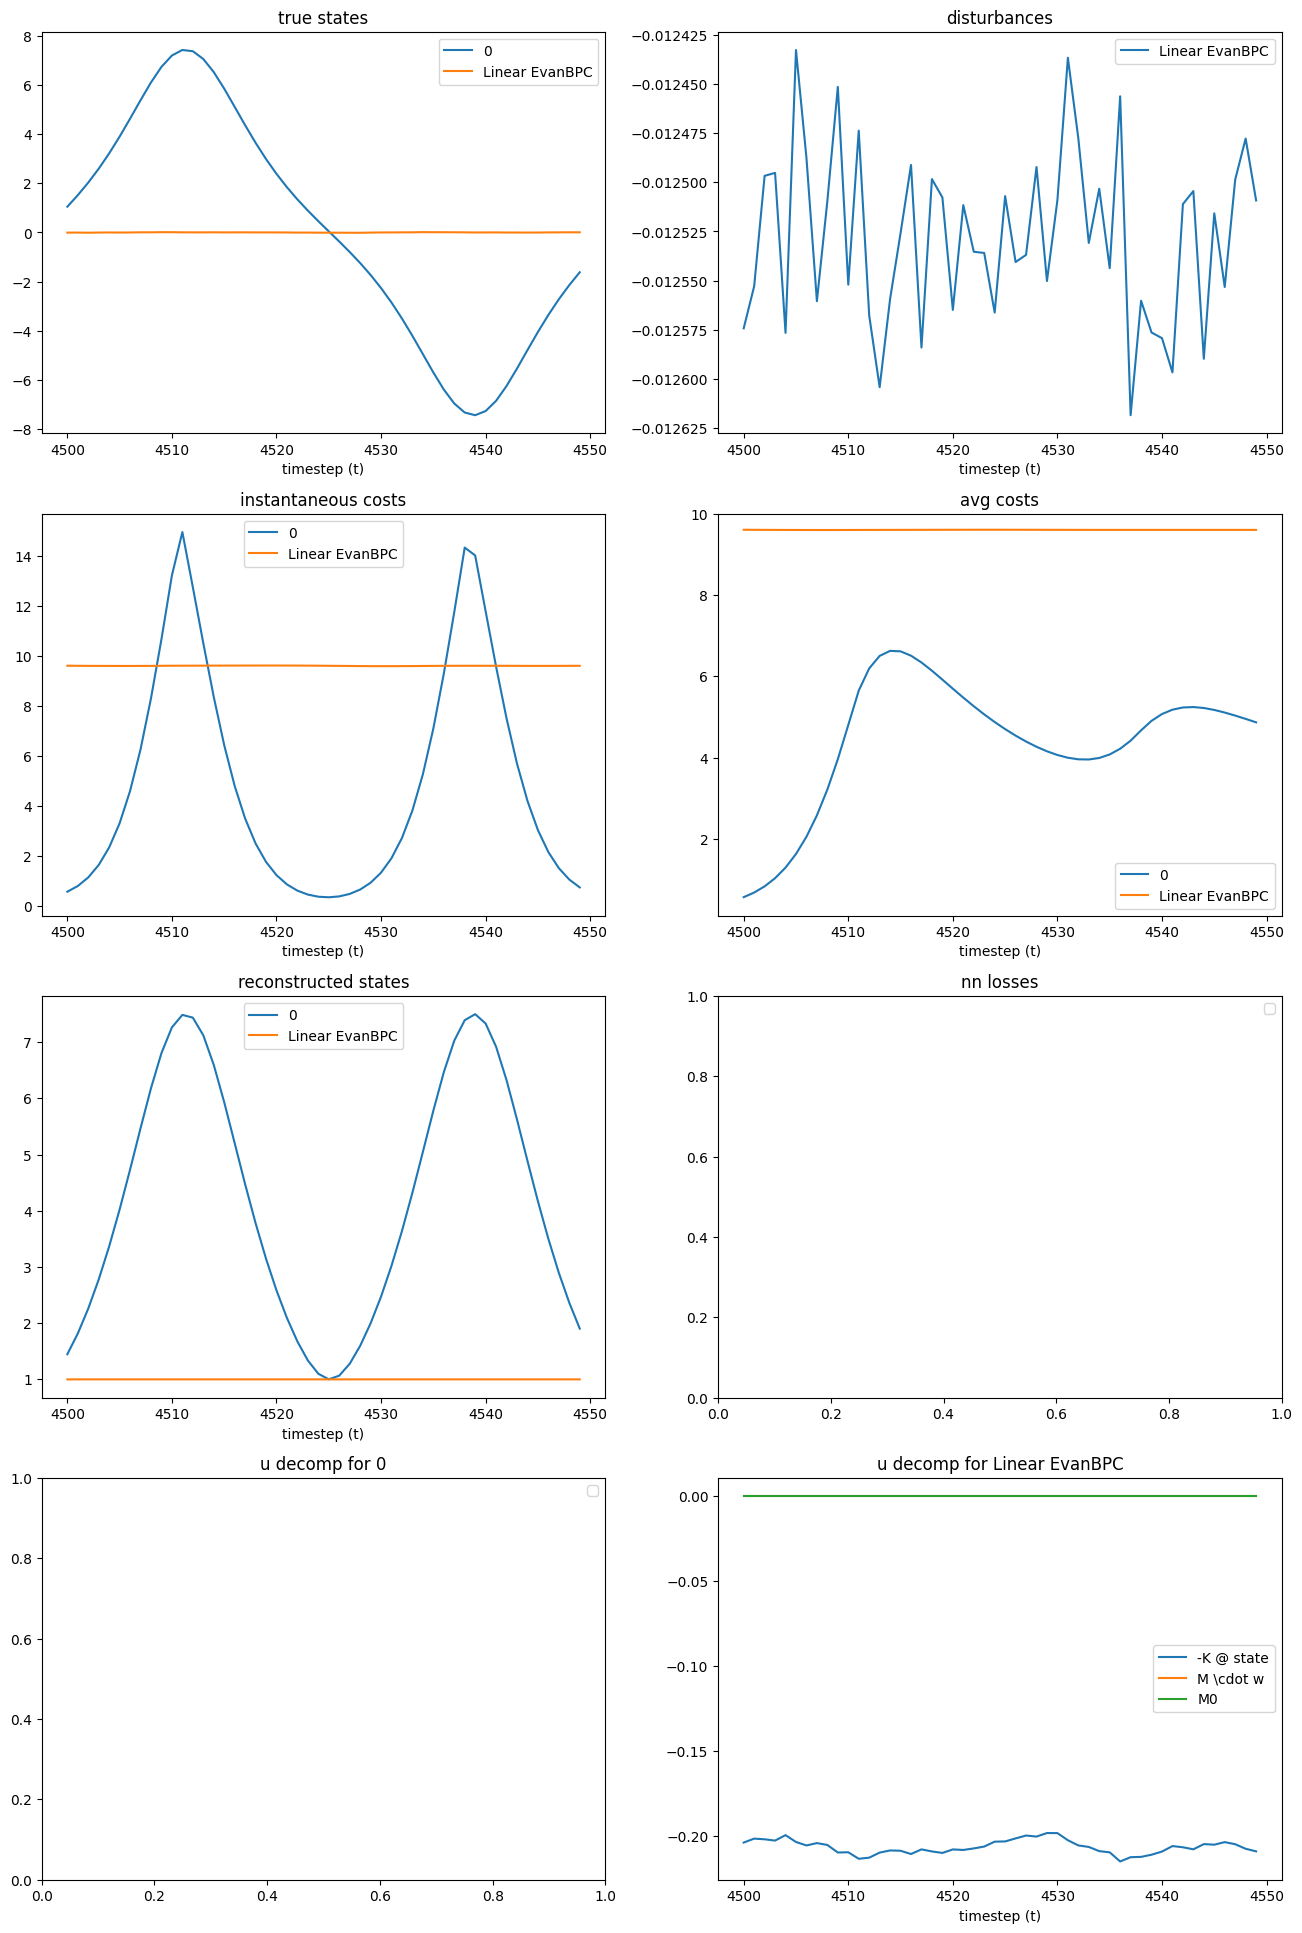

In [4]:
def plot(experiment: Experiment):
    assert experiment.stats is not None, 'cannot plot the results of an experiment that hasnt been run'
    all_stats = experiment.stats
    
    # clear plot and calc nrows
    plt.clf()
    n = 3
    nrows = n + (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 6 * nrows))

    # plot stats
    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            logging.warning('{} had no stats'.format(method))
            continue
            
        stats.plot(ax[0, 0], 'true states', label=method, plot_idx=2)
        stats.plot(ax[1, 0], 'costs', label=method)
        stats.plot(ax[1, 1], 'costs', label=method, plot_cummean=True)
        
        stats.plot(ax[2, 0], 'states', label=method, plot_norm=True)  # norm of the "state"
        from extravaganza.sysid import LOSS_WEIGHTS
        for k in LOSS_WEIGHTS.keys(): stats.plot(ax[2, 1], k, label=k)  # various nn losses
            
        i_ax = ax[n + i // 2, i % 2]
        stats.plot(ax[0, 1], 'disturbances', label=method, plot_idx=0)
        stats.plot(i_ax, '-K @ state', label='-K @ state', plot_idx=0)
        stats.plot(i_ax, 'M \cdot w', label='M \cdot w', plot_idx=0)
        stats.plot(i_ax, 'M0', label='M0', plot_idx=0)
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    # set titles and legends and limits and such
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('true states'); _ax.legend()
    _ax = ax[0, 1]; _ax.set_title('disturbances'); _ax.legend()
    _ax = ax[1, 0]; _ax.set_title('instantaneous costs'); _ax.legend()
    _ax = ax[1, 1]; _ax.set_title('avg costs'); _ax.legend(); ylim(_ax, 0, 10)
    _ax = ax[2, 0]; _ax.set_title('reconstructed states'); _ax.legend()
    _ax = ax[2, 1]; _ax.set_title('nn losses'); _ax.legend()  
    pass
plot(dut_experiment[4500:4550])